In [1]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import tensorflow as tf
import sagemaker

from PIL import Image
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

print('Libraries imported')


Libraries imported


In [2]:
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path, annotations={}):
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        
        annotations[image_name] = 'cat' if class_name[0] != class_name[0].lower() else 'dog'
    
    return annotations

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
annotations = get_annotations('data/annotations/trainval.txt')
annotations = get_annotations('data/annotations/test.txt', annotations)

total_count = len(annotations.keys())
print('Total examples', total_count)

Total examples 7349


In [5]:
classes = ['cat', 'dog']
sets = ['train', 'validation']
root_dir = 'custom_data'

if not os.path.isdir(root_dir):
    os.mkdir(root_dir)
    
for set_name in sets:
    if not os.path.isdir(os.path.join(root_dir, set_name)):
        os.mkdir(os.path.join(root_dir, set_name))
    for class_name in classes:
        folder = os.path.join(root_dir, set_name, class_name)
        if not os.path.isdir(folder):
            os.mkdir(folder)

In [6]:
for image, class_name in annotations.items():
    target_set = 'validation' if random.randint(0, 99) < 20 else 'train'
    target_path = os.path.join(root_dir, target_set, class_name, image)
    shutil.copy(os.path.join('data/images/', image), target_path)

In [7]:
sets_counts = {
    'train': 0,
    'validation': 0
}

for set_name in sets:
    for class_name in classes:
        path = os.path.join(root_dir, set_name, class_name)
        count = len(os.listdir(path))
        print(path, 'has', count, 'images')
        sets_counts[set_name] += count

print(sets_counts)

custom_data/train/cat has 2341 images
custom_data/train/dog has 4943 images
custom_data/validation/cat has 1167 images
custom_data/validation/dog has 2415 images
{'train': 7284, 'validation': 3582}


In [8]:
%%writefile train.py

import tensorflow as tf
import argparse
import os
import json

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.applications.MobileNetV2(include_top=False,
                                                      pooling='avg',
                                                      weights='imagenet',
                                                      input_shape=(128, 128, 3)),
        
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.layers[0].trainable = False
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

Overwriting train.py


In [9]:
%%writefile -a train.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    horizontal_flip=True,
    zoom_range=[0.8,1.2],
    rotation_range=20
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    ).flow_from_directory(
        os.path.join(root_dir, 'validation'),
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return train_data_generator, val_data_generator

Appending to train.py


In [10]:
%%writefile -a train.py

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--steps', type=int, default=int(7284/16))
    parser.add_argument('--val_steps', type=int, default=int(3582/16))
    
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm_model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    
    args,_ = parser.parse_known_args()
    
    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch = args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps
    )
    
    model.save(os.path.join(local_output_dir, 'model','1'))

Appending to train.py


In [11]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name = 'imageclassificationtest202'

print('uploading to s3')
s3_data_path = sess.upload_data(path=root_dir, bucket=bucket_name, key_prefix='data')
print('uploaded to', s3_data_path)

In [12]:
from sagemaker.tensorflow import TensorFlow

pets_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_type='ml.m5.large',
    train_instance_count=1,
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://imageclassificationtest202/data',
    sagemaker_session=sess
)

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
pets_estimator.fit('s3://imageclassificationtest202/data')

2021-01-25 05:21:12 Starting - Starting the training job...
2021-01-25 05:21:35 Starting - Launching requested ML instancesProfilerReport-1611552072: InProgress
......
2021-01-25 05:22:36 Starting - Preparing the instances for training.........
2021-01-25 05:24:10 Downloading - Downloading input data..................
2021-01-25 05:27:00 Training - Training image download completed. Training in progress..2021-01-25 05:27:11,251 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-01-25 05:27:11,258 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-25 05:27:11,823 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-25 05:27:11,839 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-25 05:27:11,854 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-25 05:27:11,864 sagemaker-containers INFO     Invoking user script


In [14]:
pets_predictor = pets_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('model deployed')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!model deployed


In [15]:
pets_predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'tensorflow-training-2021-01-25-05-31-36-938'

In [16]:
cat_dir = 'custom_data/validation/cat/'
cat_images = [os.path.join(cat_dir, x) for x in os.listdir(cat_dir)]
print(cat_images[0])

dog_dir = 'custom_data/validation/dog/'
dog_images = [os.path.join(dog_dir, x) for x in os.listdir(dog_dir)]
print(dog_images[0])

custom_data/validation/cat/Bombay_16.jpg
custom_data/validation/dog/samoyed_199.jpg


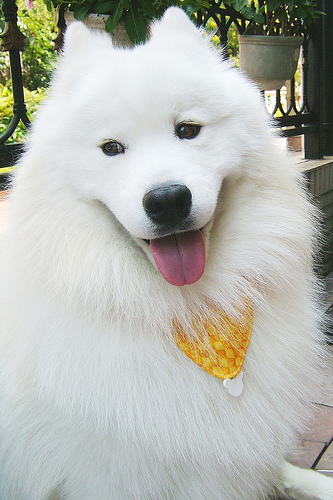

In [20]:
file_name = dog_images[0]
# test image
from IPython.display import Image
Image(file_name)

In [33]:
import json
import numpy as np
import boto3
import base64
runtime = boto3.Session().client(service_name='runtime.sagemaker')

ENDPOINT_NAME = "tensorflow-training-2021-01-25-05-31-36-938"

with open(file_name, 'rb') as f:
    payload = f.read()
    print(payload)
    payload = bytearray(payload)
    data = {"instance" : payload}

response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                   ContentType="application/json",
                                   Body=data)
result = response['Body'].read()

# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x02\x03\x02\x02\x02\x02\x02\x04\x03\x03\x02\x03\x05\x04\x05\x05\x05\x04\x04\x04\x05\x06\x07\x06\x05\x05\x07\x06\x04\x04\x06\t\x06\x07\x08\x08\x08\x08\x08\x05\x06\t\n\t\x08\n\x07\x08\x08\x08\xff\xdb\x00C\x01\x01\x01\x01\x02\x02\x02\x04\x02\x02\x04\x08\x05\x04\x05\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\xff\xc0\x00\x11\x08\x01\xf4\x01M\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x04\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x05\x04\x06\x07\x08\x03\t\n\x02\x01\x0b\x00\xff\xc4\x00J\x10\x00\x02\x01\x02\x04\x04\x03\x06\x03\x06\x04\x05\x03\x02\x05\x05\x01\x02\x03\x04\x11\x05\x06\x12!\x00\x07\x131"AQ\x08\x142aq\x81#B\x91\t\x15R\xa1\xb1\xf03b\xc1\xd1\x16$r\xe1\xf1\x17C

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: {'instance': bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x02\x03\x02\x02\x02\x02\x02\x04\x03\x03\x02\x03\x05\x04\x05\x05\x05\x04\x04\x04\x05\x06\x07\x06\x05\x05\x07\x06\x04\x04\x06\t\x06\x07\x08\x08\x08\x08\x08\x05\x06\t\n\t\x08\n\x07\x08\x08\x08\xff\xdb\x00C\x01\x01\x01\x01\x02\x02\x02\x04\x02\x02\x04\x08\x05\x04\x05\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\xff\xc0\x00\x11\x08\x01\xf4\x01M\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x04\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x05\x04\x06\x07\x08\x03\t\n\x02\x01\x0b\x00\xff\xc4\x00J\x10\x00\x02\x01\x02\x04\x04\x03\x06\x03\x06\x04\x05\x03\x02\x05\x05\x01\x02\x03\x04\x11\x05\x06\x12!\x00\x07\x131"AQ\x08\x142aq\x81#B\x91\t\x15R\xa1\xb1\xf03b\xc1\xd1\x16$r\xe1\xf1\x17C\x82S\x92\n%4c\x83\xa2&\xb2\xc2s\xff\xc4\x00\x1e\x01\x00\x02\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x00\x05\x06\x07\x08\t\n\xff\xc4\x00@\x11\x00\x01\x03\x02\x04\x03\x06\x04\x05\x04\x01\x03\x04\x02\x03\x00\x01\x00\x02\x11\x03!\x04\x121A\x05Qa\x06\x13"q\x81\xf02\x91\xa1\xb1\x07\x14\xc1\xd1\xe1#BR\xf1\x08\x153b\x16$r\x82C\x92DS\xb2\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xe7\x83\xdb/\xfe\x12\xc3\xb9\x81\x86\xe5\xac:\xd5\x98\x8e\x13\x82\xe1pK[-\x07\xbaUV4\xd4\x10\xd6\xb2\xd4DIh\xfaMZ\xd0\xc7\x19\xddU\x1bWqn\x1f\xb3u\x1e\xfc7{Q\xb9\\uh \x80E\x89\x07y\\\xd6\x1a\x85j!\xb4\x08\xb0\xd3\xdf\xd9S\xec\x0f\x10\xa0\xa0\xc6\xb0z\x8a\xda\x06\xc5phq\nj\x89\xa0\xea,F\xa2\x15\x95$\x92\x1e\xa3+\x04f\xb3\xae\xa2\x18-\xc1\xb1\x02\xdco1&\xa1a\r0H1\xd0\xc5\x8f\xa2\xd9\xd0\xa8\xf1\xfdB$\x89\xf9u_\xa4G\xb1vh\xe5\x0f0\xfd\x92yq\x9fr^q\xa8\xcf\xdc\xb8\xce\x183>\x1fC,\t\x1dEDu\x1f\x85\x1e\x17WON5\n\x9a&\xa7\xa9\x86P\xf7R\xf1J\xca\xcc\xb6c\xf9G\xdb/\xc3\xda\xdc;\x8c\xd5g\x11o|\xf0r\xb5\x831\x05\xee\x875\xe0\x082.\xef\x14\x88\x9d\xc2\xf4\xde\x0bR\x95>\x1c(0\xdc\xdd\xc7\x9c\xcf\xfaG=\xae9yE\xcd\xce^\xf2\xef/\xd6`j\xd8%\x1e?I)U\xa6\x10\xb8\x96\x9f\xde#\x8d\xa1\xbe\x90\x8c\xa5\xa3\x94H\x84\x0f\x05\x85\xb5\x1b}\xff\x00\xd8\x0e?\x85\xe2\x9c&\x8dlC\x01,aa\x05\xa3Q-.\x88\x8b\x8b\x88\xb7\xd9z7\xe1\x9e?\x0b\x84\xfc\xc0p\x1e6\x16\x80n\x04\xc1\x98\xe9\xb7U\x9f\'e\xaeRe\xceP\xe5\\\xab\x93\xf9m\x959\x1b\x88\xc7\xd1\x9e\xae\xae\x92\x96\xd1\xd3\xe2(5\t\xe5\x92DidwmD3\x97u\x12\xe9\'\xbd\xfe-\xfc\\\xe0\xf8g\xf1\x03M\xef4\x9e\xc2\x0b\\\xd2r\xf4\xb7\xde<\x97\x07\xc4p\x06\x9dGR$\x16\x83!\xdfU\xae\xaf\xda;\xec\xbb]\xcd\x8eG\xe3\xfc\xf5\xc9\xf8\xedA\xc62.NZ\xdcn\xf8wR,R\x91f\x08\xf2\xc1"\xc9\xadX\x16 ;\x03\xadC\x12\x14\x81\xc6\xbf\xf0\xd1\xd5\xf8v5\xf5\xe9\xd0}Jd0Uva\x00\x93\x19\xa3P\xd91{\xdfH^s\xda|6Z_\x9c\x06\x1c\x1b\xbc\xdcN\xa1s3\xcd\xac\x91I\x88{2f.qUA\x82>o\xc9\xf9\xb6<3\x10\xc4j\x19\xa0\xaa\xaf\xc2ki\xa9u\xac\x8c\xb7\x1a"\x96\t$G\xb6\xa4V\xaa\xdc\x87\x04}a\xd9N\xd1\xba\xbf\x17g\r\x16\xa3U\x84\xb4r{\x0e\xe7\xa8:n@\\\xf57\x9cCK\x9f\xa8 \x13\xa4\xc8\xb0U\xef<cy\xbf\x93Yw\x00\\uh\x1b\x1f\xc5\xf0\x8a:\xaa\x0c\xbf[O\xd7L\x18\xcd\x04u\r\x1dls%\xdd\xe2\xa6\xaa\xa3\x064\xb2u*Z6$\xc0\xe3\x8e\xef\x0b\xd9\xac5|c\xa9\xb2\x7f\xa6|N\x1b\x90b\xde\xa0\xfa\tW\xaap\xe74\x86<\xf8\xe2|\xbay\xaf\xee\\a\xf9\x0b6r\xeb\x9d\x99\xdb\x998\x8f&\xf9_S\x97r\x85\x0e)\x93p\x98p\xba\x84\xad\xcf\xb8\xb4\xd8\x8cT\xeb\x86\xd1\xd3EU\x1a,"\x9c\xd4O$\xea?\x05\x04nQ\x90\xc9c\xe3\xc2\xbe\x1f\x15C\r\x84\x0f\xacjT!\xe4\x96\xc56\x06\xc9y.\x04\x90\x0c\x0c\xba\x92T\xe38dQ\xef\xea\x1b\xba s\xb8\xb7\xeb\xe8\xa2\x8cC=6g*\xb8\xd6[\xca\x94\xf8d\x13#S\xb4t\xc5*i\xd5,\x14\t\xf5]\x88\x00l\xd7\x04\xde\xfd\xc9\xe2\xfd\x1e\x17\xf9{Q\xa8\xe2\xe3\xae\x90\xb4\xaf\xa2\x04\xb7Y\xe4\x82b\x98\xf6%\x8d\xe1\xb4X]\x1d6!\x84\xe5zZ\xd6\x9e0\x8a\x90\xa5|\xe4\x1bM -v\x99Q\xca\x8b_@\'\xf8\x897\xf0\\&\x9d\x07\xba\xa5C5\\\x06\xb7\x81\xc8t\x9dS^\x1a\xc0\x03\x8c\xcacb\xf5\x98\xce&(pg\x95.\x84\xc8]F\x9b\x86\xb0\x0c\xdeW\xb5\xec\x05\xbb\xde\xf6\xe3u\x83\xa1F\x91uS}\x91R\xa7I\xb3k\x1d?\xda~\xe19f\xb3\xf7]%,\xb550a\xe1\x8c\x89o\x1e\xe6\xc5\x9bK\x10\xaa\xc6\xe0_\xc4\xdf\x0e\xdd\xb8UAM\xcf5@\x12m\xec\xadF#\x1eL\xb8\x0b\x8d\xfa%\xd5\xb9_\n\xc2\xe1v8t2\xd4\x95\x00\xb5S\x19\x987\x9a\xe9R\x91\x82<\xc9\rk\x1d\xce\xfc#\xf3\x0f\xccXL!\x18\xc7\xb8\xcbn\x84\xe5L\xadI\x89c\xb4\xd4u\x9a\x12\x88Jg\xa91\xa0@\xb4\xf1#K \x16\xb6\xfa\x11\xad\xf3#\x85\xe2\xf1\xff\x00\xd23\xd7\xf8Vqx\x87Y\xa7]aI\x18\xd5l\xf8\xbba\xd2\xd5\xd3{\xabt\x90\xba\x8d\xc2\xc9\xb8\xd4\t\xde\xe5|?;\x03\xbe\xfch0\x8d\xeeY\x95\xda\x9b\xfaD\xa42\x90\xa8\xec\xf7\x9e\x8a\x0c\xcc\xf1W\x87\xc3\rt\xaf8X\xa4\xa2\xa5k\x02zQJ\xdaA\x07}\xb5X\x03\xb8[q\xd6p\xe6\xb44\x81\xa6\xa7\xd5np\x95dO\xdd{\xc0k\'Z\xa8)\xc5Y!K4]\xbf\t\xd7q\xf4\x04\xf7\x1e|/\x1bI\xa4\x174 -h\x04\x81m=\xf4Fq\x0c6&:\xe1\x8d\xd6\x8aF\xb8\nl\xd08\xdc\xa7\x9fm\xec|\xd4\x8fM\xaaR\xae[\xae\xaa\xb1{a\xce:h\xa6\xbc"\xbb\x04\xa8\xc2\xdb$a8\x1c\xb2\xe5 \xb1Vb\xb5\x95u\x12A\xd6\x882\xea.\xb12\xb3\xaakk)c\xe3\xb1 \xd8[E\x8a\xa4\xee\xf0\xe2\x8b\xa1\xc3A\xac\x1e\x9dO4\x15\xdc\xc6065\xd7\xaf$\xcc\xaa\xab\xc2q|\xcb\xfb\xf2\x9b\x10\xaf\xcb\x8f4\x90"L\xed\xff\x00.\xca\xfa\x91\x12\xc4\x86D\x0b\x12\xafr6\xf2\xe3u\xc3p\x95\xfb\xb6\xd3\xc9\x99\xdc\xa2\xf2ON\xa9\xd5iX5\xd7W\xff\x00#\xfe\xcd\xbfl.e\xe4<k\x99xW#\xb3\x94\xf4\xc6H\xa2\x85\xfa-\xaa\xbd\xa6\x96\x18\xd1\xd42\x82H5V$\x8b\x85,[\xfc3\xc7\xa1\xbf\xf0\xd3\x1bR\x90\xcd\x95\xaf1\x00\x98\xeb\xe8\xa8b\\\x1c\xd0\xf6\x03\x018&\xe5\xff\x00\xb4_\xb1\xc5g9"\xff\x00\x8asw&\xea\xe9\xa8\xa0\xa4\xa9\xa7\xa6\xc5g\xa2\xab\xc4\xa1\x9e\x15\x8aXi\xa3\x8c]\x8e\xb8\xe7\x0f()\xd3E\'X\xbd\x8f\x89v\xcf\xb0\x98\xdax\x9am{\x0bA\xfe\xeb\xe5#y"\xd1\xd2Q\xd5\xe2X\x96\xb5\xd4i\x92\x19\xa1\x13\x13\xe4\x15{\xa0\xe5\xeez\xcf\x19r\xbb0e\x9a\x18\xf1,\x12\x99TW/NIM(\xe9\xdc\x9d+v{\x8f \xbf\x98n\x01\xbf\x17p\x9d\x84nN\xfe\x8c\xc7\x9f\xda\xcb\x9c\x18\xba4^3\x9f\x11\xff\x00J:\xc9SV\xe1\xb2\xcd\x88\xd2\xc5\x8aQT\xcc\x1a\x9ax\x11\x04T\xf5h\xdd\xe3\nM\xd5\x87\xc4\xa7\xc9\xb4\x83\xdc\x9e5}\xa1\rcC*\x89\x1dV\xeb\xfaN\x10\xdb_\xcd>\xf0v\xc89\xa7\x12\x9e\x93\x11\xa9\xc2\x1f5<\xc4\xa5=Lf\x8a\xb4*\xee\x8fM(\xb6\xab\x03`c}Jn\x19-\xe2<\x9f\x14\xa9\xc40\x94\x1bS\x0f=\xd8\xbd\xae?\xfb\x08W\xa5\xce\r\xaa\xd7i\xafO5\\s$\x98\x9f"\xf9\x81\xcb\\\xe5\xcb\xdee\xfb\xce\x7f\xc0q\xe5\xcc\x14t\xefC$o\x97+)+#\x9a\x86G\x0e\x04\x15\x05\xfabF1\xfc\xd5\x80\xbd\xf8\xf5n\x05\x8ag\x1a\xc0\xd4\x15\xe9d\xef\x18ZH f\x91\x06\x08\xb8\x82m?U\xbc\xc1\x96T\xa7\xc8\xcd\xf9\xcc\x88\xba\xdaO"9}\xcdo\xda\xcd\xcf\xcfh\x9fi.ae\x1c\xbd\x80\xd0a\xf8\x1c\x98}-\x0e\x04\x1a\n\x1c+\x18\x96\x84E\x87$Q;\xc9*P\xd3\xa2\xb4\xcc\xf2\x17\xd5,\xa8\t\xb6\xa0\xbc?\xe2\x17n0}\x97\xc0\xe1p5\xab\x06\xbd\xc5\xadl\xc0\xf06\xc7\x90\xd3}wU\xf0\xd4\x19H\xbd\xacfa2u\xb2\xd7E\x1ey\x87!\xe2\x1c\xc7\xe5\xd73\xf2z\xe5\xae``\x9dz3G0\x91c\xaf\xae\x86UW\xa5\xa8?\x1c\x05\x80i\x15\xc6\xa5f\x00m\xa8\x1e:\x8a]\x9dmW\xb3\x13\x85\xaa*Q\xa9pD\x1b\x1b\x826!S\xc5\xf0P[\x99\xa6\x04\xc8\x95y\xb9\x1c\xb59\xc7\x97\xf8\xbe-\x88<T\xf0\xcf\x0c\x15Q\xc5\x87B\xcc\xa8\xc9\xa5\xc8M\xfbj\xf8\x8d\xc9\x00}\xb8\nl.5\x19S\xc4A\x8eV\\\x07\x16ki\xd6\xee\xcd\xfat\xba\xb4\x9c\xb4\xcc\x99W\x96Y\xdf)\xd1\xe7\xfa\xccN\xa3:\xe6\xbcV\x9aXfY\x9a:\x0c\x1e\x9d\xa5Q\xef\x95\xf5eJS\xc6\x19\x01\x0e\x07P\x08\xcb\x01\xa6\xe4\xeb\xb8\xfd\'\xd1\xc0\xd5}*]\xec4\xcf\xca#\xae\xba#\xe1\xf4s\xd4\x01\x8e\xca\xd1\xf4\xde\xca}\xe7\x97\xb7\xde#\x8f~\xd6OaZ\xea|\xeb\x06E\xe5n\x1a\x90\xe0U\xf5u\xb8\x9a=\x0c\xd4\x98\x84U4\xf5\xbdi\x07\xe1\xaa\xcb*\xc7\xa6B|\xe9\xe5\xb8$[\xe7\xea\x9f\x85\x18Wv\x13\x12\xfcE\x06\xbe\xbc\n\x90\xd6\xf8\x9a\xe6:D\x01}&c\xfbL\x15\xeeX^\xd7~`\xb45\xc4E\x8c\xdeg\xaa\xd6O\xed\x83\xc8\xb5\x9c\xd3\xfd\xa1\xdc\xc1\xc4\xf2\xa6\x13O\x86\xd5\xe6\x1c6\x97\x19\xc5\xd8\xd55<\x18dQRG\x15EUM[\x03\xd3\x8d\x04^)lN\xb0,\x19\xb4\xa9\xfa\x1b\xf0;1\xecn\x1f\x11\x88vK\x18\x9b\x803\x18\x80o\xe9\xbf%\xab\xe2|R\x93*\x97\xbcxu"g}\'\x7f5\x13{Z\xf2o\x12\xc9\x1c\xf3\xc61\x1cs$d\x1e\\K\x9a0\xf8\xf3\xad\x06X\xca\xf7\\7,a\x98\x84\xb2\xbd5\x14\x01\xed\xfe\x140\xa2\xed\x7f\x8a\xe4\x06%T\xbb\x1f\xdaz8\xfc\x10~\x12\xb7|\xd6\x9c\xa5\xd1\x12\xe6\xd9\xd0\x06\x97\xd0j!k\xb8\xbe-\xb5)\xb4Sf@N\x9d\x15f\x97\x05\xa6jZ\xdcC\x14\x0bM\x84C+\\1a}\x08Y\x89\xf3$\x1d \x0f+\xdb\xb9\xe3\xa8\xa0\xf2\x1c\x1cy\xe8\xb9\xf1\x88\x92\xe1\x10\xe3\xf3SG(}\x949\x8f\xce\x8emb\\\x98\xe5\xf8\xc9\xb9\x8b?K\x83Rc8*A\x8a\xd3\x1a<J\x16\x9a!UP\xd5\xea\xc68\xe9) \x18\x8dD\xf5\x0e\x0e\x85\xa2\x91B\xeax\xc3W\xa7\xc5p\xd2\xc8~V\xbaG\x8a`\x10&\xff\x00\xa0\x1e\x8b\xb3\xa7\xd9\n\xf5\x81\xcc\xe0\x0c\x03\xe7&5\xda\x13\x1a\xa7&Qb8v\x17\x16\x07[GGI\x8a\xe2\xb8}.\x175r\x12\x93K-J\x88J\x02\t\n\xc4\x01\xa5\xc0\xd2\x1f\xc7\xa5C\x157b\xd8\x1c\xea\xc4\xf8\x00&\xdaG=W)\xc1h\xba\xa64a\xc3\x80t\xc5\xd4S\x9c2n?\xca\xac\xfd\x9b2\x1e|\xff\x00\x87\'\xcc\x98\x0e+S\x84\xe3\r\x84\xe2\x94\xf8\x9d+\xd5A!W\xf7z\xc8\x1d\xa1\x9e0CZH\xc9S\xb8\xd8\x82\xa2\xfe1\xecu\xb0\xcf\xce\xdbA\x1a\x1f[\xcf\x9e\x87ew\x19E\xd9\xde\xd77\xc4\n\x98*\xb3\xd7\'\xb1L\x95\x83\xe1\xb4\x98\x06c\xab\xcd\x18}I4\xd2=\x1a@\x122\x8b#1\x92&\x1e\x05\x92\xecY\xf5Jv\nUx\xd5\xd2\xc4\xe2\x18\r\'S\x10o\xa8\xf9i\xf4\\\xf3p\xd8\xa6\xbf6\x9d5U\xc31Qa\x94\xd4\xb7\x8f2>/\x8b4\x81\x1e!$\x934j,Af\x90YE\x8f\x91\'\x7f\xa9\xe3\xa1\xe15\x1cL\xb1\xb9Y\xe5\x1fe\xbe\xc3=\xee\x99l7u\x8et\xd5\x940\x80$\xd6D\xf3-\xac|~2}\x07\xf2<tx{\xd1q\xdaU\xb7^\xac\xb2\xff\x00D\x0b\t[\x1a\x9d)\xd5[\xad\xb6\'\xd4\x7f\xa7\x19X\x17\xc1\r?ua\xe6\x9b\xc0{\x8c\x1f\xd9Y?h\xac:|J\xb3&\xf3#6c\xd8\xb6%\x9e3\x1e\x17,x\xac2@.\xb2a\xf2E\x87\xc3+\xbd\xc7\x8aJx)K\x12\t,\xba\xee\xc5\xc9\x1cgd\xaa\x063\xf2\xac\x1e\x16\x11\x94\xf3\x0e\xbcy\r\x12\x1b\x8dmB\t\xbd\xaf\xd0\x8b}\x95k\xa4\xa7\xa1\x95\xda\x92\x96\xb1\x96\xa1\xca\x8d\x13S~\x1b9;+\x15b@;\xdd\x87a\xeb\xc7UP\x8c\xd3\x94\xdd\\\x15\tin\x87p}\xf2]\xca\xfb\x18\xbej\xc9\xdf\xb2\xbf\x91\xf8g\xb1fu\xc5\xe4\xcdX\x96D\xc3\xce\x0b=e\x1c\x0bT\x98\xbd]T\x92VM,U\x0c"\x85Ml\xd5\xc4\xba\xb5\xbaQF\xe1\x9a\xfb\xfeV\xfe.\xfe)\xb9\xbf\x88X\x8e\x05\xc6\x9c\xec8\xa9U\x8d\x96\x98\x06\x90\x88\xf1\x81i\x07\xc5\x10f\xd2\x17K\x89\xc4T\xa1@;\x0c\x01\xb0\x89\xda\xff\x00\xa2\x9e}\x83\xf9\xebU\x88\xe5L\xd1\xc9~h\xf3\xcf\x07\xe7O>\xb0J&\xaf\xc4b\xa9\x8d)\xe1\xc2\xf1h\xa6x*p\xb8Z\xe5\xeb\xe9\xf5?Q\xb1\x05R\x8c\xa5\xb4*\xec8\xeb\xbbC\xdb\xe1\xd9\xcang\x03/e\x1a\x8d\xfe\x99x\xcc\x1c\xe3b\xde\x8d"L\xba\x08\xe5u=\x91\xed\x03\xb1$\xd2.\x9a\xa3}7\xd3\xacsS?-\xf9y\x9f\xb0Nfs+!\xe7|\xd1\x81\xe5\x9e_M\x82\xd6\xd2e\xf8\xebj\x19\xe1\xc3$\xa8\xac\x8eyt\xc9\x18+c1\x8e(\x96K\xba\xa9\xb6\xc0\xf1\xc3`qtq\xb4j\xd1\xa9W\xbayans%\xbf\x109Z@0K\xb4\x95]\xd8\x1csq\x0f\xa7U\xd2\xcd\x05\xf9\xdc\xa97 \xe5\xdc\x17\x17\xc8|\xd8\xe5\x165V\x9c\xd0\xa9\xc6\xb0\x89\xb0<J\x9eY\xe5\x14S\xc38\x96\x99\xa2JdR#b%\x91\x01\x05\x8d\xd4=\x97O\x1a\x0e\xc8\xf1\x1a\xf5\xb1\x18\x9c.\x02jT\x813\x9b6y\x80Z\x00\x82u\x131\x17\xd1t\x958u\x1f\xc9\xf7\x18\xa39\x81\x1a\xecu\xf2\xe8\xb4\xf1\x94=\x94\x8f"\x9b\x9a<\xa4\xa9\xaf\xcej\xf9\xd7\x01\x99"\xae\xac\xa5\xa6\x8aJ0\x94\xf3\xc4\xbave\x96R\xa5\xba\xcd`J\x9dJ\x8b{\x8fJ\xecwk\x9d\x8d\xc7;\x0b\x89fJ\xb4\xef\x01\xc6E\xe6I\xb5\x81\\\xc7\x07\xe0T\xa8\xb9\xd8b\xe2\xe2H \xf9O\xa6\x8b\x9c\xef\xda\xdb\x81\xe2yk\xda\xe2\xbb\x03\xc5d\x96\xb7\xde\xb2\xb6\x1f\x99\xa2}e\xa4\x95\xf1)\xeb*\xa4.\xfd\xcb\xb3\x1b\\\xee\x00E\xbf\x86\xc3\xee/\xc26\x9f\xfauJ\x93\xadG\x03\xe8\x01\xf9\xdc\xa6\xf1\xbaA\x98\xd2\xd2yB\x97p\x9fe\xf6\xcf\x1c\xad\xa5\xc8\x99\xd3\x12\xcdG1>1I\x8b~\xfc\xa0T\xe9C<T\x06\x98\xd3\xc5H\xab\xd2jb\xb2\x92\\\xafP:!\x0c\xa0\xb07\xa9b)\xb7\x18ja\xc7\xf4\xe0\x88&\xf7 \xcc\xfam\xaa.%\xc3\xb1/c\x1bT\xf3\xf2\x8d\x95=\xcc\x1c\x9b\x8b&s\x031\xe4\'\xc4\xeb1\xcaz\n\xdfti\xe6\xa7\x10\xc8HE,z[\x8f\tf\xb5\x8e\xe0_\xb9\xb7\r\xa5\xc5\x0b\xe7 \xcbs\xd7\xea\xbc\xe7\x89\xd44j9\x90-\xfa\xa2\x19\x83"\xc9\x83\xe0\xab\x8c\xcf\x87\xa5P\x1ai\xf0\xfa\rb\xd2\xb1\xbb*\x06\xb5\xc7\x9bH\xff\x003\xde\xe0p\xb7<\xf7\xc2\x882\xf7k\xd3\xdf\xddjh\xd5}GwL\x1a\xc4\xf4\x08\x86E\xf6\x0b\xf6\xac\xce\xb84\x1c\xc8\xc1\xf2\x96\x13\x89\xd1\xd4\xb7X,\xd8\x94t\xcf"\xf4\xd6D`%\xd27\xd4\x10G\xda\xdb\xea\x00q\xe8\xce\xe0\xd4{\xa6\xb1\xb5CLho\xf6]\x86*\x91\x14\xfb\xa6\x0b\x8d\xd3\x96og\xaev\xd2f<\xd3\x94p.Zc\xf9\xf3\x1d\xc0\xb1\x19\xb0\x9cQp\x1a\x8aj\xa1IY\x0ck$\xf0\xb1\xeb\x02\x1e>\xb5\x98X\xda\xccw\x04q\xcfR\xe0\x98\x8a\xcc\xcdI\xcd\xcb\xa4\x93\x1a\x18\xf3\x8e\xab\x98~\x06\xb6\xae\x10=\xca\xaf\x9c\xc4\xca\xbc\xf2\xcbfJ\xac\xd7\xc9\xfeb\xe5\x0c\n\x17\x10I=n\r:\xa0$\xe9Pg+\xa1I\xf2\x17\xdfn\xf7\xe0\xdf\xc1E1\x9a\xbb\x81=\x1c#\xf7+e\x83\xc1\xd2`\xcfVo\xa6\x9f$\xe9\xe5\xe6_4\xf9Fz\xea\xbb\x0cC\x10x\xf0\xc4-v\n\xa0\xa4\xf5\x0c/\xd8mO\r\xed\xb8\x95\xc7\x91\xe3\x91\xc7<U\xc46\x98\xd2g\xe5\xa4-o\x10\xc4\x02\xe2\xfav\xb5\xb9&nv\xccP`\xfc\xda\xc2\xa4\xa7\xc3plz\x93\x0b4\xd1Ua\xf5\xc6ov\xaf\n\xddG\xa7\xa8\xe8\xb4r\x18\xce\xca\xc1\x19\x1br5)\xdf\x8d\xebi5\xf4\x1e\xe7Zt<\xad\x12\xae\xf0:.u\x1c\xee\xb1)\x83\xee5\xd3\xe0u\x12V\t*j)*\x92Y]\x95uH\xb3!RM\x80\xfc\xf0\'m\xbc~\\\x150\xd1P\x06\xe8D\x0fD\xeau\x19\x9f(:#t\x95\x93{\x9e\x17\x87\xc3\x86\xd3L\x88\xa2\x90J\x10\x06t.\x08\xd7`M\xf7\x03P\xb9\xb1\xb5\x89\xb7\x14\xeaa\t\xa8\xe7\x17kxO\r\xcee\xc6\x0f\xe8\x9d\x95XLp\xe25t\x91\xb5\x15]\x802$R\xeb\x0c\xbb\x11f\xb0!\x94\x92\r\xc0e`\xca\xca\x08#\x8a\xef\xb3\xbc7Z\xaa5g3]\xf0\xc9Xf\x8f\x16\xa1\xbd>\x1e\xf5\x8b\rm,\xcb3Ge\xea\xd3#\x86f&\xfe\x0b\x15k\xee\r\xd7}\xb8#\x862\x0b\x9b\xa1\x9fUx\xd4\x05\xa1\xe4i\xecYt=\xfb\x00\x7fg\x16^\xf6\x8b\xe6\x9e/\xcd\xfen`\x11\xe3<\xad\xc9\xd50\xb2\xe1\xb5t\xf7I\xb1\x98\xe5\x12,3#Y\x91B\xba9\x8d\x83E(C\xa9CD\xac}{\xb3\x07\xf24\xdd\x8e"*\xe8\x01\xda\x7f\xba:\r\x0f5\xb0\xc3\x01\x88t\x90\xbb\xa5L7\x0e\xc3\xd6:l2\x8a\x9e\x92\x9e1\xa1c\x8d\x00P6\x00m\xf4\xb7\t\xef_Y\xd9\xdcn\xb7/\x01\xa26U\xbf\xda;\xd9W\x92\xbe\xd3Y\x07\x1d\xc8\\\xd3\xc9x.3I]\t\x81\xea\x1a\x05\x13*\x92I\x02Kj\xb1\x05\x94\xfc\x98\xf9\xef\xc6\xf7\x07\xc4^\xc1\xdd\xbf\xc4\xc3h7\x0bG\x8f\xc0\xd3\xaa3E\xf9\xae59\xcd\xec\xf9\x9d}\x85s\xd6i\xe4~j\x8f\x0c\x8f!W\xd5\xd6f\n\x9cd\xfb\xcc1=;j\x92>\x8c\x80\x85\x95\x92\x15\xd0\xe8\xe1\xd0:\xdc)\xe9\x82\xdcgkxk0 bi<\xfe\\\xed\x02\xe7\xe7\xaa\xf3N%\x80{\xaaEV\xf8\xc5\xac\xa8\x1f\xb4\xbf(\xaa\xf0\x9fc\xec\xb7\xed\x81\xcbL\xf9\x94\xf1l\x85\x8eg\xa9yz\xb44\xd4\xb2\xc3\x8a\xe5\xbcMh\xa5\xab\xa9\x15\xcb \x01ZH\xe9\xe3x\xa4MA\xa2\x91\\\xe9.\x00\xf0\x0e\x15\xdaL\x17\x16\xed\x19\xe1u\xda\xe1Z\x933\xe5p\x86\x96\xda\x0bL\xcb\x85\xe0\xda\xce\x04j\n\xf4\x1e\x01\xd9J\xd4\xb0c\x19P\xf8\\b\xd72$_m\xae\xa9\x0eI\xa0\xe5\xc6x\xc1\xf0\x88\xb9\xc1\x8ec\xd9C\x02\x8f\x07\xc5\xa7\xa5\xc5h)\x12\xa2SYOM7\xbb\xa7L\x91\xad\x1e\xa6\x18\xe1r\xa7R\x89\x89\xb8+\xc7z][\x07]\xcc\xa0\xc0\xf0H\x10\x0e\xc7\x9f\xbb\xa6\xd2\x8ax\x8c\xa4X\x82\xab=<\x15UuT1\xe2u\xb4XmMA\x84K-]S\x08\xa9K\xd8k\x9aB\x0e\x98\xd6\xe4\xea>Jv\xe3\xb8}&\xd2\xa7\x99\x82\xc3`>\xcbh\xc8\xcc\x1a\xd6\xc3\x84\xcc\xab\x13\xcc\xdfg_h\x8ff\x1c;%\xf3\x036\xe1Y\x97 a\x19\x8e9F\x07\x8ea\x98\xac\x90\xae"\xb17\x89Rjy\x04\x9b\x11\xa8\x07\x000\x1a\x96\xf6\xbf\x1c\xcd.1\xc18\xeb\x0bhd\xad\x97V\xb9\xa0\x91\xe6\x1c\x0c\r\xa4,\xa3I\x95\x1a^\xeb\x03cr$(\x076\xe6\x1c\xd9\x9b1\xb1\x99\xf3\xfe5\x8f\xe6,\xc3\x89D\x93.#\x8b\xd4I5Mz*\xe8G\xebK\xe3\x99@\x8c({\x9f\x87\xbe\xc7\x8d\xcf\x0b\xe1\xf8l.\x1d\xb8|\x13\x03\x18\xdf\xedl@\xe9\x1b]Z\xa1\x86\xc8\xc8 \xc7_\xe5N\xbc\x96\xf6\xa4\xce\xdc\x97\xc3q\xfc\xb9\x87\xe1\xb8&?\x95kR\xf0PWu\na\xb5:@\xebE\xa5\x81k\x11\xad\xa1$+\x9d"\xeb{\xf1\xa2\xe2\x9d\x9c\xef\xaa\x0cE\'\x16\xbfC\xa4\x11\xd6t<\x8e\xddV\xa7\x89\xf6~\x86-\xe1\xef\x10\xe1\xcb\xec\xae\xbas\xbf/g\xa8\xd2\xbb*b\xb8\xb6k\x81*$\x92|O\x1c\xa5Zz\xb9i 6\x8e\ti\xa3,\x12y\x80\x8c\x15B\xc9\x18\xb8BUw\xd3\xe1\xaa\xd4\xa1@a\xf1\r\xc8\xe6\x8b\xc1\x99\'\x91\xdc.3\x13\xc3\x8d7e"%G\xfc\xd3\xe5\xb7\xfe\xa0\xcd\x82\x1c\xc4\x17\x0e\xc3+*U\x8e\x1a\xf2t\xec\x9dA-K\xac\xaa\x8d"\xb7AY\x11\x80\xb2y\x83s\xc6\xcf\n{\xbau\x0b\x07\x88\x88\x06,\x0cn:\xee\x83\x84b\xcd\x13\x94\x89\x8f\xb4\xa9\x87\xdb\x83\x9e8w23\xa71\xf9\x95\x921d\xaa\xcbpCE\x86\xc3\x871"\xa2\xae\x8e%a\x08g\xd3y\x12\rR<\x84\x8dN\xcf\xa8\x82v\x1cn\x03\xb3\xed8L.\x00\xbc\xf8\x00\x13\x16\xb5\xcd\xb9\xf2[j\x19\xf1x\x878\xf8\x05\xe0m\x1b\x05\t{_\xfbU`\xfc\xee>\xcd\xdc\xc2\xca\xb8]>\x14\x98_&\xf2\xe6J\xc5\xa9\xebf\x0c"\xc50\xaayc\xaa\x9bSjf\x8d\xa5\x90\xb07\xbe\x80\x8cl\xc4\x9e5\xdf\x86\xfd\x80\xa9\xc1\xa8\xe2pO\xff\x00\xfb\x9e\xe1\x1b\xb5\xee\x96\xc8\xd8\xc7-\xd7w\x8e\xe18z\xcc\xa4"2\xb6\xe0t\xdf\xe8\xa0\xbfhl3\x08\xc2\xb9\x87G\x84e,;\x9a\xb8nZ\x8b\x02\xc1k\x856q\xc3\xd2\x87\x10\x96\xb6\xa3\n\xa6\xa9\x96SJ\xa3\xc3J\xf2\xd4\xb4\xd4\xfa\x83;S\xb4,I\xd68\xef\xb86"\xa0\xc2\x97bZ\x05I"\xc4:\xd3k\xf3\x8dU~+\x80\xa3\x87y\xabH\x129\xf5\x8dS\x8f\xd9\'\x11\xc0\xf2\x87;2%\x1eq\xa3\xcf8\x96D\xcc\x8fQ\x93\xf36\x15\x961\xaf\xdd5\xf8\xfe\x19\x88Daz\x03X\xac\x868e\x9dh\xba\xc3Z\t"\x89\xd1\x98#5\xeaq\xca\x8c\xc9\xde\x16\xb5\xc1\x84:\x1d\xa4\x8dI\xd3bcT<\'\x1e\xee\xf8\xb2\x91\xb3\xa5\xa7\x9f\xb9Qf|\x977\xd3\xe1t<\xba\xcf\xd8\r^X\xcd\xd8\x19\x14\xd5\xf8MM\x04\xd4\xf2\x9a\xc0\xa2:\x97\xa8\x8aU\r\x1f\x89J\xaa\x91b$b\x06\x93\xc6\xca\x87\x0f\xab\x85\xaaC\xa6\x1d$i\xa1\xd0\x88\xd6\xda\x15\xa3\xc1`\x19M\xce|I\xdcy\xa0xM-+\xd2\xd3\xc7<\x11GJQQa\x86\xc8\x12\xc6\xdamk\x01\xb6\xca-\xb7a\xc1\x87\xbeA\x06}\xcf\xd9S\xafT3C\x04\x9fU\xf6\x9f\xa7\x83b\x83\x04uHi\xe6\x08:\x9d\x88$\xda\xcf\xdf\xb0\xda\xdd\x81\xf2\xed\xc5,e7\xd4o{N\xc4l\xae=\xee\xa9D\x08\x9d\xff\x00\xdaY\x8bP\xf2\xfe\x1cNx\xf1\xf1\x99\xf4<\xa8^j-&%\xf1[Jj\x03Q\xd3`m{\xef\xc6\xdf\x0b\xc4qE\xa3\xb9\r$lM\xcac+\xd7|\xb4DI\xb25\x9b2vL\x8b\x97\x10c\x99\x17\x99\xb8&g\xa0\x86w\x95\xe8q\x18Z\x82\xbe\x1b\xb7\xfe\xdco\xe1\x9e\xdez,H\xde\xc7\xb0\xdc\xf0\xfe3N\xa3\xcd\x1a\xd4\x9dI\xe7\x98\x05\xa7\xd5V\xa3\x88\xaa\x1d\x15X@\x9bAP\xbe\x1e\xec\xcd7M\x13U\x96\xe1\xaet\x8d\xec\x07o\xfc\x93\xc5\xf7\x92u[\x9a\x94\xbf\xc4{\xf9\xad\xdc\xfbF\xe4\xda.w\xf23 \xe0\xfc\x85\xf6v\xcbx\x06l\xca\xcdD\xd8\xff\x00\xbc\xe3\x87\x13\x9ezx\xa8\x9a\n\x8a\xf0%Pb\xeaOSG,\xc5\\\xa34\x88\x02\x00\x97\xe3\xc4{\'\x8f\xc4\xe0\xf8\xe6!\xf8\x9cH\x14\xdc<-h 4\xdbI\x9db\xdekW\xc1\xf0\xee\xaa\xf72\x98\x83\x00\xc4\xda\x00\x83\xf3+K\xb8\xf6\r\x8d`U\xa6,YicEi\x16E@\x8e<\x0eQ\xd4\x85\x17\x1e$`G\xc8o\xd8\xf1\xec\x141\xed\xae\xec\xcd&}\xee\xb7\xf58s\x98?\xa9\x13\xf7\xe8\xbfD\xefb\x0eG\xe7\xca\xbf\xd9\xd9\xec3\x9by\xa9\xcb\xceSf\xac\xc9\xff\x00\xa4\xf4\xd4\x18\xbe\'\x15\x1c\x0b\xfb\xc6\x8cE\xd7\xc3)\xdc\xc4\xca\x92N\xb8z\xd1\x16\x91\x10\x8a\x89\x83\xeb7\xef\xf1\x87\xfc\x92\xec\xd7\x14\xc6\xe3*q\x9e\x13B\x91\xa2\xdauC\xddQ\x9f\xd4/oC#5\xa5\x84N{N\xc9\xd5h2\xa1\x06\xa3C\x8c_\xad\xb4\t\xbd\x8f\xe4,\xad4\xb8rr\xe7#e\xdc\x87\x89\xd125\x06%\x85e8p\xca\xfa9e}g\xfei\x10\x15\x8aB\xdaZ\x12G\xc5\xaa\xda\x88#\xf3\xc7\x86\xf6\xbf\x8dq\x1a4\xf0X\xda\xc6\xbd9\x86\x90\xdc\xa0\x99\x80\x1f\xd4i\x04Zl\xb7\xfd\x9e\xe1\x98Z\x14\xcdf\x80\xd9\xd2\x05\xfc\xfc\x8f%\x92\x87;sg\x97\xd8\xdf0\xf3_\xfe\x9c\xd2\xe2\x99W\x0e\xc3*\x96\xbf\x06\xa2\xc4\'\x9a\xaa\x9b\x11\xa7\x02ik\x9a\x98x\xbaL.u\xbf\x8dB\x16\xd3~\xf6\xf0\xdd\xaa\xadS\x16\xfc\x06\x00\x9c6"\x9f\xc4\xc8!\xa3-\x882A\xcc\r\xce\xaa\xf5>:p\xcf\xa8\xfa\xf4\xf36>G\x9cr\x84\xb3\x91\xd9\xdb0\xf3\x87\x0e\x8b\x98\x9c\xbd\xab|\xaf\xccj:U\xa4le\xb1\x7f\xde\xd0\xae&#y\xd2x\x86\x90!I#\x92\x15d\xb9\x01N\xbb\rW=\xee\x0f\x11\x8dg\x13\xa5_\tP\xd3\xabA\x92\xe2\xd2s\xb8\x82F{\x81\x16\xb1\x12D\xfa\xad\xbf\nh\xad\x83}Z\x8d\x8c\xf0\x017\x1aM\xbc\xd3G9\xe5\xbev\xe2\xd8\x1e+\xcd|\xd9\x86d\xae\xa5~\x17\x89\xd0\xa5E\x05D\x8a\xf1\xcd,\r\x14rS\xd0\xccY\xe2\x8b\xaf\xd4%\x8b+\x95\x04\x90A\xb7\x1d\x8fa\xe8`\xb0\xdcH\xe2\x9b]\xae8\xa9\xb4\x8c\xf77\x90\t\xca,z\xcd\xd6\xa7\t\x84qx\xa8\xf1\x0e\xd2\xdai\x16\\o\xfe\xd6<\xe7\x16}\xf6\xe4\xe6=\x15\x15Z\xab`\x18\x1e^\xc9sI\x1b\\\x8a\xaal63+\xa9\xde\xda%\xaat\xb7\xf1Fv\xee8\xfd\x18\xfc\x1c\xc2\x86\xf0!\\\t\x15\\\xf7\x8f"`O\x98\x13\xe4\xb9\xfe=\x88\x1f\x99t\x18\x02\x07\xcbu\xbfOd~_\xe6^k\xf2G\x90\xfc\xd2\xc32V\x1fG.i\xcb\x94X\xa4\xd4\xe9P\xeeVV\xd5\x1c\xad\x19(\x07M\xda)H\x00\x8d!\xd4\x13u<_\xa9\xd9\x1cE~ \xeat\x9e<\x97hx\xab\x1d\x87\x19\xeda\xef\xc9N\x1c\xca\xfd\x8b\xbc\xc4\xe6~`\x1c\xd1\xc0\xa9i2\xee?\x89\xd1[\x11\xa5\xa9\xab\r\x0c\xb2\x08\xd5\x12X\xc2\xa81Hc\xb30 \xa3\xb0\xec\x8d\xa8\xb7\x7f\x87\xecE\x1amu7U\x00\x9du\xd7\xdf%\xe5=\xa3\xe0\xad\xafS\xf3\x18gC\xad \xe9\xe8\xb5\xbf\xce\x9f`~a\xf2\x8b9M\x97\xf9\xa1\x85B\x93Q\xa4\xbe\xea\xeb\x00jZ\xa4\xeb\xe8\xebF\xc2\xedm&&\xde\xf7.\x01\xb1\x1ax\xe1\xf8\x9e\x0f\x11\x80\xaa\xea\x8e$\x93\x17\x1b\x8e\x8by\xd9\xce\xceah\xd1\x8c\xd2\xe3\xa9;\x13\xb0\xe8\xa6l\x9f\x99&\xcb\x91\xd1\xe2#\xf7\x95]e<\x06\x91j\xd9\xdc$Q\xa6\xd1\\\x8d@\x80w\xbd\xb6\xb5\xc1\xb5\x87\x14?\xea\x95\xc6b\x1ac\x99\xd7\xd7u\xbe\xc4pZOh\x1a\x07k\xfay$\x19\x978\xe19\x8f-\xe6|\x06\x88\xe0\x19g>\xe3\x14\xd5\xf0S\xe2\x94\x14kOY\x1bJ\xc1\xba\xa4\xc8zf\xa2\xf1\xc4\xcd+\xb0,\xc8\xb2\x11\xe1\x16\xb3\x8b\xe3\x15\xdf\x14jK\x99\xd4@\xf9\xec\x15O\xfa8i\xf0m\xe6\xb5\x8d\xed/\xcc\xba\xcenCO\x86\xd3a\xf5\x98>\r\x86\xd2\xab\xd4\xd2M:\xc9#\xe2\x04iq6\x85Ui#\xf8/n\xe5\xaf\xeahbk\x8e\xf7\xbe$\r \t\xf5\xf2\xf5^m\xc7\xdc\x06(a\xd8a\xa0\xef\xcc\xaa\xb7\x98j*\xf0\x0c\xbf\x84.\x1fM-F#MM\x1c\x14\xaa\x01=j\xc9\x9c\xcbq\xf4\xea\\\x81m\xa1\xbfm\xf8\xadI\x82\xae&\x1a~/\xb0\x0bUK\nj80jUv\xac\xc98\xbe\x1d]\x86\xe2x\x9b<\xfe\xf0\xa6G\x98\xb1cQ#\x1dLom\'\xb9\xdf\xb9\xb9\xd8[\x8e\xe5\xd5\x18\xdaY\x07\xf0\xbaZ\xb8cF\x90\x03]=\x13\xda\x82\x85k\x05^\x1e\xe2YEU\x15B\x8d*\x0b\x07\x8d:\xe8F\xfb\xb5\xe0Q\xf2\xb9\xf5\xe3Zj\x16\x86\xbc\x11\xaa\xd4\x97\x002\xc1\x9ehU6\x18\xa6\x19\xe9\x9a8\x8b\x11\xdc\x00\x04\x8b\xd8\x9b\x1f\xd6\xdf^,\xf7\xae.\xccG1e\x02\xb9\xb0\x06\xean\xe4w!\xab9\xe1\x98p\xdc\x17,b2\xe09\xed\xe5ZxL2\x05j\xa3%\xd1\x1aH\xa4\x0c\xb2+jU%|M\xa7N\x9dm\x18s\xc0\x87w\xcd\xa0\xf1-1\xeeV\xd1\xb4\xaa\x11\x98\x8f\t])d\xaf\xd8\xd9C\xce\x1e[`\xb9\xaf\x10\xa0|#4\xc5\x86\xd7\xe0S\xcb%\x02\xc6jY\xa5\xe9\xd4\xc7WK\x1b\x98\x96\xa635l\x04\xa9\xd3/\xbb@\xfe4\xa8V\x1e\x8a\xce\x0f\x85 \x87O\xea#\xee\x98\xde\x16\xd3\xe2a\x80v;\x15\xd3\xd7\xb1\xd7 \xb0\x1fg~Q\xe09J\x83\x0b\xa6\xa4\xc5c\xa0\xa5\xa2\xad\xa9\x0c$\x9a\xb4S\xc2\xb0B\xd3O`\xd3:\xc5\x14Q\xf5\x1b\xc4\xc1\x01\xdb\xb0\xb7\x8f\xc4\x17\x06\xd3e\xda\xdb\x05\xb5\xc1\xe1\xc56F\xfb\xf5VrYTM\xa5\x14\x12\x15\x7f\xd7\x8a\xd4n\xa6\xae\x88%t\xe8I\x8dH\xda\xebr|\x85\xbf\xef\xc5\xc0\xe5Zou\xad\xef\xda7\xecg\x0f\xb6\x9f"1\xac\x8f\x83O\x87\xe1\xd9\xde\x96\xd3\xe1\x955\x10\xebS\xa4\x89\x0c>\xaadh\xe1]{\x95\x00\x9b\x12\x00\xe1\xae\xc0\xd0\xc6R8<I-a\xbc\x8d\x88\xd3\xd3\x9a\xd5\xf1\x0c+\x9d\xfdJ\x7f\x10\\\x17\xfb_d\xfeer*\x8f:\xfb5\xd5\x8cS\x0c\xc8\xc36\xc3\x88\xd6SV\xd3\x8au\xad\xc4hi\xaai\xe2\xc4\xd6\xe4\x9f\xf0\xa7\xaa\x85lE\xd2F\x1aX\xa7\x87\xc6\xf0]\x8f8n8qU\xd9\x15i\xb0\xb4\x1emq\x07nd\x03\xf4Y\xc18\xb04N\x1a|\x00\xccr:}~\xa9\x99\x97\xb3Nl\xf6\x8a\xe4\xd7\xb1\x07\xb1\xc6]\xcaYw/b\xd8\x0ec\xcetT\x19\x82zWyk\x17\x1d\xc5\xa9\xaa\xaa*k4\xf8\x9e\x8e\x86*}l\xab\xb9\xe8\xcaK\r\xad\xb1\xc5vx\xf0\xccV#\x8a\xe2\\{\xaa\x99_\x964\xc8\xdc\xa4\x8d\xe0\x81a\xb7\xa9[\x0c~9\x95)Sc\x87\xfd\xa1\xaf;\xd8\xfdJ\xe8W\xda\x93\xf6\'r\xf37\xfb$bY\x1f\xd9O#`\xb8\xdf4\xb2\x1a\xcf\x89a9\x82)\xc1\xc4\xb3\x94\xe9\x06\xba\xd8\xab\xdd\xff\x00\xfdL\xd5\xca\x91\xbcq\xa8T\xa7\x9a8\xe3\x8e\xc8l~"\xe0\x7f\xf2\xab\r\x82\xedeZ\x1cG\x1c*\xe1q\x0f\xca\x00\xb0\xa6?\xb4\xb7\xa06q\x8dN\xeb\xa1\xe0]\x97\xc4\xe3i:\xbb\x06`&|\xf9u\x99\x0b\x99\xfc\xeb\xed\x05\x8dsS\xd9K\x95\xfc\xa5\xcf8\xce1\x8af\x8c\x8f\x8f\xd3\xa6\x06k\x08/&_z:\x81\x0cz\x9a\xcdzy\x0fKK\x1b\xe8\x95?\x85\x8f\x1f_\xf0\x1e\xc7\xd3\xe1\xfcs\x11\x8d\xc3@\xa5\x88h6\xd9\xdd?\xf9\x02\n\xd7>\x98\xeed|R\x07\xa0\x9f\xb2\xb5\xbc\xd9\xf6\xd1\xe6F5\xfb4\xfd\x97}\x8c\xa7\xa9\x9b8O\x88PR\x8a:\x13N\xb5\xb5\x18V\x0fI\x88OOE\x152\x95\xd7\x15eUL-\x1ca\r\xfa\x11\x9e\xde\xf0\xbcp\xdc\x1b\xf0o\r\x87\xed~\'\xb5o\xa8\xe6\x97f1\x9d\xd9\x04\x88$\xb6r\xe9}#x\x94\x07\x8db\x1e\xc6\xe1\xaa?\xc0\xd3\xc8r\xe7\xad\x94{\xc8_c,\x17-{ra\x1e\xc3^\xdby\x13:\xe5,\xdb\x9af\xa4\xca\xb8En_\xc7\xe9\x83`\xf8\xedK\xc6\xf4\x93,\x9a%\xa5\xae\xa6\x96\xf2R7\x88\x05\x95\xd1\x83xt\xb7I\xf8\x91\xf8\x87S\x86v~\xb7h\xf86\\E,8.{cV\x0b>\x0e\xc5\xb3\x9b\xcaV\xcf\x87\xe0\x1b^\xb7puv\x86t\xdf\xd58=\x9e\xbd\x84\xf3\xfe}\xfd\xa2\\\xf2\xf6$\xe5\xbf5p.Uf<\xa5.ihq\\\xdbI5Du\x03\t\x964\xe8\xcf\r\x18q\xd7~\xb2\xad\xd3R)G*\x1e\xea\xa6\xaf\x14\xfcB\xe1n\xec\xfe\x1f\xb4X\xd6\x96\xd2\xac\x1bq\xa8\xcc\x0c\r\xe4\xc8\x81\xd7x\xba\xad\x8c\xec\xdf{\x88v\x19\xe6\x08\xd29j\x99\xbc\xe5\xcc\xfc\xde\xe5\x1f=y\xa1\xc8\xbec\xe6L\x8d\x8f\xe0yO2E\x91\xf1\x87\xc9\xb5oY\x81cx\xda?Qf\x86yQ$\x91\xe3:\x95\x96\xc8cp\xe8\xcb\xb1\xbfE\xc3iQ\xa9\x81\x18\xec3\x8b\x9a\xe1\x98f\xb1\xcb\xd4zOU\xc8\xe2\xbb7\xdd0\x86\x0f\x100#u\x83\x99X\x05~G\xcc\xf8\xdeE\xe6.\x1c\xf9\x135PO5>\'\x84\xe2\x89\xee5X|\xc1\x88h\xaai\xe6\n\xeamco+\x826az\xb8\x0e/O\x10\xc6\xd6\xc2\xbb;M\xc1m\xc1\xf2+CW\x03^\x93\xf2T\x070\xdbM\x15E\xc1pl#\x1b\xca\xb8&\x17\x88KQCN\xb8\xa5|(\xed\xa4E\x08\xeaB\xec\xd3\xab)fN\x98\x994(\xd4\xcePl\x03\x0e:\xacEZ\x94\xab9\xd12\x05\xb7\xe8\xbdC\x04\xc7U\xa5M\xa4\x88\x04\x87\x15~y\x0f\xca\xff\x00d\xder\xf2\xd7\xda\xff\x004\xf3\xaf\xda\xeb\x04\xe5\x07>\xf0l\x01+9_\x97st\xf2D\xd9\xb6\xa6\x18\x84\xae\xb5U\x8e\x8c\x9aZ4\x8e\x8e\nx\x98L$`\xec\xa68\xd5\x1f\xca\xbbK\xdan%\xc2\xb18\\.\x1b\x87T\xab\x87\xa8\x7f\xa8\xfam\x05\xb4\xc9:\x982\x0e\xa6Kr\xe9\'R\xba\x0f\xfa~\x1a\xa1\xa9K8\x98\xb4\x9b\xe9\xe9?~\\\x95!\xc5\xa2\xe9\xe1x\x06d\xa55T\xd1\x1az\xaa\xe8\x9e3\xa1\xe31\xa9\xd2\xcb\xe5\xadX\x1f;j\n/m\xf8\xee[@\xd4\xcf\x87 \x12lA\xf5\xb7\xaa\xe50\xbc)\xb4YN\xabD\xef:+\x11\xce\xaesa\\\xe1\xf6\xb7\xcd\xde\xd4\xfc\xdb\xc1\xb3\xe7\xb4\x8f!+9\x91C&3\x1dBI\x80\xcd\x9b\xb0\xc0Vv\xc3\xe4\xaa\xa3:p\xfa\xda\x9aZZ\x96\xd2\x92u\x14$\xaf{]\xb8\xdca\xb8{\xc5\x1f\xfd\xa3H\xee\x80\xf8\x8c\xc1\x81\x00\x98&\t\x110u\xd0\xc4\x16R\xcc\xe3\x9a\xa0\xbb\x8e\x80l\t\xfd!&\xe5\x16\x1f\xcbngsc\xda;\x08\xc1r\x86/\xcb\xbc\x90\xd9S4g\x1c\x9f\x1b\xd5>/\x1eM\xa7\xa2\x99*\xe2Z\x99\xe4\x9e\x17\xaa\x8f\xdd\x15\xe8\x84\xd2\xbb\xb0y\x91\xf4;\xda\xd7\xdbN\xad|]*\x95\x03\x19\xde\x18xm\x9a\tl\xc8\x9eD\x1bn\x16\xa3\x1b\x83\xc3\xb6\x94\t$i\xf3\xb7\xd1S\xb9&\xac\xc6\xa7\xaa\xae\xaf\x95\x84\xe1\xb59\x96\xcb\xd0\xd3c\xa6\xdbl\xa4\xe9\xb7r|\xb8\xab[\x0b\xddT\x14\x1by\xf7)T0\xc1\xcem\xa1\xa8\x85vm\xc5kp\xb8\xcfV)VH\xd0J\xa6\x08\xdf\xc4M\x8d\xb6\xda\xdb\xf1j\x8f\x00\xc3\xb2\x1c\xd1\xd6f\x13\x9d\x82\x05\xc5\xa4_h\xf7\xa2\x1a\xd28\xca\x14jIU\x15sF\xc4\xb0\xb7{\x8f\xa9\xef\xe5\xf3\xe3p\xc6\x12\x1c\xe1\x04&\xb2\x8b\x83\xaco0t\xf9\xa0\xb8V\xb0g\xd2K\x0b.\xda\x89#v\xfap5\x080A\xd7\xd1/\x10\xd6\xb5\xd0\x04\xae\xaap>Lb^\xc9y\xef\xdbO\x01\xe6>1IO\x82d\x97\xa6\xc8\xf5u\xa2\xac\x1az\xb9\xe5\x92\x97\x12\x9ae\xd1p\xb2\xad\x1d5)d\xee\x16\xae5acn<\x1a\xacW\xc0\n\xd5D\xd55]N\xda\xff\x00L\x96\x88<\xa7\xf5\n\xcfb\xe9\n5\xeb\x1a\xc2\xe2\x1b?"\x7fu\xceF`\xae\x18\xc5:c\x10\xcaj\xd1\xeb\xab\xea\xa0\x15\n\xba\x9a\x99\xa4R\x19\x85\xad\xab\xc6^\xd6\x1a\x95\x8d\x81\xde\xdd\xf6\x06\x9b\xa9\xb5\x8d~\xa0\t\xf3\x85\xd5\xe2Fzd\x83\xf3\x0b\xa9\x8f\xd8\xb1\xfbI9\x9f\x86\xf2#\x9a\xbc\xa6\xcey\xc7\x06\xcdK\x93\xf2\xbe\x07\x97ru\x1e`\xc5\xd2\x82\x97\x05\xc3\xe3\x96H`V:\x1d\xa5\xd4\xde\xe9K\xd6$t\x92$B.\xe8O\x85\xf6\xfb\x17_\xb3X\xbcN;\x00\xd2\xfa\x98\xe74\x92\xf79\xcdk\x98\x01\x86\xb6\xe1\xa2\x06\x82&\xeb\x98\xc4T\xa9H\x97>\\\xc2-{\x0e\x9eel7\x17\xf6\xfd\xe5\xf7:9\xb3>1\xca\xdc\x89\xcc\x1c\x07\t\xcc\x98]!\x18\x13\xd3\x9ae\\~!*\xcd=\x0c\x89\xa9k\xa9]c\x1e8\xf4\xaf\xe1\x07\xb8/\xa4|{\xf8\xe1\xd8:}\xa4\xc6\xd4\xe2\xd40\xc6\x83\xeb\xb0\x10\x1bP\x00\xc7\x80&\xa46\xdb\\\x181\xaa\xddpLMLI8zr\x1a`\xe9\x10F\xbec\xe5\xcd9\xb1|\xd1>v\xc1k3\x16\x03\x92q\xaco\x99\xb8\x865H\x94\x12PUu\xb1\nj\xa1\x08f\x8ei\xc9Ra\x93\xa6u$\xa3N\x97\nv \x8f\x92\xb8?d\x1d\x8b\xe3\x94\xf83\xc9s\xeaX\x97\xbaX\xfbx\x83K\xaf;\x8d\xc7T\xce*i\xd3aef\xe6\xa8H\x19\x85\xdc=yztO\xaeJQ\x8c3*b<\xe0\xc39y\x97\xd3\x9a9\x9a\x8e\x183\x06\x19\x96\x0e\x1c\xb8\xf5\x18I\t\x92\x86\xbc\xc6\xdd%\xc4R\x00%\xe9H\xe7A%.on>\x83\xe1\x94\xb1<\x13\x17\xff\x00F\xabXb\xa8<\x8c\xb9]\x05\xac\xbfyL\x17\x01\xe2\xb0 \x8daF\x0b\x89\x970\xd6\xa4<&-\xbc\x8bIn\x80\xc6\xdb*S\xed5\xcd\xcc\x9d\xc8?k\xdeK{;\xf2\xf6\xb3\x1d\xc8\xd0\xe7\x9cF\x8b\x1a\x8a\xa3\x1f\xa7g5\x94\xa6\x8e\xa4\xca\xf0M+2\xc9\x0bT&\x83\x0b\x00b}\x86\x91\xa4\xf1\xbe\xc4vG\x0fW\r\x8d\xedO\r\xc3\x9at0\xec\x0f`\x91\x9eH\x02\xf12\x0c\x92\x02g\x0f\xa4\xda\x98\xf6\xe1\xdbP\xb4\xb9\xc0\xde\xc3C\xf3\x1d9\xaep\xbfi\xbf\xb1\xde\t\xc9oi\xec\xc7_\x92\xf3\x95Nt\xc0\xf3\x96#\x1e`\x86g\x93\xdeV\x9e\xbe\xbe\x01V\xf0E8:\xe7\x89fi\xd27>-%\x14\xee\x9b\xfe\x8d~\x05\xf6\xbd\xfcO\x81\xe1\x99Q\xb9CX\xd6\x90\x04H\x00^>\xff\x005\x9ck\x82w$\x99\xbb\xa4\x9f9\xf6W[\x9f\xb0#\xd9\x8d\xf9}\xecs\x93\xf3\x86u\xa7\x93\x135X\x85~-\x97Vj\xe5\xc4)\xa8\xe8jJ:\xfb\x84\xcb\xb0\xa7.jX\xc4@x\xa4yA\x046\xb9>\xa8\xe2x\x1a8*mf\x1c\x0c\xeeh.\x8e\xbb\x19\xe4!j\xabW \xf7`\x98\x1c\xd6\xf41\x11$\xb3\x18\xe2b\xa4z\x0b\xfd8\xe3\xc5"\xf7\xebu9\x84IU\xcf\xda\x03\x90Yc\x9d\x99V|\x1b\x1e\xc2\xe8\xaaq(l\xf4\xd3\xcb\x16\xa6R\x1d_O\xfd%\x91\t\x1f\xe5\x06\xd7\x03\x83\xaf\x82eZF\x93\xf7\xdf\x97UY\xd5r\xba\xcbI\xd9\xc3\xd9\x9f\x98\xd9_\x13\xaa\xcb\xcb\x1e[\x96\x90P:U,\xd0\xc9\x192$\xd1Y\x95\x96\xeaCF\xea\xdb\xd8x\x98[\xc2m\xc9T\xec}p\xe2)\xd6!\xb1\xbd\xe5o\x1b\xc4)<\\B\xaf\xd9\xc3\x95\xdc\xd0\xcbI\x1e\x1a\x99\x1b\x00\xc4\xe5\xa9F\x14\xec\x95\x015N"\xea5\x81R{i"\xfd\x81\x1d\xaf\xb6\xb7\x1b\xc0q\xedvF<\x1b~\xaa\xcd<E\x12\xc2MC~V\xb2\xd0\x0f8p\x1c\xd9\x87s\x8b\x99\x98ff\xc0&\xc1\xabj\xb1\x1a\xaa\xaazW\xef\x0cfv\x00\xa2\x82\x01S\xd3\xd3\xd8\xfe`,o\xc7\x9fc(U\xa3Q\xcd\xad3y?e\xe5\x1c[\xbb8\x97\xbad\x03ni~\x15\xcb\xd9i\xa6\xcb8\x8dF\x1f\x86\xe28\x83\xca\xd2\xc0\xc6`\xedIhN\xf1\xa0k\xbf\xe1\xde\xfaC\x15\xb8\xb8\xb1\xb8\xdd\xe0M60\xb8\x1b\x9f\xb2\xea\xfb9\xc1\x9e\xc6\xf7\xaem\xcf=\xb9(\xcf\x9c<\xaf\xc4)0*\xccK\n\xc2\xcd\x1e\x11\x87\xb8\x9e\xa4F\xe5\xd5\xb5\x85^\xa2\x86r\xe8\x10\xc8\xcal\x02\xb6\xe4\xdfH<l\x9b\\e\xf1\x1b\xec\xadq\xec#\xa9\xd3.x\x19A\x06}\xfc\x95k\xc3\xe7\xf7Z\xfa\n\xb6\x96H\x169RR\xc4xU#ew\xb8an\xc1\xbe\xa3\xbf\xa7\x05]\xcd\xc8A\x8f\xd5p4\\\x01\x93\xec\xa3\x0f\x85\xb5\x1dD\xf4\xb3R\x18UuF\xc5W\xc2\xdaN\x90\xeb\xbe\xe3a\xb7}\xce\xfc\x17zKC\x96Ng\x80\xfd\xd6\xde\xff\x00d\xf6^\xc1e\xe7\xe7/b\xc4\xf0\x8a\x0cC\x0e\x93\x10\x92\x1cLT\xd9a\x92\x82I\x05\xf4\xc8G\xe0\xca$\xe9t\xa4c\xa4L G\x07\xaa\xb6\xe9x\x16&\xa1\xac\xd0H\x88;}?\x9d\x97s\xc2\xa9\xb0\xe1\x0c\xecbG\x9a\xfd\x01\xf2^K\xc3p\\*8"\xa7D\xd6\x88\xb2]4\xb3\x15A\x18\xd4\xa7p\xc1\x11W}\xec\xaa\x0f\xc3\xc7iR\xa9\x95d5=\xde\x90\x05\t\x18\x02\xdb^\xdf/>1\xa6nR\x9c\x83\xcdC1we\x0c?\x9f\x0c`\x1a x\xf9 \x93\xd0J\x19\x9bG\x0fh6U\xed\xba\x12\xb1\xb4LC!}Gr|\x85\xc7\xf5\xe0\xe2\x16e\x85\xa9\xbf\xda\'\xfb/r\xa7\xb6\xbc\xf86a\xa3\xab\xaa\xc0\xb3YY)fhzI\x1c\xb3Hc\x8dj\xe7,\x8f\xd5\xe8\xc5\xd5)\x13^=z\x0b#\x10\xa5z\x1e\x13\x8c\xc2\x7f\xfc\xa6\xdco\xbcrZ<f\x01\xdd\xe1\xa9F\x01+Z\xbc\xe9\xf6\x0e\xcb\xbe\xcf\\\xcb\xca>\xd3\x9c\x9aI \xc2\xf0\xdc\xb7W\x950\x0c3\x06\x95b\x8dpgSM34\xb2)w3\xad4\xb1\x89b\x0f4\xd2b\x15\x13^\x15t\xe3\xcc\xff\x00\x19\xe9S\xc7\xf0j\x94\x9d\x9b\xbc<\x8cy\x0bmx"\xdf5R\xb9\xac\xd6\x02\xcf\x9f??\xd14yi\xcf\xcfjL\x8f\x9a\xb3\x04\xa9\x82\xe3\x14YLU\xc8\xb1\x8ao\nPUC\r0Jx\x90\x81y\xa5\x9cM\x10\x0b\xaa\xfe\xedS"\xea\x11\x92\x7f;q\x7f\xf1#\x03\xc7\x9e\xccq\xa6\x07u"&<Z\xc0#\x96\xeb\xb3\xec\xdfj\xf8\x8e\x03\ni\xd2?\x1961\xb6\xe0s\x85\xcc?\xed\x05\xcb9{/{Rsf|\xa6\xb5q\xe18\x8e7_\x88T\xc9!P\x13\x10i\xdb\xde\xe0\x1a|$\xc3>\xb4b,\xa1\xfa\x88\x97HU\xdf\xee\xce\xc4\xd1\xabK\x86\xd0\xa1^;\xcam\x00\xdeE\x84\x03=UvW\xa9T\xf7\x95?\xb8\x92\x9d\xff\x00\xb3\xa7\x944|\xc2\xe6\x967\xcc\x0c{1bYK\t\xc9\x18d5\xb8v%K\x82\xcb\x89t1\xaa\x89\xba4\x9abR-$k\xd7\x91\x01?\x17M\xc8\xb2q\xc4~1\xf6\xb7\x0f\xc3xw\xe5\\\tuy\x161are[\xe1\x98\x06Us\x8b\xde\xd6\xf2\xb6\xb2\xae\xdf\xed=\xc0\xa6\xcfxF\x13\xcc)1\xcc\xc7\x89sS.J\xd8\x85\x16=\x15\x1c\x94\x8d\x88\xd2B\xc8\xd2K\x1c\x8au#\xc30\x8eTk\xeaS\xa8\x8e\xc2\xdew\xf8\x19J\xb3h\xd4\xc3\xd4\x01\xd8J\xd3bC\xaeD8\x19\x9f\x88\x18#ut\xe0\x0e\x1d\xe6\xb3\x1eLx\x81\x1c\xc5\x96\xb5\xfd\x9e}\xa6\xf9\xa1\x94=\xa5y\x83\xed1W\x8dU\xe2<\xd7\xad\xca\xf9\x8d+3\x15X/-./\x88R{\xba\xe2\xcen\x0b\xd5u\xc8\x9dE\xc7Rase\xd4G\xb3q>\xc0\xf0\xd7p\x9a<!\xb4\x80\xc3Qs\x08h\xd2\x18|-\x03\x90\xfb*u\xb15\xaaTuz\x87\xfa\x8f\x981\xa1\xe7k\x05\x0f\xd3WW\xe2\x86,\xab\x81GPp\x9a\x9a\x99jE5L\xe2f\xac\x9d\xd0\x89\'\xaa\x91\xb7\x9a\xa1\xd4\x12\xeems\xb0\xb0\x00q\xbf\xaf\x95\x8d\x97\x98\xb4[\x90\xd8 \xc2\xd0\x92(\x8b\xfb\xba}ay\xff\x00\x18\xc7\xf9\x8f\xca|\xd3\xcc\xaa\xec_\x99x6_\xcc\x18ut\x94\xd8\xc4\xcf\x88K=\x1ab0\xd4VD]\xf5H\xe2D\x8e@\xc2\xec\xc7Y\x03r\x07\x1c\xe0\xe1\xbf\x92\xc3Uo\x0b`\xa6\xe2\xd3\x94h\xdc\xd9N[i\xad\xd5lMN\xf2\xa8m[\x89\x13<\x95\x90\xf6\xba\xcd\xdc\xa3\xe6w\xb4G53\x8f\xb3\xaf,p\\\x95\xec\xd7\x93q\xc8p\x9c\x06\xab\x0e\xc0d\xc3\x16\xb8\xba\xd7UD\xd5\xf2i\xbc\x95S<\x95K\t\x94\t\x9a\x92\x8a\x15`LZ\x8a{3C\x88R\xc0Sw\x11yuj\x82M\xc1\xcaN\xa1\xbd\x01\xf3\xbe\xaa\xd7\x0c\x03q\x0c\x06D\xf2\xe5\xe6\xa0\xcecr\x8b\x0b\xa1\xe4\x97\xb27:p\xbc\xc9\x06\x1f/2\xf1\xdc{,b\xf4]q4\x98-f\x17[CM,\xd2\xc4\x81d\xd1"\xe2\x11\xce\x91\x925%\x80 \xeekpn\xd2\xbf\xf3\x9cC\x87Vd\x9c#Z\xf1\xb6f=\xb9\x81\xbfPD\xe9 \xf2Wq\xcc\xa8\xd6R\xc4\xbf\xc2\x1f:hH1\xef\xd1>=\xa79CY\xec\xff\x00\xcc\xbck\xd9\xe6\x933\xe1\xf9\xa6L\xb7G>\x0e1\x83O\xee1b\x86j\xd0\xd1J\xf0\xca\x7f\xe5\x80\x12*\xb6\xb6\xf0\xd9\x89k\x1d\xa7\xb3|M\xb8\xec#x\x91a\xa6\xd7\x9c\xd9M\xc8\x117\x8dS\xa9\x90i\xb6\x93.@\xd7\x9d\xfe\x8a\x19\xc69\xad\xce\x1c\x9f\xca\x8c\xd5\xec\x81G\x9ap\\G\x95u9\x8a<\xc9\x8a\xe1TTTU\xb0\xcb\x8fRD\xf4\xc3\x11\xa3\xc4\x15\x1aP\xbd\x051\x89b\x90G$&\xfb\xabx\xbaZ\x18Z\x15q\'\x885\xce\xb8\x81\xe2!\xa5\xbbKt\xf2\xddRn-\xec\xa6)\x03b}}\n\x84\xeb\xf16\xc0\xb1B\xb8}D\xf8}H\xa0\\2W\x86G\xbc\xb1\xbaj\x90\x15\xbfs\xba\xe9\xec\x00\x04\xdc\xf6\xdea\xa9\x1a\xac\x19\xc6\xf2=\xf9*\xb8\x870\x12\xd3\xb5\x84\xf3I\xb3^1\x83\xe2X\xb4\xf5\x98\x15\x1c\xf8v\x15UM\t\x92\x8d\xc5\x84S\x84Uv]\'pt\x06\xf5\xbb7\x16\xf0\xf4\xdd!\xce\x1e!\xafQ\xb2\xad\x9d\x8fh\x02\xc4G\xb0\x9a\xf4R\xb0\xbc\n\x15\x80;\xdc_M\xfbv\xff\x00\xc7\x16\x9c\xc1\x971\xe9m\xb9\xa3\xa8\xc3\x9aF\xa6g\xe5\xbav\xcbc\x95\xa8\xfc1\xc4\xde\xf50%\xec\x0e\x9b\xdc\x8d^\x9d\xf7\xfbo\xc1a\xdc\xe0\x1cO\xc3o]\x96\xbe\xad\x02\x0b[a$\xdf\xa2\rB\xad\xf8\xc1\xe4\xd2\xd7\x06\xef\xac^\xff\x00O\xf5\xe1x\x9aG<\xe9\xd3\x92\xb2X \x05\xb4\xff\x00k\xefk\xdfi\xcen\xce\xdc\xb2\xe6\'/p^N\xe4\xec=\xdd\xa4\xc9\xb8L\xd2\xa5\x1e!4\xb3u\x9a\xb2\xa6f\x92J\x9cQ\xa5a\xad\xaa$\x99\xc4\xed\xe2s\'\x97\x90v\x7f\t\x82\xadN\x96.\x8daQ\xb0;\xb8l5\xa3Xkt\x1a\xcf9\xea\xb6\xbc6\x99\xabC\xbc\xa0<&M\xf7\xf6~j\x8dI\x87\xd6\xc9AZ\xf5\x8e\xb5\x15\xc98a\xa7JZI\x10\xea\x81-\xb0\x01`_\x08\xb0\x0c\x8c\x83qn:\xaa\x8d\x00\xb6\x0e\xbc\xd6\xfa\x9eP\x0bN\x9f\xbe\xc3\xaat\xf2\x8b\x9a\xd9\xe7\x92\x1c\xcd\xc9\xfc\xd9\xe5\x8e:\xb9s<\xe5\xfcB\n\xfc:\xb2JT\xaa\x87\xae\x8c\x0e\x89\xa0\x93\xc1Q\x13\xd8+\xc4\xde\x17\x1b]X#*\xeb\xe1\xdb\x88nGI\x9b\xda\xde\xbd#\x9a\xae\xca\x19\xc9\x80#\xcbu\xd0~\x1f\xed\x07\x98\xfd\xa9pLK:a\x19{\x14\xe4_<q\xdctb\xd5\x18\x0e\x1c\xb1&\x1dA\x1a\xd2\x84j\xca\t\x8b\xb4\x94\xd04\x85\xd3\xa14bP\x921&Ci\x1b\xe7\\G\xe1\xa7\xe5qNk\x1c+f/q\x98\x1f\x13\xa47\x91>[.Z\x87\x1co\x0b\xc6=\xc1\xd2\x1cN\x9a\x00~\xd7W\xcf\x90\x14\x98.]\xcdK\xcay9\x93A\x91\xa1\xc50\xa1\x8fa\xb4\x15\xb8\xec\xcbT\x95P\xacq\xc8p\xfa\xb9P$\xcf\xa4\xde\xc5\xac\xca\xa4\x00\xbb\x1e>G\xfcs\xec\xe5\x07\xf0\xda\xd5)\x06\xd0\xc5aNv\x8c\x87)\xff\x00\xc6G\xc0\xe3\x07)6q\xb2\xdf\xf1\xde!\x84\xc4b\xa9\xb6\x83\x86W\xb4;X9\xbal\xafn\x03]\xcb\x1e`\xe4\xfec\xf3\xf7\x90\xd9\x1f\'\xe3y\xff\x00(c\xd3a\xb9\xde\x97\x00\xc2\xdf\r\xaa\xc5\xb1<6\x91l]\x14\xa1\xafn\x9c\xf4\xcdw\x0c\xfb\x05Vp\xbax\xb9\x8d\xc7\xe3\xf8\xefg\xb8\x7f\x17\xc6\xd0\xa5\xdfR\xa63SphvWXU\xa6A\xf8$\xe6v\x84:O5\xa7\xa2\xd6\xb5\xce\xc4a\xc7\xc2d\xc0\xd4\x81\xbf9Ir7\xb4?\xb1_\xb4w,\xf1\xfeesg*ro\x00\xccyW\'\xc7\x83W\xe3\xd8\xed%)\xa8\x96\x1a\xc6\xf7\x81H*\x1dKD\xf0\xba9x\x05\x9c1\xb6\xc3U\xbd\x0f\xb2T\xb1n\xe1M\xe1<]\xada\xa6\xd3M\xa6\x90p\x15\x86a\x95\xce\x1af`\x98&f\xf7\x01:\x89\xa1\x8a?\x98\xa6\x06h\x1d`\x9b\xfd\xd7!<\xf4\xe7\xde]\xe6?\xb5vK\x9f\x92\xb8~Z\xc3\xf9E\x82\xe28nZ\xca\x98N/\x85\xc0p\xaa\x9c\x1e\x15\x86\x8e:Y\xa8\xdfR\xcdM,iwVb\xf7`#e\x90FG\xdd\x1f\x84\xfc>\xb5:\x94\xebb\x1c\xee\xf5\xee\x93"\xfb\x08 [A+y\x8d\xaa^\x03A\xb0\x1f;\\\xfc\xd7\xe8\xa3\xec\xed\x97\xf2\xc6N\xe4\x7f/0\x1c\x9bGIC\x81&\x1d\x0b\xc7\x1d4\xed:-\xd7}2\xc9y\x1do\xb0i\x0b\xbd\x80\x0c\xccE\xcf\xba\xf1\xdcc\xeb\xe2\\\xfa\x86L\xf2\x8e\x9a.r\x8d8\x16RL\xf2\x98\xa5^\x99\xd4\xe7sa\xe5\xeb\xfc\xf8\xe6\x9eo-V\x80\x90\xb3\xcb\x17^2H\x02\xfb\x0b\xf1e\x84\x91%&\xa0\x03U\x1c\xe3\xbc\xba\xc3\xf1\xc9j\xde\xae\x966\x96XL\x12lnT\xab\x0f/;;o\xf4\xf4\xe2\xd5:\x90!U\xca\xa3\x0c\xd7\xc8\\\x13\x10L&\xaaL>)*(\x1e\x19bv@H\xd2\x9aX\x03m\xb5\x05U\'\xd2\xfd\xb8na\xaa\x8av\xb8\xf5Z\xf0\xf6\xe4\xf6\t\xca\xdc\xcb\xcbX\xae1\x84\xe5\xac\x1d1\xc8`,j\xa2\x864\xa8\xaa\xdc)\x8c\xc8\xaa\x1d\x89\xd2\xce\xa00!\x80\xb5\x8b\x13\xc6\x83\x8c\xe0\xe9\xd4\xa4\xe78\x03\x02\xc27\xf7\xcdX\xa5F\x9bj4\xbd\xa1s\x05M\x90\xabr\xde\x13\x0c\x15RMY\x08\x96S\x0c\xb2Q\xad?F\x06fe\x8c*X\xd9\x11\xd1Ov\xbf{\xdf\x8f:\xa9B\x0c\xb4CN\xd3\xa9\xddt\xb4\xabfd\x7f\n4\xceyr\x9e\xad\x1f\t\x92\xa1+)\xde\x17\x8aH\x84\x8d\xa9\xa3}K}#\xb5\xfc@\x1e\xdb\x1e*\xb63\xc3[\x00ko\xd5k\xf1t\x1c\xfa$\xb8\xcek\x05\xafz\x8c\xad_C\x8f\xd5\xe5\xa7\xa7\x9a\xb6\xba\t\x0ck\xa5?\xc6b\xd7\x0c\x80\xfa\x8d=\xcfcn&\x8b\xb3k\xaa\xf3W\xb4\xd1ql\\n\x8fC\x80WUb0\xd5N\x94\xcfS-8\x96[\x9f\x1cr/\xe12\xb1\xbf\x8a\xe5n4\x8b\x9e\xa0\x1e\x9c[\xee \x10\xdd\xb5U\x19V\xd9\xc6\xd6\xba\xdf\x9f\xec\xac\xe4\xfe?]\xcc\xcePTa8%+boJ\xf8\x8cR\xd5\x86jy\xe8g\x96\xbe\x86\xa9%\x00n\x87M\n\x91\xba\xea\x96\x9d\xca\xb2\xf5A\xeb;5\xc3\xaa9\xe6\xa6\x83c\x1f5\xdcp\x1cC\xdb\x83\xc8\xfd\t\xd3\xdfU\xdc\xd6\\\xa3\xac\x8f\x06\xc3`\xaew\x9e\xa5!T\x91\xda\xf7v\x02\xda\xb7\xdf{^\xc7\xd6\xdb\xf1\xd4\xfe^\xea\xe9|\x04w\xa0\x14\x03\xdc\xfapf\xc5,\xd4\x0b\x07MHk\x9d\xad\x7f\xa7\r\x10\x12\xcb\x89X=\xde"\x9b\xa8;\xdf\x89\x08Ke\x05\xac\xc2D\xa5\x82\x8d>\xb6\xe0\xc4\x1dTt\t\xa7\x89Q=4R\x99V6\x80\xa9R\x8c\x0e\x92\x08\xb1\x16\x1b\xd8\xec>\x7f.\x0b(A\xad\x8a\xad\x99\xbf(\xe2\xb9\xeb\x1d\xc5p,v\x85\xb1\xac\x9dU\x044\xf0\xd2\x16hc\xa7\xe8\x84h\xe5g\x8e\xce\xa7\xaa\\\x04R\x01\x02\xc4\x11~8\xce\xd5\xf6R\xaf\x114\\\xda\xb9Z\xc7\x87:\xfa\x81p:\xddlx~*\x93\x03\xd9Y\x99\x81\x16\x1d\x7fEL\xb1\xdfg\xdc\xb3E\x05/.r\x863\x8be\xda\x89\xe3c6=GW\x0cX\xae\x17\x0c\xb6\x86\xab\x14\xc3z\xc9$b\xb4\xc4\xb1E\x01\xd2\xc20#e\xd4\xb0\x11?\x88\x7f\xc8\xef\xc6\x8a\x1d\x8e\xe1a\xd8ZA\xf5\xea\x10\x19L[5\xc6i\x8d\xc8>\xa5m{-\xc1\x1b\x8e\xaci;\xe0e\xcf\xe9\x1e\xbfE\xc7G\xedd\xf68\xcb\x9e\xc4\x98\x96N\xe5$\xfc\xc6~d\xe25U5x\xd6X\xc4\xe1\xa1X\x1al\x01\xbc\x0ck\x99|\x0fU\xd51\'N;,k\x01bOUU)\xff\x00\xc7\x7f\xc5\\/k\xb0U\xb1\xb4i\x1a}\xdb\x83\x1c\x01\xb4\x8b\xc3ykpf\x0c\x85K\xb4x\x13\x83\xaep\x80\xcc\x9c\xdd`\xed\xf3M/\xd9\xdd\x98\xd3\t\xe5\x9f10\xdc\xb9\x87OQ\x9aFhV\xa8\x88U\x98\x1e\xb9%\xc3\xbf\xe5\xa1\x8f\xf2\x9b\x8aj\xb0u\x11b\xcb\xb8\x06\xfc+\xf1\xb7\x85\xd3\xc4\x9c\xd8\x92\x03r\x90\xd3\x96L\x9dO0\xb9LN\x12\xb3\xaa5\xd4\xb4\xb8\xcb\xbfU\xbd>`\xd1d\x1fiL\xf1\xcb\x1c\xbd\x9b\xa2\xca\x15\x99?\xfe\x05\xa8\xc3E&\x05[%\x1c\xf1D\xc6y$\xa6\xa8\x1a\x02\x19\xc1["G\xff\x00S\\(S\xf1\xef\xe0\xbd>#\xc0\xea\xd3\xa5N\xb3\x9c\x1d_\xc4\x1e\xd3\x19`\xd9\xb7\xd1z\xfe+\x887\x17^\x8e\r\xa0\x08i\xbbO\x96\xa2?u\xa4\xec\xc1\xec\x05\x82a4\xc7*\xe5\x94\xcc\xb0\xe1~\xf2\xf5\xf24\xf5\xe8\xd2\xd59^\x9cl\xf2\x18\xc0m\nN\x84\x16Q\xa9\xcd\x8e\xa2x\xfd\x19\xa1\xda\x9aX\x88\xa9Q\xad\x00\xfc\xa7\xf5Z\x1cw\x01\xac\xcc\xa2\x95\xef\xbf\xee\x85e\xcf`\x0c\x06\n\xfaZ\xba\x8c\xdb\xcc\x1c:\xb2\x06\x0e\x9d&\xa5\x90\x8b\r\xce\xae\x96\x93\xde\xdb\xd8}\xb6\xe3mW\x8f`*2M0\xe0t\x82AZ\x16`\xb8\x85:\xd9\x98\xcb\x85\xe3\x1b\xf6\x15\xe5\xd6Z\x9a\x96q\xcc>hP\xcd\x1b,\xf0\xcc\xf8u\x19!\xd5\x81\x05H\x02\xe45\x88\xfdo\xe9e\xdcg\x01Td\x14\x8c\x1b|zrT{\xbc[<U\x19\x12y|\xd2\xcc\xef\xcb\xcc\x1b\x16\xe4\xac\\\x86\xc1sz`9+\xfe<\xab\xe6\x05T\xab\x97Q1\x0cG\x11\x9e\x86*!\rU^\xb1\xef\x14\xf4\xf1F\xc6\x11e\x08j%\x1b\xf6\x1a\n\x18\x1an\xc6\xbb\x19S4\x06\xe5\r\x91\x02\xf7p12w\x07{\x8dL\xdc\x18\xda\x99Z\xcc\x9b\xfd\xfd\xeb\xfb*\xaf\x17\xb3V\x0b\x81\xe3X5t|\xd0u\x92\x83\x14\xa6\xc4\xa11akq<2#\xc5{H\xc0\x81\xd3K\x92/m\xbe\x9b\xd7?\x08\xe6\xbc\xb9\x87+\xc1\x06\xfb\x1dG]U\x1f\xce\xb9\xe3#\xdb\x10}\x01RG82E_4\xf1|\xc3\x9ds?1\xdf\x1f\xce\xf8\xd6\'U\x8c\xe3\xd8\xd6%\xd4\x96LFJ\x99\x9ey\x02\xc2\xa4\x84\xb4\xb2\xca\xc0\xf7\x00\xa2X*\x0b\xd0\xa3\x87\xc2\xd0\x02\x93|,h\x00\x00/a\x00tV\xbf8C\xc524\xb1?U\x18enOd\xfc\x136\xc9\x9b1\x96\xc3y\x95\x12`\xd8\x85\x1d\x16\x0fY\x1c\x94\xd4m\x89IE-5\x15T\xcc\x97i"\xa5\x95\xe2\xaa0xVg\x81\x14\xb0R\xd7N-\xce4\x03(\xbb)\xcc\xd2I\xbf\x86|Ck\x91`v\x99\xba\xb7K\x14\xc1T\xbc\t\x81h\x10:\x1fM\xd1\x0eJ\xe4\xfc\xad\xca,\xedO\x9a\xf3\xa6[\xe5\x9f<24\xf9\x7f\x17\xcb\xd8\xee\x03\x99hD\xcd!\xac\xa7\x95#\xad\xc3\xe4\xb91\xd5\xd38\xa7\x9d*n\x08\x91Y@\x01\x81\x17\x0e3\x10\xc2\xd7\xe1_\xdd\xd5\x0e\x04n\xd24pwG\t\xb783\xb2\xc3R\x99!\x95D\xb4\xc8\xeb\xe69G5J)\xf2\xe6\x1d\xff\x00\xa6\xf863=H\xa8\xcc\xd3\xe2\xb5\x14\xc24}r\x1ah \x88\xbc\xcf\x18\xec\x1aI\x15\x17\xd4\x89Od\'\x8e\x8d\xae0\xe0u\x91`\xb5\xa7+\x88"#\xf4\xe7\xb5\xfa&50_\x01\n\xddE 8o/\xbd\xb8\x9cIt\x90\xef4\xe2\'(o\xc5\xcd;\xde0\xb9f\x95T\xaa\xff\x00\xcdKs\xa8\xdc\xa8\xb0\xb9>@\xff\x00\xbf\x13B\xa1\rvS\xcb\xa7\xd1V{\x1a]3\xa1\x8eh=\x19\xf1L\xa9\xa8\x81b-sq\xbe\xff\x00\xc8\xf0\x9a\xb4)\xbe\x0b\x8f\xcc+uk\nv\x92\xb6\xb7\xed\xd7\xcc\x8c[\x9a\xdc\xe3\xcc\xb9\x81\xf9K]\x97\xb0\x98\xb1i\xb0\xdc:w\xaa\xbd>\'\x1d$qE\x14i-9\x05\x82@\x94\xe5b\x06\xfa\\\x16\xd2I\x1cx\x97\xe1\xf7\r\xfc\x8e\x12\x9d\n.\x1e\x11\xa0\xbc\x19\xeb\x1e\\\xb9Yt\x94*\xd1\xac\xc3\x94Y\xbam\xa7/%E1Z\xc9)i\xe9\x7f}\xd4\xd1$\xb5\xba4\xc7\x14k\x14t\xf1\xc2\xb6\x8b\xa7\x1a\x9bG\x08\x0e\xc9{]\x98\xb1\x1a\x82\xb3\x1e\xfcR\x0e\x1e\x03.\x17>iT\xdfN\x99\xca\xe3 \xa48u\\\xcb^\xc9B\x92UK\x0b\xa4C\xa2\x81\xce\xb3{\x15\xb0`\xc0\x82.7\xb8\xdc\x0b\x8e&\xa5\x1a\x8d\x825\xd7\xfd,f)\xa4\x10c([\x8f\xf6\x00\xc7ji\xfd\xa4\xb9[W\x9eh\xab)0Z:Z\xf8\xf1zq\nH\x92\xb4\xb0\xb2\xacs)t\x1a\x8c\xa1\x18\x10u#\xa8:M\x88\xe3\xc1\xff\x00\x19{Dx?\x0c\xa9\xc4p@>\xb3H,l\xd8\x91s\xf4\\K\xfb\xa6\xd6}1\x19]\xa8\xd6A\xda\xebw\x11\xd7c\xfc\xde\xcf\x19\xcf=R\xf3\x12\n<\xa5\x88C\x8e=.^\xa4\xe8\xb6\x1fK\r=\xa1\xa5\xa0\xa52)\x97S\xe8\x96IWU\x8b\xe8U\xb0[\x1f\x8e\xbbm\xda>\x03\xc4p\xee\xc7\xd6y\xa7\x8f\xaa\xc0\\\tp\x04\xb9\xd3\x90\xb6`\x86\xcf\x84\xee.\x8f\t\x82\x15\x9c*\x17A\x01\xde\x03\xf0\x80\xdf\x867\xbe\xe3\xe4\xa1?f>lr\xfal{>s\x1f\x17\xc39\xc5\x85\xceo\x84\xd4b\xf4PU\xad,X\x9a6\xb6\x8a\xb2\x07m51\xc9\x12\xac%G\xf8aK\x02\x08$y\xe7m\xbb1\x89\xa1\xc2]\xc3\x8d&\xba\xa9nznk\xc0s\x1b\xd2,XO\xc4\xd3\xb6\x8b]\xc3q\xb4\xf3\x97U.\x07\x98\xb8\xf27\xdfHOom\x9c+\xf6o\xf3\xc3\xd9\x838\xe5\x8c\xdb\xcb\xc9\xe9}\xa7\xf0\xea\\S6\xe5|\xcf\x85RICS\xd6dD\x10GQ\x0c\x9d\x02"g\xa4\x82H&G\x8d\x90\x06\xb6\xa0\x18}]\xf8\x15\xf8\x8b\xc4\xf8\x8f\x05\xc2`\xd9\x87s+\xd0peG\x90\xd2\xca\x94\xc9&M\xe5\xaei\xf8H\x17\xd0\x18\x95\xdcp,/\nu\x03\xdc?\xfa\x86\\[\x04\x1c\xd3\xa8\x81\x11\x07\x9d\x8e\xd7\\\xd6\xf2_\x92X\xdea\xe7\x8eJ\xcb\x105y\xab\x9b\x101GSAY\x1f\xbc\xc4\x90\xbb,\xd5\x14f\xa1\xb4\x96\x80\xc4\xf20\x90x\x10+\xba20\xd5\xf7\xf7c\xb0\x86\xb6%\x95\xa6\xd2d\xe8,uO\xc6:\x18\xe0\x1b\x11\xa75\xfaer\xdf\xf7\x8d\x1eJ\xcb\x94\xb8\x86!6\'\x88\xc5K\x1cSU\xcbL\xb0\xbd[\x05\x1f\x8a\xe8\x8a\x8b\xad\xc7\x88\x95U\x04\x93\xb0\xdc\x0e\x9f\x88\x10\xea\xcep\xb2\xd3\xb5\xb0\x13\xb7K\xb4\xf7?\x15\xff\x00\x9f\x1a\xb7\x03\xbac,\x8fC\x10\xd0R\xcd\xa7\xd0\xf7\xfd~_\xed\xc4\xd22\x14T;\xa5I\x03\xb1\x0c-\xaf\xe9\xdf\x8bA\x9c\x95W:\xeb+@[\xe3\x84\xe9\xefk_\xeb\xb7\x0c\x01\xda!\xce\xdd\x13o\x1f\xc1hq|:\xaa\x86\xb2\x99e\xa7\x923\x1c\xa8N\xc5\x0e\xc4\\ocs\xfa\xf0\x87\xb4\xb8\x10wMc\x84Yr\xdf\xce/eJ\xcc"*\xec\x16\x1c\x1e\x99\xe3\xc3+\xd6\x9e\xaa\xba*TC\xd2V\xa3\x80\xceS@\x01\x7f\x12\xbeC\xa7PR\xf0\x9d\x81$h\xf1<\x02\xad@-\x03\x90\xd5X\xa1\x8cc]\x04\xdf\xe8\xa9\x8e`\xf6O\xcc\xb1f\xfa\x8ay2\xdd\x1bb\x14\x94\xb1\xe30\xc7\x1ca\xaa*0\xe9\x0b\xf5!\x8c\x8d\xddA\xa4\x95\xf76="\xc0x\xf8\xd5\xff\x00\xe9\xfcC\\\xe6\x13"=:)mjr\x1d\xeeT!C\xecI\x8e\xe7\x1eteL\x1e\x96\x85\xe0\xad\x83\x17\xa6\xa2z\xc6\x89\x9a\ti\x89!\x9adK\xbb\xc6U\xde&e:\xe2*I\x1a|k\x18\x0e\xc8\xe2+\xd6\x00\x88\x1b\x9e\x81h8\xbf\x0bmF\x8a\xd4\xb9\xdf\xc9l\xd7\xd9\xe3\xf6\x17s\x07\x04\xc0\xf1\xe8s\xbd>S\x93\x188t\xb4\x14/V\x0c\xf3\xc3<Q\xe2\x14\xdad\xbd\xd0\x00\xe7\x0e\x9d%\x8f\xb8\x8c7{\x83\xda\xe1\xbb)\x84\xa2\xd0\r[\xef\x03\xf5\xfd\x170\xce\x0bY\xd2\xe7\xfa]t\x17\xec\x87\xecQ\x93=\x9c2//p\xce\x85-vc\xc20x\xf0\xe9j\xbaaz\x8eQ\x83\x15_\xca\xb6}\x96\xe7I]\xbc\x8f\x1b:\xd5\xe9Si\xa5@CW]\x80\xa1\xdc\xd2kI\x92\x07\xd5_\x10Qui\x1e\x0bm\xc6\xb8\xce\x8a\xd1t\xacR\x03m\xc8;\xdb\xed\xc4\x06\x9d\x14\xc0\x94\x86K\x84>\x9cI\n\x0fD\x97\xac\xc4\x1bl\xa3m\xfdx\x96\xb6\xd2\xa0\x84\x9d\xab/u\xf2=\xfe_\xdd\xb8\x992\x85\xd62\x87W\xc6\x95p\xdb@$\x8e\xf6\xf2\xf9p\xd6\xbaJX\xbag\xe28,\xd3Q\xd4A\xa4\xf8\xd0\x86D;\xe9\xb7bA\x16\xf3\xf3\xf3\xe0\xf2J`\x10%j\xab\xdaW\x945\x15x\xb6f\xce\xf9\x12g\xac\xe6\xa1zA\x88\xfb\x9dW\xbb\xd4\xd0\xc1gX\xb5L\xee\x16+#\x10\x011\xdbQ\xd1\x13_W\x1e\x15\xf8\x9b\xd9<\x1f\x10\xa2\xec&+\x0e*\xb9\xda>\x05\x87\xff\x00#\xfa)\xc0\xd0\xaa]\xf9\x8a\x15r\x19\x83\x06\xe2zn\xb9\xdc\xfd\xa6\\\x85\xe6\xcf8\xf2m\x06?\x9a\xff\x00\xe1\xfc\xbb\x92\xf2\x8e-\x8bt\xe7\xac\xa3\x92\xa6\x1c\x1e\x91\xe2C-t\xef\xa9Y$\x9f\xdc\xd5c\x8aFEv\xe9\x85Vg,\x9a?\xf8\xfd\xf8-K\xb2\xf4\xeb\xb6\x8dY\x15\x8eh\x11\xff\x00\xf9\xd3\xcc\xc4\xab<S\x16]T\x1a\x9e\'\r\xf9\xaa]\xec\xfd\x89a~\xcd\xfc\xb5\xceyw?a\x98^\x03\x8f\xd4cbY2\xde3\x83\xc1I>\x17\x14\xf0\xc7\x18\x8e\xa2(\x8fR,I\xe2\xe9<\xb0\xd41\x9e\x18\x80\x0c!i\x1a\x9e\x1es\xf1\xb3\x83\xe2\xb1\xfcE\xb8\\<\x8c\xa2K\x81$\x02/\x97\xe6v\xd5i+\xd7\xee\xdc\x03\xbf\xb6\xfa\xef\xbd\xd5\xf1\xe5\x16`\xe5\xden\xf6\x8f\xcaU\x9c\xa3\xcc\x949W-Q\xd5\xe1X\x9a\xd1\xe6\x19\x04\xd0fi*\xa6\xf7i\xa8\xa0\xa5\x8dAQ\xaf^\x9d$\x85\x8d\xb4\xf6\xef\xe2|\x13\t\x8b\xc0`\x99S\x8d\xb75w:\x18Z&\x08u\x89\xdbE\xd7Q\xe2\x18v\xf1:n\xa1\xe1\xa6"$D\xc8\xbcz\xa9\xe3\x9a\xfc\xa3\xa95\xf5\xf4U\xb4\xd9&yRg\x84\xb44\x93DWK\x14\x16\xd2\xfbv\x06\xd6\xb5\xaf\xda\xdb\xfd-\xc3\xf0\x0fl\xb5\xf5g\xff\x00\xa8]\xef\x11\xa8!\xad\xca@\xf3P\xb5_\xb3\xd6\x88d\xc4ip\xcc\x97,\x14\xe8\xc4S\x8a\xea\xc8\xd4\x90\r\xd9\x8d\xc9\xbfs\xbe\xc7\xeex\xea\x1d\x86\x0e\x19\x98\xe0OV\xfb\x0b\x99\xc4Vk\t~r\x07.J\xbf\xe2\x99\x0f\x14\xc3\xe0\x91\xaa2\x86\x13\x8aR\xb0d\x89W\x1d\xa8B\xc4\x9b\x02\x01\x16S\xdb\xbd\xbb\xfd\xf8\n\x18*\x8d!\xec-\x00\xeb\xe1\xd1ij\xf1\xe6TnPN\x96\xe5s\xcdA\x99\x9f(\xd6\xd1=]<\xd9G2a\xd5\x97\t\xd1\xfd\xf4\xb2\x08\xff\x000\xb8"\xfd\x8e\xc6\xe7\xbf\x9f\x17\x9dN\xbb\xb6a\xebt\xc1\x88\r|\x07\x99;F\xbe\x8a\x02\xc7P\xeb\xa8a\x82c\xf0\xc6\xa0F\xack#v\xd4\x0frH\xfao\xeb\xf2<Z.\xa8a\xb0>kO\xf9\xfae\xa5\xe4\xe9\xe4\'\xaa\x8c*\xe7\x91\xaa4IG\x98\xe2\xee\xc0\xabE\xe1\xb0\xbe\xf6\xd8\xfd\x89\xdc\xfc\xb8\xa8\xdaGP\xdf\xaa\xb2\xda\x8e.\xcd"\xfd\x137\x11\xc4"Jwz\x99q{\x9f\x92\xb6\x9d\xc6\x9d\x87\xe5\xbf\x97\xa7\xd6\xfc[c\r\x9c\x06\xbdVV\xa9\xb3\xb4^\xe8r.{\xce\x9c\xb8\xe7ny\xca\x10\xd0\xcdC\x92\xb0(qlby\xe4UjX\xaajV\x96\x11\x14gw\x91\xa4s\xe1\x1b(\x8d\xdc\xfc qk\x00\xc6\xbf\x10\xda2A!\xce\xf3\x84N\xa6j\x87<A\x8e\xaa\xb0r\xae\x89*\xe6\xc5\xaa\xa51\xbct\xf0\xb2\x8b\xb5\xfcr\r7\'\x7f\xca\x1f\xbf\xf1q\xb6\xc8ZsE\xd5B|a\xb3i\xf9[OT\xc6\xc60\xf4\xa3\xab\xaa\x8c\x0bD\xb2YCw\x02\xe3s\xde\xdf\xf7\xe2\xc5ck\xdc\x9b\xa8\xa4]\x936\xc0\xdau\xf5\xf2J\xd9]\xf2\xb50\xb0vj\xa9H\xf3\'\xb0\xef\xeao\x7f\xb7\n\xa7R\\\xe8\xd1W\xcc| \rd\xfdl\x84P\x8dFr\x10\xf7\x1d\x8e\xde\x9f/N\n\xa83\x94\x11d\xfat\xdcFg\x12evU\x89~\xcaNXg\x8eXRb\xd9\xa3\xdb\x7f:\xe4\x8eL\xe0\xf5\x953\xcf\x85\xe1\x19\x0b\x0e\xae\xccu\xb1\xd4L\x8dUWWye\xa8\x86F\xa7\x8e\x8dC$r*\xc3\x00\xd5\x1a\xe97\xf9\xd7\x84v\xe3\x84\xe1\xdb\xf9\xda\xf4jb*\xc8\x0ec\x1dv\xb6bKF\xc3RgNky\x85\xe2N\xeeE\x19\r\x00\xf2\xb9\xba\xe5{\xda\xf7\x94t\xbc\x85\xf6\xa2\xe7\xf7%\xb0\\\xcb\x8a\xe6\xbc\xaf\x963Un\x0f\x84b\xd5\xa2\x16\xa8\xc4\xf0\xd4(\xf4\xd5\x13\x18\x95b.\xf0\xc9\x0b\x12\x8a\xaa{\xa8Q\xb0\xf5\xfe\xc8\xf1!\x8e\xe1\xcc\xc5e\xca^\x0c\x8e\xb2G\xad\x82\xa1\xc4\x1a)V-$xLO\xd5[\xdfa\xefa\xec\x13\xda\xc3\x90\xbe\xd0Y\xe7\x00\xe6\x16j\xc2\xf9\xcb\x94\xf3\xaeP\xc00\xdc\xadG\x86ES\x16=A\x8c\x8a\x88\xc4\xfd]\xa4\x8ah\xe6\xa3\xa9\xb3)(\x161\xa9\tue\xd6\xfe\'v\xaf\x05\xc0xU\x0e#^\x9b\x9f/-tI\xf0\xc16\x02\xe4\x88\xd3y\xb2<-Z\x82\x93\xea6\xe0ko%k\xf3\xce_\xc7r\xa4\xd8\xceU\xa9\xca\xd4\x98\xadvO\x9ec60T\n\xaay\xd8\x90a\xad}Z\\,\x8aLz\x906\xa6;\x81b~g\xe2\x18\xbc/\x114\xb8\x96\x1f\x11\xfd\n\xd6\x0c#O!\x12\x0f9Zg\x16T\xac*Nh\xe9\xa7\xf2\xa6\xeff<\xfb\x8e\xc5\x93\xf0\xc3\xca\xaeU\xe2\x99\x8a\x96\x8b,\xd3Uf|>\xb31\xc5$\xf5S\xa5K\xbc\x98\x85\x1c\x04\xa9\x83SH\xca\x14\x13\xa6\xec,C\x02|;\xf1\x87\x80\xe0*\xe2E\x0cMQA\xf5\x9e\x18\xc7\x06\x92&\x00\x00\x92\x0c\x15\xa1\xc6\xba\x81\x90\xe0b.|\xb9+\xd5\x84\xfbM~\xcf<\xeb\x8fd\xdc\'5?52\x04\xf5\xb0\xd7\xe1\xb9\xaa\xaa\x8f\x1c\xae\xc2\x8eT\xc5B\xb8\x8e\xb2\xaa\x85\x0b\xd3\xc9"\xab\xacN\xbd"\x15|mp/\xc2;\x1f\xd9n-\xc3\xcb(bx{^\x19K#\x9eI.q.\xf0\xd4a\x9b\x8d34\x80 Z\xe5$ap\x8e{E<\xde)\x04\xcc\x00v1\xa7EK\xf3\xa7\xec\xf2\xab\xf6}\xe7\xc6Y\xc8\x99\xbb\x9a\x18\xd7;9\x1f\x8b2\xc3\x9c0z*\xa6\xc0j\xea\xca\xd6\xc7/\xb8B\x8f\xf8\x80\xcc\xf1S\xba\x14eg)}K\xb3/\xd1\xbc\x1b\xb7\x14s\xbb\rK\x0e\xd6\xe2i\x91\x19\xa4\x07\x10 \x92"`\\\xb6ge\xb1f;\x15\x81~G\xe8\xe0\x01#\xf4\x95y=\x89=\x8ap<\xad\x9as\x93d\x9c\x7f\x08\xe5<t\xfc\xc3v\xcb\xd5\xd9\xbf\x0f\\F\x8e\x98\xac\x8e\xd0a\xb2\xa4\xeeZ\xbe\x1a\xaa\x19\xa1\x88VCS\x05t\x0f\x1e\x1fQ\x1b\t`\x92\n\x8f\xad\xfb\x11\xc4)\x8c%:\x95\x1f\xe2\x889u\x93\xf1\r\xc7\xcdvX\xeccj\x9c\xb4\xc4\x8eeu_\x85R{\x96\x13I@!\xa5\x8b\xa6,\xb1\x8f\x12\'\xc8\x10\x16\xdfP\x00=\xf4\x8b\xd8t\xd5+\x07\xb8\x90\xa9\x16\x80 #\xd4\xb4\xa5\x88f\x1a[\xcc\x13{}\xfc\xfe\xfcW\xa8%`t#qBT\x81\xb8\xfe\xb6\xe3\x18\xd2\n\x83tV\x9a\x10<\xb6\xf9\xf1dD$9\xd2\x89\xa4\x11\x90\x1a\xdf^\x19\x98\xa0\xca\xbd\xbe\x1dM  \xa0\x1f/^0T\xd9@\x98L\xcc[\x95\xd9;\x1a\x9aj\x8a\xfc"\x8ay$\xb9\x93R\x8f\xc4\x05:gW\xad\xd6\xcb\xbf\x90\x03\x8b4\xf1\xeeh\x84\xb7R\x04\xc9\t\x8fS\xec\xe1\xca\xea\xdcJ\x83\x18\xa8\xcb4M\x89SRI@\x93\xe9\xf1\nv\xd3t\x07\xc8x.-\xd8\xbb\xdb\xe3`Xx\x93\xe0\x81\xba\x86\xd0\x0b\x1eV\xf6d\xe5\x8eT\xcc\xad\x9a0\xcc\xbb\x86A\\:\xda\x18B\xb7B\xef\xaa\xe0\x9b\x9b\x804\x83\xde\xc5\x87f#\x86?\x8a\xd4,\xca\n\x86\xd2\xcb\xa2\x9e\x96\x964\xb0DU\x03m\x87\xa0\xe3Y\x99X\tA\x8dF\x91\xb0\xbd\x81\xe03IP\xbd,K\xdfm\xdbn\x1aL\xa8\x95\xfc"_\x15\x88U\x03\x81\xea\xb0\xb9"\x96\x9a\xe0\x80v\xbf\x97\x04J\x94\x8aZ}+\xe1@\x00\x16\x1f\xf6\xe3\x01PO$\x1ah\x98\x13\xa5A\x93\xe5\xd8\x0f\x97\xe9\xc6%\xdd%\x0e\x11\xb4G\xa2W;\xed\xdb\xff\x00\x1cKAC)i\x85d\xe9\xeb\xba\xda\xe7k\xea?@7\x1f]\xb6\xf3\xe1\xa1\x16\xaa0\xcd\xd9&\x9d\xdcV\xd2\xab\xa3\x01#CH\x15V\x99%kj\x9e@\x01%\xc0\xec\xd7\x04\x1bo\xb0\xb2\xb8\x86\x1e\x96%\x99j\xb6H\xf7\xa2\xca\x15\x1dM\xf9\x99\xf6Z\x9a\xf6\xce\x8f\x06\xe4\xc7*3-G*\xf9}\x86\xe2<\xc4\x95\xaa"\xc1\x9e\x8e\x96\xb2J\x9aj\xe6\x05\x8dt-E\x15MDRD\xd2\x99=\xf2C\x1a\xc0\xd6s59\x0b \xa6\xfc62\xa32Q\x01\xb05\x8d\x07M\r\xd1a\xa1\x80\x90\xb9;\xe5\x1d\x16Y\xc49\x93\x9d\xf9CE\xc9L\xb1\xed\x05\x9d1?\xde\x02\x9b\x07\xc1\xb0\x8a\xaa\x96\xa5G\xea{\xf8j\xda\xe9\xe5"\xa2\xfdY\xe6\xa9I\xaa\xf4\xb8\x96_z\x91\x8e\xa1\xf3\xd7\xe3\x15*\x8cm<U\x1ca\xc3\xd3\xa6Z\x1cl\xd0oa\xbc\x8d\xa1t\xdc\x1c\xd4\xef\xff\x00\xa7\x87\x15\x9c\xf1\x17\x1bo\x17\xeb\xaa7\xfb99S\x8b\xe7\x9etd\xba<\'\x06\xcc\xcf6^\xab\xa0\xcc\x98P\xa6hXQ@\x98\xb4\x05\x85B\xb1\xd5,O\x00\x98\xb3%\xdc5\x9f\xb6\xc6\xdf\x1d\xa1\xf9\x8aL\xa0\x00qy\x90t2/#\xde\xea\xaf\x06\xc1\xb2\xadv\n\xb2\x03/h\xd8\xe9}\xba\xad\xf0so\x0f#\x18\xc6\xa4p\x11\x1a\xa6\xa1\x94k\xb9\x0cd$}\xed\xbf\xd0\x0e7x\x1c\x11\x83\x9b\x7f\xa2\xec8\x960f\xf0\xd8\xe8\xab\xe6+YW@\x1e*H[Hb\xd2\x10\xa7\xf1\x01[\\\xec\x00\xfb\xfc\xfe\xbcm[I\xf4\xd9\x94\xe8=\xfc\xd7%\x8a\xac3\x12\xd0\xab\xbe~\xc4\xa0\x81\xe3\xa6j\x14\xa9\x88\xe8r\xd0\xa8U\xd5s\xe1,<\xbb\x8e\xdb\xf9\xf0\xea\x80\xbd\xb2\xcb\xf9\xfe\x8bG]\xc2KI\xff\x00]\x14!\x9c1F\x96\xa7\xa1%-:R\xc6\x8c\xb1\x93\n\x82\x80\xa9\xf0\xf9w\xbbZ\xe7k\x13\xc2ie\x0f\x80\xef$\xaa\xd4\xea\x12\x1d\x13\xca5\n\xa6\xe68\x12J\x84\x8b\xa6zk\xe26\xda\xc0\xee\x08?U6\xde\xe6\xe7\x8d\x9d\x12@\xd2\'\xdc\xaa\xd5)@$\xedm\x14\x1d\x8eS\xc8\x8f,\x86&\x8e\x10,\x14\xae\xc5/\xfc\xff\x00\x9e\xc3\x81o\x81\xde\x1d\x13X\x1e\xd3\x98XG\xc8!\x19o\x02\x8b\x14\xc70\xdc2\xa6\x16\x9f\x0b\x92T\xf7\x84\x91\xbe(\xc9\xed\xf4$\x81\xdf\xd6\xdc/\x16\xfc\xac\x04\xea\x16\xd3\x0cK\xdc\x1a\x07\x99\xe9\xcdms\x91yO\xf7W\xb0\xdf\xed6\xcfx\x0e\r\x97e\xc6!\xcb\xd8\x0e]\xc3z\xf8KU\xc3#\x93[S$m\x04j\xc5\xad\x1d\xacX\x15Fef6^\x03\x81V58\xb7\x85\xd6k-\xcc\x12O=\xac\xb6\xa5\xbf\xfbZ\x8dh\x83\xcfsi\xfb.w9R\xb3G\x85\xe3\xb2\xea\xfc\x02\xf1\x04]\x16\x1a\x82\x1f\x16\xfb\x1b\xdcm\xdc\xdb\x7f!\xc7L\xef\x1db\xe2yO\xcdh(\xf8i\xb5\x8d\xd543\x8cj\xb3V.\x96Su\xdd\x8e\x90>\x82\xdf\xecx?\xee\xe7\xca9\xacfW4\x86\x1b\x9dO\xa4\xa0s\xb7\xff\x00\xdb\xaa\x14\xca\x08\xa9p4\x9b\\Z\xf6#\xd6\xd6>\x9b\xf0\x0c`\x0e-:$\xd1\xf1\x00A \xa0T\xf3\xaa\xc95\xe5Q}&\xea\x01\xbf\xeb\xc4\xbe\x90 \x11(+W\xaa\xdb\x01\xa2\xfd)=\x8d9\xeb\xeck\xce_h|\xa97!\xf2G)\xb2\xbf7p\xcc\x85\x89\xd1\x9a\x0c\x12w\xc2\xaaLI<k*t$U\xeb\xc8\xac&\xea\xaf\x88\xae\xa2\xda\x98\x12x\xf9\xd7\xb2|{\x11\x89\xc6V\xc4~Y\xac\xaai\x8b\x81\x973\x87\xf8\x9d9\x87\r9J\xdc\xe1p\xd4{\xc2\xf6G\x82E\xb5\xeb\xd5qs\xfbir\xe8\xc0\x7fiG\xb4\xfb\xbe\x01\xff\x00\x0c.3\x8aa\xf9\x88\xe1\xe4\xa94oY\x84\xd2J\xd1\xf8N\x93\xa5\xc3\xdc\x8d\xbf\xa0\xf4/\xc2\xfcC\x9d\xc2[\x9ces\\\xe1\x96f<D\xc4\xf4\x98\xf4J\xe2\rs\xaa\xbb8\xb3\xa0\xf5\xd1O\xdf\xb1\x9b>\xe1\x19/\x96\xdf\xb4\xaa\xb31S\xe6J\xac/\t\xe5\xf6R\xce\xf0G\x87O\xd0\x90WQc\x92\xd3\xc3,\x84ZE\x89\x1b\x13\x0c]\x18h\x17c\xb0\x1ck\xbf\x1b;?S\x89vlQ\xa2\xf72\xa3k05\xcd0\x1a\\b\\\r\x8bnGDx\n\x93N\xa8i\xcb\x98H\xf4\xfeS\x9f\x9d^\xd3y\xbb>V\xf3\xf2\xb3\x1e\xcc\x98NJ\xa9+K\x0f\xfc751z\xacE%\x90\xaa\xcb\x1dA_\xf9\x86B\xaa\xccI\x07IR/c\xc7\xcf\xf4\xff\x00\x0c\xa9\xe1\x8d\x06\xd4\x05\xd5\x0b\xc9.\x02\x1b#{i\xd7b\xb9\x9a\x98`\xea\x86\xb80A\xb8\xe6\x9e\x9e\xc3\x99\x9b\x90\x19\xcf\x9a\x99\x1b\x93\\\xfc\xc13\xa5\x07(\xb3n;\x16\t>b\xc9x\x9c4\x18\xbe\x1bV\x9d/u\xf7\x93P\x0f\xff\x00\x97\xeby\x8c\xa8\x87Q\x12\xeb\x00\xf4\xecw\x18\x9e\xcf`hc\x0f\x12\xe3#\xbc\xa2\xd6\xfc&@a&;\xc6\xecH\x07C\xb5\xf5W\xaa\nU)\xf7yb]w\x08\x9e\x82\xe3D\xfe\xc69^}\x9d\xbd\xac3\x95^c\xff\x00\x84\xaa\xb9o.3\x8d\xd0e,`\xd4\xd2\xf4s\r\x1e\xb7\x8f\xfefTiU\xe4h\x99\x15Rk\xb6\xabif\xbe\x8e9.\xcfv\xd2\x87\x1b\xe1\xdd\xc6\x00\x9e\xf2\x9f\xc7b!\xb2~\x12D\x10\xe0$\xdc\xaeO\x88b\x1dO\x10)\x82\x00fnPc\x9a\xdc}\x07\xb3\x9eg\xe6\x1eQ\xc9\xbc\xd1\xc2\x935\xf3g\x0cX\xa9d\xa5\\c\x14J\x9a7\x89`\x8f\xa7\x13\x89c\x92\xa5\xd2\x19\xbcD\x16\x06\x16\nC\x08\xc6\xbe:\xbe\r\xd8\n\xd5\xa8\x7f\xd5x[Fw\x02\xd2I%\xc0L\x1b\x03\xaf^_5\xb8\xab\x848\x86\xf7\xef$\xd8[m-\xf2[h\xe5\x1f.\xf0\xa6\xc2\xe0lW\'\xd1\xe5\xd7\xa8\xa5\xa5\x8b\x10\xc2\xa3\x85b\x84\xb4JzM\xa1\t\x8aEP\xfe\x16RJ\x98\xe3\xdc\x14\xb0\xfa\xa3\xb0\xbc>\x96\x1b\x0f4\xda\x1a\xe7At\x19\xbe\x9a\xad\xc6\x02\x89\x039\xdc\x05qp\x8a\x18\xe3\x8e(\xa3r@\x01v#\xb7\xd2\xe7\xf9z\xf1\xdb\x01~Kf\\!;a\xa4T[\x83\xe2\x1f\xcb\x82\xd5!\xceY\x961p\t\xbf\x98?\xdf~26Js\xb7\x08\x84H\x00\xbb(\xb5\xf6\xe1\x99H\xb2\x84J\x18\xadpE\xc7~\xfd\xf8\xc2\xe5\x04\xac\xab\t\x00\\\x9f\x97\x02A\nVT \x127n\xe4\xf0\x13\n\x075\xec\x01\xafP\x17\x1d\xbe\xbf\xed\xc1\x07YJX\x83av\xb8\xfe\x9f_\xe5\xc0\x92\xa1#\x92\xca\xc4\x00\x06\xfbq\x90\xb0\xa4\x92M\xa5\xa3\x17\xed\xfc\xfbpA\xb2\xa5d3\x00\x18\x83}\xef\xf4\xe0\x81\x94"wX\xd6p\xd6\xfe\x1f;\xf0PwXD\xea\xb2\xac\x80\x8d\x88\xff\x00\xbf\x05(]\x1a/2\x00A\xb6\xe7\xd3\x8c\x0b\t\xe4\x83\xd4P\xcb(=\xc0?\x17\xa1\xf9p`\r\xd4\x1e\x89\x04T\xcb\n\xb5\x81 \xef\xac\x8f\x8b\x83\x01bU\x0c\x85\x83*0\x8dI\xdc\xf6\xe3\x144BW%\x1d\x13\xafM\xa2\x92\xa5\x98Z\xd6,>\xa6\xfb}\xcf\xae\xdc@q\x1a)\x00\x11\n\x98{Pr\xe2\xb7:\xe4\xdc{*e\x0c\x17\x1c\xc4s%}#\xd2\xa2\xe1\xd8\xa48|\xe1M\xf65\x8fO2S\xa9\xf85\x08\xe4tY\x1c\xc7\x18v\x0e68f\x8a\x8e\xcbP\x0c\xbb\xcc\x91\xf2\xd4\xfa$U\xb4A\xf9-P{)\xfe\xca<\x0b\xd9\x93\x995<\xc5\xccx\x0e\x01\x99\xf3\xe4\xf8|\xf0\xc7\xfb\x87\x05mX;\xbd\x93DX\xddd\xb5\x15\xd2\xdd\x04\x91\xba\xa3C\x1b\xa1P\xb4t\xaa\xa4\xb7\x1b\xf8\x8d\xd9\x8c\x17\x17\xc1\xfeV\xa3K\x9b\x98\x12\x01\x0ca\x8d\x04D\xe5\x1a\xeb<\xca\xbb\x82\xc7\xe2)\x10\xf6\x12\xd7\x0eF\xf1\xf6\xfa+E\x88r3\x959v$\xa9\xc0\xb2\xb5?%\xb9\x8bE\x1cX\x826N\xa1\xa6\xa8\x99\t\xac\r"U2\t"\xd1*u\xe3df-\xf8\xae\xe0kP\xc3\xe3~\xdaQ\xe3<\'\x8dP513\x86.l2\x980/\x1e\'\x1d\x04u\x95\xdap!\x84\xee2\x1aqWY?{\x7f\n\x91sc\x0eZa\x89\xc8\xb1\xa4r\xfb\xe3\x84[\xdcE\xe2p\x007\xfe\xff\x00\x99\xf7\xfc;\xb2\x92X-\xef\xdf\x9a~$\x1c\xd9\xb3\x0f/{*\xa9\x8e6\xba^\x9c\xbf\x86dR\xab\xe2\xb5\x85\xff\x00]\xad\xfc\xb8\xd8\xb9\xe5\xad\x9dW=\x8a\xc3@-\x8dtU\xcb3S2C[Q4\xca\xb2\xd8\x98\x90;hv-q\xe2\xf37\x1b[\xf8w\xf9e&\x92\xc2\xe3iZv\xd1 \x87\xb6\xc3\x975W\xf1\xba\xaa\x87\xa8=Xd\x92s\xa9\xae]\xac\x0e\x8d\x81\x04\xee|7\xfa\x91\xc2\xd8\xcb\xc91\n\xadj\xae\x96\x96\xc8\'\xe8\xab\xeedh\xc5|\xabeTQv\xb0\xb5\x88\xb7\x98\xef\x7f\xd7\xbf\xa7\x16\xc3\x89&$\x1d\x12\xab\xc1v@m\x1bs\xd7\xea\xa2\xfa\xc9h\xaa\xbd\xe2If\x92$\xe8\x96\xd2\x00>;_N\xff\x00;m\xe9\xe7\xc16\xe410ScIp0\x7f}\x90J\\N\x9b,\xe2\x98\x1e%%,\xb3\xc2\xcaC\xa8\xb1y\t{]O\xca\xc0[n\xf6\xf9\xf1^\xb1s\xc1\r\xbcL~\xabk\x87\xaai\xe5s\xf7\xfb\xae\x9a\xfd\x8d\xbd\x9er\xb61\xfb"s&}\xce\x14\x95?\xf0\xb723n-\x89b\xcd[#A\x14X\x06\x1fU\x1d\t\x9c\xc9\x1b\x07\x03E-\\\xb7\xb8>= xA:\x0e\x08\xc7\xb6\xae#\x885\xd0\xf2r6~\x10\x19\x1au\xcc\\\'\xa2\xe8\xdc\xc6\xd4ki\xbc\x90,I\x1a\x9dl}\x00\xf9\xae5php\x8c3\x14\xcd\xd8f\x01\xee\xf1\xe11W\x11L\xf1\xdf\xf1 \x0cU\x18\xea\xbd\x89\x01v7\xb5\xfc\xce\xfcz\x16\n\xaej\xb33i\\\xc6)\x834\xd3\x01\xa2~\x9f\xca\x8c3\xa5\xba\x98\x80\nU\x83*i\xd6<77\xb0\xdf\xe7\xfdx\xbe\x1c\t\x0e\x1a\xed\xfb\xaa\x12CK\x00\xb7\xdaP\t\xa21e\xe7\x82\xee\xea*\x9a\xcc;\x95\xb0\xdc\x1f\xbd\xbe\xdc%\x95]\xde\x07{\x94\xe7Phe\xad{G\xe8\x9bN\xc4\xcc\xc5\xb7b\xa0\xec\xd7\xdb~\xfd\xbd8c\xda\xe1\xf1J^"\xa6\x81\xd0\xbb\xb8\xc6\xbd\xa8\xf2\x95T<\xd5\xcf\xfc\xb7\xe4\xaeF\xe5\xaf:p\x85\xcb8\xc0\xce)4\x04\xd0\xe3Ra\xe8\x16v\xa4\xa5VY"\x95#\x9e9\x1e6\x11M\x1c\x82\xfe.>I\xc6q\x8e-\x8e\xc4~U\x80Ri\xaa\\\x08\xd4\x01\xd3K\xddu\xfc?\x81:\x95J\xd5\xdc\xdc\xb6\x04\x93\xa9\x91\xacm\xd5s\x13\xfbN\xb3Nc\xe6/8\xb9_\xce\x0c\xd9\x0e\x1e\xb9\xb35\xe4\xa8\xea\xf1F\xa2\xf1\xc3-E.5\x8bPj\x8e\xe4\x9d"\x1aZ^\xfb\x81\xb1\xb1\x1c{w\xe1\xc7\x0c\xa5\x80\xa3S\x05M\xe5\xc1\x84\x19:\xcb\x84\x9f\xaa\xd1\xf1W\xc5Zq\xa9\x1f\xa9N\xaf\xd8\xff\x00\x8eT\xc3\xed\x13\xce\x1eXMY\x93\xf0\xec\xbb\x9e\xf9)\x9cr\xd62\xd8\xd5r\xd2\xd2\x8ah\x96\x96\xb5\\3|r\t(\x90*\\\x16\x0c\xc7\xf2\xef\xba\xed\xddJG\x83\xd6\x18\x97\x065\xa5\x8e\xbf0\xe0`F\xe7ek\x82\x02j\xe4\x00\x19\x05\\\xbem\xf2\xc3\x96\x9c\x90\xe5\xae#\x93\xf3\xf7-\xf2~f\xc5\xd0el\xd9\x95qy\xb1\n\xc8\xc6f\xe8JR\xb7\xa5S\t\xb4\xb8t\xf1\x95\x0f\x1b\x10\xe8I*\xcaW\x8f8\xe28\xfcU|\xbf\x93{Z\x03\x89\xf8f\x18[\xe7\xac\xf3U\xb8\x96\x1cR\xa6EO\x88\x10GX\xe4\xa9Sf<\xb1].\x1d\x8bM\x94\xe1\xc9\xa2\x0c~Z\xeaY\xe9\x14\xd4REV\x8e&1\xacR3jDVM*\xc2\xec?7\x90\xd0\xd2\xe1x\x86\xc9{\xbb\xc6e#,\x0b\xce\xff\x00\xc2\xe5[F\xa3\xa9\xf7\x86\xed\x93\x1eemW\xd8\xc7\xda\xdf(a\xf9bNS\xe7\xfck.\xd5`+Q\x15^\x17\x89`\xd1\xd1\xcfC\x87\x01<\x86\xb2)\xe8\xea\xd0I\x14\x93\xc2\xfa\xd7C\xe8C\x11m&\xc1O\x9dv\x87\xb3\x18\xaadT\xc05\xedi <\x02\x04\xb6.\x03b\x08\xda\xd7\xdc*\x15\xe91\x92\xc2\xd1\xb5\xc8\x06\xe4\xc1\xf9\x85\xbe\x0eH\xf3s&\xe0\xbe\xf3\x85{6\xb6\x05\xcc*Z\x85\x82j\x8c\xbfO^\x91\xfe\xe5\xa8\x07N\xaa\xeajq$\xf4\xaa\xf0\xa9\x91dXz`\xa1\x04-\x88\xe3\xb2\xfc%\xec\xae?\r_\xbf\xe1u"\x9b\xae\xfan\x98\x04X\x8f\xfeQ\x1a[\x9a\xdc\xe1+\xb2\x9d\x98%\xbbF\xc7\xaa\xdbnG\xa4\xc3\xea\xe2LV\x97\x06\x9f\n\xf7\xa0$\x96\x0e\x92\x86\x89\xed\xb8kl\x18v666\xb8\xe3\xeb\x9c-\x01M\xb0\x1b\x0bp\xc0\xdc\xb9\x86\x8ad\xa7D\x8e0t0o\x98\xdf\xf4\xe1\xeez\xc8_\x1e\xa4\x06\xb0n\xdfn\x01\xba\xa8p\'E\xea.\xa3Y\x8a\xb1_&#o\xa5\xf8sE\xd2l\x11\xeaXu\x1b\x14\xbd\x86\xfbX\x8f\xf7\xe1\x81@F\x92 \x8bk\xf6=\xf8\x17\x9d\x96/22\xaa\x95\xb5\xef\xb0#\x85\xca\x88(p\x9fK\x05$\xdf\xcb\x8c\'e\x9a/i b@`v\xe2\x14\x17\xa5J\xfbZ\xfe\x1e\n\xcb\x03\xee\x92T\xc8Tj\xb8\xd9\x87\x18\x16\x02\x84\xcd0/\xbd\xfd6<0;e$\xc1!\'\x96\xac\x04}\xc7\xdb\xcf\x80\xcdyK5\x16(\xab\x0bxA\xde\xfcH\x04\x95 \xde\xe9z\xce~\x15\xef\xbd\xb8h\xf2LD!\x93k\xb5\xaew\xff\x00\xcf\x10\x96D\xe8\xb2\xf5Q\xc5\xb4\xea\xbf\xaf\x9f\x12\x81`\x96#.\xd6\xba\xdf\xb0\x1d\xfe\xa7\x89\x0eS6X\n$[j\xf1v\xb0\xb1#\xed\xe5\xc1\x92f\xca%\x13\xa6\x8c8\x02B\xed\xb7\xe6\xff\x00\xbf\x03(\x9an\xbd\xd4,T\xd0\x9d"\x18#n\xe4\x90\xb7?\xeaO\x12\\\xe2\x13\n\x83\xb3\xed\x06e\xc6(\xea \xca\x98M\x15EK\xabF+1\x18\x9c\xd3\xc5u#V\x96\xd9\xc06:lok\x02/\xc3\xdb\x85/\x10]\x94zJ[\xe6,\xb5\xf5\x99\xb9U\xcf|\x9d\x8f\xb70\xf1\xdepVb\xe9Q\n\xd2U\xe1\x94\xf9j\x05\xa1\xe9\x9e\x9f\xf8\x06YS\xa0\xa9\xa6KKi>2Ho\x02\xaf\x8e\xf6\xeb\xf0W\x07\xc4X+\x1a\xd5\x9dQ\x86D\xb9\xb0o\xbbb#\xca!Z\xc3\xf1\x9a\x94k\x87\x86\xb44\xda\x00:lu\xd5Qn}\xe0\xf8\xb6\x0b.55&\x17\xd5\xc1)\xea\xe4v\xa9h\xd9U\x97Q\xbe\x92\xe0\\\xee7\x02\xde\x97\xee\'\x88\xf0j\xf4\x0ea \x08\xf3+\xb2\xa7\x8aax\x07k\xaaC\x8ecTr\xd6\xd2\xd3&\x862\xc6\xd3-\xdb\xb0\x04v$\xf6\xde\xc7\xe7n54\xf1\xe1\xce\x12\xd3?E\xae\xc4\xb4\x10\x08\xb4\xaa\xc5\x9c\xb1\x9a\xea\x8a\xca\xf8\xe2\xaa\xe8\xd0\xc4\x04\xc6\xca\t-\xbf\x87W\xa0\xf5\xed\xb7\xa5\xc7\x1b\x06\x9b\x1dek+\xe1\x9c\x1cB\xae\x98\xd6$R\x8a\xa2\xb2\x89c2\x02\xc8-\xbb\x11`\x0b_\xbd\xee\x08=\xfb\x0e\r\x8d\xcf\xf1\x1dB\xa3\xde\xb8\x92\xe8\xf6\x06\xaa\xb4\xe6J\xf15Hg2*\xb2\x82O\xad\xf7\xb6\xdeG\xe8o\xc6\xc5\xb5NnfUg?\xe1\x1b\x98\xbf\xec\xa3\x9a\xd7[\xc4)Zn\x98T\x0e\xc3\xf3\x1d\x81#\xfd\xfb\xde\xc3\xe7\xc5f\xbd\xc5\xe2\xd7VN\x14\xb4\x01\x9a|\xfe\xbe\xa9\xb5\x99ezxpU\tT\xf5\x104\xd2\xa2\x15:\x9a!\xa7`?1,mq{\xdfk\xf0m\xaa\xd60\xb9\xe2\x19}\xf4\x1c\xca{\xaa\x12\x04\x19\xbd\x86\xf1\xb7\xfb]Ns\xa3\x94y\x8b#\xfe\xc4\xdc\xfb\xec\xf9\xccN_a\xd4\xf8\x96V\xe5F\x17\x8b\xc9A\x88c\x0f\xd4Y^\xacUK<eU\xfd\xda\xacT\xc9&\x98\xd4\x01\x7f\taso\x19\xfc\x1b\xc6U\xc4\xf1\\k\x9aAeP^\xd9%\xe0\xb4\xb8\xff\x00l\xc3g\xa4_[\xae\xdf\x88a\xc3h\xb1\x8e\x1a\x01\xeac\x9a\xe2k#I\xd7\xae\xc6+\xe3\x8e!\x1a\xc6\xb4\xe5\xd7S]\x89\xb9U;\xedo;\x7f[\xf1\xf4+)\xe5x\x06\xd1u\xc2:\x1c\x03\xa3\xa7\xcd4sZ\xb8\xaa\xaf\x1a\x80-*\xa2($\x95\x01\x85\x8d\xef\xb8\xbd\xc6\xfe{qi\xe6\x1c\x0by]V\xa2\\Z[0y\xeac\xdf\xaa\x1f^\xaa\x98GM*\x12T3k\x1f\x87\xb5\xc8\x1d\xbf\x9f\x9f\x91\xe3)\x89w\x89\xb0\xb2\x8bb!\xf6?\xcan\xd1\x16V\x97yS\xc2\xa0\x90\r\xc9\xde\xe0\xee;p\xfa\xf9]\x00\r\x13\xe8Tn@J\xea\xdb\xd9\xa7\x9c\xd3g\xcePb\x9e\xc9\xd9S\x959n\xbb\x99\x18m&0\xf8>k\xc4\xeb/\x89I\x97!\x91\xaa\x92\x82^\x9e\x98R\x9a\x9d\x15%&]^ \xf6\x03\xb8\xf9\x13\xb6\x98\xacM\x1a\xb4qU\xea5\x94)\x99%\xa0\xe6&"\t\x90#qbez\xe7\x03\xe2\x14qxq\x85i\x97\x86\x91\x06"$\xdfI\x9f3\xe4\xb5!\xed\xe1\x80\xe3\xd4\xfc\xa8\xf6J\xc7\xf1\x8c6\xbe\x14\xa9L\xe9CGS,b(\xb1\nq\x89\xd3\xd6G=:\x9d\xda2\xd8\x84\xfa_J\xdc\x86\x02\xfb\x13\xec\x9f\x87\xbco\x0b\x8a\xc5\xe2\x1bE\xe1\xd0\x18L\x1b\x8b\xe8z\xddyg\x13\x0f}:U@\x8b\xb8\x0f)\xd5S?g^cWr\x9b\x9b\x186s\xc3\xf0,\xbd\x98\xa4\x8e\x8f\x13\xc3\xe5\xa2\xc4h\x12\xb2\x9ah\xaai$\x85\xc8\x89\xee\x03\xa0\x90\xba\xbd\xae\xac\x01\x1cv}\xa7\xe1\xe7\x15\xc3\xaa\xd0\x0f-.\x1a\xee \xca\xd6\xe1j\x1c\xe2\x06\x961\xefUxs\x16s\xcd9\x9f\x92\x14\xdf\xba\x9b%`\xb8C\xab\xd0AF\\I54N\xc5\xd9`\x8c\xb1\xe9\x00\xd1\x92H[]\x8e\xfe.<\x8f\x0b\x87\xa3O\x1e\x1bQ\xc6LL\x0e\\\xca\xe88\xc7\x10e<\x03j\x10\x016\x8dL\x7f\x08W.c\xe5\x9e+\x93\xe0\xa5\xcc86\x13\x89\xe7\xea\xca\x88\xc9\x9e\xa3\xde\xa1\x8e\x89b\xd6\x04l\xf1\xca\xab:\xcc\x9aN\xfaZ6P\xaa\xd6\xbf\x1d\x07\x12\xab\x89n\'\xfa\x06)4\x12l\t3\xb0\xe8\xb8\xfc&)\xb4Y\xe3ni:M\xba+\xdf\x8e{3\xf3O\x94|\x90\xca\xde\xd6\xd9\x04r\xeb\x96\xf9re\xc3\xb1\x0c7%\xd4\xe3\xadS\x8ec\x14Z\x00Ln\x8e\x1e\x98Ihe\x99%\xd8\xb8\x9a&\x16d\x02\xc3\x8ec\x8bq\xda4+S\xc2\xe2k\x03Y\xe4\xc8l\xc3ZG\x84\xfa\x89\x07\x91\xb1J\xc6\x8e\xf1\x83\x10\xc6\x80\xd3a:\xf5 n:\xad\xda~\xcc4\xc6\xf9\x9d\x87E\xcclk\x14\xc6sE\x1e3\xa2\xa6<@\xd4\xc4V&\x04\x86\x89*\x12\xa3\xc6RS2tf\x8e\x19\xa2"\xdd\x99\x0b{od\xb0\xb8|.\t\xb4ix\xa3\x99\x99Tp4\xcb\xea\\\x9bt\xb4\xae\x8d\xb2|\x15\xd0\xd1\xd3\xc7?ZB\xaa\x14\x89\x15\x89;Xn\xc4\x9f/\xe2o>;2\x0e\xab\xaa\xa2\x0e[\xa7\xc5D\x92\x85\xd3\xa7N\xdecs\xc2\x1e\xd3\xae\xc9\x88t2\x00\xc1]WI\xdc\x7fc\xef\xc3\x1bt\xb7\xb2n5N\xcc:\x909\x0e\x18\xc6M\xbcH|\xbec\xb1\xe1\xe1\xa0$\xb4BwC\x02F\xa1J%\xfe[\x7f.1\xcf\x85+\xcb\x80F\xdd\xfe|-\xceY\x08\x1dL\xc1I*|\'\xe2\x1e\x9c\tX\x10i*\x05\xfb\x80<\xcf\xfbq\x19\xae\xa5y\x15\'U\xd5\x81\xde\xfb\x7f}\xb8\x8b\xa8\x06Q\x18jA\x16$/\xd7\xfb\xf9\xf1!C\xac\x91\xcfQ\xb3\x0b\x82{p@\xc2\x12\xe0\x82\xcdP\xda\x8b\\\xa8\xdf\xe5\xc1\xb9\xa5a\x99\x94\x84\xd4\x16]:\x9a\xc4\xdb\xbf\x97\xcf\xe5\xc0\x00J\xc0"\x16Hg(\xe2\xdb)7\xf9\x0e\x1a\x05\xe4!\'DN:\xa5@\xa5\x8f\x8c\xefc\xe9\xf4\xfe\xfdx%\x92\xbd\xb6"\xa2\xe3V\xb3}\xc0\xf3?>0\x1d\x94\x01t\xa91\x04K]\xc3\x9e\xdd\xfb\xf1\x85a+8\xc5\xa1:V\xe0\xb9\xf2\x07\xb7\x18\xdb\xa8J\xa1\xaa\x8f\xe1g\x08F\xe4/\xc5\xfd\xfd\xb8\'\x19\xd1\x11\x1c\x91*Yc\x04h\x08~\xbb\x9e\x04\xa8\x16\xba=\x0fF\xc0\x80\xac\xfd\x85\x80\xe3$\xa6\x83\xcdg\x93\xa3%\xb5\xc5\x1b\xbd\xefv7\xb7\x12\x1cQ&\x96g\xcb\xc3\x1c\xa5\x95t2\xcaT\x80\xf1\xa8Y\x17\xbf\xc2\xd7\x16\xb5\xc9\x1f>\xd6<:\x8dH\xb1\xd1)\xf4\xe5j\xf3\xda\x8b\xd9\xca\\Z\x9b\x12\xc4\xea\xd7=b\x05\xa1{\x7f\xcd\xb4\xaa\x9d\xd8\x95\x8cH\xa9\xd8\x11a\xabM\xf6[\x9d\xd7\x8b\xe0\xd4+\xb70h.\xf3W0\xf8\xe75\xf2\xebJ\xd0\'8\xf2\xd6d\xc9x\x9fC\x10\xc0&\xc2\xe5,\xe2\x9e\x9f\xdd\xe6\x8d\xf4\x8e\xc0\x89\xc0r\x80\xd9u\xd8\x0b\x81\xe5\xc7\x90\xf1|#\xb0\xf5F\xcd$\x8d,:\xca\xe8\xe9\x8a\x8el\x811\x7f\xe0\xaa]\x8ef\x1a\x99#\xab\xa7z:\x88\xcb^\xfd:\x98\xd8\xb2\xb7qpt\x96\xec\t\xff\x00kqL\xe2\xd8\xd7\x065\xc0\xca\xac\xfc5G78\x07}\x8f\xaa\xad\x18\xfe2\xb0)\x88\x96u\xd0I+p\xc8Im\xacG\x8a\xfe\x9b\x8f\xe9\xc5\x96\x91>\x1f\xf7\xd4-kh\x96\xd8\x8f^\x9c\x94)\x8bW\xd3MQ%T\xd1\xc8\x8b\xa4\xbb\x1d\x16\x03{\x10\x05\xbe\xe7\xc8v\xf9\x1b\rx$\x90.U\x17\xd1\xfe\xa6b\r\xae\x98x\x9dg^\xa9)\xe3I\xe4@T\x1b\x82\xc5\x9a\xe2\xda\x00\x1d\xff\x00-\xb7\xdcm\xc1w\x82 [_\xaaqk\xcc\r\x8e\xbf\xe9H\xfe\xcd\xcb\x97+\xfd\xac=\x9b\xb2\xcf0)d\x83.\xe29\xb7\r\xa74R\xb1\x81\xaa\xd5e\xea\xa2>\xa0\x0fK\xa9\x14z\x88\xdd\x85\xd4n\xc0q\xe7\x1f\x8b\xf8\xdcN\x03\xb2\xb8\xfcV\x1eIm"m{h\xeb\x0e\x92\xb6x\x0c#\xea\xe2\xa9a\xe4\x02\xe7\rm\x03\xa9\xd9vA\xed\x01\x8dc\xd8\xff\x00\xb1\xc7\xb5]N3\x86SS\xcd\x1eP\xad\x88bI5\xe5\xa9\x93\xdeP\xb1e\x00:\x95\xb9>"F\xa3\xe9\xc7\xcf_\xf0\x97\x0bU\x98\xec[\xf3\x97S\xa8\xc1\x16\x82/1\xd0\xae\xdf\xb4\xc3-&\xd2\x9b\xb0\x9b\xea\xbf<\x8e\\\xb1\x18\x1e(\xe0$\xa1\xabu"\x1e\xc6\xe8\xbd\xbe\xfbv\xfaZ\xdc}\xec\xe7\x86=\xd6\x95\xe5\xed\xab-/v\x9b}\x93[:*-T\xfa^BA\x1f\r\xaf}\xbc\x85\xbb|\xff\x00\xf2`\xc8\xbbo\xd51\xe5\xd9\xf34\x98\xf2@\xb1\x10N\x1c\x81^5\xff\x00\x98k\x81b\xc7aco\xfe?\xd3\xd7\x82k\xbcRE\xa3\xd1Qs\x9c\xe2\x19"\'\x92mS\xc8\x15\xe6R\xa8\x83kw\xb9\x1f~\x1c\xfaOx\x06aXuN\xec\x06\x8d\x17^\xd8\x1f\xec\xef\xcc\xf9\x07\xda6\x837\xbd6?\xcd\xbfe\xdc+\x05\xa8\xccX\x8eh\x83\x0b\x06Z:e\x12$tx\x8cq\rf^\xa06*\n\x94Gf\xd3b\x0f\xe5\xd5_\xf9\x05K\x8c\xf6c\x19\x91\x84bh\xbd\xb4\xde\x03d\x0c\xc4\x86>\xe3\xc31\x12l\n\xebjp\x13\x84\xc62\xa5"{\xb0\xd2\xe9\x07m\xc5\xae|\xb9*u\xfb`1\x0co\x99<\x89\xf6e\xe6\x9d.\x1d\x8f\xd3r\xae|{\x12\xc2\xb2ml\xf41\xc1M]@\xd8}1\x95\xa9e\x8d\x8fZ3=\x0b\x9f\x18FS\xa8\x15\xec\xc7\xe8\x8f\xf8\xdb\xd9\xe7\xf0\x9a\xb50\xb8\xa95\xaa\xb4\xd4t\x99\xb4\xd8z\\\x1d\xe5kx\xc6,W\xa2\xc7\xb0\xc8i\xfd\x16\x8c9?\x95q|\xe3\xcd\xbe]\xe4\xec\xbf\x86\xd6c\xd8\xe67\x98(0z\n:VU\x96\xae\xa6\xaaE\xa7\x8a(\xd9\xca\xae\xa6yQ|D\x0b\xb6\xe7}\xbe\xa5\xe2\xf5\x9a0\xaf9`5\xa4\x9f :y-v\x02\x8f\x8c^d\x80\xae\x86[\xc6\xd7\x95\xfc\xcd\xca\xb8\xd6u\xc2s\x1c\xeb\x82u\xe9pu\xc5\xb0Zj\x8a\x03\x8aS\xce5SWS\xca\x0fY\x11\x84\xea\xf1\x02\x1fR\xdb\xd4\x1f\'\xc5\xbcc0y\xf8{\x86z\x80\x10\xe0n\x1aw\x1ea\'\x8e\xd6%\xf0|Yy\x8b|\x94MGG\x8af\x8c\xebWI\x960\xcc:\xbb\x1f\xa8\x15U\xf5K\x81Rt\xe9R7b\xcea\xa7u\xb4p\xa6\xb0\x85,WM\xb6\xb7\x1b\xac&L6\x08T\xac\xe2)\xd3\x86\xcb\xcd\xf9I=V\x95\xf4s\xb5\xb3\xa0\xf9{\xfa+\xf5\x95\xe9\xf3e\x14\\\xbb\x83\x9c\x1c\xb6\xe6\x04\xf8\r&U2\xe4\x88++1z\t\xb1,=\xaa\xb4\xcc0\n\x84Y]\x05\xd9\x9d\x82%U\x1c\x80\x9151\xb8<F\x16\x9e\x0e\x9e!\xcd\xa5M\x8f{\xc8&D\x8e`\xb8\xfe\xa3D\xa6a\xe6\x9b\x9d\x98C\x05\x81\xb4\x82o\x1c\xfd\x17d\xff\x00\xb3\xab\x95\\\xb6\xca|\x92\xc9\xe9\x91\xf91\x8fr\xdf\x07\xaa\xa3Z\xcd\x15\x95t\xd8\x84\xb5bc\xaddj\xe8\x1eC;\xa2\xb0A)\xb5\x82\xe9\n\x81t\xaf\xb4a\xea\x175\xa3\xc3`\x00\xcaA\x1f\xba\xb9C\x0fM\x8f9d\xf5[Q\xa5\xa6\x8e\x8e%\x8d\x12\xa9E\x81\xb3\x11\xbf\xd6\xdb_\xec8i&\n\xdb\x8d\x92*\x895\x12\x11\x1dF\xf7+\x7f\xf4\xfb\xf1X\xdd\xc8\xf2\xdaR\xfc.\x98\x19\x06\xec\x00\xde\xcc?\xf1\xfc\xb8\xb9N\x98\x02Uj\x8e\x06\xc9\xfbA\x00\x8e\xc4\x15[X\xdc5\xed\xfe\xbf\xcb\x86\xa1\x84e\xa7\xd2\xbaA\xd4G\x7f.\x14\xedV\x14*\xa2\xac\x8b\xdbQ>\\DM\xd6Bl\xd4\xd4\xf8\xc8/\xbf\x11\n\x1cH\x12\x835If\xb0\x04\x82\x07\x11\x05\x10Ja}7\x04\x9f\x96\xd7\xe0\xb6J7\xba $\x01u]o\xb7\x06\x04\x85\x91d.\xaa\xa1K\x00\x08\x04\x1f\xe5\xc0@\x08\x10\x89\xeaSY\xd2\xc0\x03p6\xfe\xfe|3\xbc\x11\t\xa1\xa64X\rDW\xdfOkX\x1b\xdf\xcb\xfd\xf8T\x94!\xa5d\x134\x96\x01\x8a\xa9;\xf0\xd6\x8eh\xb2\x85\x91\xa6fvH\xc1i6\x1f!\xf2\xe1\xa0]D\xee\x93\xca\xcb\x06\xa3\xab\xa8\xdb\x8d\xbf\xd3\xf9\xf1\x00\xa1\x84\x1a|J\xa1n52\x8f\x96\xfbz\x0f\x97\xd3\xb9\xe0]:\rQ\xb6\x9c\x89X\xa1\xc5f\x17\x8cj\x89\xb7\xbf\x88jc\xf3\xb1\xfbnx\x10\xe3\x00\xa8sa9(\xb1a\x10\nWT\x87\xf2\x82\t\xfb\x9b\x80?S\xc1\xce\xe8O$\xe3\x8b\x16\xd2T\x19b\x82\xdd\x96\xfa\x98\x8f\x90\x1c\x1cYcBr\xd0\xe2\x8a\xf6S!$\xff\x00\x11\xff\x00N\x06\x14\xb4\xdd8\xc4\xe3\xa6\x08)\xf7\x1f\xe88\x14\xc9X\x85S\x1d\x9bR/\xce\xdc`Y)\xb1\x992\xed6`\xa5x\xa6\x95!\x8c\xdfQH\xc1w\xd8\x8b\\\xf6\xd8\xda\xfcX\xa4\xf8\xb1K\x8d\xc2\xd6\xd7?\xfd\x91\xf2\xeek\x82\xa2\x96\x87/g\xacJ\x91\xd8\x93C\x84a\xb4\xa9\x04\xcc\x17g\xa8\xa8jn\xa3\xe9\x1b\x04YQN\xe0x\x88 \xb1x\x1a8\xa6d\xa8\xd1\x1d]\x1fE{\x07\x8f\xabD\x82\xd3\xf7+E<\xec\xf6m\xa7\xcb8\xced\xa3\x97+f\xac\x0emm$\x8f\x88\xc0\xb1\xc7O\x00$\x06U\xbc\x9a\x81P\xa3\xc51\xddM\x87\x1e\'\xda\x1e\x19\xf9z\xe6\x956A\xe7\x98G\xa2\xef\xf0\xbcR\xa5F\x03\x98\x11\xee\xca\x8d\xe6nZ`\xe8\xf3K,\x8d9\x0b\xa0\x8d@\xeb\xda\xd7\x06\xd6\xee\x0f\xae\xdfn4\x8c\xc4\x96\x0b\x18\x1bO\xd5Zc\x1aE\xe2\xfeJ\x11\xccyk\t\xa2/\x08\xa3\x13B\xcczQ$F\xdb\x1d\xc5\x87\xf57\xf2\xe2\xe3p\xd5"\x03\x8c\xe9\x1f\xaa\xaf]\xc2\x1c\xe2\x04rW#\xd9{\xd9\x0f\x9b\xd1\xe5\xfc\xbd\xedD9C\x89\xd3\xf2U\xea\xea\xa8\xb0\xec\xc54=jX*\xaf\xd2\x92\xb5cG\xea,Hz\x94\xe9;(N\xb36\x82\xdaA\xe0{Q\x80\xc5\xd6\xe0\xee\xc4a\xdc\x0b\x1a|p|P5-\x1b\x80f`\xc8\x83\xb2_\x04\xab\x87n,Sv\xbb\x08\xb4\xf5<\xd5\x1e\xe6\xf6\x0fA\x8b~\xd8\xcfd:<\xc1\x80\xd4\xd6\xe12\xe3yrj\xdc:9I\x96zuy%\x92$?\x98\x94\x88\x81b\x0b\x1b\x8b\xdf\xb7\x1a^\xe3\xd8\xba\xdd\xe7\x88\x10Dj\x0c\xb8[\xd4HQ\x8e\xa0\xca\x9ce\xb4\x86\xb6\'\xa5\x97Y\x1e\xd4yG0e\xfeG{p\xe6\x0c&\x92\\7\x933\xe4\t\xa9\xf2\xc8\x9eh\x8bH\xd2\xac\xb3L\x05:\xa0\x14\xd1\xa7\x8a5I\x0bJ@\xd6\xd6$q\x1f\x84\xfd\x85o\x0e\xed.\'\x89\xe1Af\x1a\xa56\x86\xb2~\x13$\x91\x97F\x89\x1ak\n\xbf\x18{\xcd8\xa8\xe13\xf4\xfd|\xd7\xe7%\xcb\xd8\xf5a\x18\x88\xe9\xc9\xa0Vl\x18~m\n.@"\xde\x87\xfb\xb7\xbd\xd7\xa9\xe3qj\xe3[M\xb1\x96:\xa6\xb6n.\xcf\x890\xea\xa1\xf0\x94,\xd6\xb6\xe3s\xeaw\xfe\xf7\xe0\xe8\xd4m\x83\xbd\xd9Q?\xd49\x8c\x8d\xef\xe7\xbao\xe2\x1dD\xc3\x1d\xa4 \x1e\xb5\x85\x81\xf9v\x1e}\xef\xb7o\xd3\x8c\xa5PH\x00\xcc\x05/hhq ko^_\xed\x05DcQR\xb1\x15\xa8\xb6\x90\xc5\xd0\x8d\xf7\xdc\x0f+\x8bp\xf7\x9e\xec\x00\xdd\xc2\x92\xce\xf1\xc6\x04\xc5\xae\xbfSL\xdf\x9fr?!\xf9Y\xce|{\x14\xad\xcbrby\x8aJ\x95\xae\x8a:\x88\xe1\x92\x0c#\xab\xd3P\xd1\xbb\x82\x88VY\x1d\x82\xdc\xb6\xab\x8d\xec8\xfex\xfbW\xdb\x1c]\x1ax\xce\x07\xc1j\x06\xe2q\xef=\xe1h\x82\x18\x1d-am\xf2\xe6\x12`I\x82\t\x88^\xc3O\x0c\xc1C=]\x1b\xf2\x9d>\x9a|\xd70_\xb6#\xd8\xcb\x10\xf6s\xf6A\xc3\xf1\\\xb9\x8f\xd2c\x9c\x91\xa6\xe6\xae\x1d\x0eWH\x9d\xa2\x8b\x04\x8e|"\xbdZ\x9e\x1as\xa9V\x9fJEi\x81\xd5!\xb6\xa0\xa1E\xfe\xfc\xff\x00\x88\xbf\x88x\xfe-\x8d\x158\x9d8\xac\xe6=\x85\xdf\xddW$\x12\xf2\x0e\x93;\x01\xf5\xb7\x96\xf1.\xcc\x7f\xd3\xa9\x92\xda\x85\xc0\xb9\xa4t\xb1\xb7Q\xd5sU\xca\x1c\xc6r?8y9\x9eVu\xa586r\xcb\xd8\xc8\x91\xaf\xa5\x056-\x04\xfa\xb6=\x80\x8e\xff\x00n?Cq\x18c\x88c\xe8i\x99\xa4|\xdaE\xd0a\x9c\xf6\xbd\xa7mW\xe8\xa9\xfbA\xff\x00fg\xb2\xef\xb7>6\x98\x86k\xcc\xb9\xa7"sw\x03\xc5\x9e8s\x1e\x13Q\xa9\x1a\x97\xaf\xe3\x8ejP\xa6\'{\x02\x16B\xba\xe367"\xe0\xfe\x7fvk\xb4c\xb3\x9cn\xa30\xf8\x99\xa6NZ\xb3\xe3\x07/\x86\xd9@-2f\xd6\x02\x03\x82\xeb\xf8\xa5&\xe2\xe8\x8c\xc3\xc44\xfeTO\xca\xff\x00\xd9\x87\x91=\x85\xb9\xed\xcb\x1eq{#\xf2\xa3:\xf35i\xe5\xa8\xc2\xf9\x81\x99\xb3\xd6oj\xc1\x982\xddU3A]\x87\xe1\xd8T0\x88\xde\xaaI=\xd6\xa1u$q\x8fv\xd2^\xccQ\xba\xae\xda~!\xf1\xca\x82\xae3\x0fG?\x0f\x0cpk\x06Rq\x04\x8c\xa5\xa4\x13-`\x05\xd2\xeb\xbab\x05\x82\xd6\xe0pXjN\r\xbec\xab\x8e\xdeCs\xd2\xc1X\xbc\x9b\x91)\xf0\x9edg)\xf1%9\x03!\xe2\x13\xd2T\xe0\xd9j\x9dd\x93\xa38Q%5B\xb0r\xb04\x05\xa5\x88\xacA\x0b\x06\xd2\xd6\xd1\xbf!\xf8\x0b\xc4Z\xcc(\xc2b\x9cEz\x8e\xcd\x90\x12@n\xac9\xa7V\x83\x94\xe8f\xcb]\xc5\xb0a\xd5\xdc\xf6\x0f\x05\xa3\x9c\xf9l\'\x92\xd8VG\xc2jZLJ\xb6\xbei^\xb6}*YD{\xb8\xdc\xc8\x8e\xa0=\x89\'\xc2\xd7\xb7\xaf\x1f\xa1\x1c\x13\x81\xb7\x0fL\x06\x93{\x9b\xcf\xc9k\x83]$\xb9K\xf2$\x9d04\xb3Xo\xbd\xaem\xf5\xef\xc7R\xc6\xc0\x82T\x91yA\x96\x944\x88^\x1a\x91\xbf\xc4\x807\xf2\xed\xfc\xf86R\x130\x8a\xa5K\'n\x1f\n\x9d*\xb20_;\xa5\x8f\xfbqf\xca\xb4\xcar\xab\xf4\xa3\xdf\xc7\xb7\xdc\xf0(wB\xaa\xab\xa3\xdc\xf5\x02\x9bv<%\xc1DI\x84\x02\xa2\xac\x80\xca\x19o\xbe\xdd\xc7\x12y\x85\x85\xd0\x9b\xf55\x85I\xb9\xb1\xb7\x96\xf7\xe0\x14\x86\x13ni\x12HY\xc1f=\xfb\xf1\t\x8eo\x86R\xefx\xd2P\xad\xcbZ\xfc\x1bH\xdd$\xc1\xba\xcc\xd5\xc1E\xaet\xfc\xbc\xf89\xe4\xa5\xa1\x01\xaa\xab&\xcc\r\xcd\xacl<\xfe\\,\xea\x8c7\x9a\tSVA\xd4\xcc{\x91n\x02y\xa7\x06\x00\n\xc2+\xefe/\xbb0\x1fA\xc4g\nt\x16\tk\xe2\xc05\x94\x91\xb5\x80\x02\xe7\xf9py\xb6H4\xb9]b\xfd\xe9\x1a\'P\xcb\xd3\xbfv\x1b\xda\xde\x9f\xcf\x86g@@6C&\xc5\xe2:Q%H@\xde\xe7\xb2\x8f\xa7\x9b|\xbf\xdb\x89\x0e\xbc\xa2\xd0\xe6B\'\xc7)cb\xe5\x81\x8f\xf8\xa4`5~\x9b\x9f\xb7\xeb\xc0:\xa0\x17D\xd1:\xa4Q\xe3B] TQ\xc2?\x81E\x81\xdbm\xfb\xff\x00}\xb8\xcc\xc0\x98&\xe8\x9c\xc8\x02Q:LJW\x01L\xce<\x80E\x06\xc2\xfe\xa7\x83\rBz\'56%\x1c`#\xd4:_\xf8\x9f\xc5\xf5\xb2\xf8G\xeb\xc1fJ \xea\x13\x82\x87\x16\x85$F\x12\xc5\x13\x1bYoo\xf7\'\xf4\xe1\xa5\xdb!:)\x06\x83\x12\xeaD\n\xbc\x8e\xc4_\xb5\xbfK\xd8\xf0\xb4M2\x947U\\\x9b\xc6\x9fr\xcc~\x9c\x10\x02\x14\t\x94\xa6\x1a\xa0\x0fL\x17v\xf4\xb1\x17\xff\x00\xb7\x02\x88\x143\x19\xc3\xe1\xc4`x\xa5\xa7\xa4f7\xb0\x96.\xa0\x07\xe6\xa4\xf19\xb6La \xd9hw\xf6\xae\xfb;\xf3*\x8f Ps\x0f\xd9\xa3\x0e\xe5\xceX\xce\xd1E^1\x9a\xda|\xb1D\xf5\x9e8U\xa3\xa9\x13\xd5WRPD\x14\xc2CKU\xac\x85k \xd8\xde\xadN\r\x86\xc6Sq\xc6\x19,\xb8&9nH\x98\xe8\x15\xbcG\x12\xab@\xb0Sq\xcb\xa5\x95\x81\xca?\xb33\xd8\xf30dnY\xe2<\xc9\xcd\x9c\xef\xc53V!\x82a}w\x93\x16\x8e#\x88\xd4\x9aH\xa4\x92EH\xe0*\x0b\xb6\xa6\xd3\x1b\x15\x00\xd9,\xb6\xe3\xc5hq\x1e\t\x86\xa5I\x98\x9a\x04\xbe\xa6\x92\\K\x89\xbd\xafq\xe4\x17|k\xe3\xc9&\x9e\\\xb1\x1a\x05\xa2?\xff\x00\x10\xff\x00\xb3\xa7\'=\x8cyU\xec\xf1\x98\xbd\x98g\xcf\x19\x12\xbf\x1f\xaf\xc7`\xc7\xabML\xd3KS\x155=4\x89\xe2\x99\x08W^\xb4\xcc\x00\x1e"lA\x1d\xba\x8cC\xf8u|3\xa9\xd0\xc3\x96\x90\t\x98p\xd0hd\xef:\x83nkUV\xbf\x10\x15Gz\xe1\x06\xc7M\xf46\xf5\x95\xd3_=\xe9\xb9o\x90=\x90g\xc9yO>g\xfc\x1f&E\x94\xe8p<\xbd\x83\xa6\x01IIC%\xe0\x8b\xdd)\xe4\x86\n(\x858uP\x08S\x1a%\xda\xc1H\x03\x8e\x07\x8c\xf6\x8b\x00x.pk\x16:\x98\x03\xc2@\x05\xc0e\x06\xc2/\x17\xbe\xf73&\xef\x0f\xe1\xb5\xff\x004<-\x99\xe7\xcb]\xd7\x15|\xd6\x9a\xa3\n\xfd\xb4\xde\xc6\xf8\xd4T\x15\x13\x1a|O/\xd6\xac~%\x13\x18\xa3\xa9r5\x01\xb0!B\xdfp\t\xf9\x1e9\x8a\xady\xecMf\xb0\xc5\xf7\xff\x00\xe6\x0f\xa6\x9e\x8bcZ\x93\x07\x1ekO/\xd0\xde\x7fE\xd7\xaf\xb5\xb73\xa9\xb9\xb1\xfb?}\xa9s>\x1d\x86.\x08k2\xddem=\x05=ts\xd5A\x0c\xb8c3,\xba-i\x03;\xec?+(\xb9\'\x8e\xe7\xf0\xc3\xb5\x83\x89\xe2^\xe7ek\xe4\x1c\xa1\xc1\xc4\x0c\xa7]7\xde4#u\xaf\xe3\xb8\x03\x87\r\x06\\ \x89\x88\x06\xfbt_\x99\x96G\x82Z|&\xba\x19`X\xe6\x15\xce\nH\x85\x18.\x95\x16\xb3y\x0b[\xfd/~=;\x10\xc1N\xa3\xb2\xe8\xb8,-S\x95\xa0\xeb\'\xe5)\xa5\x99cS..n\x15\x84A\x96\xeb\xabS\xddm\xab\xb0\x17\xb5\xee}\x08\xdf\x89\x15\x04\x80P\xe4t\x10\x05\xf4\xb9\xf5\x94\x0b\x14u\x9a\x83\xc0z\x9f\x8aY\x96\xdf\x10\xb0\xdf\xd7\xbd\xbc\xb7\xfe\\c|\x17\xbc\xfd\x90Pk\xdfL\r\xa56\xe8\xf4\xc6\xf3h\x0e\xd7\xb7b\x05\xb7>\xbfS\xc2\xaa\x10\xe0\x08G\x0fh\xca\xd5\xfa\xe5g\\\x8b\xca\xba\xc7\x8e\xab\x0e\xe4\x96\x19\x9f\xb1\xfa\xdauq\x8b\xe2\x14\x88\xf0Q\xacl\xac:]Bw\xbf\x88\r\x80*.{_\xf1\xc7\xb4\\O\x01\x87\xc1\xbf\x0f\xc2\xb8_}Z\xabg\xbe\xa9f\xb47\xfcd\xdc\xeb\xa9\x03K\xcc/Zf\x0f\xfa\xb9\xea8\x08\xda$\xfa\xff\x00\x0b\x9f\xdf\xdbW5G4\xfd\x85\xf9\xc2\xb1c\xb9Vh\xb0J\xdc\'\x19\xa4\xcb\xb4\xf8\xa2K\x8aGZ\x98\x9cpK3\xd2%\xd8/Fy\xbb\x13d7!v\xb5\x7f\xf8e\xc6\xf8\x863\xb74\xebV\xf1\n\x8d{CnrI\x97\x13`%\xd1\x06\t\x00F\x92\xa9\xf6\xc2\x88\x18G\xd4\x1a\x08\x8b\xefi\\-c4U\xd1>\'KO\x86\xd7I\x8b\x18\x1d"\xa7*VIe;\xc6\xaa\xbb\x1f\x13i\x00w$\x8bq\xfb;E\x8e.\r:\x93\x01y571\xd2\xe6\x8f?\xe1~\x9a\xf8\x0f<p\xbc\xd7K\x1eg\xa6\xc3y\xc7\x9a0\xfa\x8a:\x0cL\x88\xb0\xb9r\xad\x15:\xbcj\xce\xa4U\x01Q5\x9d\xd9\\*\x93\xa9@;\x90O\xe5\x0f\x1d\xec\x9e\x1b\x87\xf1LK8\x85\x1a\xd5\xbf\xa8`\xb8\xf7\r \xb8\x89k\x00%\xe3\x9cX\xda\xeb\xbc\x1cX\xd4\xb5-\x05\xad\xa7\xcc\xa2\xb2\xf3\xea\x93&~\xe6\xe5\xe1\\\x7f\x1e\x92j\xc1E\x87\xcd\x14\x95\x1a$\x8ay\xa4k\x99\x92"\x91 \x90\x15\r!\xb8\x0c\xb76<qX\xae\x1b\xc5\xb8\x96.\x97\x05\xc2\xe68fx\x01\x97\ta%\xd11o\x16\x93.\x83\x12\x15\x81\x8d\xc3\xd2as\xbe)\xd3\xd5\\\xcc\x99\x15Em*\xbe\x1dJ\xb8\x18\xd4\x1c\x88\xe8\xe4,u\x0b\xb2\xb3\xb8\x0c\xe2\xfe]\x81\xdf\x8f\xbb?\x04\x7f\x01\xb0\xdc-\x8c\xabS\xc3\x17\x02\xf3}d\xb8\xc9\xbf=\xf4Z\x9cw\x18\x17\x14\xc2\x9bpl\xafI\x87BR!NCnB\xa3i\xbf~\xc7\xb6\xfc}\x8bC\x0c\xdam\rn\xcb\x9b\x0f\xd5\x1c\x9a\x95#]!T|\xaf\xb7\x0e-R\x1ebJK\x15&\x97\xb8cr{[\xfd\xad\xc6\x00\x10\x13)\xc5\x0e\x98\x85\xef\xbf}\xcd\xee~{pE\xd6Jt\xa1\xf5\xd8\x9fH\x11\xad@\xf2\xdf\xb7\xdf\x85\x9b\x89\n\x01\xb4\xa6\xbdF\'4\xba\x88b\xc3\xce\xe2\xff\x00\xd3\x88\x92B\xcf\x88!"y\\\x8f\xc1;\xf9(\xdb\xf4\xbf\xf4\xe0\xe2\xd0\x11\x11\xb2\xc5$\xc1\xce\x86`\x83\xbf\x8b\xfb\xb8\xe1g\x99R\xc0\xbe3\xc7\nn\x84\x83\xdb{[\x816L`&\xe0\xa1/^"\x9a\xc3pw\x17\x1b\x9e\x17\xdeI\x84Y\x08\xd1e5\xbdO0\xa3\xbd\x89\xed\xc3&\xc9$\x11\xa6\xc9\x15D\xc8\xaaM\xff\x00\xbf\xaf\x19\t\xac\x8dJj\xe25vFb@`E\xf7\xf3\xe1/\xb07P^I\x10\x128\xea\xec\xa6`lo\xb5\xfc\x80\xdb\xfd\xf8&\x99\xb8\nN\xa8|\xf8\x9b\xdbZ\xf7c\xa4\x11\xe4|\xfe\xbcc\xcc\x8bn\xa47r\x85>5\xf8\xab\x12\xb0i\n\x12<\xec\xbev>\xbd\xb80\x0c\xa0\xcc\x80\x8c\xd3\x17SDS#JGe\xbd\x80=\xbbw\xfe\x86\xdcV\x18\x830\x02lLF\xab\xc5F)1\x84\x19`\x8e\xad\x98\xdfH"\xff\x00r\xdd\xce\xf7\xed\xb7\x17Z\xe3\x1e\x1dR\xda\xc9\x83\xc9\x01J\xecA*\xba\x94\xd44\xf1\xcaM\xc2\x17\xb9\x1fmV\xfe\\S-y9\xb3\tF\x04\x18p\xd190\xccG\x16\x9d\xb5K$\xd4\xb1\xdf\xe2r\x15\t\xbfo^\x1c\xdaGW\x9b\xa0{\x84\xd9H\x145\xf0\xc5\x1c`\xd6G\xae\xfb\x1dZT\xed\xff\x00\x9d\xaf\xc5\x96\x96\xa5O4b\x92\xb6\x17bN&\xd2\x16\xf8B\xa0E\xfa\xdf\xb9\xfe\xf7\xe0\xad\xa1D\n~\xe1\xf5\xab\x15\xad]\x11K\xdbWT\xb9?3o\xaf\x06\xd8(\x1c.\x9c\xc6\xb1\xb4_U\xf6$\x19\r\x81\x16\xfe\x1b\xdf\x82\x8b!\xf3H\xce4\x14hw\xb4`\xff\x00\t\xb1#\xe5\xe7\xc2\x8a\xc2\x0e\xa8\xe5&$\x93\xa8\x05_A\xef\xb7o\xa7\x18\x8c\x1b\xddV\xdfj\xaeZ\xe0<\xd7\xc8U\xf9_\x1b\xcaXfn\xc3*\xa9j)\xea)*(\xa8\xe7\x0e\x1d4\x10EL\x83H!\xacZ52i\x04)\x04\x8e.\xf0\xea\x9d\xdb\x8c\xee\x83\x18K\x80\x8d\x93\x9b\x96|\xad\xa0\xa1\xc1}\x94\xb3~7\x94\xb9g\x89cYg-\xd3`j\xf8\x89\xa8\xad\xc4\xf0\x92\xe2*}xl\xf5\x0c\xf2#\x02\xb1\xac\x8d!i\x19\x06\x92\xf7\xb9o%\xc4`)\xd2u\x122x\x1cD\x16\xc9\x82\xef\xec$\xcbH\xb4\xeb+q\x89}GWmV\xc4A\x07Y\xb8\x1am\xe6\xb9\xab\xff\x00\xf1u\xc9\x0f\xfc/\xecp\xb4\x93\x89&zl\xe6\xb2S\xd3\xd6\xcc&\x93\xf0\xa8B\x9fu_\xc2u-\xa9D\x86\xd2\x06\xb2\x8b\xab0\x1d\x1e/\x12\xc3K-=L\xed\x1a[]5\xd8\xc8\xf9 \x0cy\xac\x016\x03OQ\x0by\xdc\xe8\xc3\xf2\xff\x003\xbfe\x96K\xc69}\x9fr\xe9\xa5\xc2\xb2\x16X\xcd\xb4u\xd9}\xdeh1\x08)))\xe5\x0bN\xd3I$\xeb\x1c\x8a\n\xab\xc8\xcf \x04j,\xd7<y\x97\x12\xc4p\xecGg*ai=\x8eu*a\xc5\xad"\xc5\x80X\x8b\x91q\x10n\n\xec\xf8+^\xce*\xc3\x88i\xca\xe7E\xed\xa9\xf6W\x07\x9e\xd4R\xe2T\xdf\xb4\xb7\x90\xcb\x8b\xe2\x18]<O\x8e\xe5u\x82\xbaIjfeI*\xd61\xef\x11\xf5\x01\x040*\x0ce@\x1aX\x82u\x03\xa0\xa5I\xcd\xec%LC\x9aL\xb1\xce\x8d\xf7\xbf-\x96\xff\x00\x1ch\x8e\xd4\xb6\x93\x08\x10\xe6\x8f\xe2|\xd7[\\\xd5\xf6V\xa9\xe4\x7f\xb2\x97\xed\'\xc5\xb3.m\xc11,o\x13\xc11\xcc\x17\xaa\xf1\xc8\xb0\xd3R\xcd\x84\xc0\xf4+\xd2\xd5\xabM\x99U\x986\xb7 \x90W\xb0\xdb~\x12\xf6s\x0f\x86\xe2\xbd\xf3L\xbc5\x8d\x98\x13\x0e`t\xf9\x1b\xf9\xc2.\xdfqfbp\xc0\xb4CL\xbb\xca\xe5\xb1\xe6"\xfek\xf3\xd4\xc8\x13C\x1c\x18\xe5\x1c\xa6\x9cI\x1c\xd1\xb9H\xd2\xca\xcaP\xd8\xa87;\xdb\xeda\xf6\xf5Lu(\xaeKlD\x8f\x92\xf2:\x0e\x86K\xef\x1f\xb2j\xe6j\xa6\xf7\xecB\xc8]J\x05\xb5\xf6\x06\xc2\xe3\xe9o\xb6\xdc\x16@\x18/\xcd\x03\xabx\xcbN\x89&"\xbd<*Y\x15\x86\x811%\xb7b\x05\x87a\xe7q\xfd~\xfc\x1d\x06\x97\xdb\x9f\xd5-\xe4\x06\xe7\xeb\xf4M\xaa \xbdZ\x93$h\xc0\xe9\xb5\xfe\xe3\xe4<\x87\x16X\xc7\x86\x80\xc5_\x16<y\x88\x99\xf3\xfd\x17\xe8\xaf\x88{bg?j\xcc\xb7\x8f\xe4\xfe]\xf3&,\x99\xcb\xfa\xbc\x14\xd2K\x98Yc\x1545n\xdd-4\xd4\xac\n4hC\rL\xc3r;\xd8\xf1\xfc\xf6\xf1\xbe/\xc50\x15@\xed;\x9c\xf6\x17\x08\xa2>\x12\xc0\x05\x9c\xe1\xa0:\x08\x88\x0b\xdd15\xa8\xd5c\xa9\xd09\\E\x9c#S\xd3\xa2\xd5\x7f\xedq\xc89[\x97\x1e\xcb9_\x1a\x9f\x9d\xd8V9\xcd\x8a\xdc{\x06\xcbx\x96f\xaa\xa5\x86:\xccV\x9a\x11YZD\xe9GN\xa6\xec\xd1\\8 6\x80\ta\x1d\x8f\xda\xbf\xf0\xcb\x88\xe0\xeb\xf1\xea\xc3\x87;.\x18\xe6yk\\\xe7dt@\x00\x91\xa4\x9b\xc1\xb97\x1a.?\xb5\xb4\x1fO\x05\xfdYs\xa4\t \t\x8e\x81rG\x8d\x91.)U%]h\xab\xd4T\x89\x1c;u@\xd8\x12\t\xde\xe3\xfb\xdb\x8f\xd3\x1c3n-$/7\xee\xd8\xc6\xc8\xb6m<\xd7p_\xb2K\xda\xab*\xf3\x03\xf6q\xf2\xd3!\xe6|\xd9\x98\xe9\xb0NZK\x88\xe5\xbcw\x1a\xc6\x9d\xe0\xa9\xa2Fw\xadYi\xeb\xe5\xebk\x89}\xee8\xc3\xeec\n\xa8\xca\x85B\xf1\xf2\x17\xfc\x9b\xe1\xad8\x9a8\xacc3S`%\xa0\x18t\x18\x88"\xe2\\"\xcb{\x81\xc6\xb5\xcd\xc8\x1f\r"\xe7\xde\xebl>\xcd9\xeb\x92<\xd1\xc2+\xb2\xaeI\xc8\x18\xbea\xca\xb2\xbb\xe3)]\x98\x1e\x9f\x18\xa6\xa9\x13HX\xbcU\xc2 \xda\x83]\xfa.\xda\xa3\xb8\xf0\x8d\x87\x1b\x8f\xc3\x0e\rV\xb0e\x1cF\x04P\xa7g\x00\xf2\x1eNk\xc8%\x80\xcf\xad\x92\xe9\xd5\xa4\xf6\x16\tp\xd4L\x15\xb2\\\xaf\x90\xf2\xfd(Z\x98\xf0Z\x08\xd8.\x90R\x15\x1bw\xd8y\x0e\xdf\xf7\xe3\xeb\xde\x19\xc3\xe9\xe1\xe9\x86\xb0B\xaa\xe2\x04\x80\xa4\xf4\xa5\x82\x04\xd2\x05\xc0\x1e\xbcl\t@\x87\xd4\xb2\xde\xca?\xd6\xfcH\xd5a$\x04\x93\xac\xaa;)\xb6\xfd\xbf\xa1\xe2I\xdd\x0b\x9d\x08M~0c\x0c\xa5\x95\x07\xa8\xb1\xb7\xeb\xc2\x9e\xeeHn\xed\x132\xab\x14i]\x88y\x1b\xfe\x80\x0f\x02\x1e\xedE\xd3\xdbH\xac\t0\x92\xec\xce\x01\xb7\xe7E\xbf\xdf\xd3\x87\x88\x02\xe9F\xcb\xcb\xcd\n\xd8\xb3v\xed\xbe\x92?K\xff\x00\x7f^\x05\xd1\xb2\x96\x92~\x15\xea9\xdaN\xed\xe1\xf9\x10m\xb7\xf2\xf3\xe3\x1c,\x169\xbb\x95\x8e\xa6\xa4Y\xad+2|\xff\x00/\t%KZE\xd3n\xaef6[\xb35\xf6>|&\xa3sH\t\xa0\xe5\x10\x92. c\x1f\x88\xf7\x1d\xc7\x11\xde\x16\x8b\xa3q\x8b\xac\x92\xd5\x87\x8e\xfa\xc0\xda\xe3\xd3\x8b\x11\xc9%\xef\x05\xa9\xb1_;\xb1\xd2\xb6p\xdbw\xe2\xa5G\xc5\x8a`\x93p\x91k\x92\xcb\xa5\x94\xc7sk\xfa|\xff\x00\xdb\x86\xb2\x98\x11\xd5c\xc4\x82V0\xc8RV\x9d\xd1WP$\x13\xeb\xfd\xff\x00>&\x9b\xc1\x12R\x9e"\xc0Y3\xb1\x8a\xaa\x8ah\xea\xea\xa9\xa1\xeb\xd7I\x18H`c\xf8q\x8d=\xdb\xb7o\x99\xf26\xdfp\xd7\xb4\x91\r7)nq\x88Q\xbdF*\xd1\xe2\xa3\r\x85\xfa\xf5$k}(\xc1a\x1b\xdd\x88\xecX\xe96\r\xff\x00\xfa\xdf\x8aMk\xdc\xf9\t\xc2\xcd\x96\xd9<p\xfc\'0\xe2\xe7\xa5GI]H\x9b\x13#1%\x80\xec\x01@\x02\xfa\xd8ma\xf3\xe2\xf9\xc2\x97A6@j\xc5\xc0\t\xcbA\xcb\x83K\x12\xa2\xadH\x90x\xf5\x96-\xbf\xc8\x10\x0f\xa7\x0ff\x1d\x8d\x10\x05\x96\n\xc4\xeb\xb2R\xb4\x13a\xe5\x8cs\xc5Q"\x006\xa6R\xc6\xc7{\x12\xd7\x03\xfb\xdf\x88#\xdf\xb0\x85\xd0H\x80\x86\xd3\xd5D\xd5\x01\xa7X:\xc7p\xbe\xf05\x9fQ\xa5\x17\xb7\xdf\x85\xb8\x90\x98\xe7\x00S\xba\x8f\x17\x86D\x1e\xe9\x0cMn\xe6_\xc3\nG\xa6\xa1s\xe5\xf5\xf5\xe33ll\xa0\x18\x1a\xa7\x1c8\xb5u2\x99\x7f\x04\x7f\x14\x84\x92\xa3\xff\x00\x93\x10\xa3\xf4\xb7\x11R\xc34\xac\x00\x99\xe6\xbeC\x9a\x84\xf3\x9d8\x8c\xf5\n{\xfb\xbc\x97\r\x7f\xa7~\xfd\xef\xc0\x1a\xcd@Yd\xe9\xa7\xc5\xa1\x95t\xf4\xa4i\x00\x04\x06\x9f\xe1\xfa\xe9\xb8\xfdO\x0euH\xf3D[\xb8(\xfe\x1f\x88\xba0c\x02,ll\x7f\x10\x7fg\x8c\x0e\xe6\x84\xc1\xd0\xa2\x98\x88\x8f\x17\x89`\x9a\x9a\x92\xa6-,\x08\x995\xa8\xb8\xfe\x13e \xf9\xdf\xd2\xdd\xb8`\xab\x94\xc8R\xc6\xcd\x91\xbeG=\x0e\'B0|\xc1\x84`2\xe6,\xb9[Q\xfb\xb6h\xa9\xc0\xe9\xd2\xcb\xf0\xb4\x1a\x82\xba\xecLn4\xa8,\x9bj\x1aX\xf2\xf8\xe6\xb4bKH\x9b\xe6\x13\xd4^=V\xc2\x9be\x81\xc7Qe\xc9\xcf\xed_\xe4\xaf0\x7fjw\xed\x12\xcc\x9e\xcf\\\x9c\xc4\xa5|\x1b\x94\x9c\xbd\xc4d\xad\xc4c\xa4\x9a\xa2\x0f\xdf\x1d\'z|1\x88T\x8e\x19k+\x9e\x18D\xc5\xdfLq\xce\xdao\x16\x8e<\x93\xf1\x17\xf1\x1b\x03\xd9\x9a\x18q\x8c\x05\xce\xae\xf0\xd0\xd6\x879\xc1\xb7\xf1@\x04\xc1t\t\xb3C\x9c\xd9 ]t\\\'\x85;\x1bV\xab\xdbf\xb0E\xc8\x12u\x89<\x85\xc8\xd6\x01R\x87\xecY\xe7~U\xe6W\xec`\xf6\x96\xe4\xa61#e\x1egr\x9e\x9f\x1d\xcbY\xba\x8e\xb4\x88\xaap\xea\n\x8a\x97\xab\xa6\x9eea\xf8J\x89\xef\xb4\xcc\x18Y$\xa0\x99O\xc0x\xd4`\xbb5\x85f/\x89Q\xc2\xb0\x07b\x99\xde\x07\x01\x01\xe2\xa0cfw!\xcd3\xd0\xb4\xff\x00r\xddc;AQ\xb4\xf0\xf5\xea:{\xa8\x10v,\xdb\xea \xef~K\x9a\xbfh\xfeXg\x7fh\x0c\x95\xed?\xfbA\xb9~\xf2\xcf\x932\x8ew\xc3\xf0\xfc\xb1\x0b\xae\x8f}\xc3hJu\xeb\xf7>\x14\x86o\xdd\xc1\xbd\x04\xb5$\xdb\xa2A\xf4>)\xc4pc\x12\xce\xcb\xb0@4\xb2\xfa\xc4|\xc8\x92\x173\xc3\xe9b*\xb2\xa7\x1cy\xf1g\x07\xd2g\xef\x0b\xa4\x8f\xda\xe1\xfbK\xf9-\xce?`\x1eUc~\xcc\x99\xb3\x02\xcc\xf9\xbf\xda7\x07\xc2\xb0\xca|\xbf\x16!\xd4\xc4\xf0*\xcay\x843GUL\xa3\xf0\xe5\x8eJ\xb9h\xdf^\x93\xd5\xa6M*\xca\x1d\x96{\x00\xca\x18z\xad\xaa\x1e\x05jT\x9bM\xec\xb9vf\xc8i\x8fWe$x\x9b\x05\xb6I\xed.6\xab\xb0\xe3\r\xfeN%\xa4G\xc2`\x9f\xd3\xc8\xea\xb8\xa4\xcd\xd8F\x17\xcbl\xf5A\x1e\x1d<Q\xe0U\xd8d0\xd4\xacs\xf5E-|?\x83S\x1e\xbb]\x87Z#"7b\x93-\xbb\x1e:@\xfa\x95X^\xff\x00\x888\x83\xfb\xaaU(\xb6\x8b\xbf\xa5\xf0\x91\xf5\xe4\xa2\x1a\xc9\x8d[b\x15j\xa2\xcf\xdfk\xf9\x83k\xfa\xee?C\xc5\xc3\x19\xda\x1b\xc9k\xd8\xd9\x19\x9a \x1f{\xf3F\xebz\xa3\x0c\xf1\xb3\xc8D\xfb\xefbM\xbb\x90.|\xed~+\xd3\xb1<\xe5\x10x\x10\xd7\x1fM\xd3J\x9b\xab\tq\t\x93M\x80\x05\x11Z\xe0^\xd7\xbfn-T\x01\xa6[i\xea?E\x15je\x004.\xc6\xf3\xb7\xb4&5\x173\xf0|\x0e.n{\x15\xfb4\xe3\xb0\xd9\x8d\x05^*)\xe7\xa9w{\xf4\xe9\x16*v\x82(\xd00Q$\x97b\xd7co\x10?\x92x_\xc0L\x17\x15\xa3_\x1b\xc4\xab>\xb3\x9cl2\xb9\xacl\x8b\x17\x16\x83\x03\xa6\xc3U\xd2v\x83\xb4\xec\xc1Wh\xc0\x80r\x8b\x93`ga\xe5\xa2\xa6\x9e\xd5\xbc\xcc\xcb<\xc9\xe5W;9G\x9c26L\xc5_\x07\xc50\x99\xea3"c\x7f\xbdj\xab1\xe1Q$\xb1IKQN\x15\x04B\x8e<E\x981\'D\xea\xa5n\xfb}\x07\xff\x00\x18\x7f\x07qX\x0cs\xb8\xe31G\xb8\x00\xb1\xb4\xda\xdc\xac\x8f\xee\x9d\x0b\xa0\xc4\x18\\\xc63\xb5\xf5\xb1\x18w2\xa0\x93 \xce\xb7\x9d\xba.\x7f\x8eT\xc6\xea\xa8\xb3.o\xc3r\xf6%\xff\x00\x03a\x98\x95.\x17[\x88\x88\x18\xd2PUT\xa5L\xb4\xb0<\xbf\n\xc9"QU\xb2)7aO\'\xf0\x9e>\xd78\x963#^@/$\x017\xb6\xbdl\x93\x86a\xa8\x0b\x80\xbf\xdb\xdf%\xd1\xd7\xecS\xcd\xb9/\x99\xb9\x1b6\xfb>\xe7i*\xf1\x11\x82{\xc5N%\x95\x154Sf\xec\xb9\\\xc1d\xa9\xb4`\xea\x96\x1a\xa5\x8e\x1a\x80wt\x9a\x99\x81\xdd\x87\x1f \x7f\xc8\x1e\x16\xfe\x19\xda<\x0fi\x9f.\xa4\xef\xe98\\\x80E\xd9ah&\xe0\x1d\x08Z\xbcOfq\x18\xbcCkRq\xc9\x17n\x92:y\x1dWf\\\x8bH\xa9\xb2\xfe^\xc9\xf4X\x0eX\xcby\x17\x05\x81h\xb0\x1c3\x07\xc1\xd6\x8e\x93\x0b\xa7Qe\x8a\x18\xa3U\xe9\xae\x90<\'aa\xeb\xc7\xd2\x1f\x86\xac\xc5q*#\x89\xf1\x1a\xce\xa9Si\x00\x00:n}I\x8d\x97B\xd0\xea,\x14`\x00,!\\(t\xc3\n\xa8"\xd6\x1d\xd6\xdcz\xfb\x9d\x06\x02H\x12V9\',B\xd8\x9e\xd7\xb1\xbf\x10\xc3\xb2\xc76\x12\x19[b\\X\xefm\xb8b\x07h\x82U\xcc\xa1~6\x03\x8c0.\x84\xea\x99\xf5\xb2D\xd6%\x88\xfa\xb0\xe1\x066MdA\x08\x0c\xb3F\xaa\x06\x84\xefk\xeb\'\xf4\xe2"4Pd\xee\x91\x9a\xae\x98}F>\x99\xdf\xe3\xf3\xfa\x9e\x1a4\xea\xa0\xb1"j\xfbY\xfaJ\x07\xa9\xb6\xfb\xf7\xf2\xe2\x1c\x0e\xa5\x18x\x1aj\xb1~\xf7\xea\x02\x91\xe8w\xb6\xc2\xdb\xfd\x8f\x0b3\xa0E\x1a\x92\xbc\n\xf7\'\xc4X\x11\xb9\x04w\xe2 \xee\x8e\xcb\xfavf\x17?\x08\xb7n 6\x02UN\xa8\x05k\xb2[N\xbd\x8d\x87\xcb\x8a\xf5\t\x05=\xa2P\xe8\xeb\xa5\x8d\x9a%m*\x1a\xdd\xbe\x16\xe2;\xf8\x10P\x96\xf8\xa7\xa2\xc74\xe5\xf5\x13r;\xdb\xcf\x85\x13\xac&0\x7fpHjkR8\x99@\xf2&\xdd\xafm\xed\xfc\x8f\x12\xda\x85\xaa\x1e2\x89A\xb1\x0cHS\x12\xe8WU\xf5\xa6\xf6\xdf\xb5\xado\x98\xfb\xfd8s\xaa\x08\x96\x94\x976\xd2J\xab\xbc\xc9\xe6\xe8\xcb\t&#-d\xf1\xc7`\xcd\xa5\xb4\xaa\x02w\x17\xf4\xb9Q\xda\xf6U\xe3Q\x8b\xc4\x16\xdfR\xadQ\xc3\xb8\x89\x11\t\xed\xc9\xec\xcfS\x98Y\xb1LP\xa2B\xfaB\x16\xb6\x98\xd2\xc0\xe8\x8do\xb8\x17\xb9$\xdc\\_\xe2\x03\x8d\xd6\x01\xafe0\xf7\x1d~\x8a\xbds\x10G\xb8Vj\x1eb\xe5:\x11\x055V;\x84\xd0\xbb\xc8\xd1F\x92N\x9dZ\x86Q\xe2\n\x80\xdc\x91c\xb2\x83k\x1fC\xc3jq\nM\xd5\xda\xa4\nd\xa7\x14\x19\x8f.cj\xc9\x15|\x0f!\xde\xc1\xd4\x1bo\xeb\xf4\xf2\xe0\xa8\xe3\x98\xeb\x12\x88\xd1tJ\r\x8b\xc5N\xd0\xf5d\x8aBE\xc28\x95\xaf\xff\x00\xf4\x02\x0fo>,\x07\x8d\xcd\x92\x80!D\xd8\xbe9\r\x0b\xb8\x9a\xa6\x16\x93\xb1.\xcb\x19\xbd\xff\x00\x8bS\x03\xdf\xcf\xe5\xc5Z\xb8\xa6\xb4\xc6\xc9\x82\x9b\x8cY5g\xcf\xd4\x18`\x12I\x16"\xea|E\x12Ea\x7f\xa8\xb1\x03\xbe\xd7\xf4\xef\xc6\xbd\xf8\xb2\x08sG\xf2\xad\xd3\xa4N\x86\x17\x9aL\xeb\x8bf9\x96\x9e\x8f\x08\x86\x8e+\x82\xad##\x05\xff\x000\xd5}\xf7\xf2\xfd8\x16bkTp\x8b)u\x16\xb6\xce\xba\x980\xba)\xa4\xa5"\xa2x\x8b\xf6\xd4\x029\xf9Z\xe6\xdf\xed\xf2\xe3mF\x94X\x99U\x1e\xf12,\x9d\x144k\x1c\x8a\xac\xb5\xec}_@]\xaf\xd8\x12>C\x83-\x00\xe8\x84\xd4:\'\x8451\xc4\xb1\xb8\xab\xa4ML\x02\xf8\xf5\x1b\xfc\xb4\xde\xdfn\x08\xb0,eMBua\xd8\x92\xae\x99\x08\x0emr\xdb\x9b}\xce\xf6\xe1\x04\x83-\xd59\x99\x82\x8ay\x9f\x8cV\xe4j\x98\xf3\x8eI\xc51\x1c\x1b2\xb2I\x1b\xa2T,qL\xac\x15.\xe9$\xa9\x14\x80\\i_\x13\x86`QI\xe1U\xf0\x94\xeb\x06\xe79Kw\x1f\xeb\x7f\xa1\xba?\xcc\x96L\t\x05h\xa7\x97\xfe\xdf\xde\xc4\x1f\xb3\x7f(\xe7,"\xb3,sk\x1d\xf6\x98\xcd\xf8\xe5^=\xcc)P\xd1PWc5\xf1\xbbEL\xa6\\bt\x92H\x92\x02\xba\x1c\x03\xa9\xa5w`\x9dK/\xc7_\xf2;\xf0\x8f\x8a\xf6\xa7\x19B\x86\x14\x9a=\xd1#7\x80\x076|\x01\xa4\xb2\xa1\x01\xa2I0\x0b\x9ct0#\xbd\xec\xbe>\x86\x1e\x895\x08\x8dD\x82nu6"I\xb6\xa6\xc0.S}\xbb\xbd\xb02\xb7=\xbd\xab\xf9\xf7\xcfof,\xb5\xcd_f<\x9f\xcc\xac>\x9a<\xeb\x97\xbf\xe2(^\x1c\xdbX\xa5\x9ez\xba\xc8h\x18R\xc9\x1c\xf2\xacu\x06\x06\xea\xa0\xa8Yg\x04<\xd2q\xec}\x84\xec\xf6/\x07\xc2\xa8ax\xa3\x85Z\xb4\xbe\x17k\xa4E\xf23y1\x94\r\x05\xe0\x15\xccq\xaa\xd4*V{)\x98c\x80<\xa6\xe7\x991\xcbU3`?\xb6\x17<r\xef\x93\xd9s\x92\xdc\xb3\xf6f\xf6x\xca\xb97\x0e\xc1\x86\t\r>!U\x89b\x94\xd3\xc0SL\xfdzgx\xc4\xc6fy\x9eS#\xb7Q\xa6\x90\xb5\xf5\x1e5\x18\x7f\xc2\xfc\xd8\xc3\x8d\xaf]\xc6\xa1t\xc8\xb1\x07\xfd@\xd1t\x07\xb5\xe6\x95\x01F\x93\x1a\xd6\x81\xa6\xa2\xfe\xf5Z\xca\xe4\xc7=\xb9\x83\xec\xeb\x9f\xe0\xe6w$\xb1\x8c+\x97\xb9\xe2\x1a\\B\x8e\x9e\xa6\x1c2\x9e\xbb\xdc\xe2\xac\xa5\x92\x92a\x0cuI(I=\xdei!I\x87\xe2\xc5\x1b\x10\x8c\xbd\xf8\xf5\x1c^\x0f\xbd!\xceq\x0e\x10d\x182?u\xc2\xb7\x12\xf0\x1a\x04r\xe7\x13\xc9GY\xbf\x98\x99\x935F\xb4x\xc5n\x1a\xf4\x8a\xe5\xd6\x1a|.\x96\x9a5cu%D1\xad\x8d\x89\x1d\xed\xbf\x17\xe9\x87e\xcc\xe9Lc\xb3\xf8]\xae\xfei\x85J\xe4\x91\x14\xa0\xf4\x94yl~[\x0f.\xdfn\xdc4T\x9dJ\xad^\x81\x81;u\x9f\xa2\x90\xea[^\r(\x00)3\xd8\x9f\x88( \\|\xf6\xfe\x83\x8a\xbf\x11\rw\xbf%b\x91h\x06\x1b\x17\x84\xd4\xa7\x00\xc9!ey<+b\xad\xa6\xfb\x9d\xcf\xeb\xff\x00\x8e\x1c{\xa0yz%T\xa6^\xe8\xcb1\xd5v_\xed;\xfb;\xf0lO\x03\xab\xe7\'\xb3\x9f\xb4w!y\xa7\xcb\xbc\x086\x05\x8b\xe0\xd8^\x10\x82<\xa2\xeb\x1d\xe1n\xa4/1\x9dY\xd5t\xaa\xd9\x83:\x93q\xa8/\xc1\xd8\xfcf\x04\x93\x8a\xe1\xd8\x83^\x95W\x80\xf7\x00\xe69\xa7F\x8c\x86\x01k\xef\x95\xcd\x17\x12\xb9z\x9c\x1d\xd5\xa9\xbe\xa8\xaa\xd3N\xc0\xe53\x1d5\xddi\x0b\xda\xae\xbb\x04\xe4\xd6C\xc3\xb9Q\x83c+_Q\x1c\xd3\xe2X\xe6"\xf6SY\x88\xc9\x1cb\xaa{\x0f\xc8\x89\x044\xc9\xe8\xb17\xf11?i\xf6w\x00px:T\\\xdc\xa4\xb7\xe1\xff\x00\x19\xb8\x07\xa9\xd4\xac\xc1\xb4\xd87A\xf7\xf7\xea\xad\x7f\xb3\xcf \xf9\x1f\x96}\x90\xf0^H\xf3w\x01\xce\xb8?79\x97\x88\xcf]\x9bV\xab\x06h\xaa(C\x18\xff\x00q\xb6\x1b3\xb8I\xe4\xa4]\x13\x0b\x00\xddj\x8a\xd8\x88\xd1!\x1c|c\xf8\xc1\xf8\x95\xc5\x19\xda\xca8\x8e\x0e\xd2\xfa\x186\xc5\xa0f$\xf8\xf4\x92A\x1b\x98\x02\x01\x0bo\xc58\xdd\x1c\r\x002\x978\x9c\xae\x03i\xfd\x94Q\xfb<9K\x88\xf2\xb7\xda\xbf\x0b\xc3\xb3H\xe6N\x0f\x9b2\xf5[a\x92\xcf\x97\xa9\x04\xb8>`\x82r\xb1\xa2V\xcd[\nGE\x0c\xa0\x99\x01\x12\xcc\xd7]\xe2\x85\xe0%\xbe\xe2\xe0\xbc\x1b\x87\xf6\xb3\x83e\xafC\xbc\xa5T\x02A\xd8\x8b\xcf\x986\xb2m@X\xd6\xb6\xa3\xa2G\x91_\xa1\xe7%p\x9aZ\x0c\xb3\x86\xbd\x16\x1f&\x11NaM1\xbc\xe2bE\xbf\x8cZ\xfd\xfb\x9d\xbb\xda\xe2\xc7\x8d\xf7\r\xe1t\xf04F\x1a\x98\x80\xdd\x13iQ \t\xbc\xa9\xcd\xcd\xce\x9d\xcd\xf6\xf0\xb6\xdc[\x0cV\xbe\x11t\x9c\xa2(\xd4:\x85\x81\xfe+\x8e\x18\x02Yt\xa1uR\x84C\x18b\xe4\x0f3\xfc\xff\x00\xaf\x18gd\xa7\x13\xa2e\xd7\xc9\xf1\x96X\x1b\xe8lG\x03(\x98m}\x13J\xb6a\xa8\xeb\r{XX\xde\xe7\xf5\xfe\xef\xc2Qg\x91\xa5\xf4Mz\xc7w,\x82H\xd2\xe6\xe6\xe8n>v\xe0\xf5\xd7d%\xc7`\x92E\x1e\x99\n\xa2\xbaKk\x97b\xa3H\xfb\xf6\xf2\xe1\xcd\x80,\xb1\xf5,\x01\xd9c\x96n\xa6\xa0\x85\xea\xd3\xb1\x90\x9d@};z\x9e\x12\xeb\xa1`i7+&\x1dLz\xa5\x8a\xb5\xad\xb1\x1f\xf9\xe0\xb2Y4\xc16DXt\xdaG(\xca5zo\xfc\xbf\xaf\xf4\xe0\x1a\x14\x17\xb4\xd8$\xf2J\x91\x97\x00\xb6\x90\t\xfe[\xff\x00\x7f>!\xef\x81+\x0c\x93d\x02\xa2x\xe4PT\x96$\x02\x0e\xae\xe2\xc3\x7f\xef\xd7\x8a\xf5\xdc\x13X7AY\x98\xb39\x16\x00\x92v\xee\x01\xee8\xac\xd0M\xe1\x18t\x9eK\xcdM\xf5/\xe4\'f$\xfc\xfd|\xb8eJ|\x96\x03\xae\xc4\xa1\xd3\xcaY\xc3\x105\x11s\xe8w\xb7\xfa\xf0\xac\xb7\x82\x81\xc4\xb8I)\xbf\x8aS<\xb4\xd0\xc9\x1b\x02:\x88\xa4\x7f\x12\xdfs\xbf\xa7\x87\x7f\x99\xfb_\xa2\xd0D\x13)N~\xeb[\x9e\xdcQVd\xeeQ\xe6\\\xcd\xa5\xe6\x86\x92\xae\x9e\xa6T\xd1s\xd0z\x98\xc4\x8c4\xee\x15[N\xaf\xfa\xcfko\xab\xe2x+\x0c\x963e{\x0b\x88\x01\xc0\xc6\xda.o\xb9\xb3\xfb]\xb9\xf5\x8bflG r\xab\r\xccs\xc7=JAG\x87a\xc1\xa9\xea\xaba\x08\xac\xf1K5\x10J\x93\x13H\x9dE\xa7\x8d\xe3\n\x08yL\xac\x88\xa2\x938f/\x14K)\xb7\x9fP#u/}6S\x0e~\xb7\xdc\x0f\xbe\xe9\x9fC\xfb^3\xf5&\x17K\x85s\x03\xd9\x90\xe3\xd4\x8b\x12\xe9\x86\x87;\xe6\x0c2\x92\x9e\x11\xa4)\x8a\x92\x96\xb1.\x10G\x1d\xb5K\xac\x9d\xf5G\xb8m9\xe1\xd8\xd6NJ\x8c\xe5v\x82\xae\xb1\xf4\x9b\xe3, \xc4\x9b\xde9\xf2W\x17(~\xdd\xec\xab\x96p\xec/\x01\x9f\x91\xbc\xc0\xca1\xbd\xde\x9e\xb13L\xf5F\xa5Y\xee5,\xa9,\x8f\xd3\x07F\xd2\x91\xa5P\x13pX\xd4\xa5K\x88S\x00CN\xbaHL\xc4\xd4\xc3\x01\x98\x92\x01\xfa\xd9n\xff\x00\xd9w\xdb\x073{Fd\xaa\x0c\xcf\x96\xf2\xd6o\xa5\xc3\xeac\r\x14\x98\x9e\x1a\xf4\xae\xeb\xbd\xd8$\x8cn\x87\xf8\x817\xb7\x1d\x1e\t\x98\xe8\x8a\x8d\xf5\x9f\xb7D\x87\xe1\xa9@qx\x98VRu\xccx\xa4\xbf\xf3tp\x1a\xdb\x1biB\xe4z\x8b\x82\xc1~\x83\xfd\xf8\xbe\xeau\x8d\x9d\xf3\xd9\x0bZ\xdc\xa2\r\xbf\x94\xe2\xc12\x85A\x9c5R\x1a\x9a\xcdA\x98\xdbP\x8b\xe4l4\xdf\xb6\xe7\x86\xd1\xc1\x13\x04n\x97W\x10\xcc\xbe\x10\xa6<\xbd\x97\x16\t\x12\xf18\x93V\xc3\xb0\xb7\xa9\xee/\x7f#rx\xda\xb2\x93B\xd7>\xb9\xb2\x95ip\xe3O\tYj\x98E\xa4\x86T-k}\xae|\xcf\x0c\x0c\x1a\x84\xbb\x11\xa2\x19V\xb4\x14(e\xa7f\r\xa4\xebk\x9b\x0b\x1f\x92\x8f\xe7\xfe\xfcC\x85\x94\xb1\xc4\x19+\r.%V\xc4/\xbf\xc8\xfb\x1dH\xf3\xb8Q\xf2\xf4\xed\xe5n*\xd4\x86\xdaU\x81\xa4\xa7n\x11Y\xf9^zEo\xf2Hn>`\xf7\xe2\x1c2\xc5\xd0\xb5\xc0\x95\x1d\xf3_\x0e\x8el\x19\x1a\xa3%\xe0y\xa3\tV2\xcd\x15v\x96\x85\xa4O\x1a\x19\'\x9aUXF\xb1er\x92\xd8\xb0\xd8qw\x0c\xf7\xff\x00c\xa0\xaa\xb8\x909J\xe5\xf3\xdb\xfb\x05\xc31\x1c\xa9\x99i\xcf\xb2.D\xebU\xc9\x17\xb9\xc9\x98\xa7\xca\xf4\xf4\xed\xb4\x9dIa\x92\x8a\xa6\x1f}\xa9\x88\xafMQ\xa3\xa7\x93J[\xab.\xa6B\xdcm|M\x8b\x9c#\xe7\xe9\x04|\xd0\xd2d\x92\xc2N\x9aL.u0\xefa\x0fm<\xf7\x82f\x1e`\xe4\xcfd\xfe~\xe6\x9c\x8dGQ*U\xe2\xf8fS\xadL&\x12\xd2*\x15\x86\xaaC\xd1\x92\xce\xca\n\xa4\xb2\x15\xbf\x88\xd8\x13\xc7-U\xed\x97\xd5\xce\xdc\xac\xd4\xc8\x00E\xca\xbd\x85\xa5Q\xc5\xa1\x8ct\xbbN~\x9ei\xc1]\xfb1\xbd\xba\xf0\xae]\xe7Nh\xe3~\xce\x19\xa7\x00\xca9\x7f\x08\xa8\xc5\xf1\x16\xa9\xc4(Z\xb0\xd3B\x038\x8a\x8a\x9eig\x96@\xb7:\x02\xee\x01\xf4\xb8\xe7p\xbd\xa4\xe1\xf5\xab6\x85\x1a\xa0\xb9\xc7K\xeb\xe7\x0bs\x88\xec\xee-\x94\xddR\xad8\x00^\xe2c\xc9@^\xcd\\\x87\xc1\xf9\xeb\xcd\xfc\x0b\x97\xd9\xdb\x9cyG\xd9\xb3,\xd7\xd1\xe2U\x0f\x99\xf3m\x13\xb6\x1fE-=\x1c\xb50\xc1*\x89a+\xef\r\x0fF9\x0bi\x0e\xea,\xc5\x95N\xe7\x1d\x8c\xa7\x87sN&r\xe6\r$\\\x81{\xc0\x9blyJ\xd3Q`\x9c\x8c"\xc0\x9f\xe3\xcf\x97\xea\x99Y\xb7\x93\xd4\x19d\x88\xaa\xb9\x93\xcb\x9cr\xae\xc0\x98\xf0|^*\xe4\x88\xf9\x82\xf0\xebS\xdf\xf2\xb1\x17\xdb\xcb\x8d\x98\xad\x87t\x10\xf2\xe0:E\x95ZuX\xd0\x01\xde\x0e\xbasQ}f\r\x16\x1bqzy\xb7\x022K]\xc8\xf3\xb9Q\xb9\xbf\xa7\xf4\xe2\xb3\x9c\xd3\xe2\x07Y\xd3\xdf\xcd9\xcfhqn\xa4i\'\x9az\t\xb0u\xc3j\xe9j\xe8\xf1\x89\xeaL\xa1\x94\xd3T\xc7\x14\x7f\x08\x1e+\xc6\xcf~\xe0Y\x80\xdf\xce\xdc&\x83[\x988\x89\x1f$\xa7W{i\xb8u\xf9&to\x10\x9e\xa4\xc3\x14\xc6;\xd8\x02\xc0\x95\xef\xe7\xb5\xfb\xf7\x1e\x9c:\xbbZ^s\xea\xa0h\t?\xbf\xaa\xebK\x9d|\xfbn[\xf2\x9b\xfe7\xe6\x06_\xc1\xf9#=M\x154XvO\xcb\xff\x00\xf2\xe9\x8bTA\n\xc4+j\xa3\xb7\xe2;12#\x10\x08\x043\x1bZ\xff\x00)~\x17~\x07\xd4\xc1qwv\x8b\x8d\xc1q3J\x95\xf2\xb3`\xe2.\x07\x87c7\xe4\xbc\xaf\x02q8\xaa\x99)\xf8)\xda\x00\xb0<\xc9\xea\xa8\xe7\xec\xc4\xf6]\xcd\x1f\xb4\x8f\xdbg\x0e\xce\xf9\xcf\x06\xc3q\x8eHdZ\xba|\xc1\x98i\xb1\x05v\xa0\xc6\xea n\xa5\x1e\x0c\xc8\x9f\x14\x05\x95f\x9dF\xc6\x18\xfagy\xc5\xbe\x91\xe2\xfd\xa6\xc4p\xfc=\\f\x13+\xf1\x19Ihv\x80E\xde\xe1\xac\r\xa2\xf3\xa2\xf4l\x16\x19\x94\xe1\x84\x19\xf7u\xbc\xbe~\xf2V\x9f\xda\xcb\x95\xf9\xdf5\xe6\xfc\xc7\x86snl\x89\x8e\xd5\xd2\xe5\xceZd\x9c\xa96[\xaf\xc1`2\xfe%^\x1bR*P\xd4\xcae\x12\x11\x15\xd61\xd2\x1aY\\\xeb\xe3\xf3\xe7\xb2\xbd\xa1\xc4\xf1l.\x1f\x8b\xf0\x8a\xa2\xae(\xbb-jo`h\x14\xdcs\x02\xc0\xdf\xed\xbd\xef\x9a\xf0\xb9\x1a\xd8\xa7TeJ\xb9\xc1u\'@h\x04@;\xdf[\xa9\'\xd8\x83\xd9_5a\xb8\x16\x15\x8a\xe3\x19I\xebsKT\xcf*bt\x95\xb2a\xd2\xd5\xd2\xca\xe6COYQS5^!#\xc8\xc1du\xea\xba\xac\x8d%\x88Vh\xcf\xde\xbf\x85\xdcS\x10i\x86\x9a"\x8d?\xf1\x99\x03\xc8j}V\xf3\x85c\xaa\xe2Z\x0b\xc5\xb5\xf5\xf5\xba\xe8\xbf$asa\x18%,\x0e\xb1D\xe1\x06\xb5G\x12\x12\xd6\xde\xefa\xab\xeaUI\xf3\x00\xed\xc7\xa7\xe2\x1d&B\xea\x80O1\xab\xc4YT\x0f\x99<\x00hKq\x91)\x14\xd5\x11\xa0\xb6\xa7c\xe9n$\x19).<\x93j\xb6\xa4\x90Iw\x8cy\\\x8f\xe9\xfd\xf7\xe0\xb3\x01\xaa\x86\x90\x99\xb5\xb5\xc0\x17\xff\x00\x15@\xefam\xf8Va\xc9Xcd\x0ei\xb9-U4\xcf\xa40\xd6I\x1b\xc9\xabo\x9d\xb8&A\xd9.\xa1\xdaP\xea\x85H\xfe)5\\\x9b\rD\x8f\xd0[\x82\x9b\xd9*f\xc5y\x82\x8d\xe7\xd2\xae\xce\xa0\xb5\xf4\x95\x03\xf5\xf2\xfe\xa7\x86e\x8b\x951\xb2v\xd3\xe1\xd4\xc8\x82I\x19I\x03\xb9S\xb0\xfe\xbf\xcb\x8c\x19M\xd4\x84/\x12\xaa\xa5\x85d\x10<}ao\x086#\xea8\xae\xe7l\x89\x80H%G\xf5\xf9\x92(\xc6\xa5y\x04\xbb\xea\xb9\xb8\xef\xff\x00\x8e\xdcU\xabX\x8d5F\x1a$\x19Ab\xccIPQC3HW\xb8\xdc_\x7f;lA\xb6\xdfN\x10\xca\xc5\xc2\xc1\x19`\x9b,\xae\xe1\xa2@\x8c\xcc4\xef\xa4|_\xeb\xe7\xc1b\x183@R\x1dn\xab, \xcaW\xf3\x1b[\xea}x\x1aT\xe6\xe0!\xb8\x10Q\x83\x86\x12\x8f\xb3\x13k\x0b\x9e\xc2\xde\x7fN-\x8aB$\xea\xa0\xc8\xd5$l\x1aI5\xa9\x8d\x89\xb1k\xf9\x8b\xff\x00\x7f\xcb\x82\xfc\xbc\xbb2\x12\xff\x00\x0c\x1b\xa4r\xe5\xd7\x10\xc9\xa66c\xa9\x98\x96\x1d\x89&\xfbm\xe7\xfdO\xad\xf8\xb2\x1aR\x1d\x07UA?h\x0eH\xcc8\xcf\xb3\x175p\xac\'\n\xaf\xc5\xab\x1f\x05\xa9\x81\xa9\xe0\xa7I\xcb\x02\x87i\x0bI\x18\x8d5\x18\xc9\x9a\xec\x11Q\x8e\x87m*k\xe30\xbd\xebr\t\xf4D+\x16\xba\xe6\x02\xe0\xab\x97\xfc\xca\xe6\x17 \xf9\xab\xcc\xea\xcc\xab_\x87\xc5\x9b\xab(\xab0)\xeb\xda5\x9eQ\x14\xd00\xeaS\xce|p\xc8\xc6Xe\x8eU\xd2IH\xae\xc0]x,\x165\xd8G\xbd\x8cq`"/\xbd\xbe\x8a\xb7\x10\xc2\xb7\x14\xc1\x98\x13\x0e\x1e\x91\xbf\x91M\xd7\xa2\x96L\xa6\xa33B\xd85=2t\xfa\xb3\x87\xbc\xca\xaa7Rmf\x05E\xb6\xbf\xcd\x8d\xcf\x1cF;\xfe\xe8\xee\xb5<\x97{\xc3\xe0\xd1=\xe9\xb3A\xf9uN\xbff\xff\x00g\xec\xf5\xed5\xcc|\x93\xca\xbc\n\x8a\xba\xa6J\x9a\xe9\xaa%q\x19ii)]\x97\xaf3\xafu\x0b\x18$\x0b\x0b\x13\xe4H<t\xb8N\x14\xfc\xe5\xc7\xeb\xb2\xe6\xa9bX@cG\x84J\xfd\x199\x07\xc9\xac+\x96\xd9\x03/`\x10a\x82\x92:zH`\x8e\x98\x9f\xf0\x11\x10 \r\xf0\xdfa\xb1 m\xe5\xe6w\rhk@\xd5W\xadR_"\xeaa\xa8\xc0\xa9\xe7.J,(\xbd\x91\x05\x81?;m\xf6\xf9\xf0.\x00\xd8\xac\x07\xc3%\x14\xa1\xc1\xd2\x9a(|:\xc8\x1b\x1d\x82\xaf\xd0p@%\x98&\x05\xd2\xf7\x85)\xb5u)\xa9\x94\x11k\x15\xd4\xa2\xfd\xc9\xb6\xc3\xfdx\x97HAc\xf0\xa2\x14\x98\xbcH\xee\x8c\xac\xd6\xb8*"\n\x07\xce\xe4\x8f\x98\xdb\x81\x92\x887\xaaQ\x88R%u;-3\xba\xc9o\x08\xd7b\xbb[\xf8\xd0\xfd\xef\xc33!t\x84\xc1\xfd\xcf\x88\x07\x11TQ\xb7P\x104I\x12H\xa7\xcc\xfef\xfa^\xff\x00\xed\xc2_JL\x84lx\x16(\xf6\x17\xd7\x85\xc2\xc9\x04\xb1(6\xd4\xd4\x8e\xaa\x7f\xe9`\x08\xb7\x9d\xaexK\x9a\xe6\xd8\x04\xf9\x0e=\x14\xa5\x85\xe2\xf1ats\xd6{\xa5\rD\xb1\xa9\x905K\xb2\xa2\xd8\x1d\x89\xb5\xb4\x93k\xdcl8\xae\xfaU\t\x90a5\x95\x1a\x04\x90\xaaG=\xbd\xa6s\xc6A\xa3\xc4\xb1\xbc a\xd9NX\xa8\xa6\xa4z\x94\x11T\xc9\n\xb3\x02:\xb0\x08\xa5VC\xaaM\x05\x95\xd0t\xc9b\xabr*\xd6\xe0\xf5*C\xbb\xc2\x08\xe4?t5+\xc9\xb0\x07e\xc8\xbf\xb6?\xed \xf6\xc3\xc1\xfd\xf3\x96\\\x97\xf6\xae\x9a>Z\x8at\xc5\xe6\xcb\xd9:*UX\xa9\x8e\xc6Z\x8a\x85\xa4\x95\xe7\xa7\x12\xa8c-=\xe3\x00!\xf7\x9b\x10G\x19\x89\xecv\x00\xd4q{\xaaet\xcbs\x16\xb2ls\x16\x88\x04\x98\xdeE\xb4[&q|E\x9c\xe2-\xa7\x84H\x1a\x0b\xea\xb4g\xcc\x0fi\x0e\x7f\xf3H\xca\x9c\xc3\xe7\xef93\xf2\xcan`\xac\xcdu\xb2\xc2\xfa\x8fd\xa6\x12t\xc2\x91m\x82\xda\xdb|\xb8~\x0b\xb3\x98*O\xce\xcaBF\xe7[\xef<\xd5lf>\xbb\xd8i\xd4\xa8H=z\xf9\'7\'\xbd\x8f}\xaf=\xa0kc\xa3\xe4\xa7\xb3G?9\xa9RU\xa4Y\xb0\xcc\xb3T`\x0b\xb5\xcf\xbdN#\x80(];\xeb\xdfkq\xd1S\xa5\x99\xed\xa6\xc7\x0f\x14\x01$\x05F\x95\x1a\x99\x8c\xb4\xd8\x9f\x9fE\x00\xcf\x83b\x94\xae\xcbQKR\xb2\xa6\xa5d{\x12\xb6\xb8#\xd0\x11\xa4\x8d\xfd7\xe18\x97:\x914\xdfb\x0c\x1f=\x14S\xc3\xe7=\xe9\xb9\xd6\xfc\xbau\xea\x9a\xb8\xa4R\xc6\xe8\xd2%+\x08\xd8\xc8\xc7^\xa2<\x8e\xfb|\xbb\xf7\xbf\x96\xdcM\x07\x17\x08j6\xd1\x0c\x12ng^R\xbeb\xb0\xd5\xc7K\xef=A\x19W\xd2\x14^\xc3\xd2\xe7\xb9\xee?N\x0cW\x06\r\xee\x87\xb8\xb9{\xc0\xd7\xfd \xf4L\xf7\x9b\\A\xcd\xc6\xec\xc6\xff\x00\xcf\x8cs|D\xca\x8cH\xd0\x16\x85q\xb1\xbc\xe1\xccok~h\xe39\x9f?\xe7\x0c\xcc\xf4\x0c\xfd|{\x1eJ7\xac\x9a\x86\x9d\x9a\xd6\x82\x9e5`\x1d\x89U@\xc0&\xa25l\x08:.)\xc5\x07\x0e\xa1\xdf1\x86\xa3\xcd\x80\xff\x00\'\x1b\xf8\x8f.}\x175R\x830\x8c\x97\x0b\xda\xdc\xd7O\x1e\xcc\xb9\xd7\n\xca\x19\xcb\x92X\xbf\xec\xe4\xf6_\xf6\x8c\xe4\xbe9E\x91\xb1l\x9f\x89a\xf9\xa6^\x86U\xac\xa7\x94\xc7<\x95\x91\xe2u\x910\x92\xb2Ib3\x89\xea\x99X\xca\xee\xa2\xe1\x80?2\xe28\'\x1e\xc4\xe2\xb1\xd8\x93M\xd4\xbf6\xcf\xea\x02\xfc\xd1\x03.Jd\x89k"a\xa6\xe0\xdc\x15E\x9cR\xab\xb1\x14\xf1\x14Zs\x80A\x06\xed\xf4\xfewW\xe3\xd9\xbf\r\xe5\x7f.\xf2\x7f+\xe9\xf9\xab\x97\xf1\x9eX\xe7\xac\xb3[Z\xed-^m\xa4\xab\xc4\xaac\x94\xb9\x9az\xf9\xd6t\x13C\xe3\xeau\x10\xf8<6\x16\xb8(\xec\x17\xe1\x98\xa1\xc5\xbb\xd6a\x9dD\x16\x81\x99\x84d6\x02\xe2fDj\x17\xa7U\xc3\xe1Og\xa8\x92)\xf7\x8dt\xd8\x1e\xf6f\xe4\x9d\xe4\x1f+\x05\xb7^[\xd5a_\xbb\xa1\x8d1z\xdc\xca\xde\xf2\xb2SV\x17\x86)d\xa3uWG\x99\xdc\xc7\xa8X\xea\x04\x86,\xa4i\xd48\xfa\xe7\xb3\xfc\x1a\xbe\x1a\x93Ec.\x16$\xeb\xd2\x7f\x95\xa7\xab\xf9v\xbc~_\xe1\x81\xad\xfee[\x0c>\xa23K\x1b\xc0\xf2<zn\xac\x1a\xe0\x8fPo\xbf\xd7\x8e\x9a\xa8\x82\xa4\x04\x96\xae\xb4Gqwc\xe9s\xfc\xb8\x00\xe5\x05\x82.\x9b5\x95\xedf\x0cUM\xfb\x8d?\xf9\xe0\xc1\xe6\x90\x1a>i\xb7WU$\x9a\xec\xec\xe9\xe64y\xfd\x87\x02\\Q\x06^6M\xca\xa4\x99\xd3\xc0H;\xd8\x05\xdb\xe9\xc1\x19\x1a\xa8q\x11$Y7\x9ej\x98X\x12t\x80lI$\x13\xf5\xdb\xf4\xe2\x01\x85\x8d\x12W\xc8\x1ai\tt\x01\xe4&\xc5\x98\x9d\x87\xa0\xb7\xdb\x86\xb4\xca\x9a\x90-\xcd,\x9b\x13Z;*H!\x1bj=\xd9\xb6\xec\x07\xf7\xf5\x1cC\xaa\t\x8d\x102\x99"TS\xcc\xdehM\x96\xf0\x1cG\x13\xa3\x96\x86\x15\xa6B\xef-mZR\xd3 \x1f\xfdI\xe4d\x8e1\xda\xec\xcc,7\x1a\x8d\x81\xe78\xa7\x19\xa3@f\xa8\xfc\xa1^\xc3\xe1\x9c\xe7e\x02V\x88=\xa1\xbfl\x1f/\xf9UR\x99|\xfbG\xf2\xbf8g\xc8*\x9e\x0cG\n\xc8\xd9*\xb71\xc9\x87G\xae\xc09\xa8\x9e\x94\x19B\xdc\xb02B\x1fR\xe8U\xb6\xa6\xd4Q\xe2\xf5q\x0eh\xc1\xd3{\xc1\x8b\xc6P|\xa6\xf0\xad\xd5\xc1\x06\xb0\x978\x02=P\xaeY\xfe\xda\x8eW\xe6|u\xb0.n\xe15\xbc\xb7\xc3\xcfI\xa91\xda\xfa\x1cB\x86\x92Mj\xbd3UOYO\x14\x94\xcb)p\x8b-\xe4\x89\x9f\xc0]I\x88\xcb\xd2~_\x19M\x86\xa5jE\xa4t\xf6\x16\xb5\x9d\xdd\xbcBz\x11\xee\xebn|\xaf\xe6\x86X\xe6\x06\x0fI\x8fe\xaco\x0e\xc5\xb0\xea\xa8\xe3\xaa\x8d\xa9\xaa:\xa4\xc5`nH\xba\xf8O\x87\xd4\x15\x1eW!\xbc?\x1bN\xa3<:\x85\x18\xbaf\x99\x97\x05f\xf0\xfb\xcf\x13K\x1c\xa2H\xd8\xec\x00\xf86\xec\x07\xd7\xfd8\xbdQ\x81\xc0\x05\\<\x8d\n\x900\xcc\x07^\x8b\x93\xae\xc5\xado>\xff\x00~\xfc47\xa27\x93\xa2x\x8c\x16\xcb\xe2\x8fHe\xdc|\xfd>\x9cI\x08\\\xf5\x9a<\x16\xef\xa8&\x90\xc2\xc3k\xed\xc1\xe4\xbd\xd6\x1b"\x87.\x01\x1bXjv\xb1\xde\xf6\xfap\xd3\x96\x12\x9aTc\x9d\xf9wE\x99\xb0\xda\x9c\x1f\x17\xc0\xa8\xf1\xdc>GFjY\xd1LS\x95`T\xc8\x08#J\xb5\x9b\xb1\xb1\x01\x86\xea8:d\xb4\x87\x05\x06\r\xd6\x96=\xaf\x7fb\xe7%=\xa49\xad\x83sR\xb6\\o/c\xa9\x83C\x84\xe2U\x18]WEqe\xa7f\x14\xe2\xa2\x16W%\x82\xbe\x838uf\x8e5\x0c\x19\xc6\xa3`\xbe\x85C5\xdb\x98uN5\x9c\xd6\xc5;;\xe9\n\r\xc4?\xfc<^\xcb\x18\xc6>\xb8\x86\x13\xcc\xaep\xe5ZeS$\xd8|\xb3RV\xc4d\xd4,\xf0\xcc\xca\'\x8d\x00V\x16b\xd7\'U\xf6\xd3\xc3\xa9bpL\x120\xe0\x1e`\x91?O\xb2[\x9f\\\x98{\xa5\xbdw[B\xf6T\xfd\x9c\x9e\xcf^\xca8CC\xcb<\x0e\xbez\xd9\r\xea\xb1LJ\x7f{\xaa\xab\xd8\x81\xaa@\x14\x05\x01\x88\x08u(\xd4\xc4\r\xf6F\'\x88g\x19Z\xd0\xd09~\xfb\xa8`\xc9&d\xab\xb1]4\x14p--\r,*\x84X\x18\xa3]\xbe\x9e0M\xbe\x9ck\\\xf2\x9cZo(v\x1d\x87\x07\x91\xa4o{u\x05\x89\x0f\xe1\x04\xfe\xbf\xeev\x1c\x03\x08\x9b(2<[\xa7\\0\xd3\xb4At\xf5$\xbd\x9bB\xdc\xdc\x0e\xdf\xe9\xb9\xf5\xe0\xe6uC3xCq*~\x9bu\x1dU\x15N\xe8^\xfa\x07\xd1l/\xb7\x04L\xd8,\x94\xc7\xc4\xa6Zb\x04\x11\x88T\x92M\xc2\x90\xff\x00= \x1b\xf7\x03\xb7\xd4\x8e\x05\xcd\x9dT6\x99\xd4$\xf4Y\x8d$x\xe2\x96#$\x80\xd8\x9d+a\xf2\xdc\xae\xdfc\xc2\xcb\xe0\xc6\xa8\xd8\t\xbau\xa4t\xb3\xc0^J\x9ap\xa0j\xf0+)_\x98\x03}\xbd~\xfc1\xc4\x15\x19\x883\t:P\xbfU\xa7lNyw\x04Y\xc0\x1d\xfc\x81\xbb\x1f\xd4\xf9\xec8UF\xb4\xdc&\xd3&`\x04\xf4\xc2\xba\xa1\xd2&\x94\xe9\x06\xc1\x80e\xd2}u\x03\xb7\xf5\xe2\xadIi\x10S\xe9\xc1\xb0Oe\xe5\xceV\xccr+\xe6\x8aLB\xa2\xff\x00\x84\xa6\x1a\xc9)\xe4_;\xa9b\xa5YI\x07R\xe9\xb1\xd3rt\xae\x94~q\xc0HW\xe9\x02\xd3#UQ\xfd\xa8\x7ff\x8f\xb1&!\xca>b\xe6\xaaOf~Uc\x9c\xc4X\x97\x12\xa0\xac\xc7i\xa7\x94\xc7\x89\xab\x04J\xb25\x80*\x00\x95\x87X\x00\xe7Jjb\x11l\xbcW\x19\xc4S\xa2\xf3L\xc1\x83\xa8\xb2f\x0e\x83*Wgx-+\x91\x8c\xad\xc9\xfc\xaf\x93\xb1\x8aL?\x0e\xa7\xc2pLU\x18<\xe7\x06\xa9\x926W\r\xa5\x81\x92\xcanJ\x92tm\xb0\x04\x82-\xc7\x84\xe2q\xd5\xc1%\xef\x0e\xd7I\x16\xfdW\xbca8.\x05\xe0\x06S\x809\xc7\xe9u\xb9?\xd9\xe1\x96\xb0\xb4\xe7\xee\x05Xj\xb1\xecF\xb7\xf7\x1e%\x12\x9cC\x17\x9e\xa8\xc6\xa4)\xf0\xc7#\x11\xb8Q\xbd\xb6\x1cQ\xec\xbdzu8\xdd\x0bM\xcf=\xc1T\xfb_\xc3\xe8\xb3\x02\xe7\xd3fX+\x89\xdc\xdbKN\x99\x934B\x9a\x84Qbx\x8a\x0b\x95:@\xa8\x96\xc4\xfa\xf6\xf9\x7f\xa7\x1e\xdf\xc4\t\x15\xdf\x97rW\x86a2\xbd\xa2, G\x92\x85\xf1\xea8\x96\x8b\x12\x91PC\xa6"\xc4\xe9\x1b\x90\x0e\xfb\x8d\x8e\xf6\xb7\xd7\x84\xd1$\xbe\x1b\xaa\x1a\x8c\xcb3\xa2h\xd5(\x9b\x0f\x92^\xa5\xea5(\x049\xb8\xec/\xf3\xf3\xf3\x1f\xae\xdc9\xcd%\xe0{\xf2U)U\xcc\xc2\xf8\x166\xfd\xfa\xa0\xb4b(\xdaa"\x89;Z\xe0\xed\xdf\xd3\x8b\x01\xc6 \xec\x82\xbb\x9a\x0c\x9b\xca\x95\xb2\x970\xf3&N\xc4\xa4\xaf\xc99\x9b1d\x9cJx\xfd\xdc\xd5\xe1\x15B\x82S\xbd\xc2\x19Tj\xb1 w;\x12\r\xf6\xbf\x15\xeba\x85Q\xdd\xb8o>\xa9\x0fs\x1c\xe1\xbe\x96;\x1d\xe19k\xf9\x81\xce.`td\xce|\xcd\xe6^f\xc3\xfd\xe3\xa3Rs\x0e|\xabX\xa2`T\xe8\x90\xd5\xd4\x18\xd4\xd9\x81\x0b\xa1\x8d\xb7\xd2G\x16h\xf0\x9c=9s\x80\x1fY\xf4\xe4\x91J\xa1\'-\xac\xad\xb7\xb2\x85\x1f\xb3\xfeG\xe66R\xc7y\x95U\x92)\x96z\xf5X%\xc00)1J\x89\xa4\xd6\x02I-v)F\x94\xa9\n\x97\x01\xe4\x02K\x13\xfe\x16\x9dL\x9b\xce\x0c(\xb6\xa45\x84\x9d\xa0@\t\xb9\x9ci\x82t=#\xf5]\xfe\xfb\x17\xe2Y\x7f6\xe4\xec\x07\x10\xe5\xa7\xee\xcc\xc5\x94\xe2\xa5H!\xc6g\xc5!\xa9\x8aT\x1b\x06\x86*PX\x07U;{\xc2\xa6\xf6\tk\x11\xbb\xc6R{.\xf1\x96o\xbc\xfdP`\xdc\x1d9o\xd5l\x86O\xf9x\x04i\xa0\x05\x16\n\xa2\xc0q\xa3q\x19\xa4\xad\x81\x1c\x93r\xae\xa2#}}M\xcf`\xf6\xdf\xe9\xc14\xeeP\x16\x19\xf0\xa6\xfdA\x82_\x04q\xb1\xdb\xcc\xb3X}\xcf\x04\xd6\xca\xc3\'D,\xd3\xc7\xd4a\x1b\xb0\xef\xd8v\xe2r\x8d\x944\xce\xb6\x0b\x04\xf8y"\xecd_\xa3\x91\xfdx"\xcdJP\xe4\x8750`\xc3B\xde\xdd\x88\xb9\x03\xeb\xc04J*\x82\x0c\x04\x9d\xb0\x96>$-\n\x90\x05\x816?n\x19\x11\xa2Xt\xd8\xdd\x0c\xae\xca\x92\xd5E-\xaa\x8cl\xc0\x8dJ\xbb\x81\xf2\xbf\x0b~\x1c8x\x8e\xa9\xad\xa8@Z\x03\xfd\xb1^\xce\x1c\xf7\xa4\xf6x\xcf\\\xcc\xe5\xe75\xb1\xe5\xc0\xf0h=\xfb\x14\xc0\x16\x85JKI\xa8\te\x8aX\xec\xeab\x1f\x8au\\\x05F\xed\xdf\x8e[\x89\xf0<;\x1e\xda\xa4\x93}\xee>H\xabq\x07\xb2\x99k4<\x97\x1b\x18RS\xe5\xfc\x0b/&\\\xa9\xcc\x18Vx\xc3\x91uCF\x89\x1dE&-\x1c\xee\xcb]\xd6/\xa8\xc4TD\xf1\xba+\x82F\x86\xd0\xc8\x1d\xf6o}JU\x81g\xc1\xf4\xeb\x1c\x93+5\xae\xa2\x185$\x03\xe5\xbc\xf3W{\xd9\xf7\x9c\xeb\x81s\x1b\x0f\xcaY\x96\xaf9\xe7l7\x1c\xca\xd9\x87,\xd6a\xf8\xc5DOGQ5u\x1aI$\x93G!u\x91ZjD$\x10u\x9d%\xae\xd6#`\xce$M\x17\xf7D\xc6\x973\xb8:+5\xf8}\':\x89{@6\x9fN\xbeKb\x9f\xb2\xff\x003\xf3"N{\xf3\x97\x92\x1c\x99\xc6h\xb1\xbc\x81\x84a\xd1\xe24\x9f\xbf\xab\xe4\xb5\x15\x13\xb3\x13\x05=X\x8eGXV\xaa\xa6-\x95\xd5\xc1P\x14\x97%\xb8.\x1f\x82\x0fi\xaa< k\xd7\xd1.\xa5L\xcc-\x12b\xdf\xb7\xcdv\x19\xcb\xac\x02\xaa\x97\r\xc3hk)\xeaVXc\x111:\x9bQ[\x8b6\xd6\x1e\x1bm\xdbk\x0e\xc3\x8d\x83\x80.\x9d\x96\xb6[\xb0\xb9V&\x87\x08\x8e(\xa2V`\x1a\xc2\xc3N\xd6\xff\x00o\xa7\xcf\xb7\x12T\xe6\xd9\x1a\\<\x00P\x82\xad\xdc\x126\xfe\xed\xfdx\xc4\x00\xca(\xb8j%\x98(-\xdcz\x06\x1f\xd9\xe3!\x08\xea\xb2\xfb\x941\x92\x19\x98\x81\x7f\x08\xbf\xf6|\xb6\xe0\xc1X\x1a\xbc\x1c=L`\x08\xccP\x9d\xcd\xd7s\xfd\xfd\xf8\x80\xe3\xcd`\x82\x9bX\xa6\x0f\x02\xb0d w\xba\x88\xf6\xfaj<\tqD\xc2!4k\xb04\xa8\x8d\x92&jy<\x9d\x01\xef\xf6?O>\x070:\xac\x0c\xb0\xba\x8d\xf1\xdc\xbb\x8dD\x03\xc3&0\x1cl\x8d\x1dQ%O\xa9]\xec\x07\xa7oPx\x07R\x959\xa2\xe14\xa3\xc0\xab\xd2v\xab\xaf\xab\xaf\x91\xe4k\x00\x85CH-\xb1-a\xb6\xe7\xc2\xa3\xef\xb7\n\xeeC|\x93\x9a\xec\xd7)\xe1\x84Q\xceR;Fi\xa8\xd4/\x91\xf1\x1f\xf397?m\xae{\x9e1\xad\x10\x84\x9ei\xdb)\x8e*pb\x00K\xa7\xc1\x1alX~\x9e\x7fQ\xc35\xd1A\x17M\n\x94\xc4:\x8c\xca\xbe\xee\xa5\xaeI\x1a\xb7\xfa[\x7f\x9d\xcf\x97\xcb\x8c\xc8M\x8a\x87\x14\xd8\xc4\xcc\xf1\xa3\x19zs\xc4\xa0\x13"\x8b\x05\xf4\xbf\xaf\xa8\x16\xfb\xf1$\xee\x8c;p\x13\x0f\x11\xc5h\xa8\xd1\rEL\xb4\xb0\x86%\x8aE\xb2\x91\xb6\xe1\x10\x9bv\x1b\x9e\x14\xea\x96GI\x83HDp\x9c\xe1\x95$\x8c-AY\xd5\x08"D\x04\xa8\'\xe6O\xd2\xe3o/\xa7\x15\x99\x8a\x8d\xa4y"}\x12/\t\xc01|"\xa9D\x944\xf2\xcd\x19\xee\xf0\xbb\xed\xeb\xb7c\xff\x00\xdd\xf2\xe0jb\x9a\xe1\x0b2\x11iN\x1c2\xa9\x15\xb6U\x9fI\xb1\x05\xb7\x03\xe7\xb0?/\xec\xf1Q\xe3uf \x00\xa7\x0c\xa3\x8f\xd7P\xa3\x18&\xab4\xe9r\xd1\x99\tBN\xc2\xe2\xf6\xef\xea\r\xfe\xdcW{F\xd6Nk\xbf\xc9y\xe7\xbe.\xf8\xe7)s\x86^\xa6\xae\xae\xc3\xeag\xc3\xa4\xd2\x05*\x96\x85\x86\xe2H\xd6\xc5^\xd6\xbe\x9b\x10{lN\xd3F\x89{\xb2\xba\xe0\xab\x0c\xaa\xd6\x1c\xc3P\xb90\xe6&C\\#\x1d\xcc\xf8\x85.R\xac\xa2\xabI\x9e\xae\xa6f\xc2q*\nY\xa0o\x11\x94\x89\xfa\xf4\xd1\x95\xd6\xa4\xdav\x06\xfb\x04\xd8q\xe7<{\x82\xd5\xef\x1dD69\x18\x81\xf4%z\x87\x06\xed\x01k\x01s\xa3\xea}\x95={\x01g\xcc\x02\x0fh\xac\x8a\x99nj\\\xc9_=\x16%#\xc9GAT\xb4\xd1\xc4i\xc3\x11\xef\xaf\x1a\xa1 \x0b\x10\x80\xf8\xb6\xbd\xf8\xe48o\x0c\xad\x85\xc7\xd1y\xbc?\x970t<\x95\xfe?\xc4\xa9b\xf0\x8e\xc9\x13\xafU\xc7\xd70h\x0e\r\x9f9\x87\x85\xcf,\x02\xa6\x9f\x1e\xc5\xa9\xa4\xe9\xbd\xc6\xb8\xeb\xa5F\xd3\xb6\xf6*E\xed\xd8v\x1d\xb8\xf7\x0e"Kk\x96\xef&\xff\x00P\xbcY\x99Z\xd2&c\xf7P\xee`)\xfb\x9b\x13X\xdbU\xe2a\x1a\x96:t\x9f\xf2\x9e\xdd\xff\x00_\xae\xd5(0\xe7\x94U\xab\x12\xd8\xf9(\xde\xa2E\x96\x85\xa0A:\xdd\xfa\x80/\xe6n\xdd\xb6\xb8\xb9\xfb\r\xb8\xb3L\x90\xe2bg\xa6\xcbT\xc2\xd7Q\xc8$89\r\xa3\x8f\xa6\xd3\x05%\x00\xb0\xda\xc0}?\x9f\x10\\\xc1\xb1\xf4W\xa640\x8d:T\xc4\x88\xd2E\r1q\xae"\xb4\xde\x17\xda\xfb1\xb8m\x8f\xaf\x9f\x12\xda\x99`\x83%k\x9c\x03\xe6\xe36\xb6\xe9\xcdI\x19-1\x0cb<B\x98\x8cg\x168x\x82\xae%\x86\xaa\x08\x1e\x18:\x82\x19\x95g\x9dZ$\x80\xf5i\xf5u\x14\xa8*\x84\x00E\x9a\xc3[\xe1\x15\x08\x931\xae\xc4|\xf5CO\x08\xc1r}>\xeb\xa6\x1f\xd9\x0f\xeci\x95\xf9\xa7\x9a\xb0\xae`\x7f\xe8\xcf \xf3\xf6S\xa2e\x8f\x19\xc4+\x91q\x98\xe91\x12\xaa\xc9O\x18\xab\x8d\xe9\x96\xb1WAi \xa7\x8ad\xd6\x8a\xd2\xa2\x03\x08\xeeplu*\x05\xef \x03\xf0\xda\xe4\xfa\xdc\x00\xa0K\x80\x02\x7f@\xbb[\xc9\x19V\x8b)\xe048M\r>\x1d\x85\xe1p\x0bS\xd0\xd0D"\xa7\xa6^\xf6\xb0\xdd\x8e\xe7r@\xbd\xac\x00\x00q\xa3\xc4b$\xcb\x8c\x95}\xa24E\xb1\x1a\xe1b\xa5\x01\x03\xb6\xe4\xff\x00.(\xf7\x8d&\xfa#kIM)\xeb\x1eF\xd0\xa68\xef\xe6l-\xfd\xfdx*U6+\x0by/\x0c\xd4\xa1B\xff\x00\x88\xd7\xda\xdb\xdf\xfb\xfaql8X\x05\\\xd4\xb8Y\x03F\x8b{\x12\xd7\xed}\xcf\xd8\x7f\xaf\x12^\x00\xb6\xe8K\xe4\xa42\xd4\xb1\x04ocqcn\x00\xb8\x03(\xa9\xb0\x1b\x95\x81dI\tB\x96Q\xe7cn \x13\xaa\x93N\x0c\xac\xaf\x04R&\xb0.}lE\xf8\x82d\xca\x8d\xe6\x17\xf4nuhb\xe1\xae7\xdb\xfd\xb8&\xbc\xa3-\x0e\t\xbd\x9a\xf2\xe6\x1b\x9ap\x8cO\x04\xc50\xfaz\xca\n\xa8\x1a\t\xa2\x9a\xc5%\x8d\xd4\xab+/b\xa4\x12\x08=\xef\xf3\xb7\x12\xf6\x875!\xad\x8d5\\\xees\xcb\xf6\x07r\xe35\xe6\xba\xec{\x939\xd2\x83\x96\xd4\xb3\xca\xce\xb8F#\x82E_\x87\xd0\x867\xd3\x11\xd6\x92\xc5\x18\xee\x11\x017 \x0b\x0b\x91\xb2\xc1\xd4`\x81V\xe3\xc8\x1f=U|E\t\xbbM\xcfU\x97\x94\xbf\xb0\x0f\xd9\xff\x00\'\xe2\xb2f^k\xe3\xb8\xb74\xab\xa3\xf0\xd3\xd1\x8a\x08p\xea0B\xdb\xa8\xd0\xd3\x96vrI]\x05\xd8\x05&\xc3S\x17\x1b\x03\xc4p\xed\x11F\x9c\x93\xce\xff\x00H\x85\x0e\xa0\xf2As\xae:\xad\xae\xf2\x1b\xd8\x9b\x92\x1c\x89\xccX\x96c\xe5\x9f.2\xd6M\xc5\xb1:AK[%\x158F\x9a%\x97\xa8\xaa\xd6\xfc\xa1\xcb0M\xc2\xdfn\xd7\xe3[R\xb9sr\xc5\x95\xea5Ki\xf7s\xd5l\'.\xe0^\xe9\x02\xfe\x12\x82v\xecK\x11~\x14\xdbY%\xad\x00\xd9>\xe2\xc3\x13ObI7ko\xfc\xbb\x0fN \x98PD\x04R\nX\x9e\xc8\xa8\xda\xd7}\xfe\x96\xbf\xf3<D\xf3A\xe6\x88\xc9M\xd3]\x80\xeem\xb7\x9d\xbb\xf0\x19\xd4\x94\x8eXX\xb5\xc6\x94\xf9\xaf\x98\xdb\x86\x02\x85cHjnH\x00|\x83\x13\xb7\xe9\xc4\xacXg\xa6r\x8d\xd4H\x82\xfc\xce\xfc\x0ee\x92\x9a\xb5(\xaa\xb2\x01\x18\xb8\xec\x07\x97\xf5\xe2\x00\xd9\x14\xca\x06\xea\xf2 gP\xd6\xdbK[\x7f\xa1\xef\xf7\xe27S"Sz\xae\x1c9\x89g^\x9b^\xd7P.\x07\xd7\xcb\x8856\x84@r\xd5\r|>IX{\xadC\xbf{\xdd\x08D>_3\xf6\xfeW\xe3\x03&\xe8]\xa4\x15\xf50\xf6Q+u#[\x9f\x11e\xef\xfc\xef\xfdx\x96\xea\xb2P\x1cJv\x867\x88\xce\xf0\xb9\x04j\xea\x05\x07\xe6\x007\x03\xe5\xc4\x82\x01\x92\xa4\x01\xaa\x8d\xf1\x87\x92Q"4\x94\xd5\xb3\xfeU\x1a_\xcb\xf8J\x0bz^\xff\x00S\xc4\x10f\xc8\xc2\xaax\xee-\x9b\xa8\xf1\x97\x8e\x190zXC\xae\xa4ig\x88\x14\xb8\xd4\n\xac\xda\x0b\x85\x04)+\xdfr\x0e\xfcs\xb8\xe3X:\xce\xb6\xb7\xfe\x16\xdb\x0e\xdaE\x9d\nqa\xb8\xcec\xa5\x11\xc9:,\x8aV\xed"\x15\x99\x8e\xfb\xd8\x18\xf5[s\xb5\xaf\xb7}\xb8\x16Wx\xddC\xe85\xc2K\x94\x8f\x83b\xb8>(z\xd54X\x18\xa8\x1f\x14\xf1)\x85\x90\xff\x00\x99\xd0\xeaS\xf5\xf9\xdcqf\x96&c7\xd4*\xee\x0e\x12\xdb\xa9*\x99\xcb\x90\xd4\xb8\x84\xd5\x08\r\xaed\xea\x10m\xda\xe0\x9f\xd2\xc0\xf1\x8f\xca\xe3c\xaa\x9c\xd7\xba~\xe1\x18\xec\xb0\xf4VJ\x82\xa1{\x12\xa1\\\x0e\xe3p\x01#\xeb\x7f>*\x9b\xa3k\xa1\x1d\xc6\xebk1|2\xa2\x9a*\x87IeP\x16e\xd1\xaa-\xfd\x08\xb1\xdb\xcb\xe7\xd8\xf0M1\xa1F\xe3:\xa8\'\x13\xe4\xc2\xe3\xb51\xcbQ\x16\t\x02\xc4U\x92\xd4\x8a\xee\x86\xfd\xd1F\xc8v\xec\xa4/\xc8q\xaf\xc7\n\x8f\x07\xc5\xaf\xcdmp8\xa6\xd3\xf8uD\xda\x1eQ\xf2~\xa3\x0e\xccy\xdf7\xbe\x05N\x92\xa2\xb4\xf5\xb05:X\xb0\r\xb2\xab;\x12\x0f\x916\xe3D\xee\xea\x93\xc1\xa9\x98\x9f#\xfa-\x8dl]G\xb4\x86\xc5\xd7\xe7!\xed%\xca\xfefSs\xa7\x9d\xb9\x82\xaf\x96\xfc\xc6\xc1pLO;\xe6*\xcc"j\xcc\x02\xb2\x18&\xa3\x97\x15\xab\x96\t\xba\xa60t4&\']\xb5>\xb56\n\x18\xf1\xe8\x18\xfa\x14\xdf\x895\x08\xf0:#\xe46\xd5pT\xaaU\xc83\x88q1q\xa7^\xaa\xa4\xe3YO4\xcfA\x89)\xcb\xb8\xcc\xe1"=M\x14r\xb8[\xddE\xb6\xd8\x93\xb6\xdf\xeb\xc6\xb0\x06\x07\x90\xc7s\x84UZ\xea\x8d\x0ep>\x82}\x95h=\x9e=\x8d0\xeez`\xd8\xcf\xfcC\xcdxyE\x9b\xe0\xad\x10Sa\xb5\xb8D\x93\x9a\xaac\x08~\xb9!\x80@\x18\xba\xd9\x89>\x1e\xdb\x8bh\xb1}\xa0\x18g\x9aU\x18\\\xd3\x04\x10u<\xbe\xcbe\x86\xe1=\xe3Z\xec\xd9nF\x8a\xe4e\xaf\xd8\xcf\x06+I%\\~\xd3\xf8+\xbb\x15\xf1A\x96\xdc\xa3-\xae?\xf7\xfeg\x7f\xec\xebj\xf6\x9d\xa5\xc46\x99\x00i\x7f\xe1l\x99\xd9\xc0oM\xe0\xfah\xb5W\xca\xeeQsC\x99\xd3{\xbf*\xf9i\xcc.d\xb4\x8c#?\xf0\xe6\x0fU_\x1c\xec\xc3J\xa90\xc1$E\x89!@r.\xcc\x06\xc6\xc7\x8d\x97\x10\xe3\x98<#\x03\xb15E1\xa7\x88\x81s\xa6\xa5sn\xaa\x1aDi\xb8\xb9\xfa\xf4[\x7f\xf6P\xfd\x90>\xd6\xfc\xd2\xcdx\r.e\xf6j\xad\xe5\xeeQ\xe8\xc1\x88c\x07\x98\x14+\x86\xc3SN_Zu\xb0\xda\xa9\xa0\xac\xb2\xb0\x89tG!F"g\xb4L\x185n\x1b\xf8\x9d\xd9\xfau\x8bN)\xae\xc8E\x9bx\xeay_\xf8\xb2[\xf0/{\xc6P[\xd3\xf5+\xb7\x7ff\xbeB\xd4\xf2\x9b+e\xbc\xb9\x88\xe6J\x9c\xc9\xeeT\xb1\xc1\r.\x1bO\xfb\xb7\x0c\xa3\x02\xc7\xa7IE\x13\xb4pAr\xd6PM\xf5\x1b\x86;\x9e\xda\x97h\xa8\xe3<t\x01p;\x99\xd3\xf6\xe4\x9fE\x8e\xa6!\xde\xfc\xd5\xd0\x95\xcd4K\x0f\x808\x1b\x80on\x15Z\xa2\xb6[:\xa6N!R\xc4\xbb\x82\xa1o\xdc\xff\x00\xdf\x8a\x85\xc4\x84\xe2l\x9b\x8c\xf6r\xc8\x0c\xcd}\xcbl\x06\xfd\xfdx\xb3\x87\xcd\xb0B\xed.\x91\xd4KTl\x0c\xac\xd7;\x85S\xbf\xce\xf7\xe2\xc3\xcc|EWtJ[K,M\x0fU\xd1X\xef\xb8\x17\x1f\xaf\x16\xdbkBA\x13t\x99\xe4F{\xaaE\xa7\xbe\xe4\xde\xde\xbf.\x02\n\x92\xf2\x11\x18\xa5X\xd7\xf2_\xd5\x01\xfe\xff\x00N&`B\x86\x82n\xd4\xa3\xde\xd4Z9[b>+\xf0N#DL\x06l\x95&\x8d6P\x8c\x0e\xfb\x83\xfd8\x90vP\xcdB\x19T\xe1A,\xcc\x91\x8d\xec\x9b\x06?>\x05\x80L\x94/\x90\x82IV\xa8Z\x18\x12\x9d\x01\xb0\xba\x9e\xe7\xe6wo\xe8xq\x13\xaa\x00\xeez\xa2TX|\xce\xca\xc4Y\t7\x06\xe0\x9f+X|#\xbf\xf4\xb7\x04\xe7\x84\xc0\xc2a<h\xa8\x140\x03\xc4\xccw\xb0\xfe\xbf\xa7\x9f\x03"eIl\\\xa9\x1a\x8a\x05\x8a1mJ\xdf/?\xa7\x07\x99\x04\xa3qC\xd4\x1b\xdd;\x9d\xae8\x83\xcd\x0b\x89\tz\xe8\x81<D\x9f\xaf\x9f\x10\x04\xa8-\x93\x0b\xcc\x93+D\xef\xaba\xb3\\\xdf\xe7\xb8\xe22\x9d\x168\x849\xa6\xd0\x19\xb6\x03\xca\xde|\x19\tp\xbdGY\x1blZ\xc7\xe5\xc4\xc75+\x1c\xb5\x07\xc2\x84\x16\x07\xb0\x0b\xb7\xdc\xf1\x8d\nZ\x10\x8a\x9aX\xaa/m!\x88\xf8m\xe7\xfaq3\xb2\x126M\x9cG\n\xab\xb1h\x0c\x06\xc3\xb3\x8b\x1f\xa8>\xbf\xe9\xc6\x16\x82\x8c\x1ei\x9f4\xedJH\xab\x82\xc5M\xfb\xd8\x03\xea,7\xe1\x06F\xa9\xb9\x81\x0b\xccUt\xd2F\x0b;S\xdc\xd82\x01\xe1\x1f=]\x8f\x07\x9b\x9e\x88\x1fd\xdb\xc6\xb3\x16\x15A#CL\xc6\xae`7\xfc\'c\xbe\xfd\xc0\x0b\xf6\x04q\x1d\xe4\xfc(\xa9\xb4\xd8\xa8\x7f\x19\xcd2L\xc4\xc3>!\xac\xdfH\x05t\xa5\xbe+w#\xb1\xbd\xcf\x97\xa6\xfc$V\x04\xff\x00?\xa2\xc0$\xa8\xc7\x1d\xe6\x19\xa6\xa4\xaad\x9a\\Z\x91P\xb30?\x8a<\xad\xa4\xab-\xfe\x96\xda\xff\x00z\xb51\xadleV0\xf4\x0b\x95n\xc4s\x8cx\x86),\x12\x93S\xe3\xb3CU#F\xe8mq\xa5\xc9 \xecok\x8f[q\xcf\xbb\x16\xc2\xe8\xe6\xb7\x140DxG\xcd;\xf0z\xe5\x8e8t-e0f\x17S\x16\xb0\xe7\xfe\xb4"\xe7rn.\xdb|<\x1b\x08;}R\x9c\xc1\xbe\xaaI\xc2&\x96\xa4\xc3V%\x9e\xa3I\xf0^MD\x91\xf9VR;\xdf\xf2\x12\x08>^E\xad\'T\x98h\xd1?\xe8\xf1\x1a\x0e\xa8\x89\xc9\xa4\xaf\x03\xc4\xb2D\xaa\xe0X\x12.\x05\xcf\xd4\x8b\x7fN\r\xf5Z\xdf\x0b\xb5XA\x89\xd5Hx}Td$\x89Q\xe1\xf2h\xe4\x001\xfa\x12{\xff\x00~\\K\x0bH\xb6\xa9]\x13\xce\x8a\xa9QAH\xe4Ckn\xb6,>\x83o\xb7\xe9\xc1\xb4\x95&\xe6Vj\xbcc\xa7\x0c\x8d\x08\xa7\x92}\xd9\x16i\x99\x15\xb6\xde\xe4\x03o\xa8\x07\xfap5\x1a\xd2$\xa3c\xa0\xa8/9c\xd9\x9e\n\x85\xc4j\xf9\xa7\x16T\xa0\x8d\x94{\xb6\rAE\x1b\xb9\xdc\xfe%e_U\xec|>\x18\xc4gf\xdf\x7f\x0f3\x8f\xc4\x1aN\x079\x11\xb0\xb7\xd4\xddm\xa93;U@\xc42VJ\xaf\xc7f\xcc\x83%I\xcc,\xd71\xb8\xc51\xccVLn\xaaBE\xbf\x0c\xd4U\xb4q\xdc_h\x91\x07\x95\xbb\xf1\xaf~>\xa9\xb3ly\x9b\xfdvM\xa7\x87`\xb9\xbf\xaa\x85\xb9\xd1\x98\xf9\x17\xc9Jh\xf1\xae~\xe6\x9eP\xf2\x829\xe2w\xa7\xa3\xc5\xa9!lN\xa56\xb8\xa7\xa2\x89%\xa9\x99w\xdc\xa4e{\xdc\xf1X>\xa3\x8f\x8d\xd7\xf9\xa7\xbb\x14\xdaw6Z\xcd\xe6\x07\xedG\xe4^O\x9a\\\x17\x90\xfc\x9a\x9b3\x05,\xb4\xb8\xdeft\xc1\xf0\xf6\x1bx\xe3\xc2\xa9aj\xe9nXY\x1c\xd3\x92\x01\'O\x00\xfc5ba\xfaN\xb3\xfa*\xa7\x12E.\xf1\x9fUDs/\xb7\xff\x00\xb7\xcey\xc4g\xc4\xb0\xdezO\xcb\x0c6)$\x86,?*`\x948}"\xd9\xacn\'J\x99\xdd\x85\x86\xf2\xc8[\x7f-\xf8\xda\x0e\x1e\xc6\xf8s\x93\n\x93q\xd5\x00\x92@\'\xdf%\xd2\xc6)\xfbl\xbd\x97\xe8\xab\x05\x0eC\xcc9\x938QE\x1fIa\xc3j\xe0\x9e\x96\x14\x16\xbe\xb0]UC\x16\x00\x16e\x0b\xa8~^\xdf\x07\xf6g\xfe*q\xf7\xbeq\xb8\xea\x85\xae\x83\x04\x97o\'\xe3\x92I2flt\xd9mjv\x82\x90\x19\xda\x00\xf7\x1b+_\xc8\xefjN^\xfbF\xd7\x97\xc9\xf4\xd8B\xd7\xc6\nbQ\xd1\xd14Utj\xacT\xc7SP\xa5\x91\x88~\xf1\xa3\x97]@\xe8:\xaf\xc7\xd6\xdd\x80\xff\x00\x8fx\x0e\x12;\xd7\xb8\xd4-\xbd\xe3_K\x9f\x9csZLO\x15uBZ\x07\x9a\xd8\xceX\x8a\x8a\x8f\t\x85`^\x90\n5\x01\x13&\xf6\xb9\xf8\x86\xad\xfb\xefs\xbf\x1e\xf0\xeaM\xa4\x00h\x85E\xad\xd8$X\xc5wp\xa5\x17k\\\x9d\x87\x14*\xd4\xe6S\xd3\x16Y:\xee,\xc4\x9e\xd7\xb5\xcf\xd8_n\x01\x80J\xc7\x0b\xa4\xe14\x90b\x80\x8d\xaf\xa9\xbb\x93\xea;\x0b\xf6\x1e^|]d\x8f\x87D\xb7\x0ek\xc4\xb4\x1d@\xd2V\xb8U\x1b\x85\xf5\xfdx\xbd\x91\xba\xaa\xae\x04/\xe9\x964\x88\x90\xbam\xdbW\x97\xdb\xef\xc1\x12\xb2m!7\xa4\xa8\x98J5\xc8\x85\xefkj\xfe`w\xed\xb7\x97\x10&l\x85\xb1d\xa4\xd4\xd5"\x92\xe3@\xb0\xd9N\xe6\xff\x00 6\xff\x00\xbf\x06[\x1a\xa8\xcf\xb0\xd1c\x8aIE\xe4\x82Y\x95\x88\xd8\x95\xed\xfa\x8e$\xb2\xf0\x16\x17\x04J\x1a\xda\xb5R\xb3\xcf\xd1S\xfeK\xff\x00^\xff\x00\xaf\x11\x96Q\xb9\xf7\xbaT\x95SH\x02\x03\x1c\xa8E\xed\xba\x9f\xd3\xb1\xe3/\xba\xc0\x01\xd1.\x8a\x05g\xd4\xdaT\xf9\x82nO\x13\x9e:\xa8\xee\xf6G(\xa9\x88\xb5\x95U\x01\x1eV\xdf\x8ci\xdc\xa74\x01d\xee\xa1\x80\x12Z\xd7a\xe4\x07o\xaf\x0c\x03eY\xc4\x94\xee\xa5\x8d\xd1\x10\x92\xbdC\xe47\xb7\xfd\xb8\x9d,\xa1\xd6\xd1\x18I\x15\x00%\xaf\xf5=\xbe\xdcB\xc8\xe6\x91TVB\x0e\x9d&A\xf2\xbe\xfc\x13D\xa0 \xc5\xd3b\xaf\x1b\x8e%r\x93\\\xd8\xd8\xda\xe5\x97q\xe6?\xef\xc3\xc0B\xe1\xb2kI\x8eH\xeezR\x12\xb7\xb0\xf9X\xf9\xf0y\x02\xc4\xa7\r\xc4\xa4\x95[\xa9y\xect\xec|\xff\x00]\xad\xbf\xd8\x0e$F\x81\x0b\x81\xe6\x9d\x894B\x10D\x887\xf2\xf0\xfe\xbc(\xac\x06VZz\x80\\\xb4J$R.4\x91o\xaf\x02\xa4/\x134\xac\x80\x1845\xad\xb9\xf8O\xfb\xf1\x85d\xca`\xe2P,\x925=E\x92{lB\x8b\x11\xe9s\xb7\xf4;v\xe0b\xe8\xd8\xe5\x1df\x08\xa6\xa2Y\xe6\x96\xa1\x17k*\xab\x06{z \xb5\xbf^\x16\xe6\t\xbak]h\x85U\xb3\xe61\x8ea\x8d+\xd3\xd3TS\xd3\x11\xad\xca\x05\x00/\xcc\x8b\x1e\xf6\xef\xb6\xfd\xfd(cK\x9a3M\x95\xda\x0ck\x87UQ\xb3\xbf6\xe9\xf0\xfcAiEb\xbb:\x80P\xdbco\x8bJ\xc8o\xe5c~9|G\x14h\xbbn\xb7\x14pA\xcc\x83\xaf\xe8\x99\xb4\x9c\xcc\xa3\xaeb\xaa\x945U\x06\xc1\\\x00\xcc\xa3s\xe6\x03[\xcf\xc5{y\x0fZ\xf4\xb1\xe7 \xdc\x94o\xa1L\xfc\x06&\xc9>\x0b\x9a!lX\xb4t\x90\xc9\x16\xbf\x1a\x0f\x06\x93\x7fBt\x9b\x9d\x81\x04w\xe2\xb8\xc4\x01VJ3N[\x97\xd1Y\x8c\x190\xfcB\x18\x9e\x99\xde\x9c\x94\xd0\x10\x92\x85\xff\x00\xcb\xbd\xaev\xb6\x96\xf3\x1bo\xc6\xee\x8dV\xb8CB\xa4\xf9a\xbd\xf6R\x06\x05\x87\xe2Q<\xd2\xc5\x89>!\x1d\x87Qd6\x9a\x11\xea\xe8\xe0j\x16\xdb\xfc\xc0w\x1d\xc3\xa9R\x17\xf1z\x14\x9a\x8ei)\xe6\x8e&\x8a\x1f\xdeMN\xea\r\x81{!C\xe4u\xd8\x14an\xc6\xd7\xdc\x10o~\x01\xe7\xfc\x8c\x84\xa6\x9bY:p\xb3U\x11R\xb3\xc8\x84\xd8+\x07\x0c\xa4ob\x18\x80\x08\xf0\xf9\x12>|C)\x81\xa2\xc7\xebt\xf6\xa5\xa9\x9d\xd4\x0e\xb1\x00l\x18:\x95\x1fP.?Kp\xd1\xa5\xd0@D$\xabW\x89!\x9eH\x9fV\xc2\xf2\x1b\x92\x7f\x85\xbd~G\xfd8\xc9\xb2\x12y*\xc9\xce\xbc\xef\x9cr\xb6Z\xaf\xc5y{\x81Sg\x0c}4\xba\xe1\xb8\xa5\x7f\xb8\xca\x91+7T\xa9\xd2Z]*\xac\xdaI\xdfI\xb3Z\xe4!\xdc\x1e\x9dWx\xdd\x1e\x7f\xb8\xfdSG\x10, 4G\xd9re\xedM\xfbG\xbd\xaf1\xec\xd3\x88\xf2\xea\x8f<\xe7l\x91M["\xd3T\xd1`\x8bE\x80\xd3\xd2\x9b\x83\xd32\xc1\x11\xc4\xe4W\x03X\x90\xce\x91\xca\x8c\xad\x1b:5\xb8\xd7c\xb8\x13Z\x0erLZ&\xdc\xe7\xd5E<c\xde\xe8\x9d.\xb5\xeb\x84\xe0\xb8\x8d^e\xce\xb3\xe2\xb5\xebQ)\x84I3F\xa1\xa4\xabvFq\xd6\x95\xef+\xd8\x93\xb39\x1b\x9f^\x11E\xad\xa5\x95\x94\xec\x1d\xcb\xea\x99\x0e\x92\xe3\xa9\xf7\xf5O\x0c#\x0c\xa0\xa4\x8b\'\xc3\x05:\xd1\xa1I\x1d\x90 7n\x9a\x93{\xef{\xef\xf5\xde\xfd\xb8\xac\xdaM>)\x9b\xfd\x93\xdf\x88\xa8<\x06\xc3\x97\xa2\'A6\x9a6=\x18\x9d\x9a\xae\xa9\x9a\xea\x08\xdef\xf3\xdb{[\xf9q\xb9\xc2\x86\xd4.6\xf5ZlEZC)\xaa \xc2\xac|\x89\xc9\xd9\x8a\x9b9\xe5\xca\x8c\xe5\x94s*\xe5\xe9\xa6\xf7\xa7\xa9yq\x0c:\xa6\xa5#\xdc\xc3G-(v\xa8.\xca\x8a\xa1\xa1\x9a%b\t[\\\xf1\xd0`D<\x12\xcc\xc4z\xeb\xb4\'\xb2\x99-\x87\xba\xd6\xe8Wt\xff\x00\xb3z\x819\x85\x92r~j\xc6\xb9\x13\xccL\xb9\x84RQ\xd3\xd3\xe0\x98\xdeq\xa3\xa3\x82\xa3\x10\x86%\xff\x00\xf5\x14\xa5\x9e\xa6\xb8\xc2\x85\x9a4i\xa4\x8bs-\xa2D\xd3~\x86\xbdGSd\xb8dq\xd5\xb3q\xe7\x16Je&\x97g\x99[\xa92\xacT\xd1F\x80\xc7\x18\x1d\x8b\x16\xb7\xdc\x9b\xf1\xccb*\x19\x92U\xa6\x84\xd1\xa9\x8b\xde\x18I=\xe5\x04\xfc<U\x03r\x99\x9a\x1a\x84\xcd\x17\xc4\xb6T\x8c\x9e\xda\xb7\xfa\x80?\xa9<<\x81\x08%"y\x12\x01\xa9\xae\x8b\xf5\xf1\x1f\xd3\x7f\xd3\x86S\xa9\x03\xa2\x03u\xe27\x96g\xba#\xa2\r\xefbH\x1e\xbd\xf6\xe2\xe5\'%<l\x86\xe2\x15:\x14\xa8dQ\xde\xe3s\xe5\xe6{pY\xc6\x89f\x9c\xd8\xe8\x9b2LP\xbc\x92M!$\x0f\n\x9d:\xbfCs\xf7#\x88k\xbe\xa8r\xec\x16z\x07I\xb57I\x8d\xbb)\x1a\x88\xfb\x1d\x87\x0fe\xec\x96\xebX\x84~\x18\xfa\xa4D\x12r\xc6\xc0\x03\xfd\xfdxh\x05\x04\x92R\xe1DYA\x0b"\r\x81\xbd\xec~\xbcK\xa5L\xc5\x8a\xce\x94\xe6\x15\x03T\x88\xbe\x96$\x11\xf2\xf2\xf5\xe0\\\xd3\t\x8ch&QJH\'\x95\xb4\x80\xa17\xbd\xcf\xfap\xbc\x92\x9c\x1c\np\xd1\x0b\xc8\xb0\x06 ^\xf6\xf5\xff\x00\xb7\rkP\xbd\xd6N\xea:t*\xa8_\xab\x18 \x1b\xdb\xb9\xf2\x1c\x1e`\x92\x9c\x90\x87\x004\xc1a\x1e\x80\xf6\xf9p$n\xa2.\x90UU\xc4\x01R\xe25\x1e~\\D,\x84\xd5\xc6\xaa\x96\x9e1?V3\x1b\r\x99\xa4\xd3\xb7\xdf\xeb\xfd\xf7\xe2\xc0Js\x87\xc2\x145\x8eg\x9c\x1f\x0c\xd6\x95U\xf1E(p\xadv\x00\xb0=\x8d\xc1#\xd7{\xda\xfc\x10\x04\xd8!uV\x8dTe\x98y\xf3\x93pXj\xa08\x955]b\xb6\x81\x1c\x1e&2\x15\xd4\x16\xd7\xb0$o\xe67\xbd\xed\xc3\x1a\xd7\x93\x00*\xf51li\x17\xb2ga~\xd2\x14R\xd7F\x94X]t\xe5\xa5e\x02\x05i\xb4\x02.\xba\x80\x1a\xcd\xef}\x97m\xaf`\t\xe2\xd38{\xe0\xb9R\xa9\xc5\xa9\xb7O\xba\x98(\xf9\xdb\x87\xd4\x1ad\xc6\xa9\xce_\xa7$\xaa\x9a\xf6\xe8\xea\x02\xc4\xbb\x19\x02iBv\x05\x80\xd5c`@\xe1n\xa2F\xa9\x94q\x8cv\xf7V+\x08\xc6\xe9\x9b\x0eI\xe9\xf4\xc8\xac\xa1\xcd\xd8l\x0e\xff\x00\xeb\xc5Wj\xaff\x81e\x9a\xa3\x16\x1e\x12\xac\x10od-\xe1\xfd}~\x9cA\x11\xaaa<\x90y\xab\xe9\xa4\x12u\xd9b\xb1\xbe\xb8\xfc_\xfd\xc4y\x7f.\x06Qg \x15\x1d\xe6\x94Z\xbaw\x8a\xf1\xb4J\x0b3\x96\xe9\xaa\x8bo\xe2\xbd\xfb\x1e\xdc\x01\x82\x98[iZ\x97\xf6\xec\xe6\xb7\xfe\x96\xf2\xab8\xe6\x08\xb1\nQ$6\x86\x85%\xa8E\x12\xcc\xff\x00\n"\xb5\xcb5\xaet\x9f\x15\x86\xca{\x9eg\xb4/-\xa7\x98-\xc7\r\xa2I,\xdd\xcbF\xfc\xb9\xe6vf\xcc\x8f\xef\x18\xcdeM|\xf3\x10\xcf#0\x05\x8d\xc9\n@\xd8\x0e\xe6\xc3\xb7`8\xf3J\xee4\xdf\x9am\xee\xeb\xb5n\x01\x99ZF\xb1\x1fEef\xcd\x18\x9d\x08\xa6\xc3\xa9\x9eI\xdeU\x0c%c\xe3\x8b\xe4mb\x1b\xc8[bm\xdb~*\xe21nkFGH3\xfc*\xac\xc3\x00\xdc\xce\xe7\xf4\nn\xe5\xa6\x13\x8d\xda:\x8a\x98e\xaas\xf8\x8f \x07T\xc8J\xea\xb0[\xdfc\xa8\x8b07\xf2\xbd\xc5\xde\x1dF\xb0\xf8\xcd\xba\xea\x86\xbb\xd8\xd3\x9ck\xba\xb5\xf8/\xef\xac:1\xee\x95oY\x86\xb2i)2uZ\x13\xda\xc5H\x1a\x96\xcaE\xc1\xbe\xde\xa3}\xcb\rV?3\x0c\x8eJ\x83\xda\xc7\x10\x1c=T\xad\x84\xe6<R$\x80\xc9T\x8f\x1a\xae\xca\x93\x16*\xbe\x8b\xafq\xbf\x916?..7\x889\xa0I\n\xb3\xf0\xcds\xcd\x94\x95\x84\xe2\x1e\xf8\x03\xb8h\xe5e\xd4\xad\x1d\xd4H?\xea\xd3`A\xb6\xde\xa3\xb7n-\xb6\xa3_2\x91\xdd\x80f=\xf4O\x8a\x14\xaf\xa5!\xd7\xaa\xb76\t\xd2],{\x1b:\xd8\x1f-\x88\xf9\xf0\xa3M\xda\x83e\r\x00\x9d\x13\xb2\x8b\x11w\xd1\xaei\x1a1m\x81\xd5\xb8\x16\xb9\xdc\xf0t\xab\xb8\x91(jQ\xdc/\x18\xfc5\xd2PK\xee\xb5b\x05\xdc\xdc\x00\xca\xe3\xf8YM\xbeCc{\x13\xb5\xed\xc6\xc8\x10\xe1eM\xedT\xcf\x9a9\xaf\x0f\xc5r\xdef\xc9\xdc\xc5\xcb\x11\xe3\xadW\x04\xebK\x84\xcc\xb3U~\xfa\x805\x80\x81\xa9\xe2\xebK"\x00\x8a%\x8dEJH>\x03,Q\x99YF\xb1\xa6\xeb\x9f\xdb\xc8\xa5\xb9\x99\x84\x95\xcc\x8f\xb6\x0e@\xc9\xd8\x8742~3\x92"\xac\xcct\xd4\xa6:\x7f~\x83:\xd0b\xb5\xc2\x16F\xd1\x15M\x05TQ\xd7\xcdce\x8e\xb1*j\x91\xe2\x8e6w\xbc\x80\xa5|n&\x9dJ\x046\x01\x1do\xf5\xd7\xd1N\x1eK\x81\x9c\xc3\xa6\x9e\xf9\xaa\xa3-#Qf\\\xfe\xb2GS\x03\xad,w\x13\xc2\xd1\xbe\x93\x05\xc1ubm\xe1\xb1\x1b\x9b\x0f>\xdci\tvjqk-\x93\xdco\xe7\xe8\x94S\x15\x12e\xf8\xa2b\xb6\xa6f\x04/}\x93\xb7\x9f\xe8{q\x82\x98 \x06\xda\x0c\xfa*\xf5\r\xcb\xa6O\xbf\x92\x0f\x86\xce\xd0\xe1\xf0\x87i\x1d\x9aZ\x87$\x81cy\x9c\xed\xc5\xe68\x82H\x13*\xa6BB\xd8w\xb2\x9f\xb3G\xb5sc5\xd9\x8b\x1a\xf6x\xcet3\x9a^\xad\x1e+\x88b\xf5\x18NZ\x92\xa5m$8\xae-\x85TK\x03T4\x023\xa6:z\xb8\x19\x9e\xc6W\xa8\xe9\x88\xd6\xe5\x0e\xd3`\xda\x08ef\xc4\xdc\x8f\x14lb&\xff\x005\xba\xff\x00\xd3X\xfa\xb0\xe7S \xec\r\xb5\xe8c\xcdu1\xec\x9d\xcaL\xd5\x96\xe2\x9e\xb36\xe7\xfa\xbc\xd3\x8c\xd4\xc6\xa4\xd6S\xe2\xd5\xd5\x91TD\xa5\xc4R\xdf\x10I\'\xea\x9dR\xb9V\x97\xa7\x16\xa4\x8dD\xc5Zf\xdeS\xc6\xe1\xdc\xd9\xa2-\xac\xf3\xf7\xf7U\xebp\x9a\xb8ymQy[\x14x\xa9h\xe9\xa2\x88G\xa1\x16\xf6^\xf7=\xeeA\xee\x7fS\xc5*\xce\x97J\xa6Zf\xc9\xbfWR\xceOJ$A\xdbS\xec>\xb6\x1b\x9f/O\xbf\x0b\xcc\xa2!6*j\xc9{+\xb3\x81\xb5\x86\xc0~\x9d\xb8\x86\xd4\x92\xa3E\x8e$.\xca:L\x18\x8b\xb3n\x0f\xd3}\xc7\xd4\xdb\xe48\xb9D[E\x07I+%ELp+n\x91\xad\xc9\xb5\xc9\x1fRI\xb9?^\x1e\xfa\xc0\x84\xa8MJ\x9a\x89jX\x98\xa2=\x12G\xe2Hm\x7f\xfaTo\xf4\xb9\x1e|\x01q\xcd%FH\xd1\x04\xac\xa4t^\xa9$\x13\xbf}\xf4\xfdGa\xc6A\x04N\xaas\rP\xea<Q#=9z\xb2 !I \xdd\x8f{\xf7\xb0\xde\xfbqf\x85b\xe3\x1a\xaa\xd5\x1a5\t\xfd\x85b\x90F\n\x9e\xa0\xf5\x01A_\xd0\x7f\xaf\x173Z\xc8\x07\x9d\x91)3_M\xbaQ\xca\xa1\x07\x99]#\xfa\xf0\xae\xf4\x93\t\x99b\xe8\x8c\x15+T\x01\xba]\xacu\x03o\xd6\xff\x00\xeb\xc3\xc9\xdd\n9\x14\xc5\x14\xc6\x91\x9fE`o\xfa\x0b\xed\xc4\x03*@\x9f$V\x89\x1a2I\x85L\x87\xb0\xbe\xff\x00~\xff\x003\xc64AP]`\n{a\xf0\xd4\xb3$\x8a\xcd\xd2\x02\xdbl\x07\xc8_\xbf\x04@P\x89\xcd(1\xe8\x0cI\x00\xee7\xb9\xf5\xb7\x02\x02\x12\x99\x18\xc7[\xa5$\xf4\xeeIPGr\xa1Z\xfd\xefo\xf4=\xf8sD\x04\xa7\xc90\x16\xbf}\xa2=\xa8\xb2\xf7,p|\xc5U\x8d\xe3XV\x15\x83\xe1\xee\xb4u5\x92Kx\x92i6Jr\xae\xc8\xad\'\xc2BFdr.:{\x81\xc1\xda\xc4\xdeU#U\xd9\xe1\xba\x95\xa6\xdc\xd9\xed\x9b\x8dc\xd5Ut\xfc\xb1\xc0q<{\xa1(e\xa8\xab\xad\x96\x8b\x0f\xa7W\xb0E\n\xeb\xef\x06/\x16\x94S\x1a\xde\xdaw\xd4\x0f\x1b\x9at\x1c\x1a\x0cX\xef\xba\xd6U9\xbf\xee:\x04\xf2\xfd\x95z\xce\xfe\xd2\x19\xa3\n\xab\xc3\xa4\x95\xea(\xba\xf4~\xf2\x0cyVFr\tA!i\xab\xabb\x86\x16SQ\x1c\x9aB\x9b\xacn\xa0\x02\xd76]\x87}\x9a\xd3\x1c\xf6Z\xa6\xd4cj9\x93}\xba\xa8\xdf\x1e\xcf\x14Y\xa3-Wb\x19\xbf\x9a\x99\xe7\n\x9d(\xea\xa8%\x82\x930N#\x95CG,sACC/\xbb!+\x04\xedc#k\t\xa8\x95\xb6\x9e1\xe5\x8c\x93\xf1\x1f\xbav\r\xcep0\xd8\x07\x9co\xbf5T\xb1\xbfl\xca.T\xe3c\x07\xe5\x86v\xcf\x996\x14\x8eCYYG\x8f\xd6\xd4{\xec\x84\xb6\xb9\xe6\x8aJ\x87\x0eJ\xa0\n\xb32\xea2(p\xe0\x1bjq<N\x9ep\x03E\xf4\xb7\xdc\xad\xce\x1b\x87\x0e\xed\xc1\xb7"\x07 \xb7-\xfb)\xbfj\xfb\xf3K>\xe1\xbe\xcb\x9c\xe0\xc5\xb1\n\xec\xc9]_<\x19\'\x1c\xacm2\xd6\xaa$\x92\x0c*\xad\x94\x04\x92\xa9c\x86C\x14\xca\xa0K\xa1\xe2\xdd\x84--:\x95\x1a\xf2H7[\x16\xd1 d:\x88\xf6\x17J\x18t\xa2Z/z\xeb\xcbZ\xa5A\x1a,\xba\x94\xf9\x86#`}\x7f\xf3\xc4\x86"a\x81\x05\x11=\tan\xb1JE\x1f\x0b\x9b\r\x1bv\x07k\xfdx\x14L\x06\x14a\x8cQVSC!w\x15q\x85wF\x8eU\xfcA\xe4\x00\xee/\xfc\xed\xdcp\xa74\xc2a\x7fE\xceO\xedn\xe6\x94R\xe0\x99C\x95XF7D\xd8\x8c\xf5\xf2\xd4\xe2\x91\xd1U\x82\xd1\xc6\x9b$n\x15\xb6\x0c\\\xea\xda\xfe\x12.n\xc0\xf1=\xa9\xc7\x06\xb47e\xd1\xf0j\x05\xcf\xce\r\x86\xcbZ|\xa3\xa1\xad\x08\x91\x85h\x82\x85\x04\xd8n<\x88;\xd8XZ\xdf1\xb6\xdcy\xee2\xa0{\xb2\x8f\xe1vA\xd9b\x08+`9\x07\'\xa5D\x90\xd4\xd5B\x93@\xc7L\x96ca`\xdb\xecoo\xa0\xf2\xec|\x93\x87\xc1\x9c\xc0\xba2\xad}|pncN\xdb\xf9+\xd9\x90p\nz:x\xa3\xe9\xc5SJl\x01\xd2\x1a\xfbw\xd4\xbf\x9b\xb8\xbd\x94\xd8\xee8\xed\xb8}\x1c\xa7\x98Z\x1cNg\x151\xc9\x052\xd3\x98\xa2Jy\xd6H\xed\xf8\xf7"\xe3q}\x8e\xe0\x8f\x8a\xd7\x1b\x8f\xa5\xc7>\x93Z7I\xa6\xd7\x92%c\xc3\xb2\x8duEC\xd4\xfb\xa4u\x14\x8e\x01)\x1d"h\x8c\xef\xdaX\xd6\xfd\xed\xbb\\\xf1E\x98,\xe4:%[v*FV\x98*O\xc22\xbdZkzx\xf1zt \x96E\x91\x14w\x1f\x95\x94\x13\xdc\x8e\xfe}\xbbqb\x9e\x0c\x87CE\x92\x8e$hS\xce\x1c3\x14\xa6\xa7h\xd6YPx\xb5\x8a\x80\x92)\xf5\xb8\x05J\x8f\xfaw\x16\xf8M\xecX\xec#\xc0\xf0\x14\xbe\xf5\x8eq\xcc,\x8d\xd0\xa6)\x08^\xad2\x10~\x15\x8d\xf5_\xd3N\xfb\x9b\x7f\x94\x1f\x97\x9f\x14\xdbF\xb3\x1c\x0cO\xaap\xc8d\r\x91\xd1P\xb2\x08\x92\x10\xdad!\x1b\xc3\xb4`\x82.\xd7 \x80{v6\xbe\xe0\x8b\xf1~\x9d@\x08\xcb\xaa\xa3Q\x84j\xaag=\xb9b\xf5X&4\x948.Y\xc4\x12\xb2i*\xeb\xa1\x95\xff\x00w{\xfd\x93Q\x93\xaf\xd2\xa8\x8a\n\xfdI\x10\x8d\x9a\t!#Q\x1e\xeauH6\x14\xe6.`\xf3:z\xfe\xea\xa5Z\x82\x98\xd6\xfay\xae]=\xb3\xf9WX9\xc5\x97\xf3\x8e\x1dY\x9c\xe1\xa9\xf7\x8a\xcf\xdf\x19w\x19\xc3\xfa\x15X\rZ\x89\x19\xe3\x91\xe1\xa8\x9a\r,\xcd#F\x88\x02>\xa6xOH\x98\xe0\xaf\xc4h\x81K3\xbc7\x83y\x17\x16!7\x0c\xf99Cb>\xaa\xa0\x97\xe8bY\xe7DA$0\xaa\x80\xcbbm\x00\x03\xc5\xff\x00\x8d\xbc\xb6\xbf\x1a0\xd2\xd7\xb4\x9367*\xd5\'\x074\xe5\x1e\x9dR\'\xaf1T\xd2\xcc\xe8\xc4\xa4\x05$\x90\xb8\xf0\xa9d\xb97\xf9\\\xfaw\xe1\x94\xff\x00\xb7\x9a\xa3\x8b\xa8bA\x9d\xbe\xaa\x1e\xc4\xb9\xb9\x82\xe1KKCJ\x98\xb6&T;\xbbQ\xd1\xb4\xf1\xa9.v\xd6\xbe\x12v=\x89\xfe|_\xa0\xd2&\xd3\x7f~H\x1d\x8bsL8\xdf\xcaW\xe8!\x80r\xce\x8a\x1a\xf4\xaa\x9cgz\n\xc3*8\xa8\xa7IRI\x0e\xa5\x1aV\xaeEX\xf4\xeeukr[\xbf\x89\x14q\xe5]\x90\xecv\x17\x0c\xe0\x18\xd7\x024\xd7\xef\xb8\xfa\x9eK\xe8\xae?\xda|EF\x90r\x11\xe9\x1e\xa3Y\xe4@\x81\xe6\xaf~N\xc2\xe90\xcc6%\x8e\x9aX\xe7*\x1d\x9ayL\x8eI\xdc\xdc\x92@\xef\xe5a`6\xd8q\xed4\xc0\xcb\r\x11\x0b\xc4\xf1\xf5\\\xe7\x12L\xf9\',\xeb\x19Vi\x1c\xa8\xf5\x1e\x7f!\xc1\xb9\x90\xb5N<\xd3n\xa5V[\x8b0P/o2\x06\xde^_s\xc0\x01\xcd`\xd2\xc8I\xa5Sf\x1a\x8c`\xe9\x1a\x06\x90\xa7\xfe\xab\xee~\x9f\xf7\xe1\xad`\xf9 \xea\x92H\xd1\xa0x\x92H\x95\xff\x002\xa5\xae\x0e\xdb\x13\xe5\xdf\x86\x07\xc8\xb6\x8aP\xe1@\xf3\xbf\xe2*\x14\x17\xb2\xdc\x92~g\xc8\r\x85\xfev\xdf\x86\nW\xbaS\x9dd\xa4\xd3\xd3\xc7fU\x0e\xc3k\x91r\xdfA\xe5\xc3\xacP^P\x8a\xea!<l\xad\x1e\xb5\x06\xfan~/\x9f\xd3\xfb\xb7\x10\xf6\xc9@\xc2bBcb\xc9\x16\x19\xaaY&\xe88\xb9&\xf6\t\xf2\x1d\xad\xf5\xfe|$U\xee\xcd\xd6\x01\x98F\xe9\xb83@\xa7\x13\xca\xb3M\xee\xc3m`\x80\x1b\xef\xe9\xdc_a\xdfo2\xeax\xc6\xc4\x1d\xd0d\xd1\x01\xaa\xcf\xf8~\x17RZ\xa6\xae\x9e\x03\xac\xa1i$T\x11\x93\xea\xef\xdb\xd2\xfe~\x9e\\)\xb8\xd0\xcb\xb8\xd9`i1\x1a\'\xceZ\xcf\xf8\x1e. l?\x16\x86\xb4\xb1\xd4\xab\x04\xbd]~Z\xb6\x07o+\xde\xdd\xf8\xb7C\x10\x1e%\xa5C\x98Zn\x14\xcb\x85\xe2\xd1\xd4\x00\xab\xad\x98~A\xf1\x13\xe7\xbd\xf8\xbb*\\,\x9f8yY\x18\x10\x8c\x8d\xb0`oq\xf2\xb7\xaf\x07\x10\x12\xddmS\xb1qcL\x81\x15N\x92l/\xdf\xe9n\x04(\x05!\xa8\xafr\x9dH,\xa0n\x02\xbe\xe7\xf9pmlj\xb2o\n\x10\xe7G4\xb0n\\r\xe39g\xdc\xc9[\x1d\x16\x13\x83\xe1\x95x\x84\xac\xcd\xa20\x91\xc4\xc6\xccI^\xfb\x0e\xfb\xfa\xf6\xe01U\xbb\xa6\x17%\x01.\x01p\xdb\xedy\xedS\x8bf\x9c\xde\xb9\xa37f\x1a\xdc_0\xbb5F\x1f\x05[j\x87\r\xa6v\x07L\n\xd6Ur\x8e\x1aIvmeA:\x10)\xd0\xd1\xc4\x1a\x8f\x80M\xed\xd7\xdc\xad\x95L?wH\xda\xfe\xf6U\xc7\x02\xf6\xd8\xc7\xe90:\xf8)1]\x18\x9a\x16\x966c\x0b\xf4\x80\xb0T\x90\xc8\xa2D\xfcF\xba\xeaiw\xb1"1\x19v\xeb0\xd8\xd6\xf7a\xa4\xf8\x81\xba\xe7\xf1t\x1e\xe7\n\xa0\x82\x07-\x15{\xe6\xc7\xb4\xee-\x9b&\x96V\xae\xa7\x82\x92\xa6~\xa3\x8ax!\xdd\x81b\xce\xa0\x02\xd3\x06iH\x0cO\x88\x82[V\xd7\xad\x8a\xe2\x84\xb8\x02w\x89V\xf0\xf8J`x\x1b\x7f{\xf2P\xeee\xe7L\xf2a\xb3a\n\xf1\xaat\x9e\x164\xca\xb1\xeaN\xf6UA\xa5\x96\xe0\\>\xa2\xc4\xb5\x88\x16\x01X\x8cs\xb4\x9dt\xf7\xd5M\x1aT\xbb\xbc\xcdl\x9f\x9f\xfbUw\x1a\xce\xf3\xd7\xd7\xb9\x82\xbe`\xc5\xee\x146\xcaB\x90\x00 \xd8Yv\xdb\xb0\xb8\xec-\xc6\x9a\xab\x9eFmB2\xf7e\xca/\xfbB\x9b}\x9a\xb9\x89\x9d\xb2W:\xb9W\x99\xf2\rL\xd1g*<\xc9\x85\xd6\xe1D1\xd2\x95\x90\xd5\xc5,Mv66h\x92\xe5\xae,-\xb0<^\xc0T\x06\xa8n[o\xfa\x1f%\\\xcc\x8a\x93\x13\xc9~\xa6\xb8\x06`\xa1\xc5\rI\xa0jy\xa9\xd2iZ(\xe1\x95%U\x8fQ\xd3r\xb6B@\xb2\xec-\xb1\xe3n[\x95K\x08\xd4"\xb5x\xa5WJJx\x8e\x9a\xbd%\x945G\x80\x9f J\xde\xc2\xe6\xdb\xf6\xe2\xbe\x85=\xbdS\x7f\x1a\xc4c|>\xa5\xe1zzN\x9c\x07\xa9\x08\x04\x96\x04\xd9l6\'\xc5qc\xeb\xc0\xb526\\~\xfb{g\\W;\xfbJ\xe7\x9a\x87W\x9b\x0b\xc3\xa7L&\x8f\xa1:J\x90\xc7\x18\x02\xcaH\xda\xee\\\x906\xb9$\xef\xdf\xccx\xd0\x0e\xc4;1\xb7\xf2\xbb\x0e\x11H\x8aCT\x97\x94\x188\x0b\x02K\x14\xaf\x16\xc0\\X\xb0\xf2\xb1\x16\xd8\xef\xb5\xad\xb7\x1c\xa5R\xf7<\ro\xa7\x92\xda:\xa8`\xc8\xd2y\x8b[\xd5l\x93\x96\xb84*!1@\xef+\x1b\xed\x1e\xe0o\xf1^\xf7\xf3\xfeV\xb7n6X\n#\xe1l\xdb\xe6\xb5u\xf1\x04\xc1v\xfb\xabq\x82aSE\x05\xd69a&\xdb\xf5E\x8f\x90\xde\xd7\xbe\xfec\xfe\xfdc)ed\xc4\x13\xa2\xd5\x97\xb4:\ns\xe1\xf9nF\xa9\r?A\x17Pk\x82\xa1\x9b\xb5\x89\xdfK\x1f\xb6\xe3\xcf\x84\xbb\x06\xe2o\xb2p\xc4\x08\x8d\xd4\x97\x87\xe5\x89)H\x9a\x98\xaa0`\xd2\x1aY\x98K\xbf\xe6\xd3`F\xf7\xdfq\xf3\x1d\xf8\xb2p\x80\x0f\t\xba[\xea\x98$\x85)a\xb2U\xd3\x852Wb\x91\xbd\x96\xde\xf2]\x94\x80\x00\xf8\xc5\xc1\xdf\xcf\xb8\xdf\xbe\xdc6\x93\\\x06WJMA7\xe6\xa4*cYP\xc1g\xa4I\xe5S\xbbC<r\x82m\xe7\x19:\x87\x96\xd6?"8\xbc\xda\x8e\x88H\x06\xcb\x0c\xb8TR\xb3H\xbdQ\xdc\x13\x13)\x00\xdf\xb3#\x12O\xff\x00q\xf2\xd8\x1e\x15R\x98"Jk+\x11d\x90\xd0\xc8\xabi+\xbd\xe2;\xd8k\x04\x15\xf9+\\\xd8\x9fC\xdb\x8a\xc7\x0cy\xcf\xe8\x98\x1fk\x84\xc9\xcd8=D4\x155T\xd4T\xf8\xbd\x14h]\xe8eHX\x06\xfe(^B\x15H\xde\xca\xec\xa8I\x16t\xd8\x82\x0c \xcf\xf2\x12^\xf8\xd2\xebJ^\xd6\xbc\xb1\xc0\xd76O\xefx=\x06\'\x95*#h+0\xacv7\xa9\xa7\xc3J\xd2\xc9(\x86\x86\xa0GS[AW\xa7UBS[\xa5<i4\x94\xcce\x86HKj\x86\x964\x8b\x13n\x84s\x8f\xb1Hp\x82\x1c\xff\x00\xf5o\xdds\xcd\xcc)p\xec\x1b\x1f\xcc\xdf\xb80|^\xbf\x02\xab\x9d"\xa5\xc6\xa8\x88\xa8\xa3\xd2\xc9\xa01\xf1\xbaT\xa1\xd0\xe5\'\xa7\x95#\x96\xc6\xc9\x13\x07\x8a=62\x8eZ\x82.\xad\x07\x92\\\xd6\x9dw\xd3U[q\xdc\xb5\x8fcq\xc7&c\xc4\xa6\x9e6P\xe2\x15\x1d8\x961\xff\x00\xed\x02n?\xeb,{\xf6\xed\xc3Z\xd6M\x88\x9b\xc7\xc9U\xaa\xc1\x90g\xda/\xb1)EF\t\x86aI\x14\x14\xf0S(\xb9\xd4u\x86$\xd8lI\xf4\xbf\xf3\xf2\xe1\xf4\xddn\xaa\x05R\xe1\x98Z}W\xea\x81\x85\xe4L\x9d\x97\xa3\t\x81\xe0T\x98shUg\x8e\xe1\x99Wk1\xbd\xd8\xdbk\xb5\xcf\x1c\x7f\x0e\xc3\x8a_\xf6\x9b\x1e\xa7\xdc\xafL\xc4\xe3*U\xff\x00\xbad/3\xd2S\xc5)tE\xb5\xc9\x1bv\x1cv\xf8\x07;\'\x89r\\A\xad\xccb\xc8]c+\x12X\xafL\x03\xb5\xec\x07\xcb\xf9\xf1rF\xa5i\xc1M\xba\x9a\xa5\x8d/d*;YnI\xf9/o\xbf\xf4\xf3\xc7>,\x11\xc4\xa6\xc5US\xb1\xd5\'V\xa2\xa0\xfeE\x93\xe1_\x9b\x8e\xc3\xcb\xe7\xd8y\x9e\x15\x98\xf2\x94-n\xfb$\xb1\xc1(@\xae\xb1\xc2\x05\xcfIS\xe7{*|\xfb\xfa\x9f\xe7\xc5\x86H\x10\xa32X\x12Ee\x84\x96G\xbe\xe0\x9d\xc7\xd6\xdb\x7f[w\xb7c\xc1\xb5\xfb\x15\x06\xfek!hQ\x9fE\xdeP\x06\xa2\x0f\xc3\xfe\x80|\xce\xe7\x86\n\xd9tK\xcb\xcd%%\xa6 \x15\xd0\xa0\\iP-\xe9b{\x0f\x99\xdf\xef\xc1\xb5\xf2%Ajkb\x18\x15>!\xaa\x03\x1a\xb2\xda\xdb\x02G\xcfs\xb9\x1f>\xfc\x03\xb0\xe2\xa4\xca\x16\xba\x05\x8a\x8bs&Kx\xe32PH#\x9dT\xb6\xa6{\x01\x7f;\x0b\x9f!\xbf\xcb\xe5\xc5J\xd87\t\xee\xca3P\x1b\xb8J\xaa\\\xc0\xcbuS@\xb0VS=S3\xebY.GP\x0f;\x1bm~\xdb~_\xb9\xd2\xe3)9\xc4\x00&\x15\xb6\xbe\x05\x8a\xa6\xf5X\x8et\xe5Ns9\x97-b8\xed<*\xe3\xde\xa9c\x9c,u\xc8/\xe0`\xc0\xaf\xc2l\xa6\xd7\x04\x8f.\xe8\xc0\xe3\x1d\x86\xaam\x02Vf\x0f\x86\xee\xb6\x81\xec\xcf\xcf\\;\x9ax\x045\xf2,x>`\xb95\x14,I\x02\xc4\x02cvU2\xa0\x0c\xa0\xb8U\x01\xae,./\xdea\xaa\x07\xb09\xa6U\x17\xb4\x83\x07B\xaem."\xce\x0fP\xcc\xb6\xddT\xea\xdfo\x9f\xdb\xb7\x0fc\xa2\xe9N\x1b\x04\xe3\x82\xa7\xa7N\x8e\xcd{\x02\x0e\xd6\xbf\xf3\xf9\xf7\xe1\xcdB\xe6eJ\xdax\xc51\xd6\x16\xdf\xc2\n\xef\xf4\xdb\x83)\x07UF\xbd\xbb0,[9\xfb,s\xdb,e\xe8kg\xc5*\xf2\xdd`\xa4XU\xe6\x94\x15Q)\xd2\xb1\xde\xec\xcb\x13F;n\xff\x00\x12\xec\xc2\x97\x10\xa6jRsR\xcb\xa0\x83:\x15\xf9\xbf{E\xe6,W\xfe:\xcc\xb0\xd4\x98\xe2\x95\xab$\x90\x15\x16\n\xa4\x96D\x1e"l\x16@\xc0\xef\xbbw\xda\xdci0Xf\x82K\x0c\x1b\x81\xfb\xa6\xe2\xf1,sFS`\xaa\xa6+\x99qz7+\x14\xe68v\xb6\xb6,]\xbdm\xe4o}\xed~\xe6\xfb\xf0\xfc3\xf3\x1c\xfc\xbeAc\x9aC\x83M\x85\xbdW\xa8\xb3\rE]&\x93$\x80\x96\xde\xedq\x1b\xd8\x00mcm\x80\x00\xfa\x1d\xads\xc0e\xf1eg\xddd\x16\xe6\x83\xef\xcd"j\xa9\x1a\x01\x01W%T\x8b\xee\x16\xe4o\xf2\xbe\xc3q\xb9\xda\xfd\xb8f"\x89>\x19\x98\x9f\xa5\xd1a\\d\xcb}\xe9\x1e\xf5L\xe8c\x90\xc9\x18H\x19\xdfQkv$w\xfbv\xe3\x18\xe2\x1a\xec\xc6L\x0f\xe52\xad\x16\xb4\x017\xd7\xe6\xac\xdf 0\xfc\xd3\x8cs+$\xe1\xd8\x1aWa\x95m\x8a\xd2\xca\x8fFX\xd4\xe8Y\xd2R#\x91H)~\x90\x05\xf5-\x87vU\r{\x9c.\x98uL\xad\x13>{(\xaf\x8bkE\xb6_\xa5^F\xe6\x95\x14X.\x05\x16#E.\x17\x14\x94\xd1\xc8\xc2z\x88\xd5\x04\xa7v\x015\xa4\xa5\xc5\xeeC\x02\xc0\x92w\xe3u\\\x80\xe5\xaa\xa5\xad\x94\x87/0\xe9\xe6k2D\xf4\xc4\xf8\n\xcc\xba\xf5\x9bl\xcaN\xbf\x90\xd8\xde\xfd\xf8\xa8\xe2\x15\xfa@\xb8&^`\xe6\\8^\x1b\x8b,\xab\x14\xa68^~\xbc\xda\xd4\xac \x9dcI]L\xaa\x017[\xf6\x16\xbfn*bqb\x98\xea\xad\xd2\xc3OE\xc9\xfeq\xaaL\xd7\x9f\xb36j\x9a\x9a\n\xb7\xad\xc4*\xaa\x10D\xcf\x12\x10\xf2\x12\x06\x86\xb9\x03u$\x1b\x9e\xc0\x8b\x8bq\xe4\x18\xfa\xe5\xefs\xc3\x80\xe6\xbd\x0b\tL\np[$\x01\xd3\xfd\xab/\xca\xcc9\xc4\x90D\xb4\x8b\xafp]N\xdf\xe8\x01\xf9|\xfe\xdck0\xaf.\xa8\t\xe5\xf2U\xab\x8f\x13\x80\x00\x01o_-\xbd\x16\xca\xb9k\x87*\xd3S\x85\x8d\xe4}\xbc2\x00\xc5_q{\x82\x00\xf3\xf4\xef\xc7]\x82\xa42\x97r\\\xedj\xa7cegp<\x0b\x13\xabp\xc1\x90\\\x03\xd3bQ\xadc\xe6.;\x0f\xb7\xdb\x8d\xb3(=\xc4\x13\xa2\xaf\x9cA\x9dT\xbd\x83\xe1\x9d(\xe5\x08f\x88\xdc\x00L+2\x92\x0f\x9a\xedq\xfa}{\xf1r\x95 \xd2d*\xf5*L\x96\xdc)\x17\t\xa2\xa6vA4\x98_T\xd8\xff\x00\x84\xaa\xc2\xdb\xf7,\xd7\x1d\xf7\xf2\xbf\x96\xdc[m&\xc8%c\x9e@O\xdal%4\x08\xe0\xe8\xc9c\xba\xa0R-\xf3\xb7\x97\x0e\xee\xa0\x90\xa4\xbd/8\\\xf3_]"(\xb5\xb5\xa9\x16\xff\x00\xed`\x08?\xfcH\xe0_H\xc6\x97P\x1c&e\r\xf74\x93\xf0\xe4\x9e\n\xc9\x11\xb4\xb6\x88\x84n\x06\xc6\xc7C\xd8\x8by\x00F\xdb\x01\xc2\x1c\xc7\t\x9d\x91H\xd9\x0fjd\xa7f\x96\x0fzC\xb6\xad-}\x8e\xf6$\xef\x7f\xaf\xd4\x0e\x12\xe6\t\x90\x88\x99\x10\x91\t\xa0\xa92\xa5-]B\xd7/\xc5\xa1\x02\xcb\x19\xff\x002\x03f\xee{\xf7\xdf\x89\xa7\x94\x98%dYS\xbfi\x0fg\xeeZs\xcf\x02\xae\xc3\xf1Or\xc9\xf9\xd9\xe8d\xc3i1\xdaJ\x15\x9a\xf0\xf5\x04\xbe\xefS\x13\x11\xd4\xa32\xa4lP\xcb\x1b$\x9a^)a\x98#\xf1r\x9d{d\xa8${\xd1U\xadK6\x84\xaer}\xa1\xbd\x9c3\x7f&\xf1\x9cw\x1d\xc7p\x881#V\xd2\xd2\xd4b\x9f\xbb)\xf1L36\xdd\x83;ISzI\xa1\xa8\xea\xdfj\xd1\x1da\x95\x15\xdc\xcc\xe5j\xe6\xa5\xc4xt\xe5{]\xe1o\xd3\xa1\xdc\'\xb7\x16\xd7\x00\x0b`\xfdV\xa5\xb3\xce3C\x82\xd6\xc7K;W\xb5w\xbb2\xa5\x1aS\x94\x9bV\xbb\x9f\x03\x1b\x01k\xdd\x98\x80=}u=\xd9\x91\x1dT\xb4\x08$\x1c\xc3\xe8\n\x851\xbc\xc3\x8fcR\xc553A\x87\xd3\x0b\xe9\x0b\x17\\1=\xed#\x15\r\xdb\xf2\x82>g\x87\xbcr\x84\x8c?\x85\xb6_\xad\x84\xb1 \xd45J\xadk\x1b\\\x87\x03\xcc\xa8\xec>\x9f\xf6\xe3Y\x85\xa06\xd1v\xb5k\x9b\x92\x9bU}8\xf5\x13{\x9b\xf8m\xdb\x8e\x92\x9f\xc3e\xa2\xae\xe9L\xfa\xe9\x06\xec\xea\xce\x08\xb2%\xae[\xfb\xf9\xed\xc3\r\xf4T\xddm\x0c&\xedb\x85\r-T\xa1N\x9dAC|+\xda\xe4\xf6\x03\xfa\xf9_\x80sF\xa5a#F\xa4\xb8}\x14\xb5\xba\xe4\x11ti\xf5lJ\xfcG\xfdO\xf7k\x0e\x19M\xb1t\x04%\x92\xaa\xc6\xad\r\x1cA\x0ff{\\\xb9\xf9\x9d\xc9>v\xecv\xe2ntQ\x1b\xa4\x86\x9e(#\x1e\x19\x1ev\xb5\xd8\xfcO\xb7a\xfd\xdb\xfa\xf0D\x00\x14I\xd9&1\xb3\xa2\x01\xa5"\x1e\x8dp\xbf/C\xf6\xfb\xf1:j\xa0\x9b,F\x05\xb5\xd2\xf1\xc2wg\x91\x8f\xe2}\xf7\xbf\xd0~\xbc\x14\x08\x80\xb2R9$\x14\xc9\xa6\x94\xb1RI,\xc0\x82\xe4\xf9\x0e\xe7\xcb\xb7\xf3\xe1\x8d\xaa[\x00\x04\x87\x06\xdd\xc561\x16\x8e\xa0<~\x1e\xa0\x04\x90\x14iA\xe7\x7f\x9d\xed\xc4<\xc9\x9d\xd0\xb9\x84\xb6\xea#\xcd\x18\x05\xe2\xa8\xd3\x16\xb9\xdc\xda\xf66Q\xdc\\\x9d\xd8\xef\xe5a\xe9\xc5w\xd2:\rJ\x89nc\xa8UC?\xe4\xa8*\xe2\xa9\x92(\xa6\x90\xc6\xac\xca\xc9bY\xad\xa41\'a\xb8\xdb\xeb~5\xb8\x9c+\\$\tM.\xcb\xf1n\xaa\r\x16)\x9a9\x17\x9ei\xf3\xc6M\x92\x0c>h\xfc5\x14\xb3\x0f\x05t\x02\xdf\x87P.X\x8d\x9bN\xe0\xee\x08#\xbf\x19\x80\xc5\xbe\x83\xeee\xa7d\xc2\xf6\x91\x94\x8b\xddn\x87\x92\xbc\xd8\xcb<\xd4\xca\x98ff\xc1k"\x9a9\x91V\xa25\xf054\xe0x\xe3d.\xec\xb6=\xaeI\xb5\x8d\xcd\xf8\xec\x03\x9a\xe1-2\x15l\xd1e<\xbdX\x8a>\xa2H\x1c\xaa\x85U;\xff\x00_?\xf7\xe1\x81\xd3*\x03I\xd4$\xeb\x8a\xa9\x8c4\xa8\xaa\xac\xa5\x8cd\x8d>\xb6\xd5\xe6~\x9f>\x1b\x9aR\xde\xcd\xd4q\x9f)\xa8\xf1|2\xa6\x8a\xa6\x19\'\x8eTh\xde!\xa5u\x02\xa4\x10\x9a\xc1,m\xe5\xa3\xef\xe7\xc5\x81\x04F\xca\x85f\xcd\xb9\xaf\xcf\x93\xf6\x9b{8\xe3\xdc\xa8\xf6\x81\xcc\xd9f\x850\xaa\xdc\n\xa2W\x9f\x01z\xa8\x845\x10\xd2\x97 De\x8c(\x955\xc8\xe27u\xf1Y\x82\xf8\x15I\xd3\x9c>bi\xcc\x9b\xfaN\x89p\x1a\xd6\xbd\x9b\x08;\x89\x0bS\x18\x9eB\xcc\xf4\xf3\x87\xc6(\x17\r\x80\xc4\xf2Gr\xa5%\x03\xbe\x96\x06\xd6b\xb6\x1e\xbe\\\x038{\xd9L\xb9\xe6F\xfc\xec\xad\x8csK\x87\xbd\xbe\x89\xb5QM\x153t#d\x9cm\xd4\xdcX\x81\xb7o-\xad\xeb\xdb\xe7\xc5"Ns\x1e\x89\x85\xb9Y.6:\xf2\x85\x92 ^FG6\xd2\x07\x88\xc7b-c\xb8\xee\r\xfedv\xfa\x18\x19.\x00\xbd\xef<\xed\xfe\xd5\x90\xc2\xd7\x827\x80\xb0\xb4]\n\xb8\xdd"\x85\xca8%\n_U\x8f\x9d\xfb\xde\xc7\xe9\xc5b?\xab\x95\xc6\'\xf4X\xda\x80\xb39\xd4{\xf2\xea\xae\xbf\xb0\x853\xe2\x1e\xd0Y?\x15\xc4j\xa0\x83\x02\xa2\x99jk&\x9bP\x8e4\x8c\x03\xac\xb2\xa3\x94\x00Z\xe4\x03e\x1a\x80!J\xf1\xbb\xe1\x0eqq\x8f;B\xa5\x8a\xc3\x01\xe3\xdf\xeb\xef\x9a\xec\x13\x96\xfc\xcb\xab\xac\x1a!\xc2\x85\x1d,.\xb1\x82\x12\xa9$m;\x12\xddB$\xd5\xa9O\xe6r\xc2\xce\t\xdbS\xabV\x97\x17;NJ\xf5,,\xb4\x02 \xc2\xb2\xf870"\x92\x8cT\xd1\xd4TOT\x96TW\x95\xb4\xf6#\xe2>#\xff\x00W{\x1e\xc2\xc7\x8d>#\x1e\xf6\x89\xdeJ\xd8\xd2\xc2\x87\x0c\xe1V\xefj\xael\xcb\x80\xf2s4\xc0\xbd*|k\x17_pA\x1bk\x10\xc4\xf62\xe9\x17$(QbE\xbe1\xdbkr\xdcS\x89\xe5\xa6s\x9f\x11\xb2\xdb\xe1p\x7f\xd5\r\x04G\xf0\xb4\xa5\x82\xe2\'\x13\xc4#\xa5\xc3\xa3\x8aI\xcd\xfcb2B.\xc0\x84\x00\x0e\xf6\xb7~\xfb\x8b\xf1\xc6T\xa4\xee\xec\r\xff\x00o\xddt\xcf\xab.\x01\xb6?y\xd5l\x8b\x929RX\xe3\xa6Z\x85\xbb\x1d-fQ\xbbZ\xf7 \xdfm\xfc\xc7m\xf8.\x15I\xcepq2}\xfb\xba\xd2\xf1\x1a\xade\x86\xa7E\xb2N_\xe0QZ\x05@\xa9\x02\x8b\x1d@\xd9\xbe\x7f1\xf5\xf9v\x1cw\x18J\x19\x86sn\x8b\x9e\xa9S1\x82\xad\x1e\x17G\xee\xaa\x8c\xc3\xae\xa0i\x16Cu\xed\xe5\xf5\xf3\x1e\x7f~7Lh\x81\x17T*8\xce\xb6R6\x19\x1a\xca\xc1\xcc\x88%\x07\xe2\x92C\xa9M\xbb\xd8\xe9\'kmp\x7f\xaf\x17E\xfaJ@}\xa5>\xe9\x96E\x85\x16yiZ@.\xde\' \x9f\x97\xc4\x06\xe3\xce\xff\x00\xcf\x8b,t\xdft\xd2\xdb#\x94\xf2\x10\xc3MB\x83rT\xa0\x16\xfa\x0b\xa8\xfe\xbc\tp6:\xa8\x81\xaa9\rwN\xc6j\xf8\xe3\xdc\x85\xd6\x02\\\x8fM\xce\xa3\xdfa\xfaq\x85\xe4\\\x95\x04I\x82\x896\x9a\x98\x91\xab!\xa6\xaf\xa5\xbd\xc3:\x17[[\xf8\xc5\x87\xd3\x80$\x99:\xa3\x1d\x10*\xcc\x1e\x9a\xa2\xc6\x96\nh@\xb9 \xa9\x99\x18\xd8\xecJ\xee\xa2\xf6>\xb7\xf3\xe1O\xa4\xd3p!5\xae#U\x1dc\xf4\x10\xb3,Ua\xe8\xa4\x1bF\xeb+^\xe2\xdf\x00`5w\xec?C{qV\xa53\xc9\x1b\\\xa0\x0ee\xd7bt4q\xd4KC[\x8dP\xa4o%\xa9\xea\x02+%\x82\x10ZBb\xd2A\xbfN\xa3\xa6\x03\x02R\xa6\'\x01\x842\x83\x8b`^\xf0\x96\xe2Z\xe9Z\xcb\xf6\x93\xa4\x930ezl\xd5.\x13\x97\xb3\xaf/\xb1\xd8d+6\x88\x9a\x0cX \x8c\x16\xa7\xae\x8a6u(\x19Bu#\xaapGNzy\x14\xac\xc6YQ\xd3\x9a\x91\xbe\xe3\xf7J5\x9b\x98S\x00\xdeW5\\\xfd\xe4\xbeO\xc0\xb3mv1\x94\xb1\x8c\xb9U\x80U\xb9\xa8l*\xa6\xaa\xa2\x8f\x10\xc3\x19X*\xc1[M[$\x8e\xb3)eR\x0c\xf2\xdc\x8dCJ\x14\x1ckkUc\x9a;\xb3\x17\x82#\xdd\x94\xe1\xd8G\x84\xeb\xf4U?:\xd5\xc3CWKKR\x8bK2)\x05\x01\xd6\x00\xd8\x8b\x14:mc\xe4O\x00\xc6\x00.\x9c\xc7j\x17\xebWY\x1e\xb5!\xa3K\x0b\xe9\xef\xde\xdb\x1d\xb6\xfb\x8e*\xe1\x19\x94\x82\xd5\xd2T2\x13\x1f\x11\n\xa0\xe9`\xe9}\x887\xd4\x7fO-\xf7\xe3t\xd96!ik0L\x04\xcc\xad\x99 \x0e\xda\xf5Jw\xb9\x1b/\xce\xdf\xdfn\x0ev\tQyC)p\xa9*\xdf\xa9X\x19\x90\x1d{\x9b\xdc\x9f2\x0f\xe9\xa8\xdc\xf7\xf2\xdb\x82m0\x04\x94&\xc8\x9dL\x96S\x0c$$H\x02\xb1\x02\xca\xbf!\xf3\xb7\x97\xdf\x88s\xe5D!\xed\x1aF\xa8\xd6=5\xb5\x95~)\x0f\xa5\xbc\xfb\x8f\xeav\xe2\x05\xbc\xd4$\x869dp\x88c\x12\x90nT\x92/\xe4\xa0\xf9\x8fS\xe6{Xo\xc1\t\x99XL]#\xaa\xd4\xd2t\xa2\x90\xb2.\xe5\xdbp}Y\x8f`>\xb7\xe0I$\xdda\x00$s\xa2\xd2\xac\x92\x01\xd5\xa8m\x89a\xa8\xf6\x1bw\xbf\x9fo/Q\xc6\x12\x1ba\xaa\x82\'T\x8cx#\xeb\xce\x8d3\x93\xf9\x98o\xeb\xb0;\x0f+\xdf\xcb\x871\xc0\t(\\\xd96@k\xa7\x8c\xb1MD1kx,/\xe9\xdbo\xd2\xff\x00n\x01\xd56\x17\x94E\xb3\x0551:I%\xd4\x8c\x8a\x1bM\x98\x1f\x16\x8b\xfa\x8b\xdb\xd7o\x97\x12\xfb\xa4\xb9\x80\xddGx\xb6[\x80\xd2\xc8ci%&\xd7.\xda\x8d\xc0*\x06\xdd\xad\x7f/\xb7\x10\xeaP\x15w\x90\r\xf6\xba\xa5<\xe3\xe5\xfbT\xa5t\xfe\xedRZ5%t\xa2\x92H\xb5\x82\x8f\xfa\x80\xb5\xcd\xeeG\xa6\xd4\xeaPk\x9c\x1d\xb8L"\xf33\xcdW\x8eCs\xc2\xab\xd9\xeb>OG\x89\x1a\xb9\xf2v#Q\x1abT\xb1-\xcc-r\xa2U6:\x8aj%\x82\x80[\xb1m\x80\xe2\xcf\x0c\xc75\x83\xba\xa9\xfe\xbc\xd5\x9a\x8c\x04e\x8d\x16\xf10\x9c\xd7A\x8e\xe0\xd4\x18\x9e\x0f_K\x89a\xb3E\xd4\x8ax\x88d\x99v\xb3\x02;\xdfq\xf2\xf9\x1e7\xce"Ur\xf3\xb2\xf1\xfb\xe4$\xafV%\x99\xf4\x85[\x95\xbf\x9d\xbb\xf7\xbf\xe9\xfa\xed\xc1\xb1\xf1b\x81\xfa\xa6\x06k\xcdv\x8eJH\x82=[\x96\x8a\xec\x08,E\xae<7k\xf8\x85\x96\xe0\x13m\xedr.R\x80U\n\xe4h\x16\x98?h\xff\x00\xb3\xf6V\xe7\xbeF\xad\x95\xdb/\xd3f\xd4\x8e\x9e8k\xe4\x96)*z\x1dB\xf39v`\xb0\xb1K\x01(\r\xa1\x18\x0b\xc8Y\x88\x9cC?\xb9\xb6T\x1dX\xb0Z\xe1qO\xcd,\x85\x9c\xf2\x1e)[\x82b\x94U\xc9K\x1c\xb2Ey\xa2h\x9dt\x8b\xb2\xdc\xa8b\xbae\x8d\xbb\x9b\xab\xa1k\x12\x07\x1aZ\x98\x87\xb2\xa1k\xad\xf5\xf2[\x06a\xc3\x9a#\x9c\x9d\x949\x1d<\xb1\x9d\x01\x11X\xf8\x81$\x8d\xb7\xb0 \xf6\xef\xdf\xf9\xf1D\xd3$o\x13?\xba\xb9Q\xb2a\xfb\xe9\x1f\xa8^#\x82H\xe4\x05\xc8B-\xb87\xd2um{o}\xc7\x15\xb1\x0c\x00\x90\x06\x9c\xb7L\xa0\x08\x87\x93\xaf=S\x9b\x07\xc0`\xc5\xaa\xe9\xcd\\\x91\xc1I!q\xaf\xc5\xe0U\x1a\xaeTv\x16\xb9\xf4 \x1b\x1b\x8e,\xe1\x9a\x0b\x0bN\xba\xf5\n*\xc8p\xee\xb7W7\x94\x99\xa3\x07\xc8\x8a0<\xbfM]\x06!$\x8b\x05z\nhfj\x87,zdx\x85\xbe"\xb7Cg\x8c\xb0a\xf9\x8e\xc8\xbf/\xf4\xe9\xe8}"\xdb\xa7\xd0k3f7\xe6\xb7q\xec\xeb\xccj\xe7\xa3\xa05>\xfb8\xab\x8a\x13\x0cSL\xd2\xa6\x1c\xc4\x95\xd0\x8eW\xa4Q\xb4\xe9\xd1\x1b\x1d6\x00\xaa\x1d\x17\xd5b\xaaf \x9do>kj\xc0\xf3\r\x80\xafD9\xf7\x06\xc0\xf0|O\x13\xaf\xc5)p\xec9az\x9a\xf7\xe9\xf4\xa2DP\x18\xc8\xd6\x1e\x83\xc8Y\xbc\x85\xf8\xe6k\xe2\xcer\x1cb\xde\xc2\xbbC\x0f-\x0cZ\xf7\xe7\xc75\xaa9\x8b\x97\xea3"D\xf8^\rQ*Sa\xab$M\xaaZ`n\x1c\xa9\x1f\x86Z\xe1\xbcV\xb0 o\xb0\xe3\x92\xadW\xbe\xaf\x00\xe9\xbf%\xbf\xa5\x83\x14\xdb\xff\x00\x91\xe8\x90r\x13)\x8a\x99\xfd\xed\xf5M#m\x19`mso\x10\x1b_\xe4?\xa5\xf8\xae\xfa\x8e\x0e\x00\xb8\xc9\xf9z\xa5b\xeb\x00\xd0\xc6\xb6&\xebk\xbc\xa9\xc0)i\xe1\x82+\x819=+\x8b_WkX\x0b\x0f??/\xbf\x1b\x9e\x15@\x0c\xa0_\xdf\xee\xb9\xfcA\x04\x92\xe3\xfc\xab\xd1\x93\xb0*\xb4J`\xd5:l.\x19\x98\xf8\x86\xf7\xeeT\\\xf9\x81\xc7c\x84\xa4Cn\xb5ub%O\xb8E=D\x11\xa0u\x9e\xb5\x1be\x92;F\t\xf5\xbd\xfbv\x1fo\xa7\x1bf0\xb4\x07\xc4\x85\xae%;\xe9\xb0\xda\x87]T\xf14jV\xe01,\x05\xfd\x06\xa2;\xfa[\xed\xc5\x9c\x87m\x11\x9b\x0b\xa3t\xf4\x95\x80*< %\xacuI\xfe\x9aw\xfdx\x8e\xe5\xe2\xe1Ip.\x90\x88EI\x1c\xc1\x04b*\xa0\xd76UF\r\xf3\xd8\x1f\xe6G\x18Ymn\x98H(\xa4t}\x05,hd\xa4,5\x12"\xba\x1b\xf9\x92\xbfO;\x9f\x9f\x10\xea62\x84;XK\x12\x98\xc6z\xd0F"\x92\xf7\xd7\x0b\x14\xd5\xf7K\xfay\xa9\xe2Z\xc1>\x14\xce\xf2\xd7_^\xad\x90)\xab\x8a`\xc6\xeaL\x9d9o\xb7\x93\x9d&\xfd\xbc\xef\xf2\xe0\x04\x8dB\x87j\x90TVE,\x0f\x19\x96k0\xb9\x8e`J\x1f+\x1b\xed\xe5\xf3\x1f?> <\xeb\xba\x92\xf2\xabg2\xf0j\xa8\xf0\xf9\x9f\x0c5\x158PVz\x98$\xc4L.\xa8F\xe8\xb2F5\xc6\xc4\x1f\x04\xd1J42\xa6\xaf\xc2guY\x11}\x0f\xddc\x9cH\x00\x8b\x15\xa6.u\xe5<w\x03\xc53\x86s\xe5\xc6Z\xa3\xaf\xab\xc6\xa1\xa89\x9b\x03\x8f\x05U\x8b6\xc7\x1a\xf4\xdc\xd7P:KMW\'\x86P\xd3\xc5+T\xc1)g\x86z\xb8:\x90G]\xe6\xae`\xe6\xd9\xdb\x1d\xfc\x8f?U&\xa1.\x0cs\xbc7\xf4\xf7\xb2\xe7_\x9c\xdc\xd4\xc3sv-$\x1c\xb3\xcd\x15\x985\x0c4\xed\x81b8\x05]<\xc7\xdc\xe4Gb`X$V\x8f\xc2u\x0b\xc4cX\xc0_\r=\xbamW\x10\t\xbb\xfc.\x04\xcf\xee\x98*2\x00\xfa\xf3U\x07\x11\xcb\xc9\rd\xb2b0a\xb5U,\x00=H\xc4\xc4[\xe7\xa7@\xef\xd9\x00\x1fS\xbf\x15\xc9l\x0c\xc7\xe8\xb5\xf5\xf1\x01\x8e\xca\xd5\xfa\xedb"$\xea\xa4an;\x95m\xb7\xf5_\xec\xed\xdf\xbf\x0b\xc2\xdc\xae\xb6\xa6\x92S\x13\x14\x90\x12\xccLf\xdd\xacH\x07\xeb\xfd\xdb\x8d\xcbi\x91\xaa\xd4\xd4rk\xbc!\xe4i\x1c\x16+\xb8\x1d\xac}m\xeb\xfd8\x88\xb4\xa5\x05\x82\xa6\xb2:x\xbaP+J\xe4\xfc\x85\xcf\x99\'\xb0\x1d\xbb|\xb8\x82v\x08HCcc3o X\xd0\x9d\xc6\xfe-\xb7\x03\xd0\x1f?3\xdf`x\x16\x99\xba\xcf4\x9ej\x82\x1d#\x84\x98\xdd\x89\nO\xe4\x02\xe4\xb5\xcf\xd3\xf9\x93\xdf\x8c\x92\xa1g\x99\xc5-8\x0b\xad\xaa\x19w,lT[\xe1\xb1\xed\xd8_\xd0_\x89{\x88\xb0D5\x84<8\xa7\xa2j\xb6=I\x1f\xe1\xf0\x90\x15m\xb6\x90}n7?\xf8\x12`YB\xc3$QN\x90O=\xda\x1d:\xcd\x8f\x9e\xc3\xf9\x90\xdb\x9d\xbc\xf8"\x002T\x14:\xa9\x1e\xb22@4\xd0_`;\xb7\xca\xde\x97\xbf\xf5\xb7\x02\xec\xc6\xe5d\x90\x10sMR\xec\xebM+A\x1fgt[\x16\x16\xde\xdd\xc8[l.w\xf4\xdb\x82`$\xf4X\x84\xd5S\x19cfB\xcb\x18{j\xd3\xd8\xdb\xb8\xbf\x90\xd47>\x87\xcf\x8c\xccvB\xeeI\xb9QN]\xe3S,\xcf#\x00\x00-\xb4b\xd7-o^\xdb\x9d\xc7n\x0c8\x1b%\xba\x98\x89\xd5@\x99\xef\x05J\xa8%E\xa4\xf7\x99\xd9X\x9b\x9dVm7$\xdcm\xdc\\[\xcf\xe7\xc5j\x9f\xe2\xd4"\x99&J\xd5\xc7?r\xa6\'\x86\xcd.-\x86\xe1\xe6\xaaf\x8d\x90\x90\x9a4\xa8\x041&\xe7M\xec\xd6\x03\xbd\x8d\xef~5\xd5e\xb2\xe1\xfc\xa9k\x89\x90\xe3d\x7f\xd8\xfb\xdab\xa3\x95\xd5\xed\x93sk\xa2\xe4\x8cBmA\x14\x1e\xae\x19R\xf6\xfc`6\xfc\x12\x01\x0e\x80\x02\xbaC\x00N\xab\xed868=\x82\x8b\xcd\xf6?\xa1GU\xc6\xd6\xb2\xdb\x8c\x99\x96\x92\xa6\x96\x92\xba\x96\xbe\x9e\xb6\x81\xa3\xeaE-4\xa8\xf1H\xa6\xf6d\x90\\\x1b\xf9\x11\x7fO\xa6\xd5\x98\x8f\x14\x14\xb7\xb0\x11b\xa3\xac\xd1\x8cVO\x14\xb3\nH\xa9\x90\x1d6xD\xbaWp\x11T\x91\xa9\xb6\'\x7f\r\xc7\x9f\x9e\xc5\x95Dy\xaa\xb5p\xc5\xf6\x1a\x8fwT7\x9f\x19\x9eQ\x85U\xe1\x94X\xbe\x19A\x15zt\xd6i`\x8eJ\xc8\xfcH\xad<~EP\x98\xc6\xc8u3\x00\xbe\x15`n>\xb4\x807\xddP\xc5\xe1\x08\x10\xdb\x15\xce\xcf\xb6.q\xe5\xfd\\\xcbO\x1e\x0f\x8cc\x98\xb5;\xcfU\x88\xd7T\xd4\xc5W,0\x18\xfa\x94\xf4\xa4\x02\xea\x00H\xe9\xe4!O\x89\xa7vr\xd2U\x92\xd41M#\xc4\xd8\x80\x0e\xba\x92\xa6\x85\'\x98\xbc\r.=\xca\xd4f?M\xfb\xcaaM\x1e\x18c\xa7/\xf8!#\x0c\xa4\x08\xf6Q\'\x9d\xcd\xda\xe417Pm\xdc\xd0\xc49\xafa\x13\xa4u\x13\x1by+\xe6\x81.\x9d\x08\x10?s\xe7\xb2I\x82\xf2\xfe\xa3\x1a\xab\x84\xc7\x0b\xc0\xa5\x99e\x8e%&+([\x85{\x92\xa3R\x91`\r\x87k\x81\xc5`\xd1\';\xb5\xd6\x11\x9ao\x049\x9a\x0b}"\xc5M\x89\xc9\x1c\xff\x00\x0b\xc5W\x06]\xaa\xea\xf4\x95\x0b\xc7""\xc4\xc1\x97K\x03#\x0b\x06\x1a\xd9K\x12-{\x82\x0b\x01y\xd5h\xb8I)\xa7\x04\xf2\xe0"\x1a-\xea\x89`8^X\xc9\xb5t\xb8\x86u\xcd\xb9o\x07\x9a\x9d\x1a~\x9d5h\xab\x99e\x0ccv\x8a(M\xc3\x16\x01lY@%\xad}\x98jN.\x9e_\x10\x93+kK\x06sx\xad#\xca\xfb\xabS\xcb\xafk\x0eS\xe4\x8aD\xa3\xa5\x84\xe3\x15S{\xc32B\x0co%Tq\xa9\t+2\x92\x19\xdf\xc2\x1d\xc9\nJ\xb7\xc28\xa3Q\xc5\xd9\\\xeb\xc7\xbd7]&\x0e\x83\x08h\x117\xf5*_\xe5\xaf83\xcf\xb4\xc6!\x14\x99\xee82\xaeP\xea,\xd4x\x08\x0c\xb3\xecm\xff\x008\n\x9b\xc8X\x06\t\xb8]\xb7b5\x9e_\x88\xd5a\x19\x19\xa8\x9b\xfe\xc9\xf8Z\xc7\xc2\xfa\xad\xd7m\xc1\x1c\xd4\xc1\xcc\x9cF\x8b\x1b\xc5p\xbc\x9d\x81\x08d\xc3\xf0\xfd"f \xaa\xac\xc4\x95*\r\xbe\x11b/\xb8\xef\xe5~9\nNp\x19\xa3_\x9a\xd89\xdd\xf1\xccI>\xfe\xca\xd0\xf2c-\x84\x8a\x8cR\x05\x8eI\x12\xcb#i\xb1\x07}V\xdc\xde\xf7\xdb\xcba\xc5\xbc\x0er\xf9\xd4B\xd4\xe3\xeb9\xc2\xf6\xbf%\xb4\x0eY\xe5\xfaj*z9\xdb\xa6\xd2\x1bY\x82\x9e\xf6?O\x9f\xd2\xff\x00n;\x0e\x1f@4\x03\xb2\xe71&\xf0U\xaf\xc0+ \x8dGPF##S+:\xd9\xadbM\x80\xbf\xdf\xd4\xf6\xe3\xa4c\x897T\xea\x08\x10\xe52\xe0\x95\x14\x83D\xb1J\xb2\xed\xbe\x95,\xc9\xf3:V\xfd\xff\x00M\xb7\xe3eD\x80\xe0U2\xdb\x13\n@\xa3\xafS\xbah\x00nM\xc6\xdf3\xb0>D\x7f\xe7\x8b\xccx"\x02\x0c\x93\xa2r\xd3L\xa5\x97CE\xad\xae.\x16\xf7\xfd.<\x8f\x9f\x04M\x92\xdc\'D`\t\x1b\xc3$\x94\x0eH\xed$w\xd5\xf6k\x9f\x9e\xc7\x81\x82\x8a \xdf\xe4\xb2\x1ay\xa3\x91\xe4xd\xa7\x9c\x9bj\x89\xdc*\xff\x00\xfcz\x80\xf3\xf4\xf2\xe2J(\x1a\x9b\xa4sT\xd4B\x18\x89h\xeaJ\x82\xda\x1a6\x8eFO\x91\xbe\xe7\xd2\xe2N\xdc\x0c\x91p\x99b$\xaf\x15\x15Q\x92u\x1cS\n\x98\x0b\xb0\x90]\x08\xb1\xecI\n\xe3\xee\xbfC\xc2\x8c\x16\xc6\xe8\xa0\x92\x9au!\x8b\xcb\xa9(g\x8bH&ZE\xbb\xa8\xed\xf8\x90\xec\xc4^\xfe H\xf2#\xb1\xe2\xb9\x04\xc1\xb1\x1f$\xcf\xba\x8a3t\xf8\x92\xe1\xd2\xb5$\xb8>$\xba\x00S,J\xd0\xb9$\xa9\x13\x86\xb8\xd0\xc1\x806\xd0\xcaI7 \xb2\xf0-\xa6\x0c\x0f}\x10\xb5\xc4\xc8!jC\xdaC\'\xc7Z\xd8\x9er\xc9\xf5Y\x92\x1a\x1c:V\xa8\xad\xc3\xaa1\x8a\xcc2\xaf\x04\xa9\x003\xc8\x93\xd2\x8fx\xf7I\xd7K\xa4\xaf\xa1)&\x81>8d\xd0\xa9\xadF\xe4\xe8\xe9\x93\xc8\xf5\x1f\xaa\xae\xe0\xc6x\xfe]W>\x1c\xf4\x19\xab5\xe6\xec\xc3S\'1\xf0\xeeba\xe5\xa2\xaaXs5}\x14\x98\xe6\x16[_\xe0\xcbW\x0b\x18\xde&\x16`Rh\xa9\xe4$4Q 6\xe3]\x8f\xa8\xe7C\x81\xb1\xdb_\x92q`qlX\rzy\x85\xafl\xcd\x8fGW\x8bTSQ\xe0OQ511N\x1b\xa9\x0fI\xf5\x1b\xad\xa4u\xdc\x10v\x1d\xb8X\xa57*\x1eZ]p\x0f\xaa\xfdd*\xab&\x94\x11+\x89A7\x07\xb9\xbf\xf5\xe3aF\x80h\x85\xb0ur\xe9\x94\x0e\xa1\xf5\x1dF\xe7\xcco\xc5\x87XY&P\x19\xa6u\x1d\x18\xde\xd7\xdd\x9a\xfb\x81\xe7\xb7\x90\xef\xfd\x9e\x13\xd0\xa2\xcaN\xa8;Df=Io\x15"\x92t\x9f\x0e\xc3\xb7\xcc\r\x89\xdf\x7f^#/5.\xca4H++\xccQ\x88\xa1\xd6\t&8\xc6\x9bk\xdb\xbd\x8f\x90\xdfo^\x05\xc7\x96\xa9~K.\x1f\x12\xd2\xc5\xef\xf5\x8c^v\x1aT\xb6\xe1\x10\x1b\x90\xb7\xf2\xf0\x8d\xfb\x9bzpa\xb9F\xb7RN\xcb\xcc\xac\xd5\x132\x92Dj\xd6{\x8f\xccO\xc3\xf3\xf2\xdb\xeb\xf7\x1a\x7f\xe4\x16\x02E\x97\xf5Y\xebT\xac)\xf0\xa9a\xdf\xb9\x06\xfa@\xefm\xc1?Q\xc0\x98%\x0c,\xd5p\xa7B\x9d^IU\x15\t\x91\xfc\xc1\x1b\x96\x16\xf37\xdb\xd3c\xdf\x83v\xb2\xa4\xf4I\xde\x9eF\xd1\x1c\xa4F\xee\xda\xda!\xddG\xa7\xf3\x17\xfa\x01\xeba\xf3RBOT\x9f\r4,\xab+\x9b\xb5\xb7T\xf3$\xff\x00\x16\x91\xfa\x9bv\xb7\x18\xe24\xd9\x082\x9auHj\xea\x9a8\x94\xb5\x05:Y#`J\xb3\x13\xbb7\xa9\xfe\xb6\xd3\xf9\x8d\x92\x1c\xe2\xe2AD\x19\x17;\xa05t.\x8dSW:\xd4H\xf1]\xdbe\xbfP\xa1\xd2\xa3\xb0\xd4.,/mN\xc4\xec\x07\x10< \x92\x85\xda\xa8\x878D\xca\x95\x11\xc6\x12)\xc2\x85@V\xd7b\xc2\xe0\x11\xdf\xe1{\xda\xd7*7\x03\xbdw\xd5\x13\x12\x8d\xb2\x1d*\xabs3.\xd0\xd5S,U\x90\x05f(]\x10H\x19\xa4\xdfJ\xdc\x15\x02\xc0\x1b\x8b\xf6>C\xb8\xb81\xcek\xbft\x9c\xb9/\x162\xb5\xdb\xcc\x1e^\xbeVo~\xa2\x0bQ\x88\xbb6\xf0\xc8\x10\xa7a\xe2&\xf7;\xae\xd7\x02\xd6\xbe\xc2\xfcR\xafI\xb4\xda\x050$J\x96<<\xc2\x9dy\r\xcfL\xc1\x82`\xd4\xd9G\x17\x8b\xde\xde\x12^*Q\x13\x10\xb1\x0e\xe5%PP\x1b\x9d\xf7\xb7b\x07\xae\xf0\xd4\xcc\xcb\xfcA"\x93\x05")\xecw\xd5;\xb3\xdf\xb5\x97)\xb2\x9cuU\xb9\xe33>K\xa0\x0c\x86y\xb1\xaaw\x8a\x8d.Uu\xbc\xde%\x11\x82\xc0\x17b\x15@f6\x0buC1\xad\xccr\xea\x0f\xd5m\xdbO/\xc4m\xa7\x9a\xaby\xb3\x9f\x9c\x9f\xce\xf8~\x1f]\x93\xf9\xc3\xca\\\xd8\xd2\xc5!\x82J|f\x8a\xac\xa3&\x9b:\xc6\xaf\xa9^;\xa7\x89\x80\xd2\xa4\x9b\r@\x9d\x83\xb8\x91e\xeaX\x80\'\xd4\xa4\xd2\xc0\x1c@.\x17#\x92\xd4\x17\xb5\x1f2y\x01U\x89\xe3\xb8mw40\x1a\x86\x92\xea\xb4\xb8-\nTED\x17Z\xd8\xcb\x18\x05\x9d\xd8<\xc4\xec\xad.\x97&\xc4\x00ux\xa3\x1e\x1c\x08\xb6\xca\xc3xVV\xf8\xed\xd3\xc9ko\x19\xe6g*pv\xa9\x97/\xe4\x8c{;U\xc8^D8\xbdB\xd1\xd2\xd3\x1b\xae\x8d+\x08/ \n\xd2\x02\x0b\x8dEc\'\xb9\xb5w\xe2\x83\x0e]\xb9\xef\x0b?\xe9\xc0\xbb4_\xdd\x94-\x99\xb9\xaf\x9d\xb1\xa9\x04\xd4\x89\x82e\n(\nN)0\x9a^\x9c.cr\xea\xccX\xb3\xb1\x03J\x9dG\xc4#\x04\xeeZ\xf4\rChN\xa5\x86\xd4h\x07\xc9\x0b\xc61\xac\xc3\x8b\xcb\x1dUv9\x8bb-\x15G\xbcE\xd4\xa8v(\xf6\x002\xee\x00$nm\xdc\x93\xeb\xc45\xae"4V\xd9M\xc4L\x8duM\x8a|\xbb\xf8\xa9\x11\x8bH\x03H\xf0lE\xedq\xe6G\xaf\xa7\xdb\x82s"\xe4\xea\xaf\x0c\x00\xcfq\xd6T\x9b\x95\xf2\xb8\x0e\x92\x08\xcb\xb8`N\xa1{\x80o\xb9\xb0\xf9\xdf\xd7\xed\xc5w;6\x9b.\xaf\x85p\xf6\xc0$X\x13\xe6\xb6\xeb\xec\x89\x87M[QMW\x87\xc9\x03T\xea\xe8\xd5\x16P\xa6FEU\x04\x91\xbbx:`}/\xe5~8\x8e2\xd6\xb9\xb0L\x03\xb2\xbb\xc7p\x06\x86"\x0bl\xe1>\xaa\xc0W\xe0\x94\xf8\x86~\xc5\xeb)\xe9\xa2\x11-YN\xa4.\x81\t\xd5\xb9\xdb\xce\xe0n\xc2\xf7\xbf\xd3\x8dU\xda\xcc\x80\xdc\xae^\x93\xdd\x16\x1an\xaf\x97&pI!\x8a\x9a9#\x83\xaa\x1c\x0b\x97\xd0\x07\xcc\x93\xbe\x9d\x87}\xff\x00S{\xdc/\n\x04\xbc\xe9\xb7\x92\xd3\xe3+\xb9\xe3\xc4d\xcf\xb8[\x10\xcbx]2S\xc3=\\\xd4\xb22\xae\xa0\xb2H\x02\x03\xeaX|\x81\xef\x7f?N;\x8c5\x1f\x08\x07\xc8\xad\x1b\xea\x9d=\xd9MYj\x0c>\xa1\xd5N#K\xd4$i\x14\xa8\xca|\xac\x0b\x00@\x07\xb0\x0fo\x97~6T\x1a\t\x07\xd1Vq"\xe0J\x98(\xe2H\x94\xa0\x92\xbc\x85\x17\x1e\x12o\xf4*\x0e\xdd\xf7\xbf\xd4\xdf\x8d\xa8kD\x05U\x86luN\xec>\xbfLz\x90\xcdP\xa0\x90I\xea2\xa9\xfb\xee?\xd7\xcf\x86\xb5\xf1\xf0\x89X\x01\x1a"\x8bU<EKIB!\xfc\xa1\xa3+o.\xf7\xdb\xb8\xff\x00\xb7\rc\xdc\x05\x96\x1aa\x7fI\x88V\xbcLK\xc34\x042\x95\x91T)\x17\xed\xd8\x11\xe6?\xdb\x85\x1a\x8fh\xf1\x04\xc6\xb4IC\x06p\xad\xc1\x16\x1348\xc5,A\x88\r\x14\x8f"\x90\x06\xde\x12H\xed}\xbcGk\x83\xbf\x15_\x8as-\xb2`\xa4\x1c\x97A\xcc\x18k"gji\xf1\x184j-\x1c!\x97p{\xa2\x80\xe0\x8f;\\\x11\xf7\xb3[\xc4\xc1nmP\xb7\tx\x0b\xc2f\x0c\xbf\x89\xc2\x93RD\xc5XkC\x05AC\x7f\xf2\x91\xb1\xed\xb8?]\xad\xc0\xf7\xad \x85"\x91\x06\x10Y\xf1\x84\x966\x8e\x96Z\xda\xc6R%\x14\xcf0\xeav \x04i\x02\x0b\xfa\x00}\x08$X\xf0"\xa8\x04\xc2\xc0$\xc1P\xd6y\xc5\xa0\xf7LFt\xc4!\xc2#\x80\xbb\xcfYq\x04\x94(U\x81j\xa8\x8c\x88B\xdd\x96\xf2\x83{\x82I\xf3\xe0\x03\xfc^\x11?t\x19m\x0bQ~\xd2\xb9\xfb\x98|\xa7\x8d\xb3^n\xcc\xf9\x0b\x0c\xa3\xa5\xc4z\x18ex\xaf\x9f\xf7\\\xd3$nY*%\xf7yd\xc3ep\x8bO%B\xc5\xee\xe4Hz\xea\x15\xd2u:\xb4^\xe6fa\x90\x05\xba\x7f\xa4\x87\xd4\x11\x93,\x99?E\xa1?j\xfa\x0c\xb1\x9c3\xa8\x93\x0c\xa5\x83%c\x15\x1dJ\xc8"\xa6\x8e*Zy\x89vI\xcc\x14\xda\x92\x9a\xa2\x16\x95\x1a\xedAQ\x0c+6\xe6\x9e\xa6:\x85\xa94s\x00\xd9"\xe9M\xc4\x97D\x08\x99\xff\x00}U\x1b\xc5\x1d\xb0CKA\x8a>\x15\x8d\xd5G\x1fL\xb6+\x87\x8a\x89\xa0\xd2H\x11\x83(B\x88\x05\x80\x8dI\x8d\x7f(]\xee\x9c\xd1\xb4\xfc\xd5\x87R-\x80\xc7\x7f\xb5\xfa\xb8E\x15,"E\x84\xc8\xc6\xe4\x9dLv?\xd8\xe3j\xd6@Va\'\x99\xb4\xa97*=x\xc7\x02\xb1\x08q\xe2v&\xc2\xd6\xd2\x06\xff\x00\xaf\xaf\tq0\x02,\xc4\x88@\xeb\xe5c\xe0\x81\x82?\xc0\xb7\x1a\xb4\x8b\xf9\x03\xdc\xdf\xcf\xcf\x85j\xb0\x94\x82\x08\xe1\x1a+*\x04\x92\x0f\x82 wy\xc9=\xff\x00\xaf\xcb\xb9;\x01\xc3Z\xdd\xc6\xa8R\xd9\xa5h`\xea\xce\xf6\xa9$\x1b^\xe1X\x9d\x80\xfa\x00>\xf6\xe0]\xc8\xa8\x84\x82\x9c\x95\x8e\xa2\xa5\x86\x92\x81\x82\xa9;\r\x86\xf7\xf9_\xbf\xcf\xcf\x81p\x86\xd9\x10!(\xa0\x84\xbcN\xc4\xa6\xa7\x02\x15,\xbf\n\x9f\x13\xb1\x1ew\xd4\x05\xbbw\xe32\xc2\x14\xb1$5\xadR\x8b\x1b,)Q\xd0\x8c\x9e\xefr\x01\xfec\xff\x00\xe8\xbf\x00\xd7\xcd\xe3tD/r\x17-U8\xbd\xd9\xb4F=\x02\x83\xfe\xb7\xbf\xd8q-q\xbb\x8a\xc26\x08\x1d[{\xbc.U\xc9\xa9\x91K\xee~\x04\xdfH\xf9\x0f\tc\xeb\xa7\xcf\x85>c(D\xddVX\xa8Dt\xc14t\xc5\xb7\xb0\xddok\r\xfb\x1f\x97\x16\x1a\xd04J\xcd%\x06\xaf\xa7W.\x8c\x81\x962]\x8d\xaf\xbe\xdd\x87\xd3\x7f\xf6\xdf\x88\x8b]F\xea(\xab\xc1\xa5\xc4q\x94\xc4$\x98\x88\xba\xda\x8a\x05\xdc\xc7\xe2\n/\xd8\x12Ab\xdby\xd8m~\x10\xca\'1q>\x8b3\xda\x14s\x8fe\xd8\xe9p\xa3\xd5\xa6\x80#\x99\x1aGU\xd1\xd0\re\xb0\xbe\xa2\xc4]\x8d\xfc\xcf\x917\xe2YK \x04\xc2\xadT\xb9\xce\x8dB\xa8<\xd0\xca\xd8Ul\x10\xd7\xb6\x1d\x19o{G\x8a\x10\x8c\xa2I\x1c\xa8\xbb5\xbcl\xa4\xdc-\xfb\x0b\x00O\x08\xafF\x99\x87{\xe6\x8e\x1c\tZ\xe1\xe6\xdeN\xc5\xb2\xf6+\x85f\x08\x92zzx\x9d\xa6\x86\xaa\x9d\x03\x99J\xb3X\rD\r@\x86\x0c\x8c{\x0e\xc4\x1d\xb5\x18\x8a\xaf\xa3T=\xc6\x07DT\x1e\xe76\xf6#U\x891\xec\x89\xcel$\xe1\x0b,2f\xbe\x985\x14\x932\xc74\xcaP\x92\xcb\x18b\x1d77#P\x1b\x8d\x80\xe2^?\xfc\xb4d\x8eG\xa2\xd92\x9b\x99\xe0\xac&V\xa5\xb3\x97\xb0bdNw\x7f\xea\x06Q\xa2\xc30|\x01\xb0\xdcf\t\xe9\xc5\x10X\xe2iheD\x8e\x12mk\xb3\xdfA\xb0R\x97\x06\xcc\x10:\x9f\x17\xef(\x1auM\xe0\\\xf9\xccz.\x93\xb2<4\x7f\xd5)\x06\xfc&Du\x85@\xb9\x83\xcaLB\x8f\x12\xa85\xd0\xd5D\xe5\x89\x89\xacn\xda\x89\x16\x17\xb8\xdc)\xed\xf3\xe2\xee\x1d\x8f\x807]\xf7h{+\xdd8\xfdTi\x0eF\x9b\xc4\x82&\xf8N\x926\x1aw\xb6\xe0m\xde\xd7\xfa\xf0n\xa4@3c\xf5\\q\xc0x\x8e`\x92\xcb\x91\xa7E"Jt\xd1\xa4\x8d:6c\x7f/K\x9d\xc7\x9e\xfe\xbc=\xc0\xb4\xb6o7\x1d\x15w\xe0\x9eE\x85\xb4G\xb2\xbeI\xa8\xad\xc0\xa1Q\x08i\xa0v\xa7\x95\t\xbe\xcbu\x07\xe4t\xe9$znO\x97\t\xabL\xb9\xa1\xde\xbe|\xd5\xbc.\x14\x88l\x0f$j\x97!\xc8\xcc\x02\xd2\x11/\x88\xdbo/_\x9f\xfbp-\xa4M\xe7O\xd1m\xa9`\xdd\xack*b\xc9\x9c\xbf\xa3%\x16\xba\x9arJ\xb5\xbaB\xc5Z\xd6\xb8\xd5\xdczZ\xc7m\x8f~%\xec\'1m\xc2\xebxO\x0fw\x85\x86w\x95\xb0\xefczC\x86\xe7|\xc1\x87tDp\x9aAT\x8b\xd4\'u\x93I\x04\xdb\xd2@uy\xdb\xb6\xc3\x8eC\x8c5\x85\x8d\xcdb\n\xd8~!\xf0\x93K\x0bJ\xbb\xefr<\xb9\x7f*\xdc\xe0\xb8\x02\xcd\x98kdh$\x88\t\x1ep\xaf\xa6Bu1&\xfew\xeeo\xbf\x97\xcf\x8e]\xd5\xf3\x00\xd78\x03\xf7\xe8\xbc}\xf4\xdc\x18\x1cD\x812\xaf\')\xf2\xfaD\xf4\xb2\xd3\xd3\xc71 j\x0c\xe47\x91\xdf\xd7\xcczl>|t<>\x83\xc3\xc0\x1e\xb3\xfa-=w\x89\xcc\xe11\xee\xea\xf0e\\\x0e-0\x01\x04t\xf1\xf8u8PA\x02\xfd\xc9\xb0\x1b\xd8\xdc\x01{q\xda\xe1\xe8\x81\xa8\xba\xd5\x97\x924S\xe6\x07\x81\xb2\xc6\x85\x16\x96e`C\x12\xc3\xeb}=\xacv\xf4\xbfm\xb8\xdbap\xd7\x9ej\x9b\xebYH\xf4xwN8\x96:\x0c0\xaa\x90|(\xbb\x01\xbe\xc4v\xef\xe8F\xfcl\xdbG+r\x91*\xbc\x9f\x89\x1c\x882\xdbU\x12S2\xedr\xa4\x90G\xc9\x86\xc3\xe6\t\xfeg\x83i1{)\xc9\xc9f\xa7\xad\x89\x89\x84\xc3\x0c\xf3\r\xe4UB\x84\x8by\x82;\x7fw\xe3\x0c\x0b\x05\x19<2\x97\xc4p\xba\xd7\x0b\n\xb5\x15E\xbcCH\x1e\x7f\xe7\x00\x9b|\x9b\xf9\x10x\x1f\x0c\xc1E.\x1e$\x82\xab\x06\x11\xa4\xbaRJ\x88\xc9\xd0KX\xb5\xfc\xae\x0e\xc7\xbe\xd7\xf4\xf8\x8d\xf8\x03N%\x13*\x1fU\x17\xe39P\xac\xcdW\x86~\xeb\x13\x93\xae3\xd0\xdc\x81\xe6\x1d4\xbcd\x1b\x02|K\xf3]\xad\xa8\xc5\xe1#\xe1W)\xd6\x1b\xddGU\x15\x12\x99\xe5Y\xe50\xe2@\xa8\x95dB\x85\xc1\xf8L\x81l\x18m\xe1\x95\r\xc1\xb5\x8e\xf6\x1a\xba\xc0\xb4\xdd\\`\x19G\xbf\x92\xf567S5\xe9gi\xaad\x00\x94gk\xcc\x84z\xb0\x16e \x8f\x1e\x9e\xe6\xcc\xa7\xb7\x16)T\xb4\x1d}\xc4!\xa9HN`S3;b\xb2&_\xac\xac\x14\x9f\xf1\x05\x17G\xa4(\xaa"F\xb0c\xa5\xa37\xdc%\x8b\xec\xac,5\x0b6\xa0\x0b\xb0u\xf2\xc70\x91V@\xd9ic\x9e\x95\xd2Qe,_\x0b\xc1\xa2\xcc\xf8\x9e]E\x8eJJ\x9c\xa1\x8d+\xcf\x88P\tV\x13U\x1cU\x0f\xacMO\xf0\xb6\x1e\xc5\xd2e\x0e\xb0\xb0\x0c\xb0\xa5\xb2@\x92\xc6\xd8\xfd9\x8e\x9e\x7fEB\xa3\xc9\xa8)\x91\x1a_\xee\xb4q\xce\\\xf7\x94\xe8qLw*\xd1I\x16b\xc3\xe6\xa8J\xc3GEH\x94KQ>\x86\x06\xb8a\x13\x97\x82\x9ar\xad\x19\xf7\x8c>t\x8eT#\xa9\x1cw\xd2u\xae\rtd\xf5\xeb\xfc"\xc4\xb4g\x00\xff\x00i\xb4*\x15\x8fT\xd5\xe2\x18\x94\xc6:\xa6\xac\x8e;F\x822Dq(\xec\xab#\x02d\xb7b\xc2\xca-e\xb8\x17\xe3*\xbd\xe2\xcdt\x04\x97a\xfcD\x96\xcf\x9a\xfdn\xe2\x0e#\xbc\xa2\xe4\xf7\xb3j\xfe\xfc\xb8\xdb\x15d\x0b\xac5\x03P-\xb6\xf6?/\xefn\r\xc2\xd2\x98\xd3\xc9\x06\xa8\x90\xdfB\x90\x00\x04\x92|\xfe\x9f\xa8\xe1\x0e\t\xa2!\x07\x8e5\x9f\xa8\xf2\x87JU\xef\xe8O\xa7\xcfo/\x9f\xcf\x88`\x11%\x01\x1c\x92\x1a\x9a\x95\x9eV\x8d\x1f\xa5\x18,\x19\xd7k(\xee\x01\xf2\x1e[z\x1f]\xa0\x92V\x15\x8e}}\x18J\xf4\xc4\xdb\xe9\xb8\xb8\xd5q\xb8\x1f#{\x1f-7;p5\x1bu\x0b\x15iE\xa2Z(\xac\x10\xd8\x96#\xcbU\x8b\x13\xf6,M\xbc\x87\xa8\xe2\\\x03\x8c(FTt\xa5\x11\x86U\x91Ti\x07\xb6\xa6sk\xf9\x93v\xb7\xeb\xe9\xc0\xbe\xeb7_\xd4+\xa2\x19!Ml\x8a\xba\xc1\xfe"\xc5\x94\x9f\xb8\xbd\xbe\x9e\\(L@D\x02WW\x16\x93\x14\x0e\xaa\xcc\xdb\xb2\x8d\xb6\xf2\x07\xd0z\xfc\xb8\x93\xc9`\'P\x82hj\xda\xc5\xbb\xc8\xc8\xceM\xc6\xda\xc0>v\xf5\xd8[\xe5\xf5\xe2)\xb6\\\x88\xc0\x08\xbc\xd0\x84\x8c\x9b\xdeb\xcc\xfa\x88\xfc\xc4n~\xc3\xf4\xbf\x16\x00\x10\x92\xe1\xbal\xca"\x98VH\xd1\x16\xa7\x89\x82X\xec\xce\xc3r>\x9b\x81\xf7\'\x89kdHKp\xe6\x82\xb5\x12\xc3:\x19\x18\x96Pu=\xae\xaa\xda@!G\xcf\x7f\xa8\'\xe7\xc3)\xd3\x03T\xb7\x18\xb2d\xe2\xb8K\xe2\xed$EDP?\x89\x94\x8d\x95J\x00\xa8X\\\x12\xba\xc9\'\xb5\xf6\xbe\xfc-\xec\x90\x94\xd2[\xe6\x14U\x99pZ\x08d\xc4IY]\x90\xcf3\xaa\x80\x19U\x90\xb0\xdb}D\x14\xd4\x06\xfb\xda\xfb\x81\xc2\xb25\xa2\x06\xaa*1\xd1\x13\xba\xa3|\xcf\xc9\x18\x1d\x06\x17\x89\xe0\xebD\x92\xa5Yw\x8e\x18\xe2g\xd3S H\xc8QkhmH\xe1\xfb[\xf8w\xe2\x96!\xb4\xfe\x17\x01\x08\xc0y"tZ\xc3\xe67/\xeap\x8cC\x0f\xce\xd9*A\xfb\xef\x08\x9f\xa8\xbdC\xa8i\xb1`\x8e\x1e\xed\xa0\xa9m\xc16\n|\xc1\xe3SBiU\xef\x81\xf0\x1dV\xc1\xb5\xdcIi\x98*{\xc1\xbd\xc7\x9d\x99\t\xb3,XBQb\xc2\xf4\xd3Q\xbbj`\xd6\xf1\x11\xb2\xebC\xabf\x03I\x1d\xf7\x16\xe2\xce+\x02\x1fL\xd4a\x07\x92\xd8\xf0\xdcy\xc2bi\xd5\x022\x99\xfa\xfe\xcb[|\xe6\xe4]$O>5\x87\x98j\'\x1dX\x1a$\x85\xe3h\xd9\x7f\xc36 \xfeV \x8b\xdbe\xb0\xd8\xf1\xb7\xe1\xd8\x17T\xa2q\x14\xdd\xa0>s\xbf\xa2\xfa\xbb\x8a\x86\xe2if"\x03\x80 \xc8\x82#uH\xdf\x963\xd2U\xcb\x19\xa4\xd1b\n\xb0{\x00.,A\xf3\x1e_[\x0f>,\xb2\x81\x88u\x88\xdb_5\xc0V\xe1nc\xc9\xf4\x94:~_\x87\xac,i\x97\xa8\xe5\x95\xac\x80j \xd8\xefq\xe8\x7f^\x1fV\x91\x0c=\xdc\xdad\xf4T\xdb\xc2e\xc4\x91\xad\x96<\x99\x94))q<v\x82\xb4$\x11\xb3-J\x16E*\xaa\xfa\xa2k\xad\xc6\xc1\xe3V\xf9\xea;\xf1\x98Fw\xb4\xb2\xb7\xe2\xe6\xaa`xx\xa5\\\x13\xba=\x8bd\xdal:\xb1\xa9M?JB\xde\x1b\x02U-s\xfdW\xed\x7f\xbf\x1a\xfce:\xb4\xdcsoq\xe9\xaa\xe8(\xf0\xe0\xe02\xfa~\xa9\xd9\x94\xf08\x04\xb2G4z`u\xbb=\xb5/\x98\xec~w\xdc\x1d\xbb\x0e\xdcM:\x05\x84\x92:\x90\xba\xee\x13\xc2\xda]m\x15\x9e\xf6y\xa7\x9a\x83\x9a\xb2A*\xbbH\xd85e\xc4\x83v\xb3B\xc4\x8bn@\xb5\xcd\xbe\xe3\x8e3\xb4E\x8e\xa6\x08\x10\'\xea\xa3\xf1#\x0eO\x0b\x15\x1d\xb3\x82\xbb\x99\x13\t\x9e\xb3\x10Y\xa6\xa7\xa6\x15\x0c\xe5\x8e\xb0Z\xfb\x91mF\xc4\x82;\x8f\x9e\xc4q\xc9\xe1Z\r`\x06\xcb\xe7\xdcK\xdc\xd6\x16\x89W\xfb\x97\xb8,T\xee\xb0\xb0\x92\x92uP\xdaI\xfc6#I\xb8s\xbfm\xf7\xef\x7f3\xbf\x1d\xa6\x0e\x93g\xd5s\x15\xdc`\xc6\x8a\xdb\xe5\xbam\xe3\xd2Y\xdc\x92o\x14\xaa\x1cy\x1d\xc6\xc4\x8b\x1e\xe3\xfd8\xeah\xd3\xdc]V\xa8-\n`\xc2#*\xc5b\xc7\xf1\x19$\xd3e\x8eb\t[\xfa\x0b\xad\xc9\'\xb8\xf4\xf9\xf1\xb2\xc2\x82b\xfe\x8b\\\xf8\xe4\x9d\x82\x9e6**\x9a\xb2It\x8bta\x92%#\xce\xe4\xb1B~\xe3\xb7\xaf\x17\xf2\x12d\xa1\xb9\xb0^\xa1\x86\x16\x0b\xd3\x9a\xad\xd2\xda\xb5x\xe5\xb0\xfe T\x1b\x1d\xfec\x88{mmT\x01"\x02\xc1W\x05-T&\x1a\xa9\xd6\xaa%\x01\xa3g\x8c\xa3D{\x06W\xdbI\xdf\xbd\xfc\xed\xf4\x83\xa5\xd3D\xb4\xf8P\x9a\xa8ql<\'\xbd5F-\x86\x9d*\xb5\x94\xd0\x86h\x1b\xb7\xe2\xa076$Y\xc0V\xde\xd6\xf3\xe2\x95V\xb8kq\xcd6\x9eS\xe7\xc9a\x87;Va\x0b\x15EuU\x1dV\x17\xb9\x8e\xa5z\x81-\xf9\x8e\xfa\x98\x15\xfc\xcau\x15\x04\x86\x11\xda\xfcG\xe6\xcbz\xb5K\xb0\xf3m\xd3\xab\xfe!\xc2\xb1X \x9e\x9ejV\x85\xff\x00\x15\\\xc8$\x86D\xb0\xb3\xeaRl\x08"\xce\xb7\x07m\xed`lS\xc4\xd3x\x96\xa5\xf7.jgc\xf8$\xd2\xaa\x1c2*\x1a\xaaG6j)\xe4\xd7\x0c\xba\xbb\x88fC\xe1c\x7f\x85\x85\xc9\xbe\xcf\xe5S\x13\x86\x96\xe6\x03\xe6\x99J\xbc\x15\x0b\xe2\x14p\xd6)\xa5\xf7G\x92ME#W\xabu&\xc7x\xc4\xab}.7\xecI\x04\x03\xb6\xeau/\xa0\x01\x80\x15\xf3\x88$\xea\xa3\x1c\xc9\x99\xe9\xf0\x8c\xb5_\x99d\x87\x14\xaa\xe8$\x93OEV\x8b\x14\xd3"\x06yP\xaa\x90\xbdU\x8d%6\x16\xd4R\xe9r\xcbd\xd2nwKl\xe4\xca\xcc\x11\x05h{\xda\xaf\x98\xd9\x1b,K\x8cW\xe5\x99\xe8\xb1(\xf1\xa4\x97\x19\xcb\xd8\x9d?]\x92Y\xfam,\xd1\x19\xe0h\xa0\x9aID\xa5m\rLr\xc9!\xa7\xea\xc5\x12M\x1c\xa3sJ\x93A\xef_$\x1dc\x98\xe6\xb5a\xcc\xa62\xb5\xd2\x0c\xcf>\xabF|\xcb\xc4\xd72cus\xe7\xb7\x19\xcb\x12Q\x1fS\x1f\xc0q8\xd3\xf7\xdd1[\xc5%e,\xb0\xbfNm +\xa3\x88\xe4\x0c\x9f\x8a\xd3\xb0\xea>\xae\xbd\\\xc7\xc5\xfbYg\xe5\x9c\xd8t\xda\xf0\xab\xbe7[\x95 \xad\xb5>#\x8fF\x9a@"\xae\x95]\xc1\xb9\xec\xd4\xf2\xb0a\xbfr\x16\xfd\xc0\xf3\xe2\\\xd7\x1dJ\xa3U\xe1\x8e\xf1]~\xb8\xda\x88\x1aI[yZ\xd7\xbf\x1b\x92A0\x15\xc0P\xaa\x96.\x1a\xed\xbd\xf7\xb1\xe2\x1c\x9e\xc0\x84L5\x10\x8c\xfby\xed\xfc\xcf\nn\xbdVZP\x8a\xb9\xa5TE\xd6\xf1\x83\xe1Q\xfc(O\xaf\xa9\xf3\xe2\x1c$\xac\x00!\ts*\xc6\x97e\x8c\x12\xc7rI\x03\xbe\xdb\x8d\xc8\x1f\xafm\xf8\x10\xd9$\xac\x9b\xa5U2i\x92\x18\xff\x00\xc4su\x1e\x80\x13\xd8~\x9d\xbe\xfe|I\x1a\xa1X\xf0\xf2=\xeaj\xb950T\n,,\x1fH[\xdb\xd4]\xad\xf57\xf2\x1c\x08\x10\tS6\xb2#N$d\x9e\xa9\x80W\x96V+a\xf0\xaa\xdd/\x7f\x9d\xcd\xbeW\xfb\x00\xd1b)D\x15\xe6\x92\x14\xb6\x80\xcb\x1b\x10;i\x02\xdby\x1d\xdb\xff\x00\x07\x81\x02tQ)<\xb3u\xaa\xa7h\xd8\x92\xf2\x08\xc1\xf4\x16\xb9\xbd\xbd\x01\x1f~\x01\xa6M\x91\xec\xb1\xe1\xbd \xd2T0P\x91\xc7pZ\xc4\x92n\x7f\xa0\xff\x00\xfa\x8f\xdd\xf4\x86\xa9ft_+\xe5+\x19\x8c\x81uP\x96\xb87n\xf6?\xfc\xad\x7f\xa7\xcb\x82"M\x948\xa1\xd3\xc3\x14\x14t\xb8|j@V\x8d\xde\xfb\xb3H\xd2\x01kv\xb8\xfe\xa0\x9f.\x1b\x90XrI.:\x8b\xa6\x96e\xabj@\xef\x04b\xa0\x02\xa8\x13^\x92\xf2\x13\xe1P~B\xdbo\xbd\xfd8\x87:\xf9y\xac,\xb1\xdd\x15\x9a\x9f\xdd\xb0\x9a\xa0\x8e\x8d:\x87U>\xa0]C\x0f\x99\x00\x13\xdf\x7f\xb7\x16j\x08o\x85%\xcfP\xc5u1\xaa\xad\xaf\xb6\xba\x88\xe3\xd7T\xa3I\xd3\x1c}5\n\x9d\xee\x08\x08\xccI\xee\xce{i\xe2\x9fv\t2d(} B\xae\xd9\xe3&\xc3\x8cQVR\x15\x8ai\x16x\x1a&Af!\\\x90<\xac@6\x07`\x18\x0b\xec.5\xf5p\xa1\xc6f\xf2\xac\x02Ll\xa9~k\xe5\xfcU\xcb\r*\xa3E[#\xd4E2\xa4\x80yk@\x03\xd8\x85)\xac\xdc\x0b\xa3\xa9\x1b\xd8\x91\xa9v\x1c\x07d\x12ZA\x1eD,\xa6L\x92\x0c\x8d\x82\xab\xd9\x1cM\xc9<\xed\x89P\xd7I\x0be\x0cI\x94\xd5;\x0e\x91\x88\x8f\x08\x93@\xbd\xddH\x00\xf9*\xdc\xee\x06\xec\xe0\xb8\x9e\xea\xa9\xa3P\xf8vV\xeaK\x9b"P\xben\xe5\xeaL3:W\xb4J"\xc0\xf1\x88\x85e:]\x8cFO\x87P\xd9H\xb3\x02G\xfd}\x86\xa1\xc6\xd7\x85\xd5\x0c\xc4\x1a#\xe1q\xcd\xd2\x17\xd4\xbf\x86\x98\xef\xfa\x97\x05c\x1c\x7f\xa9C\xc2|\xb6\xf3\xfd\xec\xa8\xfeq\xcb\xf4\x98]sTD\x8a`\xd4\xc4\r\x94\xf6$\xef\xb9-\xb0;\x8f/=\xb8\xe8\xe8U\xa6\xc1\x95\xb0\x0f>|\xbfe\xb7\xc5\xe0|e\xc4YB\xf5\x90\xa4kgQ\x0c\x862Y\xce\xe4\x9dCr\xbe\xb76\x06\xc7\xd0\xde\xf6\xe1\x8e\xa4I\x10c\xf5\xff\x00KM^\x9bC\x08:n}\xee\x99\xcbDi3M\rU\xff\x00\xe5&y\xe9\xd8[H}J\xac.\x07o\x11o\xa5\xedk\x9d\xc2\x9b\\]\x16\x03N\xb6\xfd\xfe\x8a\x930\xd9\x1d\x9f,\x0f\x7f%\xef\x19\x82)\x1fX\x9e;\xa6\xe1\xb7b@;\xf6\xeeG\x8b\xb9\xf5\xbf~(\xe3\x88\xce;\xb1\xa7;\xc7\xfb]\x08\xc2\x0c\x92lu\xf7\x08\xbeV\x8d\x9a\xaa\x04\xb0\xd0Yu\x00M\x88\x1b\x11\xf4\xf2\xfd8N#8\xf1Nn\xbc\xff\x00\x85\xbc\xe1xv\xb4\xb5\xae\x11\xe7ub9_O%&~I\xa9RY\x7f\xfc\xb2\xa8\xb2\xddE\xcb4K\xb8\x1e[\xdb\xbf\xe6\xb9\x07\xcb\x87\xed=l\xb4r\xf5I\xfcM\xa8\x19\xc2\x03F\x8ep\xd5lK\x968\'E\x90\xc7\xe11*\x92\xe0\x82c\x1a\xad\x7f\xf3\x0b\xf8O\xd5|\xc1\xb79\xc3\xe94\xb49\xba\x95\xf2\xff\x00\x12\xc5\xcb\x83E\xf5W\xa7\'\xd0u\xe9 1G\x1c%\x08\x08c\x1a\xb4\x82H\xb9\x1d\xec\x08\x167#\xc5\xe4\x0e\xfd\xb6\x1d\xb6\xcb+\x9d\xad\xf1\x02\x05\x94\xff\x00\x97=\xf6\x07FS\x03\xc6?\x11J\xc5\xa1\x18yo\xd9{Z\xe0\xda\xc3q\xb1\xe3u\x86\x0e\x07IU1\x154 YL\xd4u*\xea\xd1\xd4\xa2\xa7p\xc1\xa1\x00\xa5\xfc\xf6\x1a[\xcfq\xff\x00~74\x9d\x9fQ\xf4U\t\x03\xc2\x8c\x14\xa9\x1a%\xa3d\xd2B\xdbJ:1\x16\xb0\xb1Ue{m\xf3\x1b_n\x18F\x99J\nmlIIX\xac\x93F\xb3{\xb4\xd28;\xc7\x1cl\xefk\x0b\xeaB$\x16\xefp/{\xea\x1b\xdf\x82.-i.X\xc2&"\xe9<\x95\xf2\xc72\xb5*,\xc5M\xa4\x8d\xa7%H\xb9\xb9\x07V\xa4\xd8\x9d\x88\x1b\x9d\xc1\xbf\t{\xa0^G\xea\x9c\xd6\xce\x89f\x19\x8bRU\xc9"\xd1W\x97\x9a\x02\x12Hg\xd4e\x8c\x80F\xe5\x80\xd6l\x08:{\xf9\x80A\xbc\xb2\xa0"\xd0\n\x1a\x8c\xfe\xe2.\xb1b\x18Xwj\xdc?T\x06B\x18\x98\x1d^\x9e\xaf\xc8\t\xa1a\xb96\x05\\x\x81_\x0b)\x16d>\x88?\x0e\xa7\xa2\xc6T\x00sQ\xbc\x94\xc2\x86J\xaa\xbc\x1e\x90Q\x95%\xea(\x1dX\x08\xf7?\x88\xba\r\x99n[\xf1\x14\x13\xdc8$\x025\xaf\xa2\xd68\xe5\xb1\x1b+\xad\xa8\xe8\x82e*\xa2\xc7\xe0h\xde\xfa\x9e\x9c\x92\xae\x85\xbcH\xdb\x12\xadqm\xfev\xd8\\\x828\xca\x18\x98\xd3E\x0f\xa44\x9eI\x8f\x9cc\xa7\x9d\xba\xf3<\n\xac\x14G;\xa3$\xf1\xb07U\x98\xad\xb5\x8b\x8f\x0b\x826\xdb~\xc4\xf12Fc\xea\xa6\x83\x8e\x8a\x08\xceX\xbe\'\x03\xe3\x1aV\xac\xe2\xc9\x0c\x15\x0f\x1a~4r\xc5\xa8+\x12\xa0+\xb0@\x8e[\xff\x00uT\x82\xa2MQ\xaf\x1a\xb6\xd6!\xed\x93q\xea\x8a\xa3\x1d\x97M\x7fe\xcc?\xb4\x16c\xc22\x0e;\x98pL\x93\x99jp\x0c\x15\xb1/|\xa4\xcb\xf5fU\x864pa\x92*6\xd72TF\xaf\x04hULU\x10<Q\x94\x8ah\x99\xfa\xd7q\x15\x1b\xde\x12-7<\x96\xbe\x8b\x9c\x0bI\xd3E\xa9nh\xe7<\x17\x13\xcc\xf5U\xb9<\xe1\x98\x96\x0fS\x0c\x13Db\xa6\x89&\xc3\xe5\xe9\x8152\xcb\x12B\xec\xa9 b\xa5\xc5\xbaeE\xdbN\xa7\xae\x18\x00\x12o\x11\xf5X\xe6\x16\x82\\-3\xd6\x14+YL\xce\xca\xd8\x94\xf1\x99\x18\x99\x16\xc2\xf6\x04\x0b\x8dCs\xbf\xaf\x9d\xec\x00\xe0\x9bVv\x16T\xab\xd2\r\x02I\xbd\xeccU\xfa\xf9\xb3\x92H\xd4\x01>@q\xb8\x85\xb0"\x10\xba\x8b\x8f\x10\xda\xc3\xcb\x80\x94\xd1(D\xefbl\xb7{\xfa\xf6\xf9\x9e%\xce\t\x8d\xb2\x05-\xdd\xb5\x92\xeb\xe4>w\xdb\xb7\xaf\x7f\xec\xf0\x197PB\xc5\x17\x83R"1\x9d\x88\x0e@\xd5\xa3bV0|\xcfb}I\x00v\'\x89n\x90\x02\x14:\xb2\xb8E2\x88\x15f\x9a\xc4j\x06\xe9\x1a\x80nI\xda\xe2\xfa\x89#co\xa7\x0bs\x80\xb2\x84F\x8e\x9d\xbd\xddVG\x90\xbc\xd1\xacZ\xbb\x15Ak\xdb\xe6M\xc9\xf5\xb0\xf5\x1c1\xcc3\x08\x1cu\x94zC\x1a\x1aH\x99Lj#\x0e\xc3M\xc8U\x05\xcf\xf4\x03\xef\xc2\x9f\xaa\xc6\xd8\xa5\x14\xaf\xd0\x82PE\xe6]Z\xad\xf9\x18\x82X\x0f[\x06\x00\x9e\xdb\x8f\x9f\x12\xf6\x80 \xa9\x17IB\x851\xc7\xb0\xb8.\xc4-\xee\t?\xf6>\x83\xb7\x9f\x01N\x9a-\xd6X\x99@\x11>\xadFb7 j6\xb7\xeb\xb9\x00y\x01\xf5\xe1\xd0@@\xd97B\xcc\xca\xcf=HTu\x89Vu]\xc0\x95\xbcv_\xa5\xc0\xfb_\x82kd\x17rP^t\x01}\xa3\xd4\xf3U\xb3\xb7QRD\x00\xb1\xb9r\x15\x8b\x1bw\x17g]\xcf\xfap\xfal\x11)E\xca=\xc7\xaa\n\xbdJ i\xd9\xa5\xbf\x80\x9f\x0b\x16\x8c\x06\'\xca\xddPo\xe8O\xa5\xf8\xadQ\xd1\xaf43x\x84\xe9\x92_{\xc0\xe8*A\xea\xf5\xe9C\x02\xa3\xe2:\x17\xb6\xd7\x00\xd8\x1f]\xfe|]\xc46E\x92\x88\x89\x01F\xb8T!\x86/\xaf[\x1e\x87V9;\x91\x17\xe1\xb3D\xd7\xf3\xd4d`}\x18\xf6\xed\xc5Z`\x16\x12V8l\xa2\x9cb\x8e*\xc8\x96\x9eq\x11\xa7\xff\x00\x13T\x80~\'\x88#|\xeeEE\x89?\xc4\xa3\xbe\xe2\xb1\xa7)\x8d\x0e\x04\x13\xd5@y\xa3,\xa5L\xac*)\xe2\xab\xad\x82\xaeRc\x9bM\xd5\x91\xcaG"j\x04\x02\xc5\x14\xb0\xdby\r\xfe.*:\x98}\xcfT\xd6\xb87\xe0U\x07\x99\xd9\x10\xd5\xe1\x9f\xbc\xa3\xa6"\x96\x1a\xa8\xe0\x8d\xccK%\xe1\xb1U\x0fo\x17\x85\xc2\x8b\xb0\xb8\x04\xdc\x91\xa4\xf1\xa4\xc5S\xcb\xfdB\x15\xa0\xe0\xe7\x00f\x02\x83\xb3\xc5\x1d]fD\\"\xb1)\xa7\xc70\xa2j0\xfe\xb3\xe9Y"(\xa94M\xa3I-fVE\x16V\xe9\x8b\xf8\x8f\x19C\x88woeS\xabm\xe8W\xa8\xfe\x16q\xf6\xe0\xb8\x8fr\\{\xba\xd6;A\xd8\xfe\x8a\xa3g\x0c-j\xf0\xd8\xeahj\x96\xa2\x1d,\x86e\x00\t\x17I:\x80#a\xb0\xee|\xfe{w\x8d\xae\xc7\x0c\xd9\x86\xbfM\xbd\x17\xd2\x98\xfc,\x93\x024U#44T\xd2\xc9\xd3\rdR\x86\xc4G\xe1[\x9d\xff\x00_\xd7\xcb\x8a\x83\xc7-lf\x06zz-\x1d|;\x87\x8bF\xa8\xda\xaaV\xf7\xbaj\x9ds\x14Z\x84\x98($\x96+k\x05"\xc7Q\xd3c\xf5\xb6\xdb\x0e-:\xbd0A\x02y\xf4\xe6\xb4U\xa9\xd5.\xf1\x1f\x0c\xc8E\x1de5&\x9e:vu_\x81\xeen\xbb\x9e\xe0\xf9\x03\xd9\xaeF\xd6\xdbn\t\xe5\xc4\x11\x00\x80,\x06\xbe\xc2\xbb\x86i\x96\x9f\xaa?\x85\xd2\x8ayC\xbc\x8d\xad\xd9^\xe8> <\xc6\xdfO\xd3\xe5\xc6\xb2\xbdp\xd2Y\x10\x02\xeb\xb8v\x15\xe5\xf9\x85\xc9\x9b\xf4V\xd7\xd9\xe3\r8\xden\xcc\xd8\x8a\xaa\xc7\x1d\x05%=6\x80\x06\xcf$\xddC\xf26X/oB7\xe3\xcfx\xf3\xc9"\x9b\x0c\x87.?\xf1{\x15\xff\x00\xb4\xc3\xe1\x9ds\x9a~\x8bi\x9c\xb7\xc0\xc5\x0c\xb4\xb254\xa2\x8eH\xccl@\x04j\xdc\x91\xb6\xc0\x1d\xb6\xf5\xe30x,\x87)\xd0\xaf\x9a\xf1\x95\x8c\x97\xee\x15\xa5\xcaK%,\x94\xfd#\x16\xa4\xd8\xc6\xc7M\x81\xee7\xb1\x00\x9b\x8d\xfc\xf6\xef\xc7_C\x0e\xd6\xfa--J\x85\xfa\x8b\xa9\xca\x96U\x8e($4\xd54q\xd8\x00\xca4\xa0\xd8\xf7h\xfb\x8f\xaa\x90mko\xc6\xd6\x9dM\xc6\xaa\x9c@\x9f\xf7(\xcafCK\x0cU3-M]\x12!\x94\xd4\xd1\xc9\xad"\x8e\xfd\xe6\x08vO2\xe4\x15S\xbd\xd7\xb7\x17Mo\x84\x19P\xcc9\x98\xd0\'\x1d\x16b\xa7\t\xd5\x864\x13\xe92K\x0c\xc2?\x1a\x83bC-\x81\xb6\xd6-\xda\xfb\x94\'\x88em\x94\x1c1\x06\x1e\xbe>d\xc0qI&\xc3\xf1::X\xea]z\x88\xb5.\x8c\x93\xaf\x90\x8as\xb5\xf7\x05wa\xf9Am\xc87V\xa6NW\x0b\x85\x83\x0e\xf6\t\xd5\r\xae\x88A%JSVT\xd7MN\xda^\x13L\xc2\xa6)l\x05\xd6&\xf1\xf6;\x88\xfe\xbd\xee\n*\x074A3\xefdm7\x13o$\xda|R!#A[-E<\xa7\xf1Vy\xa3\xd0M\xae\xbf\x87$z\xd1\xc8\xd2\x01RC\x81\xa4\x90\x01B\xb5X\xf0\xea\x99\x1eo\xb1\xfd\x93{\xa2\x05\x84\xcapa\x19\x9a\x9ah}\xce\xaeh\xa4\x98Bj\x08E\xd4g\x84\xed\xef\x112\xe9\x0c\x01\xb0b>E\xb7"\xf6\xa9V\x1f\xdc|\x95j\x94d\xfd\xd2\xba\x97IY\r=B\xd5\xcc\x14\xcb\t,\xa3\xde\x14\xfc,\xb2\x9d\xf67Ro\xe8\x08\xf8O\x15\xaa\x19\x84,\x11$h\x985\x81d\x96v\x86\x15\xa5\xacRa\x95J\x85y,.\xa4\xb5\xbe ,w\x02\xf7\xfc\xc1\x83\x1a\xb5)\x9d\xb6W[\x97S\xa2\x0b[,\x92\xd3M\x14\xa3Tl\x8d\x1b\xc6\xca\xa0H\xa4\x10T\xa3\x8d\'\xb0%Z\xdb\x8b\xa9B8\x96\xe2$d?$\xbc\xa7\xe2\x1a*\xff\x00\x9ap\xa5\xc70l{\x04\xc3^\xb6\xa2B\xaci`B:\xee\x85\x19$\x81]\n\xba\x9b\x90\x11\xd7\xc6\x8c\xd1=\xd8\xad\xb8\xa40\xe3?\x84\xfe\xe1K\xaa\x90<K\x98/h\xbew\xe3C\x98\xd9\xf3 P\xe6nl\xe19\x9b\xde\xaa\xf1&\xa2\xc4\xc6\x1f\x88`\x98\xd4\x0e\xc5\xcc\xa2\x1a\x9aI\x84p\xd4\xc2\xf1K\xd03S\xb1x\x0f\xe2)es\xb2\xc4\x86\xb0\x8c\xa7P\x00\xf4\xe7\xc9S\x0f\xce\x01h\x9ek]\x19\xf7\x11\xcc\xc9\x88\xbd6f\x87+\xcd\x89\xd2\x03\x1bW\xe18D0\xc5P\x86\xe4\x99\x00\x80\x10F\x81u%J\x10|\nI\'Z\xe7\xbd\xe4Sp\xb6\xd0\xb1\xa1\xadd\xe6\xf9\xf2U\xca\xb5\xa7\xc5g\xf7\x9c>\\L\xa8P\xa7\xdd\xa3\xd8\x8bl[m\x8e\xfd\xbb\x8f>\xfc1\xd4\x9c\x1cF\x8a;\xc0\x1a$\xcfU\xfa\xe9\xb2\x8b(\xd3a\xc6\xed\xa0\xa3l$Si\x01\x80,\x01\xef\xeb\xc4\x1ea1\x85\x03\xa8p\x06\xc3Y\xeda\xe7\xc2\xde\x01DJ\x13#\xaa;\xb7\x81l\x0e\xa2\xde\x9d\xb6\xf4\xbf\xfe8\xc9\xb2\xc4\x8ei:0]A\x8c\xb0#U\xbd{\x9d\xb7\xf9\x01\xe9o[\xf0;e\n"\xe8\x04\xc2 \x1fS\x90\xadui6$\x0e\xc4\xefq{\xec6 [\xcc\xf09o\xd5GT\xed\xa7\xd2$J\xa9T$\x1e\x18\xd1\x7f0[\x82w\xbfv\xf3\xff\x00\xcf\x16\x18\xd2L\x9d\xd0<\xa5&\xa1\x9e\xab\x137]j\xa2"\xc0lO\x80.\x9f\x95\xd9\x8d\xcf\xa7\xa5\xb8\xaf\x12 n\xa7*Q\x01\n\x165\x94_L\x92;i\xd9\x89\x00\xd8\xfd\xdb\xb7p\x16\xfd\xf8*\x80\tYLYb-\xaaw}\xfa)L\x82\xc0\\\xee\xdf`|&\xc2\xdee\x89\xec8\x1c\xa6\xeaL\xe8\x93\x9a\xa2\x16\xaaDs\xd4WdKX\xea,\xd7\'\xeb\xe16\xfap\xdc\x82\x00;\xa5\x87F\xa94\x93\nh\xab\x11Ay#\x9b\xb6\xad\x8a\xad\xe3\xb9\x1f!\xd4;|\xb8m6X\x00\x80\xba5Jb\x95 \xebS\x03\xa8uY\x0fc\xe1\x07E\xfe\xa7I>\x9d\xb8\xb1O\xe1\xb2\x02\xe3\xc9F\xb8\xb1\xd7Z\xf4\xe9+\t\xe7\x9c\xe9p\xb7\xe9\xdbC\x06\xb1;\x80SQ\x1ew\xf3\xe2\x8b\x1b\xe2\r+\x08\x84\xe8\xa5\xe8\xbe\x12\xb4\x84\xbbC\x0c\x8d\x02o\xfe\x12\x04A\xa1O\xf0\x81\xa9nn\x7f\xd2\xe3\xc8\xca\x0bvBH\xbaa\xe1\x95-\x1f\xbe\xd4K\xa4\xb0\x94DV\xdf\x0b\x1b\x97\xf3\xfc\xab\xab\xb7\x95\x87\x9f\x15h\x18dsLy\x8d\x13\x7f\x11\xc3\xa3\x99^\t\x902^Z^\xd6\xf0\xb1P\x086\xef\xb5\xbed\xfa\x81\xc2\xf2\x1c\xa7\x92Ha\xcb\n)\xc7p\xd3>c\xadwyd\x92H\xa1\x13.\xd7\x8d\x84L\x0b/\xd4\x98\xef\xdbb<\xd4qU\xa2\xeeNi\x01\xb2\xed%C\xf8\xfeY\xa5\x14\xb8\xa5\x04\xec\x1e\x80He`\x05\xb5@\xf1j\xd8[R\x94f\x8d\xc7\xae\x95\xb5\xb7\xe2\xb5V\x7fL\x87\xf3\xfa\'\xb0\x80\x02\xab\xf9\x83\x97\xb1UV~\xf3\x90\x18\xea\xa4\xa7+\xd4\xb5\xd2\x07B$\x8eU\x04\x10@v\x04\xf6\xb8v\x1b^\xe3Z\xec\x13t"L\'\x07\x1c\xd9\x9a\xa8o8\xb2\xa1\xc8\xb5-\\)\xe5\xa5\xcbX\x9a\t\xa1X\xe3\xd7\x15\x15K\x86\xbcZ\x89 \x03g)\xf4e\xdfO\x0c\xc2\xf1\x03D\x9aO\xe5klv__~\x19\xf6\xaf\xfe\xab\x82\x14+\x18\xae\xcb\x1b\xdd\xcd\x1f\xdc>\xc5Q,\xd5KSQW<k\x1c\xfa\x15\xd9\xe366\x91\x06\xe4\x927\xf9|\xed\xe48\xdd\xd0\xc4:\xb3E\xc0"\xdc\x97c\x8f\xe1\x155\x89*#\xc7i:^\xee\xb4\xe26\xd0\xc4\xbe\xda\x817\xdf}\xbb\xdf\xfd8\xd9V\xa8\xd64\xb0\xeau\x8f+.[\x13\x86\xaa\xe7\x82\xd1a\xec\xa39v\xb51\x1a8kI\xb2\xba*\xb2\x9d\xeeH\nm\xf3\x04\x1f\xbd\xbb[\x80\xc4T.kZ\xd0\x08\x03Qeg\x84\xe13T\x97\x08\x07\xde\xfa\'U\x15,\xb1\xc5OOK\xef\x15\xf2K(\x86\x10\x91\xea\x92R~\x10\x8a/w7\xb5\xbc\xc9\xe3G\xc5\xf1\xeck\x89\x1ak\xe4\xbbN\x1bO\xb8\xa75\x08k\x04\xc9>kd\\\x93\xe5\xe6!\xcb\x1c\t`\xab\xa2\xa6\xa8\xc7j\xdb\xf7\x8e(I&\xd3[\xfc\x1b\x8f(\xd0\xa8\xb8\x1b\x92\xc4w\xb9\xf3\xacN-\xc6\xa8y\xb8\x1c\xb6\xe4\xbee\xed\xe7\x1eo\x11\xc6=\xcc\x10\xd6\x18o\x97?U\xb0,\x83YN\xd0\xc6\xa6\x07\x8aM\x94\xd9K(\xbe\xf6>V"\xde\x96;\x10\xa7\x8e\x83\x858d\x04k\xd5y\x96&\x93\x80 z\xabU\x97\x05\x05bC%M\r-B\xb3\xd9\xb61:\xf6\x1b\xef\xe2]\xbbX\x82\x07\xa8\xe3\xb1\xa1DT\xd4X\xca\xd3\xd5\x96\x1b\x15\'\xe1\xd4\x94\x14\xd2\xb4\x944\xad\x10\xba\xf8be\xd4\tcbB\xe9c{\x13\xd9\xd5\x85\xf6\x1b\xdfd\xda\rf\x8a\xbb\xaa\x178\xca\xf3\x89e<\'\x16\x8e\xa5\x92\x9c\xe1\xd8\x8c\x8c\xcd\xad\xd0\x88\xeaI\xee\xc5\xa3> \xc0\xa8b\x0e\xab\\0a{\xe5L>k\xb6\xc5O\xe6\\\xdf\x8a\xff\x00\xa2\xaf\xd9\x8f\x1a\xcc\xfc\xa7\xc4^|\xc5\x81E?/\x9a4\xf7<\xc1\x86c\x12Bp\xf7\x1aI\x8e\xa6\x14\xa6\xe9G\xf8H\xc6*\xc2Dm\xa1`\x97\xa4]]\xf4X\xacs\xf0\x95&\xb0\xf0\x9d\xf9\x1eG\x92\xe8\xb0\xb8zx\x86\x870\xff\x00Sq\xe9\xa8\xfd\x91ls;e\xdc\n\x8e\xaa\xaf\x10\xad\xa8\x9e\x89*\x1dd\x9e\t\x97\x0e\xf7Y\xc4r\x1bU"\t\xa3\x8c\x94\xb03*\x15 \x171J\x9dP\x19\x8a\xc7\xd2\xa6\xde\xf6\xab\x86T\x18n\x1bY\xef\r`\x93\x1a{\x8d\xf6GsF9\x98p\xf8(\xea}\xf2\x87\x19\x8a\x8a\x18\xe7\x98\x18\xe1\x13T\xd1\xb2\r\x12BP\x94GB\xacVA\xd4\xa5\xa8R\xc8\xb2+\x04\ta\xf5]\x95\xaf\x11\x11\xcel\xa8\xb2\x88\xcd\x90\xdb\xf7\xebr\xb2Q\xe3p\xe6D\xa9Z\n\xbal3\x16\x84\'^\x9d\xc3\xf4f\x1aN\x87}^%\rb\xc9\'\x96\x92.Hp\xab\xa7Y\xae\x044\xdc]\x15J\x19 \x1d9\xf2X\xe1\xae\xa8\x8f\xab\xd4\x81\xb0\xea\xb4\x9dL\x9e6\x8d\x04\xbb\x00\xee\xca\xbe\x10\xc2\xca*\x00\xd4\xa4ie`4\x94w\xb13oz\xa59\x86\xc0]:\x7f|\x1a\xda7\xaaF\x96\xd0\x9f\xf9\xb8$\x029\xa8\x9a\xc6\xefx\xda\xd6`\x18\x89\x14\x95:E\xb4\x91n,St\x82N\xc9\x15ix\x97\x99+\xe2\xc4B\x94\x10U\xcc\x13K\xc1 P\xe0\xea7*\x14\x1dK\xb86\x00\xa9\xd4I\x16c\xc4\x1a\xb9\xcc\xee\xa3\xe11\x16\t\x05\xe0y\x16$b\xfaH\x01d\x00I\x1d\x87c\xa8\xd9\x80\x03N\xe6\xe3H\x03k\x0e\x01\xad\xd9\x08\xa9\xa9\xd5G\x18\x8e\x07\x81c55\xf4\x94C\x04\x18\x9c:d\x9dV\x9a\x9e\xa1\xe1,N\x99%\x80~"\x83f]^\x12lF\xf6\x1c\x17uy>i"\xa4\x80V\x97=\xbc\xfd\x94s\xc6?K\xff\x00\x11\xe5<39\xf3\nJ\tc\xa8|"\x03\x05uv\x1eXij\x8aX+R\xa2G\x81\xf4:\xf4\x91e\xd6ga\xa2@\xf1\x88\xdd\xf9R\xe6\x86\xbb_\xa1\xf5\xf3I\x15\x1a%\xc7_\xaa\xe7\xdb:\xfb0\xf3\x13\x15\xccQR\xea\xe6\x9e^\xc0\xe9\xaaZ\x86\xaa\xab0d\xea\xec*\x1a9\x91\xc84\xe8\x8c\x8a\x16u\xbb\x16\x02\x05D!\xads{!\xb4\x9d\x10\xdf\x8amk\x01\xcc\xaa\xb5j\x87\x80\x07B\x14\x93\x96\xf93\x8c\xe1\x18M5\x16\x1b\x82\xd1T\xc0\xa0\x9f\x06)F\xc4\x1b\x9d\xd8\x89\x89\xd4M\xc9$\x02{\xf1\xb1\xa1I\xcc\x05\xa0|\xf7R\xf2\xeav\x12\xbfL\xa9]{\xdc\xdb\xfa\xff\x00\xdf\x87\xb9\xc2!Y\r\x94*v\x06\xe8\x06\x9b\xef\xb7\x97\xdb\xef\xc2\x1c\xfbY=\xbd\x10\xa9mrA\xf0\xeds{\x93\xc0\xb4\x12\n\x94\x1aG2=\xaf\xe0\xbf\xc2>\xbb\x7f[q$\x07\x15\x16A\xaa$/ v\x0c\xc0\x11s\xeb\xf2\x1e\x80\x7f\xaf\n$\xea\xa1\xc4\xec\x92\xc3M\x1cek+TI\x0cEY#\xf3w\xfc\xb7\xf9_\xcb\xe9\x7f0L4\xb6\x1e\xedT\x03\xb0Kf\xae\x96j\xa8\x95d\xd5-\xd8n\n\x8dF\xfb\x93\xdcl\r\xbeF\xf7\xdbr\x00\xa9q\x17\x05.\xa9\xad\x8a\x9b\t\x95\xa3\x97N\xca\x0b)\xf1\x10n\xf7\x17\xd8\x1bX\x01\xea\xc2\xfd\xb7\x8a\xc0\x02\x0bP\\\xdd\x7fa\xb3O&\xcf\xa1$h\xee\xe8\xa4\xf8\x03\x82B\x8b\xd8\xd8*\xf7\xfc\xd7\x07k\x0e2\xab\x07\xa2\x90\xfb]c\xaf\xaf0\xd14\xba\x94\xcbQ?J!\xa8]\x89\xf0\xd9H\xf37\xd2\x0f\xcc\x91\xd8q&\xc3]V\x07]\x0f\xc3*\x16\xa5\xafM2:\x92\xb2,\x8a.\xa4\xb8\x11E\xa7\xe5\xa8)\x1eV_\xa9.cf9\xa5\xb8\x13d\xaa\xb2\xa5ig\xaaH\xe1=>\xac\xab\x122\xdc\xc8\x02\x93\xdc\x9e\xd7\xb7\xcc\x9d#\xcf\x81c\x84\x08@\xd5\x89+\xe2\x82\xf8\x85d\xbai\xa1ej\x87QmgS\xa3)\xbd\xfb+\x03o28{j\x03nj`\x8b\xcac\xadD\xe9YCUV^Z\x81Z\xc8\xfd=\xae\xc2\xa2H\xac\x07\xf1\x018\xdc\xfa\x1d\xc8\x02\xf5\x192\x0f0\xa1\xcf#Dc\x00\x7ft\xa0\xa4\xa2\x91\xa23t\x04\xa4\xad\xec\xec\x88\x977=\xec\xac\xbb\xdbrA\xf3\xb9\xb4I\xc9\x1c\x82\x03s\x017DB\x91&\x8c\xb0[\xd7\xb5P\x1a\x8e\xca\xda\x10\x12;\x92n\xe2\xc3\xf9\x96\xe2\xb56\xc3@\xe5(\x9cw)6 \xab>\x1b\x0c\xe8A\x9c\x81\x10P\xc6\xd2#\x90T_\x7f\xcd\xe1\xd4{j[\x9e\xf6\x9a\x8c\x86\x02\xd4/\x1e4\xcd\xafjZ\xf3\x81cQ\x044\xf3"9k\x15+\xa9Q\x88\xedpl\xaa\xdaN\xf7\x04y\xf0\x87\xb6\xf9\xb9\xa3-"vL,\xd2\x04T\xe6E\xa7\x8a\t\x8cq\xc0\xd2hR\xaf\xf8\xa4\x1b\xec\x00\xb3&\xc6\xff\x00\xfb\x80[{\x05W\xca4\xd1>\x83\x8c\x06\x15\x05b\xf8[\x1az\x9al=aI\xce\xb7\x80\xb2\x92\x94\xee\x0f\x81N\x9b\x12\x9a\xac\x08\x1d\x81\xdfm\xf8\xd6\x91-1hOkH\xb9P\x1eg\xca\x98V!L0\n\xfa\x18\xf1\x1c\r\xe0Jj\xc8jK8\x96>\xcc\n\x8d\xd9\xd5\xc4L\x1bc\xb3X\xee-\xaf\xc6\xe0\xc3\xde\x18J\xdc\xf0\x8c}|-A\x89\xc3\xbc\xb5\xed\xd26\xbc\xfc\x96\xbfy\x99\xecs\x98\xe8\xea\xba\xb9\x17\x14\xa7\xc40\xd6`\x82\x8b\x13\x94G8>a&\x03\xa7"v \xb0Cb\x07\x88\xeei3\x13^\x8dM\t\x03Ne}\x1b\xd9\xff\x00\xc6|=jm\xa7\xc4\x9aZ\xfe`H>\x8a\xa3\xe3\xbc\x82\xe6\xa9\xaa\x9f\x0c9O\xdd\xea[X\r5u?D([\xdc\x15v,l?(\xb9\xb7c\xc3jqq\x94H\xba\xec\x1f\xdb\xae\x08\xc6w\x8c\xab\x98t\x07\xf6N\xbc\xad\xec\x8f\x9ap\xda\x18\xe9\xe6\xcf9}\xa133Hc\xa1\xa8s\x04\xa6\xed\xd3\x00\x95$\x03p\x18\x81pooD7\x8eV\xca\xd0\xc1m\x04\x95\xca\xb7\xf1S\x0bM\xf2(\x93\xcaH\xd1Y\xfe[r{+\xe4lAj\xe2\x86\xaf\x14\xcc\n\x0c>\xff\x00X\x01zk\x82\x18G\x1a\x8d1\x06\xb9\xb3\x0b\xb1\xb8\xf1\x0e\xc7SV\xb3\xaa>\x1cd\x8d@\xd1p\xdd\xa8\xed\xc67\x88\xb3\xbb>\x1as\xa0\xfdwV\xef.\xe1p\xd5T\xaaL\x82\x8a\xb5G\x80\xb3\x14I\x14v\xb4\x96\xf0\xb0\xd4-\xdc\r^\x87\x87S\xc3\x8c\xd9B\xf3z\xb9\xf9\xdc\xa9\xdf\x08\xcbI\tJ\x99\xa0\x11bQ\xa8\x8f\xde\x02h\xd7b,K(#\xb1\xf8}A\xb0\xb1\x1coi\xd2s`\x0b*\x15\xeb\xc5\xa6\xcat\xc0e\x9e!\xaaMJ5\xfca\x86\xb8$\x0b\xf0\xb5\x89\x0c\x0e\xe7\x7f\xcaCok\x8d\xcd\x07\xd4\xb6a\xaf\xbb\xadur\r\xf5S\x05\n\n\xbaSLV\x8a\x9e\xa4\xe9k\xc8\x86ZyC\x10n\x03x@qf\nM\xb5\x0f\xfeK\xb5c\x01\x9c\x86V\xbc\xd8\xc1\xd9\x01\xc4\xb1sO\\\xf8t\x93Te\xda\xf9e\x91p\xbcj\x9d\xa4zxj\x90\x15\x14\xb5\xbaJ\xdf{+F\xe43!R\x0e\xab\x14\x9a\xd5\xe2\xce1\xc9[\xa3H\xb9\xb9\xc5\xc0\xd4o\xe6\xb3V\x9a\x9e\x96%l\x02\x81\'\xa8\xa7G\xa9\xa7\xa4oz\xc3\xf1\x88\xe5&9^\x9e\x12\xaa\xfa\xc7\x89d\xa7:Y\xd0\x96H\xdc\xd9\x1a\xbds\xde4\x8c\xb7\xe5\xac\xa9d\x889\xac\x0f\xa8U\xe77\xe01d\x88\xff\x00x\xe4\xc8q\x1c\x1b\x05\xac\xa0\xe8AN\xc5\xeai\xa2`HJy\x02\x8dA\x11\xa6]\x11\xeb +\x11\x1a\xdd#\xbf\x19\xc5(w\x07\xc1%\xa7h\x91\xe4\xbb.\x19\x885DT"[\xbe\x87\xcd12Ve\xc4\xf0\x87\xc5pL\xbd\xfb\xaf\x1c\xcb\x9e\xf1\xd6\xa2\xa6\xa7\x8a\x16\x9b\x0e\xeb\x00\x8c\r\x19\xd2\x1d\x19cR\xd2\xc0c\x86\xa3\xa3\xa9\x84e\xb4\xad\xaa\x18\xb7Q\xa8\xe6\x01,\xfbtU\xf1\x18\x1ao\x01\xc4ev\xbd\n)C\x8e\xd0$\x14\x15\xd8I\xaf\xc0\xfas\t \x88N\xf2A\x14\xafq$PI&\x99T\x87\x8c\x06\xa5\xa8U\x9a\xca\x8c\x1ev]\\C\xaa4:A#\xa7\xf3\xfa*\xaf\xa4\x1dg\t\x1b\xf3\xf7\xd4)g\x0f\xc4\xa3\xc7\xda\x17\xe9\xd3R\xe3\xaa\x02\xc8\xa5\xb4%dV\x00\x14m\x97V\xc7}\x91\xb7\x1f\x86_H\xd8\xd0\xac*\x98\xdc}V\xb2\xb5,\x80\xe5\xf8R\xec>\xb6\xa3\r\xad\x86\xa2\x92y\xa2\xa8D7P\xa5\xba\x91\xa8\x1a\x80]\x8b2\x9f\x89>+\xaf`I\xbb\x98\xf7\x08t\xea\x82\xad0\xe1`\x8bN\xb4\xf2\xc4\xb8\x95\x12\xc4hAS*F\xc1\xbd\xcaA`\xad\x1blzW6\x07af\xb1\n@$\xea;\xc3\x9c%\x97\x13\xe16F\x15\xa6\xac\x8a\xe6mu\x0b`K\x00\xd7\x03\xb17\x17\x04\\\xef\xda\xde\x9cYa\xea\xa8\xd5>))\x85\x9ch`\xaa\x0f=dO\xef\xd1D\xd1\x89b\x99 ,\x9b\xd9\r@\xbb\xc4\xa5\x88a{\xa8m\'Kqv\x8d&\xc8\x91\xaaEZ\x86.\xa8\xcf82\xa69\x99\xb0\x1c&\x8b\x17\xa6\xcb\\\xde\x8a\x9e\x9d\xe0\x93\x06\xc4$\xa3\x8a|j\x8a`\xf1TF\xac\xd1\xe9\xa0\x95\xb40\xdf\xafGW\xa0\xc5 \x8d\xd5\x07\x17\xf0\xd4\xde\xe1s\x02l\xb5\xef\xc6\x07\x00\xe2.u\xfa\xad*\xfbJe\x0e[\xc2\xb8\xee)\x97)\xf3\x93Wa\xce\xb4\x07\x03\xce\xb8dS\xe2\xf9E\x8c\xab\xa6(\xf1e-S.\x1f"\x07h\xba\xee\x15u\x08\xc6\xb2\xaa\x8a\xaa\xedh\x92\\m\xee\xdf\xca\xb1C\x0b[\xbb\xcc"\t\xd4\xf2T\xee\x92\xa6c\xd5J\x8c"\x1a\x90\x081\xb54\x05\x81O-B\xd7\x07o;\xf1\xaf5\xda>\x10~\xaa\xdd:ol\xe5}\xbd\x17\xe9Q-\xadb\xfbz[\x8b02\xa5\xc4\xe8\x86NJ\x93k\x0b\xf1\x8e\x1b\xa64\x04\x1ei;\xe9 *\x8d\xbc\xacx\x13\xd1\x10\xb2\x1d \n\xadk\xf7\x1f\x7f\xa7\xeb\xc1;\x92P<\x90\x99\xc3i\x1aF\x94\x1f\x98\xef\xb5\xff\x00\x99\xd8\x7f\xa7\x18\xfb\x9b\xac\x17\x11\xcd%$\xbdD*WPRdk\xf9X_O\xd4\x9d\x8f\x9e\xfe\\*b\xeaH\x81\x01!\x1dF Fz\xc2\xd7\x90\xd8\x93#\xb0\x1a|\xfbXZ\xdb\\\x9f@O\x12\xd2A\xe8\x11e\xdd(\xaa\xacZ\x99\xbd\xce\x9c\xa4\xc6Bz~+\x85\xd2UK\x16\x1eB\xeco\xdc\xf8\xadak\x8b~"\xa0\t\xd4\xac\xd8ek\xd3\xa6\'Wf2\xbc\xec\xf0\x0b\x82]\xbcF\xe7\xd2\xda\x19w\xdb\xc0I\xe0\xae[t-n\xc1\t\xc6\xa7\xa9\x11Pa\xf4\x85\x8b\xc4\xab\x121&\xca\xc4\x9d\xcd\xc5\xeeN\xaf#\xdb\xe7\xc4\xd5 \xb8|\x90\x08\x02\xe9F\rX\x92U\xc5\r\r\x8d)\x99]\x1f\xbd\xa9\xd06\x97c\xda\xd7\x1b|\xaf\xeb~\x1fH\x8c\xa4(p:\x1dRj\xea\xa9+1\xec5\xe9zp\xc5\x10W\x83Y\xbfI\xfa\x8b\xad\x9cm\xb2\xa1F\x03\xcfP>\x9c\r\'\x1e\xf3\xa4\x0f\xe7\xe4\xb0\x92o\xbf\xd1\x01\xc7\xaaRL\x0f\x13\x8e%\x0f\xefm\xefAE\x8bF\x10\xc6\xa8\x87\xd6\xddG$\xf6\x05;\x1d\xcf\x02\xf3\x95\xad\r\xda\x0f\xd5\x0b\x1d!#\xcc\xf8\xb7\xba?\xbcH\xb1H\xf3\x1e\xa3\xff\x00\x9ef`\x8e\xa2\xdb\x12X\x1d\xcf\x96\xa3\xb7~\x17^\xa8a!\xbd~\xa8\xa94\x9d\x12\x8c\xbf[\x1aC\x00\x8e^\xa544\x94\xf3\xbb\xe9\x03\xa9\x1b\xc9\'a}\xb5,\x05E\xbbm\xb0\xe2\xf5&\xea}>\x88*\x125^\xeb\xe2\x929lY:\xd1\xd2\xc4\xc0\xaa\xff\x00\x8a\xa9P\xaf{\x1b\xff\x00\x03\x1f\x97\xc8\xef\xc2\xb2;4\x9d\xa1c\xddi)4\x95\xb0%\x0b@\xeb\xd5\x83\xa4\x03\xe9\xda\xd1\xbb2\xea\x06\xfb\x8b\x84\x04\xf9jR>BH\x8c\xa5@iL\x98\xb5\x7f\xf9\xee\x1f$\x93\xfb\x95DQ\xbcs\xa7\x85\x92B\xcc\x08\'\xe1/u\x17=\xcd\x80?\x01\x02\xb3i\xbb!i\xda\xe8\x80\x9f\x11LL\xda\x8c\xf8L\x15\x11>\x9b\xd4\x86\x91\x94j\x06FemJ\xa7p\xa5\xac\xc5|\x88}\x80\xb7\t\xae\xd8\x01\xc7B\x9dI\xa4T\xf0\xee\xa3\xecF\x81ejj\xc43\xc3\x08\x9dds\x1b\x8f\xc3\x04\x16]\xf6\x04\rl\xb77*Q/`/\xc52\x00sU\xa6\x12l7Q\xaem\xc0\\\xcb\x8aD\x02Q\xd54L\xc1\xc5\xe31\x95\x8c\xb2\xba\xf6\xf8[\xa6\x05\x87\x846\xf7\t\xbd|M9i,\xd7\xebd\xda/\xb8\x8d=\xdd6\xb1z\x03S\x03U\x8a7TY\x08\xa9\xb8\xf1\xc2\xdaU\x95\x80\x16\xb2\x8d,\x00\xf4E;\xd8p\x9ce \x1agS\xf7W)\xd4\x87|\xd4\x03\xcd\\\x9cN\x1b\x16;\x0ca+\xa9dH\xe6 n\xe1\xcd\xa3\xdc\x024>\xb6\x8c\x8f0\xc4|\xb8\xe6\xf8\xbe\x19\xed\x19\xe9\xec\xb7X\n\xac\xce\x03\xc6\xbft\xc0\xcb\xf8V\x99\xe1\xa5\xaa\x12\x8aZ\xa0#Y\x8a\xdd\xa3\x95T<e\xfc\xef\xe1\x1b\xf7\xdfU\xb7#\x8de&\x97;#\x84O\xdcs[Z\xd2\xd6f\x1a\x81\xd18+0\x97\x89h\xe6\xac\xa5^\x9f\x8a\x06&M"\x17\x1b\x86G\x1f\n0\nv\xf0\x8d\xcd\xec\t\x16\x98!\xb0\xf1~\x8a\xa9qq\x80S\xef"\xe2\x94u\x05\xe2\xa2\xaf3Uj\x12=#*\xfb\xd4n\x03\\\xa2Y\x96`F\xa2Un\x0e\xe7H!\xafc\x05Q\x85\xe0L\x9f\xaaV"\x83\x81\x98\xb1V\xcb+C\x87UQBh\xc2\xc8\x8e\xaacx\xa4\xd7\x12\xdfu\x08\xc5\x8d\xd0\x82B\xeem\xb2\xde\xe2\xc7\xb5\xa5L6\xcd\xd1h+\xd3|\xf8\x93\xe9p\xefu\x96\x1cj\x96zy)\x8c\x0c+`\x95\xbai<\x01\x94u\xe3\x90.\xa8\x9a7\x03Z\xb1\x02&%\xfc\x00\x9d\x07\xdd\xb8D\x1f1\xcdW\xef\xc1\xb1Nl\x1b\\2\xfb\xb4\x85\x82\x8e\xa3F\xe4i\x96\x11\xabS\xc30^\xc0\xdb\xe2\x03F\xab\x9d\x9bsy\x90r\xb4\xef7I\xac\xd8\x13\xcdy\xcc3\xd1K\x16 \x98\xce\x1b+\xd0\x9e\x9a<\xf4\xc7ED.\xab\xa9\x1d\x83x\x0cN\xa0t\xe5\x04hb\xd1\xdfAM+\xadXLE\x80Vpm\xbf\x84\xdc{\x84\xdc\xcb\x18\x9e)\x83\xbf\xee\xbcf\xba\x83=\xe5Z\x94\t\xef\x86F\x8eZ9]\x88\xe9U**\xb7N`\xc1Vx\xf4\xc7\xae .\xac\xe0\x8d-\x0e&\xfc\xe08\xe6e\xee-\x05lk\xe1\x19U\xb2\xc0Z\xf1\xb1\x1a\xf5\x05:\xa3\xa9\xac\xc1\x15\xb0\xecu\xaas^U\xaa\x9cA\x16\'Ue\xa8I\x81\t\xa2\xb1\xc0\x8d^N\xa3\x18\x8c\xac\x14\xb3\x16\xd6H\x92\xeat\xaa\x9a/\xee\xaa\x92\xf6\x9d\xe0k\xd5W\xaa\xc6\xbd\xa1\xec\x19^\x05\xc6\xde\x8a\xbb\xe7~U\x0c"y\xb3vY|;\x1e\xc9\xb3\xc8$\xaa\xa4\x96\xf1\xb5#\xdf\xa3Q\x0b\xb2\x8b\xab\xae\x98Y$(\n4v\x93^\xa1)\xa7\xc48aa\x15\xa9\t\x1fQ\xb9O\xc1\xe3\x83\xd8(T\xb1\t\x87,X\xb6\x05_\x8a\xc6\x95\xf5,\x934l\xd2\xea`+\x11\xecn\xca\t\x8a]E\x016\xb8\xd7\xa8^\xe4\xf1\xa2\xae\xea\x8cy\x12H:{\xddmi:\x9b\x98\x1d\x17\xfb\'v\x01Y%DdMI\x87<\xa8\xa6D\x95\x13GT\\+\x86\te\xd5\xb2\x1e\xdfQ\xde\xf7\xb0X\xa8h\x04D{\xb2\xa7\\\x06\x99\x05>\xfd\xf0V*L\x0c\x91\xd5\x1b2J\xeeJ\xc8@\xed%\xfc\xecl\x1c\xf7Sbv\x07\x8d\xb5L@x\x91\xaa\xd7\x16\xe5t\xcd\x91\xdaj\x85\xa5\xab\x13\rP+\xb5\xc9\x04+G\xb6\xfa\x86\xea\xc2\xe5\x81\xf2`M\xedpK\x03\xce\xa0[\xa6\x8a\xadJ`\xf3O\x1a=2*\xcb\x02\xf4TX\x06\x87`\xb7\xf2\xb5\xfc?O\xd3\x8d\xa6\x1c\x89\x826\x95F\xa50L\x94\x1f\x1e\xaf\xfd\xd6\xa1j+\xa9\xaa\xb66\xf7\xba\x88b\x92\x14\xdc\xeaf\x97J\x98\xfc\xac[}\xb6\xd8\xdbi\x87\x0et\x92\xa8>\xa0\xcb\x90*\x05\xcfZ\xbc\xbf\x87\xa6a\xac\xc6\xf9][&\x1eQ\xaa\xaakr\xe3\xc3GUE4l\xa0\xd4\xcbK9\x08\xa4,ij\xa2\x8c\x02\x84\xd6\xcd\x1a\xb9W;#\\.g\xc9We3\x9f(\x17Z\xa3\xf6\x90\x8f#f\xba\xd1\x06%\xcd>ha\x8d\x03\xd4=\x16\x1b\x982\xcd$\xf4\xb3B\xee\x8f$0\xcd-]]U-\x9d\xcfR\x15\x90\xa4L\x0b\x08\xa0\x0c\x14\xaa\xbe\x15\xc6\x95\x9c2\xce\xbe\x7fd\xca\xb8\x8a\xf4\x98i\x01\xa8\n\xa3\xe0Ya0\xbf}\xa0\x93\x97x\xfe!"\xb2\xbe\xb9\xf1\xf4\x882\xb0\xba\xb2\x08\xe8\xf4\x95#}@\x90|\xb8\xe7\xf8\x95JT\xea\x96\x82}\x15\xdc\x16\x02\xab\xd9\xe2\xfb_\xd5~\x862K\xb1\xbc\x97_\x98\xf4\xe3w\xde\x15\x0cj\x1d;\xfc\x98\x13\xf2\xe2\x0c\x92\x8e\x02\x1a\xe5W\xc7\xb7\xc8\x9d\xeeo\xfe\x9cb\x107\xd9\x0f\x98\x13k\xdc\x1e\xf6;\xf0\xe2\xc1\tA\xc4\xc8\t\x0c\xe1\xbc!w\x03\xeds\xfd\xff\x00N \xb4\x13t\r)"\xc0\xa6\xd1\x0b\x8dC\xc4ll\x14\xfc\xbef\xdf\xa0\xe1\x05\x82!;73\xa2\x1fT\xfe\x19R\x06x\xe0\x01\x80\x0b\xff\x00\xb8\xc7\xbb|\xfc\x87\xa0\x16\xe2*I\xd1KO4\x824\x11\xa9,\xa8BF\xe7\xc5\xbd\xf5\x16\xda\xdf;\xdb\x7f%<CD\x02\xefE\x17\x8b%\xf4\x93]*\xd8]"U\x0c\xc0\x93\xbb\x12E\x8f\xa5\xae\x01\xf3\xbe\xa6\xf3\xe3\x1c\x0cD\xe8\xb0N\xc9\xa9[9\x8e\x9e\xb2I\xe4\xe8\x91\xd5\x1a\xf7fF\xf0\xa8b\x05\xbcGU\xec7\x1b\x01k\x9e\x12\xef\x86\xfb\xa2\x06\xe9.\x1bY\xeepTUG\x0fDS\xc1"\xc2\x8a\xc0hbDH}\x0e\xc65\xbfk\x01m\xb8\xb1\x9c\x86\x9f\x92\x08\x07\xc2\x12X+\\\xce\xe8\x92\x95\x86\'\x89\x0f\x88\xfe3:\x7f\x9b\xb1:\xa0a}\xc0W\xd8X\x8e\x12\xda\x9a\x91\xe4\xa5\xcd\x9d\x0f\xb9_\xdds0\xc1\x90\x1d4\xd1G\xf8\x9bv[H\xad\xa8\x1d\xf7\x1e \r\xf7\x1e\xbc:\xa7\xc6\'`\x83s\t\x9f\x9bj\xa7\x92\xa2\x1c2\x95\\$")V\xd6\xf1\xb3H\xc9u\xff\x005\xde;\xfeP$bO\x84\xf1R\xab\xe5\xe0\x1fT\xda\x0c\x8f\x14#x\x16/F\xd4\x95u\xb0+~\xeb\x8e\x13I\x15\xc5\x89\x82\x07\xf0HV\xe0\x84b\xd7[nE\xb6\x02\xc3\x8d\x9d:\xad\xcb-\xde\xff\x00\xa2S\xd9q)f7\x8d\n\\W\x0e\xc3\xe5\x9a\x99\xa9\xe6\xa7H\xc4\x81\xc5\x99\xc45.\xf67\x04XF\xcf\xb1\xbd\x90\xef\xb5\xc0=\xf2\xf2\x08\xb7\xf0\x87$\x88j\x0f\x98+\xe2\xc3\x85q\x95*\xc2\xf5\xe8\xe9e(\xca@I\x9bK\x1b\x11\xdbTb\xe3}\x98o\xb7\tt4\xf8\xb4&\x11S\x92\xe1\x99\x0b\x8a\xa7\xdc\xb1\xa3\xee\xe9+Q\xd4\xcb8\x966p\x15\x1c*\x90J\xda\xc4\x03e\xef\xb8*\xc2\xe6\xfc)\xad\x87\x16\xcc\x8e\xb6E\x00\xb6M\xac\x92\xd5<\t\x88\xcfB\xf4\xb0!\x94(d:\xf4\xca\xaa\xdb\xa3\x95k2\xdaK\xe9*;>\xfe\x11\xc3\x03ZA\xa7\xa9\x0b)\x0bHM$\xc2\xe8\xe4yho\xee\xa8\xe5"U\x12\x99\x90\x0b\x90\x1du\x00\xea\xcb\xae\xd6b\xc1\xc7\x84\xf9\x9e*wfr\xb7\xdf\xaa\xb5\xde\x00s x\xfe\x01SUIM\x88@i&\x9e\x19=\xd2sN\xfdD\x05\x80\xd0\xe4X\xb2\x85&&\xdc\x02RG\x1b\xf0\x15X~(\xd5M:\xc0\x8f5\x1a\nVh\xdav\xa7\xe8\\$r\xc0\x16\xed\x1e\x89\x14\x8dF\xdf\x10Y\xc8=\xee\x01#c\xb5w\x01q\xb1VD\x82\'\xd1\x00\xa9\xc3)\xb1,\x13\x1b\xa1ze\x91"\xa7\x96\x8a\xae\x96\xcb\xa5\x95\x94\x14n\x9b]J2\xb8*\r\xc5\xd9\x96\xc0\x11\xc2*Qk\xdaY\xae\xc4}\x93\x9a\xe7\x87\xb4\xce\xbb\xaa\xd3.\x14\xb8M~%GM\xd71\xc6\xf1\xc9\tP\xcd\xa6\xec\xdf\x86\x8eG\x88\x00\x81\xd5O\x88\x03\xa7}\x87\x1c\x95|3\xd8\xf2\xc7s]%\'\x07\x00\\\xdb\xc7\xcd<p\xd8 \xccx~-\x87T\xb3%M+5-\\p\xb92E"\xb6\xa5(,n-\xb0\xeeO\xe1\xe9\xd4\xb2i\xe3d\xd6\xb6\xa01i\xe5\xb2\xaa\xe6wy]\n\'\xcd\x18MNU|3\x10\x9e\x92I\xfd\xc7\x11\x86G\x9a\x9d\t\x96:f\x1e\x19\x94\xa9\xd4c\x06\x13\xf8\x83u\xd4\x0fmj\xbc\xa61\x8f\xc2\xbd\x95\\7\xb9\x1c\xb9\x9f\xddtxb\xda\xc0\xd3\x1a\xc6\x9bO%4\xf2\xef?O@\xd0\xd3I-N \xad\x19exY$\x96V[3)\x1a\x82\xccd\x8c1\xbd\xd1\x98\x9b\xdc\xc9c\'U\xc3\xf8\xdb\\\x00\x9f\x7f\xca\xd4\xe3\xb8y\x82\xe2\xdb\x85o2\xd6=\x86\xe25S5\x1c\xa2\xbe\xa2\x9d\xd2Z\x8ax\x92T\x95\x03/\xe1U@\xe6\xc4\x16[\xa8\x1f\x10\xb9\x8d\xae\x19\x11\xbb\x0c=v:\xe3\xa4\xf3\xf3\x0b\x99\xc4\xe1\x1c\xc0\x1cm\xc9\x11\xc4\xe9\xe9\xb0\xf8\xa9\xa7\x8ag|40\x10\xcbN\xbd?s\x04\x8b\x18\x88"\xd6m%c\xee\x97`\xa4\xa3,|\x06)\xc6\x91\xcc\x0c\x8f\xd1e&9\xe6\x1bb\xb3a8\xd2\xe2\x98x\x8a\xb3\x11\xc3\xaa\xa32uh\xeb\xa9\x95\xd1\x1e\x12\xc6\xeb$,\t\x8d\x83j\x04i)\xafV\xa8\xd5d`*\xfer\x9b\xdb.:\x9b\x11\xa1V\x1fD\xd2t\x80gpU{\xcf\xa2\xb3(\xc9TV\xbb\x0f\xcb\xf4\xcb\xaa\x8f\x13i\xa8\xe5\x93\r\x80\xcc\x0cq\xc9WJ\xc5\xbd\xde\x9aB-\xd5S\xd3R\xaf\x1b\xce?\x06\xa1|\x9b\x8f6\xa6\x1b\x10\xda\xb4^\x18$\x87M\xdb\'@F\xc0\x9f\xee\xd3i^\x83\xc0\xa8\xb3\x12\xc8\x82]b?\xcb\xacs\xea5\xde\xfa#937RR\xbd\x16\x15\x99i\x9e\xaf\n\xae\xa8d\xc3i\xa7X\xeaD\xd3t\xf4\xad\x1bTh\xb3V\xacoQ\x14rJ/Q\x18Tox\x00/\x1dWb\xf8\xf9\xac\xd76\xb8\x86\xb4\xc0\x06\xfe\x87\xf4\xe6#\xd3\x9a\xedN\x10\x07\x805\xbe\x83\xeb\xeb\xcb\x9e\x90\xa4\xda\x1e\xad\x1dD\xff\x00\xba\xe5\x8b3e\xaa\xa8\xd2\xa0\xc0o\x1b\xd4R4n\x89$jY\xdd\x91T\x98\x8e\xa2\xd2D\xca\x8a\xc6X\xc27\x1d\xcdB\x18l%\xa5s\x04\x82\x04\x88#t\xc5\xc7\xb0\x11\x1fJJ:\x98\xeb\xb0\xd9\x15\xa3Yt(\x12:\xb6\x92\x93Er\x9a\x99zw\x1f\xc4\x01\x04\xab\xa1\xe3\x9d\xc7a\x9d\xa3~\x1d\x96\xca\x8e(9\x92\xedJG\x87am\x10Ii\xde\xa9\x9c\x00:R\xb9mb\xe3u\x93\xbd\xf6\xd81$z\x9e\xdcU\xa1@L\x8dVV\xae\x1ds\xa7\xdd8\xa9)\x9a2\x88\xf1\x94P\xc7\xcc\x8b6\xe6\xc0[o;[\xb7k\x0b\xf1j\x90\xcas\x11d\x8a\xce&\xcd)\xcdKK\xd2\xd5\x1bI,(\xb6;\x9f\xf0\xec\x00\xd4\xa4\\v\xda\xdb\x0bm}\x87\x1bJ#\x9e\xea\xa5j\xb2<\x93\xa3\x0f\xa4\x14\xcc\x84\xa8\x8a2tj[\x15c\xfe\xa0\xda\xf6\xb7\x97\xe9\xb2\xa1J\ti:\xadug\xc0\x91\xd1-\xcc\x18T\xb5\x942\xc9\x87\x0e\x95i]ZA@\x8e;\xd9\xd5\xd1\xd4\x86:A\x17RGcp\x01\xdbaA\r\x05\xcb[U\xcd.Z\xe7\xe7\x9e\x17\xfb\x83\n\x9a\n\xec\xa5\x8c\xe4\x8c9\xe4k\xb4\xb8\x9c\x7f\xba\xa1\xd2\x01\x15\x14\xd3\x9a\x88\x9a\x86Ta\x13\x07\x8da\x8e\xcaO\xe1Hu\x1b\xa0\x03bn\xa8\ny\x8f\x8a\xcbR\x1c\xde\xcb\x99\x9b\x04\xc6\xf0\x9c\x0e\xaf\x10\xc3a\x96Z\xa3SISY\x8c\xd4QIR\x8c\xaa\xa1c\x9d"h*"\xd2\x01Vg$\x06],\xa0*\xaf=\xc5\xea=\xa30\x19\x896\x1b\x7f+}\x82\xad\x98\x16\x17[\xc9Gb\x92\x8b+\x0e\x8e)\x96\xe3\xa7YN\xa4hjijVV\x1f\x13u\x0b-\xfb\x8f+\xf9\x9e\xfck\xa9`+T%\xd4\xdb}\xd6\xe5\xb5e\xa1\xd9#\xd7\xea\xbb\xb5\'n\xc3\x7f\xd4\xfdx\xdb\x05\xa4\x0e\xb2G3\xf7\xf3\x00\x0e\xfd\x87\x0c\x9d\x8a\xc3\x08l\x85\x99\x8b\x0f!aao\xe5\xc1\xb4\x1f\x89Iu\xac\xb0\x10\x00\xd4M\xc0\xf1\x11\xff\x00n\x1a\x1b\r\xea\x90\\\x01\x82\x91H\xa1\x8876\x07\xf5\xe1\x89fBL\xeeR\xfa\x01\x04\xea;\xec;\x1f\xf5\xb7\t\xa8\x00\x04&\xeae\x0b\x9fP\x89\x95\x0bF\x08\xb0\xde\xdd\xcd\xefo>\xdf\xf8\xe0K \xc0\x08\x8b\xb9\xa4h\xae\xa8\xee\x03\xa0\xe9\xbe\x95\xb5\xc8\xb8 1\xf2\xbe\xe0}\xfc\xeco\x86r\x9e\x88z\xcaE0\x02\x9b\xddc1\xdd\xba\x84\xad\xfb1\n\x05\xcf\xc8\r\xfe\xa7\x84\xbcXBt\xc1\xd571\x99\x19\xe2\x89X\xb4h@\x95\xb6\xb1\xb8\xd8\x9b\x0e\xc7c\xb7\xcc\x9f>\x13W[h\x97\x06P\x80\x92%,\xd1\x85\nPEt\xee\x0b\xac\x8aH\xdf\xd0\x9b}\x98\xf1!\xb6\x9f$M\xb8\x9d\xf6H\xeaj* X\xfd\xdc4\xd5\x12\xbc,\xa3O\xf8\x8c\x1c\x8b\xef\xb5\xb4\x02o\xdfM\xb7\x1c-\xa4\xb4\x86\x84\xc6\xb4\x11.)OF,\'\x0b\xa3\xa0Y\xdeUHai$V\xdeeH\xc0-\xff\x00M\x98\x01\xf3a\xdb\xca\xcb\xfc$\x13\xee\x12\xd8\xeb\xc1L\x1c\xcd\x8aEOS\x8b\xe3u\xca\xf3RFZ\x06\x8e?\x8aDU\n\xd0\x83\xd8\x92\xb2J\xa7\xc8\x00Xn\x0f\x1a\xfa\xb5Ce\xefN\xa6\xcb\x06\xac9K\x16\xa8\x87.c\x15\xb5\xc6\xa6\xb1\xccRO!E\xb0m\xb7\xd2\xb7\xb8R^4\x04\xf7\xe9\x13\xde\xe4\xd9\xa2\xf3\xdc\x90\xed\x94W\x1e \x02#K-M\x7f\xfc9Y\x8bM\xfb\xc4<4\xf1O\xd2\x05\x94\xdbTr:\x91\xbb#\xadK\x10I%t\xd8\x8d\xc8\xe1\xefq\xce\x1ct?\xb2\x16\x1c\xa4\x80y\xac\xf8\x9dJb\x184\x92\xd4Y\xeb\x1a\x04y\xca\xae\xa6\xb8\x8fZ9\x07\xb9\xeev\xb7\xe6\x1b\x1d\xc2\xab\xbc\x9b\xf3\xfb\xa1\xa4F\xe8^/[\x16\x1d\xd0\xc4\xa4!Uz\x86q\xd4%\x19ze\x9c3\x1e\xfaS\xc6\x0fq\xd3\xbe\xd7\xe3\x1fc\'O\x7fdy3\x03\x98#\x19\x81%\x8a\x9e\x8b\x17\x07\xa74\x13$N]\xad\xac\x07c\xa1\xbc\xaeM\xb4\x93\xe6\xc4\x1e\xf7\r\xaa\xd75\xd9\x86\x9ehp\xce\x04\x9c\xa8=l1<\x95:fd\x80\x80\xb2J\xa4\xde\x9d\\\xeb\x8e[\x8f0\xe8\xeaF\xe3\xc3~\xfc\x00hm\x88R\x1b\x94A\xd5$\x92\xb1\nb\xd0T\xc1\xee\xd2\xd3~,\xf1\xa0B\xae\xab!\x122\x83\xb2\xa8u\x9c\\l.G\xc2\xdb@p\xc8H\xe6\x9a\xd6\xe8A\x80\xa24\xab\x9e*\x99\xb0\xe73bShs\xd3\xa8{\xc9!\x17\n\x87Q\xbaJ\xa4\x1b6\xa0\x0e\x995x\xb5\x06\xd5f\xcb\xf1\x1d=\xfd\x16\xcb #8\xf2\xb2\x1f\x83\x08\xe5\x96\tic\xa8\x9e\x9ejG\xa5\x95\xaf\xf8l\x97\x91\xa3*\xa7rG\xc3\xa4\xa8!g\xda\xe26\x01Xz\x99\x9cN\xcak3\xc2i\xf9\x1f\xe1W\x8e`\xd0\x8c/\x14\xc5\xf3T4\xed.\n#I+\xd66v\x7fw\x05\x96Y\x02\x81w\x8cK\xee\xaf\xa4]\xa2\x95de\xb6\xbbK\xcd\xf1W\x1aU\x85W\xfc\x06\xc69s\xf4]\x17\r--\x14\xe7\xc5\xb7\xec\x90U\xd3V\xe1\xb2>j\xa3\xaf\xa5\x86\xba\x08?\x1e\xb0~45\x14\xfaQ\xa9\xaa\x18\x005\xc6\xd1\xb6\x96\xff\x004W\xf0\xdfj\x8e\xacY5Y\xb0\xbf#\xc8\xfc\x93\x99D;\xfa`No\xa1\xdc\x7f\t\xd3\x86\xd3S\xe6\xcaL_\x01\xa8\xe8GE4\x92W\xe0\xe8\xed-B\xc2\x1d\x8f\xbdP\xcd ~\xab\x04j\x9b\xac\x88\xe04R\xd1\xcf\x0b+\t#7\xc1ezn\xa4t"GY\xd4,u\'a\xdc\x1e\x7f\xb6\xc7\xe7b=\xf4PV)\x931l\xb7Fj\x08\xc5i\x1ah#\xac0\xc52\xa4\xc6\xa2\t\x83;SK\x10\x08\xd3GP\xa8\xfa\xd1SR\xcf\x13hEyb\xe3\xcdx\x8dO\xca8\xbaL\x1b\xf9A\xfd7\xe8\xbb\\\rV\xe2\xc8a\xd4O\xd7\x9fB\xa6\\\x9f\xccj\x9c?\x14\xc2q\xf7\xa0\xac\xa1\x85\x19cU\xa5\x89H\x96\x9eR%\x87\xa6\x80\xac\x9aX\x13\x1a@\xc3\xa9\x05B\xc7\x1cmi\xa2Y\xfa.\r\xdb\n\x04\x8a\xaf1\xeb\xcfH\xe6\t\xdbc\xe6\xb5\x9c[\x80\xb1\xcd4\xdaD\x9f\xd3Py\x11\xcfp\xae\x0eZ\xcc\x98N)CM]\x1e%K\x8fPVCO-T\xb4\xba=\xd6\xae\x19\xa2/\x15dQ\xa32\x01$gR\xb4z\xa3\x90\t\x02[K\xc6\xbe\x99G\x14\xc7\xb4^f>\xbf\xa1\\%N\x1e\xeag(\x10A\xf5\xf2Qv=\x87b\x9c\xba\xa8\x9e\xba*\x94\xc5\xf2\xcc\xaa\xf5q\x02P$p\x82\x03<D\x9d?\x86\xa4\xb3\x90\xc00\x0et\xae\xb6Q\xc3c\x0b\xf0U\x08|\x9a{G\xbd\x97A\xc3\xdc\xcch\x0cu\x9f\xa2ff\xbc\xd23E\r%6\x1b\x8bb\x98Ne\x104\xd4:g0V\x18\xa3Di\xd0\x19VZy\xe1d\x964\x929\x01\x12$\x96~\x99\x8c\xcc\xbc\x8f\x1e\xe3\xf4\xea\xd1\xef\xa8\xcb\x9e\xd0`s\x00^A\xb1\x11x\xe4\xbaN\x17\xc3\x1d\x86.\xce<;\xee\x01\xd0\x11\x10A\xd6\x0e\x92\x14U\x82\xe2uUx\xdc\xd1\xc5$\xf5\x18[\xc6\xab\x0c\x91\x93P\xb3\xc6dR)\xf1:W-,51\xb0e\x8a\xa1\x19\xa3\x9d\x11\x18\x03 6\xe6?\x0cx\xe9\xab\x8b\xa8\xc8\xb1l\x87k\'v\xb9\xbf\xda\xe1\xb3\xbf\xb8+\x1d\xb4\xc2\xb4Peb2\xb8\x9f\x10\x8f\xabN\xe0\xf2\xb6_+\xabU\x95+\x7fxS$\x93TK<\x8f\xf8\xc6Jy\x80\x91e$\x8e\xb4\x7f\x08Y\x8e\x94\xd4\xc2\xc9)R\xb2\x05\x90\x898\xfa\x1f\x07\x8d/\x1a\xddy.*\x90k\xa7`S\xf8D\x98\xa5\x15\x99\xc48\x9b\x12\xe9U\no+\x01n\x9b\xc2\xf6\xb3\x8d"\xf1\x13{i\xd3\xe1\xb0\xe2\xe9\xa7\x99\xb9I\x85PT\xcb`SU0\xf0\x8c\xc2xb\x86B\xd6-\x1f\x89\x0b\r\xc9*Go;\x11~\xf6\xed\xc6\xad\xf8p\xd3\x05Zmc\x08\x91\xa2\x967\xeaO\x1b\x08H:\x8a\xb6\xb8\xa6[\xf7\xb9\xdc|\x8fa\xd8\xf9Z\xc3X\xe3!\xe6\xc8\x1e\xf1\x1e\x1dQX)$\x8c\xe9\x82vc\xb1\xd0\xc6\xe5F\xdb\x1f\xfb\xd8o\xdf\xb0.k@$\x8d\x12+\xd5&\xfb\xa7N\x1d*H\xcbO)N\xae\xf7\r\x7f\x18\xecv=\xff\x00\xbb\xf1y\x8e\x85B\xb2pTA"\xa5\xa9\x98D\xca\x0e\x95h\xf5\xa9\x04\x11\xb1\x1b\xfd\xb7\xbe\xe3\xe67t\x01\x81+WQ\x9c\xb4U\x7f\x9aYf\xbb6$\x98v\x01\x86\xc3C\x8b$E\xe4\x8dk\x16:z\x80\x02\xe9h\xd1\x90\xc7R\x0b\xb3\xea\x8d\xde\x96U XJ\x19\xadh9\xa0e\x89%L6\xe4\xadZ\xf3;\x08\xcb\x9c\x87\xcb9\xa7\x19\xcc\xf5\x19\xbf*\xe4\xcc<k\xa9\xa2\x82\xa9\xaa\xe9u\x976Ii\x8c\xcaD\xcc\xcdh\xc0\xe8\xda\xff\x00\xfb\x80\xb3\x1a\xf5pn\xacFs\r\xeb\xb2<&$4\x96\xea\xb4\r\xcfla\xf9\xd1\x9a \xcc\x99\xd35\x1c\xc5\x89\xc6\x8d\x1c9z\x86\xbd"\xa6\xcat\xe6\xc5 j\xaa\'\xa8\x8e\xa6\xa6A\xe3\x92\xf2j\x8e\xc8\xa5P\xed\xc6\x93\x17\x89|\xe5\xc3\xf8\x18&-\xf1\x7f\xe5\xea\xb6x|S\x1f9\xdaI\x1eb:/\xd2y\x9d\x9f^\xfd\x8d\xf6\x1cZd\xe8P\x91\x01&r\xabu\xb8\xbd\xbc\x8d\xc0\xfa\x9f^\n`\xac\xd5 \x0c\\\xbe\x83\xa5?1\xf4\x1e\xa7\x83sC\x8fD\x05\xb1r\xb1\x9by\\\x8b\xeeOrxk\x1d\xf2Is9\x14\x99\x983(\x17$\x8d\xcf\xa0\xf3\xb7\xf2\xe0\xf6@\xe3\x07T2W\x1a\r\xc9$\xf9w\xf5\xf2\xf9X\x0e#1\xddFxB\xa5r\xefd\x8c\xb9;\xd9w\xbf\xfa\x0e\xfc\x14\xac\xccw\xd5ye\x91A\x91\xb4\x01\xa6\xfa\x8f\x97\xd3\xfb\xf3\xe19mp\x8b4\x9b\xa1\xa6\x15\x0b\xa5\x89\nN\x8e\xfb\x90\xdb\x1f\xe4F\xfe\\\x0cY\x10g=\x10\xc9\xf4\x1dO\xd2\x12\x18\xda\xcbqa\xf2\x16\xf4\xbf\x9f\x90\xef\xb7\x00\xe0~-\xcc\xa1.\xbc \x8dO"\xd3VF\xc7\xf1\x1e62\xc8\xdblt\x8b~\xbb\xfa\x9b|\xf8S\x9arJ7<\x04>\xb1a\x8eJh\xd5z\x88 \xbb/\xff\x00S\xc3`\xa4\xf9/\x85~g\x7f\x91+s\xaf)\x84\xec\x05\x92,\xd7\x11\xaa\xc2\x12\n\x86mst\x96\xa6A\x7f0\xd6\xdbk\xad\xc9$y\x84A\xb5\x87\x05\x8bl\xb8F\xb6QL\x91\xa2\x8e1\x88jj\xe40)\x94\t\xab\'\x99\xc7s\xf8\xb1\xc9\x12\xd8\x1f0Dm\xff\x00\xcd\x8f\xa0\xe3W]\x92\xd0\xcd\xaf\xf5W\xa9\xd5\x02\xfb\xfe\xcb\x1d\r[B\xb8\x84\x14\x8b2GID\xce\xcb\x19\x08\xd2\xb4T\xf3\xf8\x01;\x10\xcf\xa8y]\x9d\x89\xd8\x0e-\xd1\x975\xd9M\xbe\xc8^\xc3\x19\xca\xc9\x87UI\x85\xe3\xf5\xd9s\xaa\xd5\x185<\x02\x81\xf5\x06\xd3$\xd0H\x0f^\xf7\xb8\xbfFM\xc5\x8b\x03v\xbf\x93p\xb5\xb3<\xd3q\xb0\x88?u\x8f\x1f\xd2\xcd7Gs\x01\xa7\x86,B\x98\xb5B#UAL\x93*k])\xe2\r\x19\x16\xd4\x01\xd7\'\xd4\x95\xeco\xc3\\a\xde\xbfd\x86\xd2\x0e\x86\xe9\xbai\xe3\x98\xb5=<\x15UT&\x9fYX\xea\xe3\xeb\x9d\x11F\xcf2\xc7\x11f\xdf\xc0\xe92\xa3\x13\xd9\x99\xaf\xb0n\x15]\xe1\xda\x1f{\xa3\xc3\xd3-\xb0\xbavA*\xcf\x95\xe9\xa3\x92\x18\x88%\xef\x1d@\xb9h\x91\xdc\x05\xb1\xde\xfa# mq\xa4\x1e\xe3gU\xa9\x9a\x90\x05/\xbb\x1d\xe4\x82\x90\xd0\xb4oA\xee"g\xa9\x8d\xeaN\x1e\xce@&%\x91N\x97\x91\x08\x00*\xb0\xf1\x8d\xc0\xdc\x8f^\x14\xd7\x12\xcf\xa2mJW\x8d\xb5MlR\xa2\xa5\xab\xa5\xab\x10O\x1c\xcf\x14\xf2\xc8\x8d\x0e\xa3\x14\x846\xb4\xb1\xd9\x8d\xd8\x9d6\xf1\x87q\xdcqY\xce-\x99\xdd]\xc3\xc1m\xca\xaf\xb9\xd72P\xe1)\x1df\x1f\x89\xb2\xe2\x1dU\xaa\xc3\xe3Vgx\xfaa\xe7h\x12\xf7\xd4\xa8\x9a\xa4\x00\x80zqJ\t\xbaj\xe3\x92\xe2|DQ\x13:}\xb7\xfa\x15\xd1\xf0\xee\x1e\xf7\xbf \xd3B|\xf7\xf9\xa7>\x07\x8fa\x9dz:\x9a:g\xff\x00\x84\xf1\x02\xb5t\xa3R\x9fr\x12\rM\x03\x00IM\x0e\xd2\xc4oaa\x15\x98\x92\x0f\x1b\\\x1e1\x8d\x00\x9f\x85\xc6\xc5U\xc5\xe0\x88\x0ek\xec\xe6\xd94qzJ\x8aj\xac\xf3\x82b\x92I7\xbb\xcf=}\x14\xc8\nHh\xe4B\xaec`@gR",\xact\x92\x9e@\xd9y\xfcUg\xff\x00V\x85{D\xff\x00\xfa\xad\xad*,wwR\x96\xf0\x0f\x9a\x84W5\xd4d\xb3KY\x1aP\xe28%=\x12WT`\xb4\xaa^:\xdc9\xb6\x9aJ2\xfaJ\xaa\x99\x07\xe1\xb1\x069"\x922\xac\x92)\x1c-><\xdc!-x\xcc\xc8\xbbf\xf0w\x1c\xe3\xe8l\xbb\x0c?\x075\xc7\x84\xc3\xa6\x03\xb98h\x0f\x9f\xd6\xc9\xd4p\x082\xb6!6\\\xc21\n\xe8^\x96X\xdf,K0R\xb2\xdd-M\x12\xc8J\x83\x1c\xa1*)\x1a)\x94\x15w\xa6[\x86\x85[\x8b\x8e\xe2=\xc4\xd0\xa6\xf8\x88-1\xa8\x89\x03\xa87\x07\x91Z\xf6\xbd\xf5\xda\x1e\xf6\xdc\xc8t}Lm\x1a\xfc\xd3\xbb\x0f\xc4p\xdc\xf0\xd2~\xef\x93\t1\xe2U!cEfXe\xaa#KS;:\xa1\x8aW\x12G\xd2\x95\xccr\xc11jy\x0b\x07\x08\xd3\x86\xe2\xb41\xf4\xe48\x02\xebF\xd2u\x13\xaf\x97\xc9<a\x1f\x85x\x0e\x91\x94OX\xd8\xf9s\xf9\xa8\xcb1\xd3:\xc9%vT\xfd\xeb]\x8d\xc3GQS6\n\xf1H}\xf9"2\x9a\xa4\x81\x82\xac\x9dh\xf4M\x04\xf0\x853\xc4\x129\xba`F\xd2\x8f+\xe3\xf8|\xads\xf8s\xf3\x06\xdc\xb2/\r\xd4\x8d\xe4\x7fp\xd5\xba\xc2\xe8\xb08<\xd0k\x01\x95\xc6\x03\xa7I\xd2z\x19\xb1\xd0\xe9:,\xfc\xb5\xe6b\xcdY\x89\xe5\t\xe6\xa2\xc2\xb0\xfe\x99\xc40\xbe\xb4}X\xaah\xe7\n\xd2\xb5\xa2eI\xa9\x1eI\x0f^(\xcaMOR\xb2O\x19#\xa8\xfc3\xb0?\x89\xd4\xcb\xdf\x85\xa8\xe8&\xec\x9d\xdaw\x9d\xdau1v\x9d\x95\xce\xd4vW\xb9e<H\xf1^\x1d\x1b\x11\xa0\xf3\x81c\xa3\x86\xea\xcdPg\x8cE\xe2|\x05g\xa5\xa3\xae\x92\xed\x87T\xc8z\x91\xc5Z\x15\xcb\xd2\xd4\x90\xa5\x0b\xde9Ls\x95\xd1P\xa2Dq\x1c\xd2Y\xbd\x97\x0f\xdazX\xaa}\xd3\x88\x989gc\xfe\'\xce\xe4lB\xf3\xea\xdc\x15\x81\xe2\xb0\x98\x9b\x81\xcb\x98\xf5\xd7\x97\x92\x80\xf36\x05\x87\xd2a\xe3\x15\xc0]\xb2\xd4o\x0ck-\x05\t\x1a\xb0\x8a\x98K\xc9\x1f\xbb\xc7"\xc8\xa6\x0f\x1c\xb1\xb3 S\x0cr8\x0c\x81ce\xf0\xee\xd5T\x14\x1c*a\x04\r\x08&r:\xf0@?\xdad\x89\x9b.\xef\x03\x8c{Os\\f\xeb\xfeCK\x91\xb8\xb1\x1a\xdd5r\r\x1c\xb5Y\xcd1\xb9\x92\x88V\xd5S\xb5>%\x87\xd3\xd2\n\x7fv\xaa\n\xb3-D(]\xd3\xa7Q\x19\x02H\x90\xe8\xd5\x07R2\xea\xac\xc1?\x87\x14\xa8\x1e4\xe7\xe0\xc0\rsL\xc7\xf6\xb8F\x83p\xe9\xfaY\x1fn\xab6\x97\re\x13$\x07\x02\x0c\xecdA\x8f\xf1"\xc4\xde5V\x8f\x0c\xc2\xebA\x82\xb6\x9c\x98\xe4`I\x11\x8b-C\\\x9dZ|\xa5\xd8\x83\xd8\x9bX\xf6+\xc7\xd4\xb43>b\xc5\xb3\xf3\xe6\xbcA\xd5E\xc3\xae\x14\x95\x87TM2\xad]7N:\xf0\x15Y\x18\x17\x8e\xa9F\xea\x08\xdc\x1b\x15\x1b\x1f\x12\x90\x19|\xc9\xddS\xaaKA\x95\xaau!\x19G\xf2\x8c\x08h\xf1\x17\x14\xf1\xa0\xa1\xc4\x10\x02\x8a\xeeY^-\x88\xd2w\xf5\xb8;\x8f"\x00\xb3p\xc7\xb4:\xc3\xdf4-\x96\xdf\x9a\xcc\x90\xc9G&\x96\xd3N\xec\xd6\xb2xRv\xf4\xf4W\xdf\xb1\xd8\x9e\xe2\xfb\xf1\x8e\x07D\xa6>\x1d(\x953R\xce\x02\xd7S4\x12o\xa6x\xfc&6\xdc\x12V\xc7I\xbd\xee\xbb\xa8\xdf\xb5\xf7sZ\x12\xea\x12z\x94U(cT\x14\xf3u\x10\x90\xa40]\x9c\xef`F\xa6\xff\x00^\xfb\x1bm\xc1\xd1\x17\x06Rj?H\x17J\xfa\x95\xb41\xb5\xfa\x95\x10\xe9\xdc\x85pYGr\xafb\x1b\xcbbo\xf5\xed\xc6\xd7\x0c\x0c\xcb\x8e\xaa\xb3\x8d\xe2,\x13?8\xcd\x95\xf1,<\xb6*\xebO+:\nj\xbe\x98\xeb\xc9(\x05\xbak\xa7I\x96KF[\xa4\x18;\x84%T\x95\x07\x8b\x8e\x12\x90\xf3\xe2\xca\xb5o\xedc\x93\xa8\xf9\xb7Y\xff\x00\t\xe6\x9c\x13\x05\xa8\x18~\xaa\x9c*\xa6y\xaa\xd2\x96\x12\xcc\x02\xd5Rb\xb4\x13{\xc5\r@\x0eGQ\xc0\x86\xceRX\x94~(ew\xbc\xd2\xee\xd9\xa1\xd7\xaf\xafED0\x17\x809\xad\'s/\xd9\x9e\xb7\'f)2\xf5\x16N\xcc8 \x85u\x9au0\x9a\xb2\x1f\xc6\xb2U\x1cN\xb2\x96Gf\ru\x96(\xccR\x0f\x12\xb3_\x8dk\xb8a\xd6\x90\xf3\x9b\xfd\x82\xb9_\x11\x002\xe29B\xef\xa1\x98\x14m6\xd3\xdbk[\xd0\xf0\x97\x1d\x82\xd8\x82\x84T>\xa6\xd3p\xa2\xfe\x96\xd2<\xef\xc0\x8b\xb9\x19\xb3n\xbc\xb9P\xa6%\xb8\no\xdfrO\x99\xf9z\x0f\xfc\xf0\xdar\x80\xc2\xc4K2\x81\xaa\xcd\xde\xfe\x9f_\xef\xcf\x8b\t\x07\xff\x00\x14>\xaee\x8a3\x1a\x92\xa7\xe47?\xdf\xa7\xfbq(9\x12\x83\xcc[^\x8d!\x98nE\xf6\x17\xb0\x03\xeb\xfd\xdbn \x88(I\xb2\xf1\x04m\xd22\x9b\xc9\x11:B\xdf\xfcS\xea\x7f\xcb\xe7n\xe7\xef\xb1\\\x9b\xd9K\xaa4j\xbc\xcc\x8d!1\xae\x90oy\x1e\xf6\xbd\x87o@\x07\x03\xad\x8e\x8aZ\xf0=R\tT\xcd*\x05VH\x10\x1b\x13\xb5\x86\xdb\xfdI?\xdd\xb8\x1c\xb3\xae\xa8\x8d@5Hg]f\xd66\xbe\xab\x7f\xaf\xcb\xbbo\xdf\xb7n1\xe2\xc1\x00\x9d\x90\xca\x98C\x99\xa2\rt6\xd4\xc7\xc8\x8b\x01k\xf9\x01s\xc2\x9dL\xc0\x9eh\xdad\xdb\xa2D\x94-QS\xd5\x9a\xf0\xc7\x12\xa0b\r\xf4\x85\xb1\xdb\xe6nG\xdb\x85R\xa7\x04\xbbdn Y\x06\xc4!5\xba\x91t\xc4\x8c\xb1H\xba\x07\xf8l\xa6\xea-\xf2\n\x89o2G\x08\xac\xd9&m\xefE\x80\x81t\x06J1\xef\x10\xd5\xa4k\n\xa4\xe8\xc8\xbf\x94*\r:~\x96[\xfd\xaexH\xa57\x84\xf6\xd5\x81u\x87\x0b\xc1\xa3\xc3\xea\x9d\x81g\xa8\x10\xd4\xdaB\xbf\x0e\x88\x8a\x86\xf9j;zY\x98\xf9\x83\xc1a\xd9\x94:y)uB[\x00\xd96\xa9ia\x99\xe7\xabu\xd3P\x1em\x17\xdc\x05b\x18_\xe45\x1d\xfb\x8b\xdb\xd3\x80\xa4\x08!\xc1=\xef\x1a\x05\xf32\xe9\x9a\x83\x0e\xe9D\x15\xfaoXt\xde\xe1\xc5Hr\xd6;\x1b\xa4)"\x9d\xca4\xa0\x1d\x89\xe1\x98\xbb\xc1\xdbT\x14E\xfa\x04\xce\xc7i\x04\xb4U\x00"O\x08\x9a#b\xcc\xdf\x87)V\x91T\x83\xf1\xde\x98*\x9d\xed#!;\x16\x06\xa3\xed\x1d~\xc9\xed2a9b\xab1\xe3Pa\xb53\xff\x00\xcaUK\t\x95\xf4\x9b)1\xc6#\x98\xb6\xd6\x07W\x88zL\xdeq\xb7\x17\x9bSZZ\x91)N\xa5>&\x04\xdd\xc4\xb1\xba\xdaL\xb9\x81b\xadL\xb4\xd5\xcdO\xa2\xb2\x96\xaa]"\tDAP\xceF\xabG\xd5\x80\xc4\xec\x07\xc1(\x90\xf7k\xd1\xc4\xd54\xcbKE\x8f\xdd[\xc3\xb3\xbc~DC\x14ZJ\xd5\xa6\xafZ\xb9\xda\xad\xa2\x9e\x9e\x07\x9c\x90\xed\xd4\x882\xa9\x06\xc4>\xf11\xf3]`\x1d\xf7\xe0\xeaT\xcfi\xba\xc0 d=\x15)\xe7<\x95\xd4\xdf\xf0\xd6`\xa2\x8a,Nl\'\x1c\x99j\xe9\xe9jP\xc8\xf4SSN\xb1\x0b\xda\xcaECVS\x92A\xd36\x9d`\xa4\xa0\x8f,\xedmgQ\x14\xeb\x86\xe6kI\x0e\x1d\x08\x81\xf7>\xab\xd1;0\xc6\x9c\xecq\x8c\xcd\xb7\x98*9\xe5\xe70i(\xb1<\xbb\x95\xb1\n\xcaJ\xec\x0e\xb1j\xa8\xf0\xfa\xf5\x16\x89\xabp\xe0\xd1MDT\x00\xc2F\x80\xc7<hl\xca\x12\x99|BT#O\xd9\xde*s\n.\xf8O\xc3\x7f\xf1\xb1\xf5\x8b\xae\xa3\x8apGw\x0e\xaeG\x8cA#xv\x8e\xf2\x9b\x15lq\xab\xd7\xd0\xbdD\xb5T\xeb\x98\xb0\xb13V\xc5\xa4H\xb8\xce\x1f\x1ce\'tK\xd83C \x90\x95\xb0V\xa6\xdc\xe8S\xc7o\xc5iw\xb4Mv\x8f\x13g0\xdc\x8d>\xcb\x83\xc3\xb45\xf1\x04\x87G\xa1\x9d\x0f\xaa\xac\xd8\x16\x18\xd5]\x1c\x13\x13\xa7\xff\x00\x88k\xf0)\'\x12GS/\xe1c\xf8D\xa4F\xe1\x9b`uER\x89\xad\xaeS\xdee\xea\x0b#\x8e<\x15\x9cB\xa1\x1d\xd9l\xbe\x91!\xc3\xfc\xa9\x93\xfc\x88^\x99\x8b\xa9\xdd7\xbc\xa5f\xd4\x03\xff\x00\xab\x87\xf2\x10\xcea\xd7\x0c\x9b\x06E\x8e\xaa\x1a,W+M<\t\rUm9\'\x0fx\xe6\xa6H\xa7X\xf7up\x8d\x02\xc9\x05\xd4\x16\x13)\xb1@\xdcj\xfb[\xc5\xeb\xe1\xf0\xf4\xc93L\x90\x03\xb9D\x10g\xca%t\x1d\x8d\xc07\x1e\xea\x80Z\xa8\x04\x90#\xc5 \xc8\xf5\xb9\x9fT\xa1s\x04\xb9w\x05\xa8\xce\x18\x86\x17\x8e\xe2\xb9&H\xa9\xa3\xccXlL\xb2\xcdGH]\xd5kb\x98\xd8T\xc1ve3\x91\xa9I\x02E\x01\xe7Q\xcb\xe1{P\x05\x1f\xcd8\x83JGx?\xb9\xa35\x9e5\x9b\xdc\x1dy\xab?\xfav\x9e.\xb0\xc1\xb1\xe1\xb5\xaf\x90\x99\x87\x18\x9c\x87\x91\xda\x0e\xbbJ\x7fs\x03\xaf\x89=&x\xc3\xb1zZ\xecR\x8ex\x9e\xbb\x15\x88\x82\xd8s,v\x83\x15\x9a\x00I\x9a\x9c\xa3R\x1a\x83\xac<$%R\x95X\xaa4v\xbcG\x14\x1a\xc3\xc4(<8\x08\x0e#\xfc\xad\x0f\x8eF\xd9\xce\xda\xf3Z.\xce\xd0e7\x9c.$\x10\xd30\xd3\xbcj\xcc\xdb\x19\x9c\xb3c\xa1\x1f\nb\xe6l\xb9>\x19U\x165\x1de\x1e\x05G4\xfe\xf1K\xa2\x96F\x87.\xe2L\x8e\xb2i*C\x9aWv\x8c\xc9\x0b\x0b+\x08\xa5T\r\xe2o\x03\xed>#\x0f\x86\xc6S\xabP\x06S\xa8\xe9\x0e\x11\xfd7\x9dD\xff\x00\x897;n\xba\xee\x17\x8c\xa1U\x86\x8b\x9aI\x02\x0c\x9b\xb9\xb6\x8b\x7f\x90\x16\x1b\x9b\x82P\xb8\xb3fb\xa5T\xa5\xcc\xb4\xa9\x93\xf3D\xfa(`\x9e\x88\xad]5TO -\x1cZ\x89\x86\xa0*\xa4\x12\x85c\xf1S3\x05*\x92\xc47\xee\xed\xddJ5\x9f\x86x-\xaa\xc83\x1f\x10\xd4\xc1\x166\xb8\x8b\x88$N\x88\xebvo\n\xd0_\x86wx\xcb\x98"\x08\xf3\xe5{_c\x07b\x9f\xb8\xb6e5XL\x158D\xd8\\\xf8\xd5J\xb1\xa6h`\x94\xd3)H\x04\x8d\x0f\xbbH\xeb.\x80\x89\xd7H\xdeh\xaabD\xab\x85%\x9di\xd5Gu\xc4\xb8\xcd,~\x04\xe2h\x19x\x04xL\x87\x08\x06 \xc3\xa3y\xb3\x85\xc5\xf4\\\xa6\x0f\x86\x86\xd6"\xa4\x8ac\x9fSc7\x1d7\x06\xd3\xaa;\xcb\x1c<b\xd5o\x8b\xe0\x95@\xe1\xaf\x1dST\xd2\xc8\x0e\xa8*:\xe3Y6P\xc8\xa1\xa3rc"6V\xd6\xc08%\x85\xff\x00\xf8\xfa\xe6\xe2q\xb5\xb1\x14\xdc\x0br\x1bn\xd3\x9a\x0f+[\x92\xd0~)T4h\xb6\x83\xc6\x8e\x89\xe6#\xd7\x9e\xa0\xabE\x832:K\x1b+\xc7ZA5T\xf3\x9dE\xc8]\xdci\xd9\x8e\x9b\\\xad\x8d\x948\xfc\xca>\xb7\xa7\x85\x19\xb3M\xf9{\xfa\xaf\x12{\xbc9vOE\xa1\x8c\xda\xa2)\x1dC\x9d\x1dV$]\xbb\x81!\x1b\x1bm\xe3\x03\xb0\xbfq\xb5\xd6\xd3!\xban\x82\xa3\xe0\xc7\xd5\x18\x92\x8a*\xce\x93\xba=> \x976\x08\x18\x8bx\x8b-\xb7`or\x07\xc8\x80.O\x0c\xa9G?\x84\xd8\xaa\xed\xa8f6K\xe1\x88\xd4\xda\x1a\xef\xc2,\xab\xd3\x9dHx\xc8>\x84\xec\xeb\xe4Cx\x85\xcd\x98\x8bY\x90\xd3m\x12Iv\xa1\x7f6\x1d,*\x88zu \x01\xde\xee\xea\xdf\xc2\xcd\xdd\xd7k\x02\xc2\xe0mv\xf8x\x97Qp7\xd1@p\x1a/\xe8\\\xa7h\xcdE>\x82JjYl\xb7;\xa8$\x12;\r\xbc\xc7e"\xfc1\x84E\xca\xaf\x95\xa0gF \x9e\x9aH$z9\xd2)\x08\xbd\xb7\xb3\x9e\xff\x00\x0e\xc7\x7f\x91\xf56\xb8\xdfaA\xa3,\x8f~\x89n\x1f\xdd\xcdV\xdeq\xbdq\xa5\x15\xd86\'&\x0b\x8c\x85\xe9ASOW:\x9e\x89d\x04\xc6E\x96t#^\x97\x05\x84r(\xba\xde\xec\xbb\x1aN\x0e=B\xa5W0"\xf6>\xf5Z\x80\xe7\xbel\xcc\xf5X\x0c\xf5y\xdb*\xe1X\xd6\x1bOQ>*\xd4X\xf5\x10\x89\xf0\xf8e$>+\x82\xe2\xb4\xb2u"\x87V\x911\x8c\x08@\x0e\xb3\xd1\xc5\x11f\x8a?0\x1c\xfe\xec\x1f\x95\xbeI,\x10\xc8\xa82\xc9\xb4_\xe7\xd1j\xc6\xaf\x9f9+\n\xac\xc42\xe6\x1b69\xee4\x952H\xf4\xd8,tx\x85\x14\x152\x9dS4b\x8d\'\xa7\x8d\x9d\xbcm\xd3\x8a\x94\xb9:\xde"\xe5\xe4vb\x1fV\x99\ruX\xb7\x9f\xd9]\xc8\xd7\x8f\x13g\xad\xbfU\xfa\x0bJ\xdd8\xae\xe6\xccF\xe4\x9e\xc3\x8d\x1dG\x12l\xaf\x89\xb2\x10\xff\x00\x87a\xa4\xbc\x86\xc1A\x1b\x8d\xfb\x91\xfe\xfcNM\xb9\xa9\x13u\xfc\x1bp\x06\x9b\xdfo\x9bz\xfc\xfe\xbc=\xad\x8d\x90\xe6\x1a\xa4\x93\xcc"G\x1b\xb1\xfa~\x9fs\xde\xde\x9c6\xf0\nC\x80\x06\\\x9b\xb5\x04\xbb6\xa0\xc4\x83\xf0\x8d\x80\xf2\xf1\x1f\xef\xcf\xb7\x00D\xf9\xacXa\x84\xcc\xe5\x1d\x83)\x05\x9c\xdb\xb8\x1ed\x7f!\xc3\xd8"\xe3D\xb7\xba[\x08\x84\xc4F#\reuP\x10\x0f\xcao\xdc\xdb\xe6N\xdf\xed\xc4\x91$\xa5\xb0\x02n\x92\xc8\x86\xcc\x02Z5\xfdI\x07a\xfd\xff\x00\xa7\x0b&\xca\x03\xc0H\xe5]\nR\xdb\x0b\x12E\xfcg\xd0\x7f_\xa7\x12\r\xee\x9a\x05\xb5H\x99\n\x06 \x01\xbd\x89\x1b\xef\xe4>|\r\x82\x87\x12l\x87<Z\x8c\xc5\x81\t\xad\x98\x93\xf3;\x9f\xb0\xdb\xef\xc4\r\x96g\xb4\xac\xb51\x05\x85\xa1\nU\x7f\x12F\xb7\xe6b\x9e\x7fAq\xf5\xb9\xe2\x1c\xcb\x10\x07\xb9P)\x8dPj\x8aq+4\x0bfDb[o\x8c\xdcooA\xbd\xbf\xbbEJW\x9d\x82e7\xe6\x13\xcdc\x9e\x8dP@$\x85\\\xb2\xea*<\xae7\xdf\xff\x00\x91\xb9\xf2\xfb\x0e\x05\xf4\xc6n\x9e\xca \xfbY}\xf7V\xeaM!*\x1eA\xa7k\x8dK`\n\xfc\xb5\x15\xbf\xff\x00\x11\xeb\xc4\xf7@\x82-\xbf\xc9Oy\xb2\x8f\x05\x13\x1a\xa5H\xe5\x90B\xa5b$Z\xcc\r\xf57\xd8\xdc\xfd\x87\x1a\xeam\x19\x80\xd8\xa6\n\x9c\xe4/\xb8\x9d?\x86\x14XM\x92\x89V5\xf3W\xd7\xa3G\xff\x00$\x01~w\xfaqc\x14\x0c\xc1\xe4\x11S\xa8\xe3!3\xff\x00s{\xd6\x17\x8bB\xc5e6Y\x07\x91m%\\0\xb7bu\x8f\x9d\xc9\xf4\xe2\x85Jg"\xba\xda\x80\x1c\xcd\t\re\x1c\xd5\x15Q\x88#\xa6\x86\xaa3\x1d8f\x17\xd4\x16\xe1X\x8e\xf6W$[\xf8H\x1d\x8f\x18\xf0sf\x0b)\x91\x1d\x17\xace\r}6\x0fX\x94\xee\x89,\xc2)i\\\xef,mc-;\x90\x08`b\x12\x05\xedr\r\xbcDX\xeb\xb5\xb0\t\xf8HD\xd7fq-\xb1\n1\x8b5\xb6\x05_\x8c\xd1W\xcb)\xc3b\xc3p\xda\xd6\xad.\xd2\x82\xab\xd0F\x96Tk\x11u\x9d\x99\xbd\x11\t6\xd2\xcc5\x98\x81\xdd4\xd5.\xb0 \xf9m\xf5\xe7\xf3[L\x105\xdc)\x16\xf8\xe6<\xed1\xe7ky\xa8\xbf\x9f\xcfU\x85f\n\x1c@\xe0IS\x83\xcf\x87\xd5blbE\x91\x8c\xb4\xabj\x98Am\x8c\xac\x15e\xd6T\x8d\x13\x8dB\xd7\xe3\xce\xbbe\xc5)\xe1\xb1F\x95_\x08{I\x1d@\xf8\xb4\xe4\xbb\x9e\xcb\xe1\xbb\xec;\x9d\x9a\x0bH\x07\xa4\xe8y\xaa\x0f\x86\x8a\x9c\xab\x9cq,\x9b\rF\x0f=~\x15\x8aC_C\xa1\xf4\x0cI"S\x0co\xa8\xdc\x8a\x98#JDo\x89\xd2\x9e\x06C\xd4H\x9c7\xce.\xe2\xef\xc2\xe3\xff\x00.\xfb\xba\x93\xb3\x1d\xf3\r\x88\xea\x04J\xf5\xd3\xc3\xaab0m\xc48;+\xc6S\xd2\xe0\x9fC\xf7\x85p2\xf6z\xc31\x8c\xb9\x94y\x89\x16/$})#Z\x9a\xa1K\xa4\xe1SK\x12\xde\t\x90\r\xb4\xdc\xa1\n\xc6\xcb&\x93\xa9\x14\x03\xf4\x1f\r\xed\x1d*\xd4\xe9\xe3)\x1f\t9O);\x15\xe7\xb8\xde\xcf\xba\x9e&\xa6\n\xb3 \xed\xd4\r\xc7\xa7\xd9e\xcf\xf9R\x9e\x89p\x8c\xe9\x97\xe3\xa6\xa0\xa3\xa8r\xd7r\xfe\xeb\x03\xc9\x10P\x92\xc8I+J\xe9\'D\xb5\xac\x91\x98\xb5\x8d\xc1>}\xf8\x85H\xf0\xfa\xec\xc7P#\xbbu\x89\xd4r\x02v\x11i6\n\xc7\x02\xc6\xcb\x9d\x85\xc4\x02\\>\xc3X\xe6m0\x99\xd8u:\xe6\xfc/\xdc\xea\xde\x9a\x92\xa6U\xfc\x08q\x10\xf0\xc9\x87\xe2\x94\x8d%+-Q24\x8b,\xb1{\xdcNPxd\xa6*VC\x1a\x994\xd8\xf6\xd3\xe2\xbc6\xa50\'3L\t\xfe\xe6o\xd2\xc2\x0fPWQL;\x07\x88\xcc\xd1\xe1\x04\\n\xd7F\x9c\xc6\x84t>\x89\xa3\xca\xee`e\x9a\x8a\x1c7\x13lo\x0f\x85d\x82Y\x1e\x86\xb2H\xc5`\x8c\x80\x95\xd4UP\xb7\xc5*/PH\xa6\xeb*\xc6\x1dn\xc4\x01\xf2W\x04\xed\rn\x1b\x8a9\xee\x1a\x0e\xe3\xc6\xc2a\xed<\xc8\xbc\xf3\xd4s]\xd7h\xfb%\x8feBX\xc2H \xe6\x03\xc3\xcd\xaei\x1e\x97\xdbB\xa5,\x85A]6\x1f\x1c84\x18\xed<\xb4s{\xae\x17 \x92=\r<3\xca \x89*u\x06\xe9:\x93\n,\x9aJ\x1b\xc7#\x18ey\x13\xd7\xbb%\xc7\xe9V\xa0(\xe1\x9faf\xce\xce\x04\xc3I\xdc\x11`\x0e\xf662\xb4\xfd\xa7-mV\xbe\xa8\x06`\xb8\x0e\xa0I\x8e`\xdc\xc6\xb7:\x80\x08\xd8\xeai\xe4\xc3\xea\xf0,K+\xae\x1c\x18R\xd1K\x87\xc4\xd1\xc3\x140\xfe"S\xca\xb1\xb3^"\x829\x82\x81\xf0*UGv\x020\xbc\xd7\x17f\x17\x14kP\xc56\x03\xe0\x16\x91\x02v j\x08<\x85\x81 \xec\xa8\xfeP\xba\xa3q8z\x99\x80\x92\x0f\xa0$z\xfe\xa0\xf3U\xe7\x17\xfd\xebY\x8b\xd4a\xb4\x90\xd6\xc5\x95\xa5\xd7G-\\50\xac\xf8]j\xc5\x1b=\xa9\xc3\x1f\xc7\x8aDFh\\\x15fH\xe4B:\xc1\xdb\xc9\xf1|i\xd82\xc1Q\xee\x03F\x90\x0c\x82$\x1f"9n\xbdO\x02\xdc=\x1c4\xd5#\xbe\x8c\xd1\x16so\x17\xe4A\xb1\xf3\x07E\xea\xb3;\xe2\x15\xd8\xd4\xb0`\xf80\xc3\xb3L3R\xcdYY\x86\xc9\x1ct\xd5\n\xae\xee\x95q.\xa2&\x85\xaf*\x15\xe9\xdf\xa58,\x81a\xa8U\xdb\xe1;AS\x0bQ\xf8\xc2Z*\x01x\x04\n\x82%\xafh\xf8w>\x84\xa4p\xee\xccScEJ\x8f\xcdI\xc1\xd0\r\xdc?\xf1;\x825\x06bF\xb7\x13q\xb9=\x85\xd5S\xd4\xc1]\x86;\xc5\x8fRR\xd3D\xf4\xbd7\xe9\xd7\\\x99\x9c)fg\r\xa6H\xb4\x867\xb0Q\xbb,\x80\xfdq\xff\x00\x18\xb0\xf8z\xa7\x15\x8d\xc3\xb4\xb6\xa3r\xd3x&\xc6\x06{\x7f\xfb\x05\xf3\x87\xe3\x06.kR\xa72\xd3$im\xa0\xc7\x97\xd7\xe7h\xe5\xc3\xa9\xea"\x8b\x17\xc3\xcc\x814\xa3\x96AfE\x1b\xa9[wt7k\x11{k\x03Pm<}{Z\x93s\x07\x01$\xf2^(\xd2n\xd7\x14\xe6\xc3+\x95e1TE\x1ce\xd8\xc3(P41\x1b\x1f\x00\xec\xc2\xcan\xa7\xd0\xe9 \x92\xacc[\xa6\x89A\xa5\xd6%9\x85\x1c\xa6&\x9a\x93\xa3U\x0e\x90\xcaU\xef\x1c\xab\xbb\x03\xab\xf27\xa1\xb0\xf5\xf2<4\xb2\x0c*\xcd.\xcd\x94\xea\x95\xc2\xd4\xb5=`\xe6Xf\nz\x9a\x95VTb~\'[i7\xb8\xf1\r\x8f\x98\x07r}\xd8"S\x9d2\t+2\xc3:\x0bUF\x92\xa8\x06\xd2\xc64\x9bz\xe9;\xa9\xd8v<`\x00\x18p\xd1 \x11\xae\x85\x0f\xaeI\xa1\x98*"\xae\xbf\xc5\x8d\x99.\xb3\xb9\x1d\x83Xi\x7f\x9d\xc9>a\x85\xcf\x11\x90\xc7\x85K^.\x83\xde\x8e\xbaC\x17Qp\xfa\xc7`\x80\x12tN}6\xb1W\x04m\xb7\xa1\x1b\xef\xc5\xda\x0e;\x08>\xf5I\xab\xc8(\xaf\x98x.\x03\x8aa\xb5T9\xa7\x0c\xc2\xf3\x16\x10J\xcci\xeaDT\xf2$\x8c\xc5RT\xa9\xd2\xad\x0b\x97%C\x90\xc1\x98\xe8\x93\xfc@E\x81@\xe7\x96\x8d\x15,C\xa5\x912\x16\x8b\xbd\xb4\xf2\xd72\xf95Fq>X\xe4\xdc\xd5\x9f242\x9c^ot\xc6*p\xc5\xa0e\x94H\xaf>\xa8\xeaV\n\xbf\x14c\xad\x14\xa9\x04\xea\xb2~*J\x9d\x19-9\xd4\x9a\x08t\xc9\xf5\xf5\xf2UXKr\xb9\xce\x80\xdb\x05\xa3\xfc\xf9\xed\x15\xec\xe1\x8d\xe2\xa9\x8ag\x9eO\xe2X6h\x91\x7f\xe6p\xec\xd1\x95\xe9\xeb\xaa(\xc9\x01\xbf\n\xb2\x95i\xe4\x9a\x16\xd6J\x89\xe0FU\x02\xcc\xe0\x9d4j;\x0bV\x1c\xe7\x81\xe6\xb6\x15\x98\xd9\x97o\xec\xfdW\xe9][(\x1e+\xd9or}\x7f\xd8\x7f;\xf1T\x80\r\xd5\xf6\xc9\x16\xdd\x0fZ\x83)f\xd2\x16;\x007\xb0\xb7k\x93\xde\xd6\xbf\xd6\xfcA \xa2\xf2^\xc2\x98\x91\xd9\xc0\x07\xe1\xb5\xbf\x97\xd3\xe5\xf6\xe1\xed-\x02J\x00n\x86\xd4\xb1r%ee\xda\xe3\xfc\xb7\xec\x07\xa9\xb0\x1f\xcf\xc8p`I\xbaI\x84"W\x00HT\x10\xaams\xfcGk|\xcd\xaf\xc3 \x81d\x0f\x12|=VzvH\xd1\x89\xbb\x0b\xb1ckk+\xe4\x07\xa07\xb7\xcc\xfa\xde\xec\x83\tMp\xf8\x97\xc5\x12\xb0\x0e\xef\xaafk-\xb6\x01\xbbm\xe5\xb1$\x0f\x90\x1cNR\r\x82X\x00hl\xbe\xba\xa4@\xbf\xf8\x91\rF\xff\x00\xc4?\xdc\x9f\xe5\xc4\xb8\xf8T\x87\x01\xa2\x16e\x90\x83)\x90\x07&\xfbm\xb7\xfa\x0b\xff\x00v\xe1@\x13`\xb3?5\xfcab\xe9\x18V*\xb6S\xa7r{\x7f\xb7\xf5\xe2K\xa2\xdb,i;\xac0\xdc\xa7Z\xe0\xa9$\x8bvk\x0f\x8b\xe6\x06\xf6\'\xcf\xe8x\xc8\xb2\x97I\x06\x12G!\xb5 @\xc7\xa6\xa4[qfa\xfc\xbb\x9f\x9d\xb8\xc0y"`\xb2\xc5O\x01i&V\xf0\xbe\xbd$\xf7\x1d\xefk\xfa\xda\xdc\x10\r\xcb!d\xcd\x97\xb9\xe1\xeaK\x12v,l>V\x1e\xbc\x0e\\\xc6A\x82\x88\xd4\x82JN\xf12\xa4\xd2\x05Um,\x16\xdf!o\xbe\xd6\x1f\xf8\xe1u\x1bdm|\x1b\xe8\x9asQ\x05\x00\xa0\x01\x99\xb4\xf6\xb8$nv\xf3\xec6\xf9|\xf8\xaeh\x11\xe0\xdc\xa2i\x88\x84\x97\x15\x82W\x8f\x0f\x11\xa6\x952iv\xdb\xc1v\xf0\xf7\xf2\xbe\xf7\xff\x000\xed\xc4Wa\x91\xd5KjD\xc0B\xe9\xa9b\x82)\x1fN\xa8\\+h*~\x12\xe1Yv\xf2\xbd\xc7\xcbo^\x0b\xbb"\xc7M?e\x85\xf2\xd8\x01\x05\xab\xc2\x1d%MZowW$\x7f\x8a\x08\xd8\xfd\x0fs\xe9s\xf2\xe2\xb3\xa9\x00`\'\xb1\xe3C\xa2\xf6\x91\x07\xeaI"+\x93*VBW{:\x1dEH;1\x1e!}\xae\x00\xef\xc3\xeaQ\xa6E\xce\x87\xe8\x98+\\8\x0f\xe5C\xd8\xb6\x11\x06\r\x8a\xe18\xed"\xc4(\x99\x96\x00\x91\xef\x1bB\xac\xb1KF\xea\xd7\xd4\x85\x1c\xa8Sr\xa0\x11\xb8&\xda\x1a\x94\xa2\xa1\x07C#\xa1\x1c\x95\xc1X\x96C\xb5\x1a\x1d\xfc\xd370\xe0\xd4\xf8\xa6P\xc1i\xa6\xa3\x9c\xc1D\x86*.\xb2\x17v\x8d\xa9\xe6\xa4\x96\x99\x8f\xe7\x90Fe\x8bO\xfe\xe2\n{Z@Xy\xe7\xe2Gf\xdb\x88\xc1\x8a\xac\x04\xe4\x0e\x8e`\x16\x90}\x08\xb1\x1d%u\xfd\x95\xe2\xae\xa5\x894\xea:\x0b\xe2\xfc\xe0\x82\'\xd7\xee\xa8?0\xa9%\x97\x14\xc0\xb36]3\xe38\xbc\x13\xe1\x95\xf3\xfb\xa05\x08n\x0b\xc1S\x12\x85\xb4\xba\xa4\xa5\xab\x8c\xa9\xd2z\x91\xaa6\xd2\xaf\x1f\x00v\xe3\x8c\x1c=z8\xa6>\x1c\xd2\xc9 \xd8\x82\x04:\x7f\xc5\xd0A\x1b\x11\x1b\x85\xf5\xafc\xf0\xd1M\xd8|G\x85\x848\t\xb7\x98\xbe\x90\x08 \xfa\x8d\x11\xaeS\xe2\xd8>^\xcb\xb5\xf8\x06,\xf4yk\x07\xa8\x86\xbeh\xe8j5t0\xf8\xe2\x95^X\\\xb0\xde\x18\xe3\xa8fC\x7f\x1d=2\xda\xd2\x19c\xe3\xd0\xbb\x1b\xdb\xcc=J\xd5iR\xa8;\xaa\xa0\xb8\t\xf8\\>!x\xe7 \xff\x00\x88\x1b\xad\x07m\xf8."\xadq\x88\xa23\xb9\x99D\xff\x00\x95\xa0\x11\xd4\xc5\xc6\xce\x9dE\xd3\xf2LN\x8f\x08\xc5\xf3\x8f.3&\x1fZ\x99\x1f\x1e|fX\x1e\x96\x9d\xab\xe3\xa4\x92`&\x9a\x17\x88\x9e\x93I\xaeZ\xf5jf\xfc\x19\xc1%t\n\x93n\xe8\xf6\xaa\x95\x0cS\xb8\'\x11tR\xac\xd7\x16\x17A\x01\xda\xc0\x1b\x8d|\'X\xb6\xcb\x9dg\x07}J\x14\xf8\x9e\x1c\x81V\x98hp6&-<\xf4\x8b\x8b\xb7q`\xa4\xfeO\xe1UYj\xbb2e\x0c{\x0b\xfd\xdb^\x92\x19h\xab\x16Y*\x17\x1b\x8c*\x08\xa7\xa4\x9eR\xcfP\xaaR\x99\xa1\x9af2\x00\x91G!\xea\tT+\xb0\xef\x14\xeb\xd6\xe1\xf8\xab\xd5\x02fs\x02\x0e\x85\x87\xfb\x86\x90y\xc0;\xadWm\x9d\xf9\x96\xd3\xc6a\xdd!\xc2\x1c4\xcaF\xa0\x81\x00\x1dd\x0bD\xc5\xa1W\xfc\xd5\x92\xea%\xe6\x13K\x94\x12\x8elZid1:G\xd3\x8a\xbb\xa2\x03\xc6dn\xeaZ5EY\x94\x1d\r\x14A\x81\x03P\xf8+\xb5<DQ\xe3\x18\x9c\x05{:\x9b\x8eB\x06\xb7\xf0\xebk\x8f\t;\x9bj\xbd\xe7\xb2|W/\x05\x03\x18Ov\xd0\x06\xb2Fc\x06<\x89\xf8w\x04\xc2\x90\xb0\xfa\x1c\x7f$C\x88W\xe3X\x06!6\x1b\x89\xcbO\x0bQCU\x1c\xd1\xa4\xc61\x14\xd1\xd4\x16:\xc4R(M\xc9kK\x11+\xa4\xbaY\x18~\xd9\x1c\x1cb^\xd71\x8e\xb6_\xf23p@6 hu\x90\x16\x83\x17\x80\xc2q3\xdd\xe1+4\xbe\x98t\x92\x08\x96\xea2\xecH?C\xd0\xa6vi\xcd\xf8G3q\xac\xad]GAT3$\xd5\x12\xd1\xa3b\x12\xab\xa5Ye\xbc\xb4R\xb2\x16a<\xca\x90L\xac\x82\xd2\t\xc1(\xe4\xd5\xa3}\x0b\xc58\xde\x1b\x8aP\xa5\x8dmC\x9d\xc0\xf9\xe6\x02\x083\xa16\x93\x17\x99\xe6\xab\xf0~\xcd\xd7\xe1T\xebS\xaaC\xa9\xd8\x90&G\'\x01\xb8\x17\x04m\x1d\x02\x01QO\xfb\xae\xa3\xf7\xa64\xf52\x1cN\x95iq*\xba\x19\xd1\xfd\xed\xa9 \xf0VJ\xd3\x14\xd3Q\xd2\xd3\xf8\xc0HX\xc6\xe92]\x9c\xf1\xc4\xf1\xeaTq\xccn#\x12\xec\x82\x03\x1f\x17\x0ep\xd1\xe2>\x17@\xf5\xbc\xa54\xbb\x12\xd1G\nn\xc3-\x0e\xd4f7h\x89\x917\x83a2\n\x85c\xa0\xcd\xb8\x8emL#\x07\xc2\xa2\xfd\xcd&(\xb2\xd3WMP"\x9a\x8eiQL\x93\xc1\xa1\x98\x88\x8bu\x0b\xc4\t+0\x90\x15\xd5\xac\xbf\x1d\x92\x8d\'\xd3\xc1\xd4\xa8Hm\xdaCm\x17\x9fI\x17\x1a/P\xc3\xfeJ\x8e\x04V\xc5?\xfa\xb9`\x80$8\x03\x10gx\xd0\xee#Q\x0bh\xbc\x9b\x81\xf1\x9c\xbdW\x8e\xfb\xa1\xa3\xc4\xaajd\x9eD\x84\r;5\x81\x8c\xda\xc5IR\xe3\xd0H\x01\x03I\x1c~\x9a\xff\x00\xc6\xbe\x10\xec?f)b\xab7-\\AuWy\xb8\xed\xd2"\x17\xc1\x1f\x89\x1cB\x9b\xf8\xa5FSt\xb1\x90\xd0O #\xe6\xa7\xfc\x07\xa5$Z\xc2\xc6\xe9+\x17*\r\x97W\xc4mss}\xc8\xeelJ\xeeR\xfc}\x17N\x1d;\x08^t\xf2>!\xaf\xdd\x11|?\xa1w\x05\x1e\x9e\xc0\x00{\x85\x06\xc5\t\x1f\xc3pA\xf4o\xf2\xa9\xe2*R\xca`\xa05\xed)m?Z\x8c\xfb\xc5\x04a\x1d\x1c\x89\x14\xea\xd2\xc3\xf3^\xc2\xeb\xb87\xb0=\xeeV\xfc\r#\x02g\xd18\x90\xd2\x06\xa8\xf4R\xd2b\x90%]+\xc5K:.\xb0\tRb\xbe\xc6\xcc\xa4\xf8~`:\x1b\xf9\xdc\x03e\x94\x9a\xf0Ku\xea\x93\x98\xb7\xd5\x7fH\xdd1vE\xa7{\x10\xc8\x1d\n}\x05\xedo>\xdf\xa6\xf6\r\x8b\xf8N\xfa\x14$6 \xdc\xac1\xd6\xd2\xbe\xa8\x98\xc4cr\x04\xd0:__\xfdJ\xc0Y\xbb\x9bo\xb0\xbe\xe3p\xb6\xdc\xd9H\x17A\xb1\x9c\x12:\xa4n\x92\xb3F\xf6:\xaf\xd6\x86O\x97\x88\x12\t\xfe\x16\xbd\xec\n\x9b\x8e0\xd1 \xc8>\xf9%\x87\x89\x85\x03\xe7l\xe1\x8a\xe0\xf4\xf5tx\xde\x1361Fa(*\x11\xd1\xc4\xaat\xd80\x90\xf4\xfa\xad}*^\xe9)=\x17x\x98\x0b\xdek\xd8\x08 \xc7\xbd\x12_H\x9b\x7f\xb5\xad\xdfh\xae{\xd0\xe5\x1c\xa9\x8f\xe6:Z\\\xe5G\x82a+-Ut\x98<\xadWL\xf4\x00H\xcc\xcfC<.*\x15W\xaf+\xd3H-$J\xb2\xd3\xcb\x01R\xe9q\xb5X\x1a@u\xd6\xb3\x1f\x84\xa9\xde\x06\x01\xae\xebT\xb8\xc6\x7f\xf6{\xcex\xbe%\x8a\xe5\x0eq\xd6DZg|C\x05\xa78-;`uLK<mG\x8e\xe2\x94\xd3\xd3\x86$\x90\xa9$\xea\xd6\'T{\'\x1a|F\x11\x8ev`\x1b\x07\xa4\xf9\xab\xf4j\x06\xc8y+\xb9z\xa9\x04\xa4\x06.w\xdfk\x02~C\xf9_\xfd\xf8Q\x13%^\xcf\x98/P\xf8\x01.\xa4\x95\xdd\x80\xde\xe7\xc8|\xc9?\xcb\xed\xc3[a%\x1bdX\x84\xa7C\x92T\x92H\xee\xa3\xf9o\xe5\xda\xff\x00\xcf\xcf\x87Sh\xd5\x01tY\x08\xae\xa8i\x1c\xa4d\x8f\xca,m\xa4v\xbf\xa8\xfe\xbc\x10p\xf3@D\x18@$uy\xd3\xa64\xac~\x08\xee6B|\xf4\xf9\x9bx\x8f\xd8y\x1e\x04\x19t\xfa  D"`\xa2\x91\xa1\xca\xbb&\x80Gx\xd0oo\x9b\\\x8f\xb8?>\x1e\x1atH|\x81\x03u\x9a\x91\x15\x99\\\xc7\xa5TX)?\n\x8e\xc2\xff\x003\xdf\x86\t\xd4\xa8-\xdd$\xae\x903h@\xd6\xb5\x8d\x87}\x87\xe8m\xfa\r\xb8\xc7\\(\xcc5\x1e\xf7I`E2<\xacX\xc6\x8b~\xd6\x17\x1b\xf6=\xf7\xd2\x07\xc8\x1fC\xc66bwD&\x17\xf1\x04\xcaUlSY,I\xeev\x16\xbf\xa7}\xbdI\xf4\xbf\x02\xd8\x8b\xa8\x11\xcd%\x91\xc1B\x15\x14\xd9Xi#\xbfqm\xbc\xb6\xfb}\xad\xc0\xc5\xe1E\xf4\xd5`\x00\xadB\xa3\x10R\xe0;\xb7w#\xfa\x0f\xf7\xf9\xf1\x16\x93\x08\x8b\xe6\xe0\xaf\xb012C}\xdc\x90\x18\x7f\tk\x91\x7f\xb5\xc7\xd8\xf0\xc3\x1a\xacm\x84\x1dR\xa1\x0f\xfc\xd8`\xa5\xaf\xa9T\x11\xf0\xde\xc4\xfc\xf6\x00\xfe\xbc\x03[\xba\x16\x81\xa9\xb2MR\xa3Y\x05\x18\xad\x89\xd3k\xec7\xfev\xfe|\x0cY1\xa6\xc4\x9b\xa0\xe9\x0cp\xcf\n:\x82\x91\xa9\x91\xd8\x8f\x88\x05-\xb0\xfb\x91\xf5\xdb\x8c\xa5L\x00aHq;Y\x08u":v\x90\xaa9*\xc3~\xe6\xde!\xff\x00O\xc3\xbf\x91\xb7\xaf\x11Hie-\x9d\xca\x1f\x88\xabSG\\\xa0\x9dCS \xb0mku&\xe7\xd6\xc0\x13\xe9\xdf\x88s\xb2\xb6ct\xc9\x95\x86H\x12\xaa\x9d\x93\\\x81\xb7!\xaf}6\xfao\xe8~W\xfdr\xad2\xf1;\xa1\x04\xea\x85D\x19\xbd\xe5:=\x1cB"X \xb1\r\xf3\x16\xee\r\x81\x1b\x7f\xfeG\x8chi\x13\xack\xe6\x89\xa7d\xc4\xcc\xd4\xab\x1db\xd2\xb9\x89p\xfcB"\xd01\xd3d\xa9\x8c)Cs\xd8\xb2\x1d\x04\x91\xdc\x02E\x87\x1alE;\xf7dF\xebcI\xf2,\x987\x18<\xfd4\x8aJ\xaa\t\xaa*\x1aZv\x90 a\xae\x0e\xa2\xd8\xfc/\xd5\xd4\xd7;\x06-\xb8\xd4\x19U\rs{\xb7\xfc&l\x9e\\\xefP\xab\xd63\x95\'\xc8\x92f*\xc8\x1e\\O)\xd6\xd5I\x88\xc4\xab\x1b8\xa7\x95\xd5z\xf0\x95\xdfA3D\x95"\xc0+\t\x1c0\xd5\xa5\xdf\xe1\x9f\xc6\xbf\xc2\x87\xf0\xcc%\\F\x11\xb9\xb0\xa4\x92[\x12X5\xb5\xb4\x0e\xbcLB\xf7\xce\xc9\xf6\xec\xf1G\xd2\xc2W\xb5v\x80\xd0\xe3\xa3\xa2\xc2o\xae_\x0f=\x14\x1d_\x89\xe0\xa9\x8c\xe1O\x87\xe2\xa2\xa91rh\xd6j8\x9eZ\x9aI%\x06\'\x9e(\xc0\xd3+D\xed\xa9\x92O\xcb\xa9\xb7:o\xf0\xdf\x05\xae\xec\x0f\x14\x19\x9e\x1dB\xabIk\xf5l\x91{y\xd8\x8e\xbc\x97\xbe3\xb3\xf8\xbe\xe1\xe2\xa3K]Hf \x91\x16\xb8\xbe\xa2F\x91\xbap\xe1\xf5\xf2e\xfc+,\xe3y\x93,\xd4a\xb9w\r54\x95\n\xf2\xadEE<0\xc5\x04\xf4\xd2B\x80\xeb\x96X\x1dLj\x82\xec\xf0\x91\xdbU\x9b\xdaq<y\xb5x~\x11\xd8\xeb\x8aosd\xea \x02\x08;\xe5\x8c\xb1\xb8\x95\xcec0t\xb1.\xa9\x86\xc2T\x06\xb3\xe0\x88\xd2I!\xc0\x9d\x00p\xbd\xf7\xfaJ\xef\x9ar\xc6\x10\x95\x18\x0b\xe3TXC-t\x14\x94\xcfY\x1c\x86\x96\x08\xe6\xd4\xf1\xab8U\x02\x8a`\xb6\x12\x16Q\x1b\xf4\xd9X\x15*{N\xcfv\xad\xcdy\xc2R\xa8\x03\xd8\xf0\xc6\xe6\xd2,\xe0\x01?\xfe7\x88#\xfcLz\xf1\xad\xe0\x18\x9a\xbf\xd5\xee\xcb\x86RL\x116\xb1\xb7\xf97}\xc8A\xf9\xa9\x06`\xc5\xaa\xe83\xeeX\xa5\xa6\xa4\xaf\xc1\xebZ\x1co\x0c\xab"\x12\xf1\xb1VJ\x90n\n\x90\x92:8\xd2Cu\xc1\x1e\x9cy\xd7\xe3wc)\xf1\x12\xee\xd0\xe0\xe9\x91V\x91\x0c\xaa\xc1\x1e\x11\xab]\x16\x90I\x12v\x90W]\xd8N7\x80\xc2R\x7f\n\xe2..\x15\x9b,p\xbc\x11\xabO\xa8\x04^\xd1\n\x1d\xce\x9e\xd1yS\x1b\x83\x11\xa3j\x8c]\xe9\x1e\'GH)$%[\xba\xfe *U\xfc*A\xd5\xbb\xe9\xb9\x00\xed\xe0\xd8\xa6b\xf1\xd5\x0b\xaa\x80\xd6\x98\xd6\r\xc5\xa4o<\xce\xa5t\xbc\x1b\xf0\xf7\x1dE\xcc} 3M\xae\x07\xd2\xfe\xf4Q~c\xc1s.e\xcbT\xd8\x8eP\xc4\xb2\xed6_\xa9H*\x85KjGF\xd4\x19]\xa3\x8dt\xd9:\x93-\xbb\x1dq!\xd0\xd0\x01\xc5\xae\x1b\xc4\xe9\xe0\xe9=\x953\x12\xd3\xb1\x88\xf3\xde\xfaN\xcb\xae\xc0ql\x16\x0f\x18iq&8\xd4\x12\xd2\x05\xc7\x95\xcf\x97\xc8\x9d\xd2\x8c\'\x985\x9c\xc2\xc21\x0c\x133aX$Y\xde\xa6H\xa9*\xa9\xe6\xaa\xe9\xc1\x88\xd4,\xcd\x12\xb3\x00\xbe\n\xc0\xaf(`HZ\x84v\xee\xea\xcb?\xa8\xe01tq\xe5\xd8s!\xd5\x1b\x10 \n\x84\\=\xbb\x07\x89\x83\x10\x1e/\xa83\xa2\xc7vV\x97\x07\xc67\x13\x87\xa8\xe3B\xee\x10.\xd0D\x90?\xf1\xe5\xbbN\xd1\x04\x05\xc9\x98?02\xa6`\xc50<\xc96\x155~!*\x8c.\xb8\xf5LfB\xd2F\xf1\xca\x00\x0c\xb3\xac=kL\xb7\xd0F\x99\x04\xabb\xbb.\xccpzX\xfa\xf4\xb8_v\xe1Q\xee\x14\x81"\xe70\x93\xe5\x01\xa6\xfc\xe0\x10\xad\xf6\xd7\x8b\xf0\xca\xfc=\xdcO\x0b!\xb4\x1b.\x16\x17?\t\x06\xe2\x0b\xa2F\xfa\x8d/\xb4>Y\xd3\xc3\x84%>\x11H\xed\x04\xa2\x05x\xd4\xaa\xea*,\x03\x00\xbe\x16\xd3\xf0\x92\xa6\xc6\xe7\xb5\xf8\xfdh\xec\xe7\n\xa3\x82\xa1O\x0bI\xb0\xc6\x00\xd0:\x0b/\xce\xec}CQ\xee\xa8\xf3\xa9\x92\xa6\xafwH\xa6Z\xc1\x0c\xb1\xd1\xcc\xc4\xc8\xa8\xc7T\x12\x02u/\xcc\x12u+\r\xeeW\xe7n\x85\xa2\x1e\t\xddPs\xc1l\x88\xb2sH\x8fWLI\x11I P\xf7S\xe1\x9d@\xf8\xd7\xecw^\xf6$m~.\xd4\x04\xb0{\xf9$;\xe2X\xa9dh\xf4\x95\x91IP\x08{\xd9\xac,\xba_\xf8\x85\x87\xc5\xb1\x057\xec\t\xa8\xd3)\x8e\x9dad0\x88\x99\xab\xf0\xd5H\xe4c\xa9\x82\x00\x967:\xae<\x89\xde\xe3pw\x07\xd3\x86U\xa2> S*;\x97\xfaX\x1e\xacM\x1bM\xd1J\x8a0B<dx\xe2ckX\xed\xa4v\x1a\x08\xda\xc2\xdb^\xf8\xd7\x822>\xe3YU\\\xd2\xdb\x94\nY\x8d\xa3\x9e\x8af4\xa3\xbb.\xcfNN\xfaY-\xb2\x93\xe4\x05\xaf\xf9A\xb3\x88\r\x89\x83=S\xc1\xcbsd\x85qI`Y\xdd\xa2\x18\xa5\x10\x8d\xbd\xe1\x10\xd9\xd1l\t`7 lO\x9d\xbe+\x9e\xfc5\x98\x92\x00\x06\x12\xfe/.hv7_GUGYSP\xd8~5\x82!P\xf2\x08\xa2j\xba2E\x99g\x8e_\xc3\x9a\x17\x1aM\xc6\x83\xe1\xbf\x8e\xca\xc1\xec`x\x90$k\xeb\xe4\x12\\\xd2M\xad\xfe\xd5\x1b\xe6\xd7.0l)q\x1cw\x0c\xc1a\xa1\x8dcV\xfd\xf3\x83\xc6\xd1\xcd\x1c \x89c\x96hC,\xd4\xee\x92kn\xa4L\xda\x91\x99\xe3\x902\xbc/Y\xf8`_\xde2A\x8f@wM2@\xa6\xeb\xdf\x97\xc9j\xbf2\xfb!\xfb \xe6<Ni3g+2&V\xc5P\xebzF\xc3\x9e\x18.\xfe"\xf0,\x1dH\xbam\xb3\x0e\x9bt\xecT\xa0U!F\x8b\x11\xc2\xeb\x17H|y-\xa3\x85(\x004.\xc0\x03J\xf6\x90\xbe\x81\xd8\x01\xdd\xdb\xfd\x80\xfe|t.\x91\xa0Zf\xbfr\xbd\xc4\x93\x12\x89\r\x84\x84\xeam\x81T\x02\xdd\x8f\xfa\xfa\x93\xe9n1\x9a\x80\x9a\x1d:%\x95,\x11UU\x82\xa2\xf7\xf4\xb6\xd7\xfb|\xf8!c\x12\x98]iMZ\x8a\x93/WA\x0b\x1a\x8b\xdc\x92\x01\xf4\x1f^\xe7\xee=x\x86\x92L\x00\x80\xc6[\xea\x91\xc2\x8a\x1e8\xef\xd4$;\x16\x16\xdc\x90A\xdf\xe7{}\x07\r\x0cHy\xfe\xd2\x89\x90\x1aq\xd6\x91T]\x8b\x11p\x02\x8b\r\x81\xf2\x06\xe7\xeb\xf7\xe2\xc3.\x91\xf1\x12\x12\xc8_Lh\xd61\x06\x03B\x1b\xf8T^\xdbz\xedo]\xcf\xa7\x0c\x95$\xc1\xb6\xa83\xc6\xc1\xe7!\xd4\x13\xad\x10\x13{\xb5\xc6\xa6\xbf\xd2\xdf\xcb\xd7\x85\x12H\x12\x86\xa4\xeaVu\x95!\x8aiJ\x11\x0c(\xaa\x80vg\xee>\xbb\xdb\xf4\x1e\xbc\x13\xe6,\xa1\xc2.RzR\xd1\xc2c\xef RM\xcfw [\xe7\xb6\xaf\xbe\xe7\x81,\x1b"k\x81\xd1\x0f\x0e\xbdIV6\x16\xd2!\x8c\x11bv\xf8\xb6\xf9\xbf\x18\xd0H\xba[\x9eb\xcb4\x80$\x9b\xe9\x13\x07\xe9\x9d\xb6\xd4@\xed\xe4v\x1f\xcf\xed\xc6\x105\xd6Q\x93\x17\t\x0e\x1f9\xf7\xf9u\r\x84W\x03\xd7vP\x7f\x9b}\xcf\xdb\x83\xa5u\x94\xc4\x12\x11pT\xa8\xed\xabca\xb1\xd5a\xff\x00n\xfca\x1b\xac\r\x1a\xa4\x15\xae\xc6Z\x88\xc3<Z\xa3b\x1b\xf8o\xa9o\xf6\xbb\x1b}8P#`\xa0\xbb\xc2\x93I"\t\xd2 X\x19\x95\x9bI\xef\xa4\xda\xc0o\xea\xd7\xfb\x1e\x0c7\xc2\x9b6M|^A\x02Q\xd5o:\x08g\x01H\xd3\xad\xd5I\xbd\xfd?\x0c\xfe\xa3\xd4\xf1\x04\xc3\x90\x12\xd8\x95\x9aW&.\xa6\xb5b#E#p\x18\x82\r\xc8\xf4&\xfb\xfeP\xf7\xdcv\xc7\x01$\x14\xc0\xe1\x17(]3\x80"\xa5\x95X\xcc\x84\x88\xde\xc40\xd8\x82>\xbfo?08=Tf \xf8\x82\x1e\xee\xbe\xf0\x9e\xf4\xab\x03\xc6@\x12\x80BY\xb5\x00M\xf7PE\xef\xdc\\X\xd8\x81u\x11.\xbe\xbft\xd6\xbevB\xeb\xa8)\xf1\xba\n\xdc\x16\xaduVGi\x0cB\xea\xe2\xfd\xca\xdf\x7f \xc0\x8b\xfea\xb8651\x14EFk\xe2j\xb5B\xb6B\xa3\x1c\xd3\x81\xd65\x07^\x11%ED1h\xa8\xa7\xf8MB\x96@\x1c\\_\xa8\xaaB\x93\xbd\xc6\x83\xf9\xc9\xe3O\x88g\xc2\xe1q\xba\xb1N\xb4@\xe6\x81\xc5\x18\xc6p\xf8\xa7\x17\x9eA\'\xbb\xd4\\\xe9d\xaaK\x90\x1c\r\xd3X\xb1\xb9\xecM\xfb\x0e\x03\x13M\xb5\xe9\xe5p\xf0\x99\xb7>\x87\x9au\xc1\xb5\xbd\xec\xa9\xd75\xb9u\x8fe\xfa\xd9\xb1\xdc\xa7E]\x99rj\xd4\x8a\xea\xbc\x1e5>\xf9GV\x08n\xb4j;\x9b\x12\tA\xa8\x01b\x1e2T~n\xfe>\xff\x00\xc6\xaa\xfc/\xbc\xe2}\x9fa~\r\xe75Jb\xe6\x99\x8b\xb9\x96\x98\xd6\xc3NP\xbe\xbb\xfc%\xfc[\xc3c\xa9\xff\x00\xd38\xcdAN\xb9\x19\x19T\xe8[\x1f\x03\xfdt\xd9&L/-\xe6\xcc\xa1\x8baTX\x9e;\x8d\xd0\xcbWL\xd4R\xc5\x11Yi\xa4u\x96\x11\x18F\nVG\x0c\xb6[\x80\xc5Q\x91\x80\x06\xdf)P\xe3U\x9b\xc2*aq/5\x18\xca\x94\xcd\'\xb6,Hsr\xbcZ\xfa[x\x99]e~\t\x89\xc1\xf1\x06W\xca\xd68\x03\x98\x12 \x81\x06A\x16\x8e\xbbi\xba\x8eir6|\xc5i\xb0\x9cR?t\xce4\xb3\xcc\x94\x95\xd1\xcd^\xb1\xc5?L\xe8i\x96\t,\xf06\x98b\x95\xa1\xb0\xb9\xea-\x80)!\xed\xbb=\xda\xca\x95\xfb\xaa\xf9K\xa9\xb9\xc1\xa4\x81$\x10\xd2\x0c^t\xd8\xe9\xb2\xdf\xe31\xfc2\x85gP\xa8{\xa2\xc1-\xf0\xccM\xc0$X\xee\x03\xaf\x02\x0e\xa2\x14\xe9\x805n\x15\x87\xe0\x152c:1\xba\nX\xb0Ln\x9a\xa9L\xad\xa6;F\x80\xeaR\x93\xa6\x9a\x88\x10L<\r\xae\x1dZz\xb2\x81\xe9T\xbbJ\xda4\xa9b\xf3\x87\xf8{\xba\x81\xd7\xb0$78\xe8\x08\x19\xafr9\xaf&\xe2\x1c\x1b=w\x8aM\x96Tvzd[[\x9d\xe4hln/\xd1V\xc9\xb9qE\x8b\xe1\x94uY\'\x04\xc5)\xf0\xda\xca\xaa\x88\x92\x18\x8e\xa0`,\x8a\xb1S\xbc\xac$\x89U\x8c\xc3\xa3*\x89\x11\x94\xc5veR\xfe\x19\xda.\x0c\xcbc\xb0\x06Z\xe2a\xa7I\x1c\x8f\xf7r\x13\x07mB\xf6,\x17jjaq!\x9cE\xe33\x1a>w\xb9\x02\xc4\xf5\x06\x0e\xb6\x94\x9f/\xe2\x8d\xcb\xfc\xaf\x06P\xcc\x86\xa6\x8a\xb2\x8a\xa2SN\xe2\x86I \xa9\xa6\x93S*\xa9PY\xc1\xf1\xa1C\xa4\xd8\xed\xbe\xc3\x87\xa7Y\xd5\xb1\x0e\xc4\xd0"\xe2\xe0\xda\xf1\x04:\xd6\x1fe\xb1\xed.\x00q\x9cSx\x8e\t\xb2\x1f\x13x \x8bO\xea\xa1\xb4\xc1\xb1|\xc9\xcc\x1c~\xa3\'<X\x86\x05+\xa4\xf5"\xa0<\x1aj\x1a%W\x8aDp\x18\xad\xec\xe6\xd6\xec\xac\x00\xbe\xdd\x1e?\x1dG\x05\x81ck\x93\x9bb/"y\x8d\xc6\x93n\x8b\xaf\xa7^\x96\x1b\x05J\x87\x11\xf0\xd4h D\x1bI\xb8\x8bt\xfa+\x89\xca\xfc\xc7E\x9f1\x8c\x16\x97\x1e\xc0\x92\x92\xaa\x92Z\xacr\n\xd9\xe5\x92Z\x8c?[{\xa4$\x9b*\xcd\x1c\xd1\xc3#\xb3]\x9a\xd2D\xd6-\xe1o\xb2\xbf\xe3\x06\x04q\x0e$\xcf\xccx\xddE\xbd\xe8t\xdc\x1a\x90\x1a\xd7\x7f\xf5\x04\xcf5\xf2\xf7\xe3n\x0c\xf0\x9c\t\xa7\x87\xab\xe1\xc4\x10\xd2\x06\x844f6\xda\x1cc\xe6\xaf\x0c\x18[\xd3\xc5\x0b$rB \x9d\x9e\x19\x03+\xa4\x96\x1e \x8d\xfcEJ\xb5\x8e\x96\xd4\xa7k\x13\xc7\xe8os\x03\xa8+\xe4\x89\xbf\x9a\x93\xf0\xfa\xadt\xa9.\x95\x9a\x12\xb6u\xd5mJE\xf6;x\x94\x10lO\x89|\xc1\xb1;\x07:o\xba\xae\x19.G\xe9j\x8d\x1b\x98*\x1c\x14W\x0c\xb3\x0f\xfd\xad\xb6.M\x81\x04\x1bj\xf3\x1b\x9f0\x1dA\xce\x10\xc3\xae\xc5\x05P\xd9\xb6\xab\xedh\x8a\x075\x01J\xad\xc9R\xcb\xa1U\xb6\x05[\xcd\x0f`G\x9d\x81\x1b\xa8\xe1\x8f\xa7\xe3\x904D\xc3\xb7D\x9d\xaa\xa3\x8aI`\x96V\xa4\xea\x10\xd2\x15m\xed\xd8J\x8c6\xfe\x1d\xfb\x1d\xaeF\xc4-\x8e9\x83A\x89D\xdf\x08\x9eHul\xd3R2\xb5\\T\xf5r\x18\xeed\x882\xf5\x10\x1d\x9d\x0fv[\xda\xf1\xb5\xc8\xed\xe5\xc2\xda\xdb\xcb\xb5\xe8\xb1\xa4\\\x02\x87V\xca%i\'\xa7K\xbb\xab*\x92\xc4\tG\x98q\xfc&\xf7\xfc\xdb\x1d@\x8f\x12\xf0\xd6\x132\xdd\xb7\xfd!1\xc0\xe8\x9b\x92T\xc9+\xbc\xb4e\xaa^94\x12\xac\xc6\xa6\x9d\xbe \x1cZ\xe5\xbb\xe9`Km{?\x88q\x0f\xa5&D\xa85<)\x9b\x981\n\xc9\xe1\x9b\x19\xcb-\x84\x1c\xdb\x12\xc7\xa6:\x98\xddW\x10\x83V\xd19\x8d\xa3}\r{$\x81\xc8W\xda\xc1\xb6&\xc6\x12In\xbc\xfa\xf2BXL\x03\xa2\x81q,X\xd4A@0\xb9*p9\xe0z\x81O\x1c\xd4\xab\xd4\xc3\x99\x99]\xe1\x9e\x9fH\x8a\xa20Z\xec\xd4\xeb\x0c\xaa\x85$\xe8\xf8\xa4\x8d\xc2\x9dr$\xb7s{\xe9\xe8\xae\xf7-\xb4_E^\xf3\x1eU\xc9\x98\xdbQ\xe2Ra\x18\x9e\t;k\x8d\xc6\\\xa7\x8a\xa2\x92V\r{\x85i\x14G\xf1|*Yw\xdbH\x1aE\x1a\xef\xa7h\x07\xee\x81\xec\xbd\x97@\xb1J\xd5\x8d\xd0\x85\x17\xa0\xbbY{\xfd\x0f\xa0\xdb\xb7\x9f\xcf\xbf\x1br\xd2D\xc2\xd3\x83{"\xe3LjW\xc2W\xf3\xdb\xb1\xf9_\xf9q\x92\x01V\xd8\x01\x17@1\x1a\x91+iP\n\xea \x00\xdf\x15\xaf\xb7\xeam\xf3?N\x17\'X\xd5\x196@]\x8a*\x06\x920#\x07S\x8d\xc1{_a\xe7k\x8f\xe5\xf6\xc6\x91>\x89pr\xdc\xea\xb1Q\xd4\x06\xafH\xc0h\xe3\x8c\xeao6\n,t\xff\x00\xd4v\xbf\xa5\xed\xc5\x9aGh\xd1!\xe0\xc2,C\x16T%\x89\xf8_K|F\xeb\xfc\xbc\xbfS\xb6\xfc9\x8d\xb2L\x12le-\x95\xf4kd\xd5\xe1\x93\xa4\x80ow\xd1a\xb7\xff\x00\xc8\xc7\xec8\x13\x06\xfc\xd4\xb8\x02A\x84\x16\xad\xa3Y"\x85\x18h\xddY\xfb\xd9A%\x8d\xfd\t6\xfb\x01\xc3\x01\xd9\t\x02@\x1b\xafU\xae#\xa2M`\xa6\xe1\xd9|\x88\'Q\x00z\x92\xaa.~|-\xc2.\x85\xc4\x8e\xab\xc2\xb7N\x82Y$\xb8\x91\xb5\x03\xb0\xb39\xdc\xfd\xb7Q\xc1\x01\x03\xc2\xb0\x1b\\\xdd \xa6+\xd6\x12\x12\x19#;\x10I\xea8\xbd\xec=/~ \x17n\xa2\x9b\xaf\x97U\xf2v?\x82\x84\x8dr\xd4K&\xafBTX\x0bz\x0f\xff\x00\xc7\x82ko\x05`\xb0\xbaMM\xa4b\x18\x94\xdd=zI;\x9d\xfc$h\x16\x1fC\xbf\xd3\xb7\x11L@R\\\x01\xd1\x13\xaa/KO\\\xc8\xe3\xc2\x84\xc6\xc0\xfa\xb7\xc5\xfa[\xe5\xc49\xd0\x13\r\xee,\x90M\xf8\xb5\xb2@\xd2h\x87\xa0\xcdq\xb0RW\x7f\xd3\x7f\x9d\xcf\xcf\x8c\x11~j\x03\x8e\x8e(D\x95\xaa\xf5\x94u\xe7B+@\xcc\xa7U\x88\n\x85\xc7}\xbb\x0b}Gn\x19\x1a\xa9\x15e\t\xc7\xd29\xa2\x9e\x02\\D&.M\xec\xc8/\xb5\x89\xf2\xef~\x11P\x1bm\x1f\xb2\x10\xdf\xaa\x1f\x0c\xd5/A\x03)O{.\xf1\x0b\x0b\x86k([y\x1b\x94?r{\xdf\x86g\x81)\x99\xc3\x8e]\xbe\xc8DU&u\xa4mJ\xc5\x83$NnKF\xea\x00\x8eK\xee@!\x93V\xc4hS\xfcW\x16I3\xef\xa2\x978\x16\x9d\x82!\x0b\xc1\x89\xa6\x9b\x19\xaa\xe3\xd7O"\xcc|rG`X6\xd6-n\x9c\x9f\xe6\xf1\x1d\x8fcsf\xfb($\x12\tB$v\xa6\x89i\xcc\xcf-0P\xf1\x82\x08x\x94-\xc9V\xfc\xa6\xc0\x1bn\xa4\xa9\x16\x1a\xad\xc05\xf0\x06dy\x8e[\xacu\t\x06)\x06\xad1\xd4$\x88\xb1\xc9\x1b\x03vmMx\xd8\x03}\xecJ\xb0?\x10 w\xe2\x8dj\x12\xdf\x08\xb4\xa7\xb2-\xd12#\xc2^\x96\xb2\xb1d)QD\xc4G }&@\x01\xd4\x9a\xc9\xdc\x91\xf9%\x1b0P\x08\x04\x91\xc5&\xd2\xb6H\xd5].\xcd\x1ft\x9a|+S\xd1\xc9S\x1b<\xb1Y\xe3\x9c\xa9Vb\x97\xd8\xb0\xb9"\xd7\xb17 )\x04\x9e\xe1g\x0cy|\xd44\x99\x85[3\xe7/1\x0c\xaf\x16?\x8a\xe4\xcc2\n\xb5\x92ZYN\x1c[\xc3S\x11\x94\xbc\x82?\x12n\xc0\xc9\xf8w\x00\xb5\x8a:3o\xf1o\xe3\x1f\xfc[\xa1Q\xb8\x8e1\xd9zM\x15\xdf\x06\xa5\x03juCNc\x11\xf0\xbc\xf3\x1b\xdc]{\x9f\xe1\xf7\xe2\xe7sV\x9f\x0e\xe3\x8f\'\x0e$5\xfa\xb9\x84\x88\x04\xff\x00\xe2=|\x88Q\xcf+\xb1\xc6\x83\t\xaa\xa9\xc5?\x7f`\xf8\x85Ul\xd8\xac8Mu\xfa\xcd\x12\xd4\x15f\x8aD\xb1\xa8@EE\x8e\x85\x923\x19,\x80\xdaF\xf8\x8f\x07\xc2\x1b\x84s\xab\xf0\xa7\x9c\x81\xcd5(\xbcEZni\x83c\x19\xdaD\x80\xe6\x89\x19n\x17\xd0\xfd\xb9\xe1\r\xc4Tc\xf0\xd9jS\r\r\xef\x18|&\xd2&~\x13\xa4\xdc\x83\xb1\x9b&~%\xccL\xce\xd9\x9a\xa3\x15\xca\xc9Q\x8eTP\xaa\xcdUK\x18h\xb4]e\x8d\xa1\x95\x18(\xd1*3\xc2\xc4]\x95\x84%{_\x8d\x1e\x03\xb65\xe9\xe5\xe2\x05\xc3\xc2n"\xcek\xa4\x16\xc4n5\xf4 \xd8(\xa1\xd9,=<\x18\xc3\xe3\x08\xa7\x9c\xd8\x9b\xf22\x0fCx\xb0>$\x97\'\xe3\xcd\x97\xa5\xc5+\xf1\xc8k\xf2\xfe\x17\x89V\xa5]\x1c\x15P\x05Iz\xd1\xacO`\x85\x929\x12H\xe0\x82H\xefh\xdf\xa4\xe9\xf8u\x10\x15>\'\x89\xfc\xbcb\xf8]@\xea\x0f\xcc\xe2\x05\x80\x17\x04\xc1\xdcim\x1dx\x82\x14q\xce\x0e\xcccX\xda\x11Q\xf4\xdaZH\xb9\xf0\xdck\x06\x08\xbbN\xe2Zn\xd2\xb3g\xf82\xeeq\xc4h*\r\\8\xab\xfe\xed\xa8\x91\xe3\xa5\xa9\x0e\xea\x12@Ra\n\x16rU\x95\x96@G\x89u8>\x12x\xe1x\xbdr\xe7\x8cC\x05\xc8\xda."\xc4\xf5\xd70\xdfU{\xb3T\xf1\x98,#\x98[\x96\x1e\xdb\x90@2.3\x1f\xa7_5\nr\xd69\xb2\xfea\xe6\x16\x07_\x96\xaa\xf0iq7\xa6\xaa\xc0\xe3\x8e\x99\xef2\xc7\x1a\xd3\xebE\xb7\xf1h-\xabv;\x9f>.\xd7\xa2\xce%B\x8e\x1a\x9b\x85G\x1f\x0c\xce\x8fq\x91\xd2"zYw\x1d\xad\xa7\xf9\xaa\x18lM\x1a\xa1\xeeh!\xf7\xd2L\x80\x7fHVs\x96\xab\x86cU\xb9\x87\x10\xca\xf0\xd7\xd3a4\x95q\xc1G\x14\xea\x04\xc9K\x00\xe9\x8b\xc7v\x0b\x14\xc5d*\x01"\xfd0\xc6\xe7o\xd2\xcf\xf8\x9b\xd9fa\xf8~\'\x89\xd1~c^\xa4\x07\x7f\xe0\xc0\x18\xd8\xe9bG\x9a\xf8\xe3\xf1\xdb\x1dXq\nx\x1a\xee\x04\xd2`\x0e\xcbq\x99\xde#\xea$\x03\xd4\x15tr\xd5t\xb3\xd1S\xcf\x1b:L\xb6\x86b-j\x88\xff\x00&\xa5#}\x8d\x87\x98+c{\xf1\xf6e#\xc9x%R\xd6\xde|)\xf3\x87SC\x0b\xc9\x03L\xd0B\xe6\xf1\x86\xd5\xe0 j\xb0\xeev\xb9\xb6\xfd\x86\xdd\x8d\x8e\x9d)\xb4\xa4V9\x84\x93\xa4"\xd2S\x9e\x93\xe8\x84\xb5B)\xd6\x11\x03\x10\x84\xd8\x9d\x17!\x80\xefm\xc5\xaf\xb0\xbe\xc6\xcaD\xba\xca\x1ab\xfa%\x18V!\x13\xde\x8aN\x80\x1a@\x1aItt\xb0\xb0\xf5+\xdb\xc3\xdc\x0bop.\xea@9\xb0\t\xea\x85\xe4\x93:\xa0x\xf5,\xd8[\xc7\xee\xd1Hp\xf1&\xb8\xe3\xd7km\xbe\x93~\xe2\xe7\xc2\xc0\\\x12A\xee\xa1x\x96\x96Dh\x9fHf\x11\xa2\x15\x16.\xc8\x1a6AUB\xcc\xad\xd3ue+kjM\xd7\xe2[\x03\xa4\x84`-bA\xbf\x02\xda\x8d>\x12\t\x1bs\xea\xa4\xb0\xdc\x8b/\x85\xe2\x89:\xb42\n\xec:[\xb2@\xcc\x1aX\xb7\x1e(\xce\xeb"\x82A\xf5\x1ef\xfb\x9ccAq7!*\xac\xff\x00qM\xbc^\x8c\xc9$u\xf8|\r$\xea\xa54\xc2m"\xa8\xdf\xf0\xf5\x03\xa9nw\x89\xaeW\xb8\xb0\x1a\xb8\x00\\\x00\x89\x9d,\x9e\xdc\xa4\xf8\x8a\x8c1\\V\xa7D\xd5O\x83\x1cj\x15W\x92d\x89m4\x0c\xe2\xd2]\t(U\xbc:\x8a\x96G\xbd\xa4\xf1\x85r\xf9\x88/\x16\x1c\xaft\xe7\xd1\x90\x1a\xc3\xaf\xd53\xf1\x8a<\xbb\x98\xf0\xd1\x89a\xd5\xd0\xe3M7J\x18\xfa\xb3B\xf21BDj\x1aH\xc9y\x14kP\x18\x19-\xa9CkV\xea\t\xc3f\x97\x9d\n\xc6\x17\xb0\x9aq\x1c\xd4%\x88G\x0cU\xb3\xb1\xc61<\x0b\x12s\xaa\xa7U@\xa5\xa8\x9f\xf8Zm\xc2\xcb\xb7iP\xb0a\xdd\x98\x82M/\xcb\xd3"\t\xb8\xf7\xba\xbdL\x16\x8b\x00V\xf4\xa8\x00\x8a\x08\xfa\x8f\nJ\xc2\xea\x91\x9f\x02\xf6\xed\xfcG\xd5\xbc\xfc\xb6\xef\xbcp\x85\xca\xd3aX\xa7\x988T\x84\xba\x02>;\xdbB\x8f;z\xff\x00?\xa7n\x14eZl\x19\x07T\nz\x91\xad\xdc\x03\xa8x\x07\xa2\x83\xbf\xfb~\xbc!\xc4\x01 \xa7\x8b\x1c\xa8$\xf5K\x1aS\xa2\x0b\x99\x00`\xa4o\xdfbH\xda\xff\x00\x9a\xc3\xb6\xde\x9c0\x82NQd\x19\xb6^p\xc4\x06=j\xf7i%"G\xb8\xf8W{\x0f+ok\x0e\xff\x00~\x19H\x18\x13\xba\xae\xeb\xdc\x8f\xe19\xa9\x19VH\xe7\x9d\x9fBC\xa9\xb7\xd81 \x91\xf3\xd8\x0f\xd3~\xfc]q&a,\x0b\xc8^\xcc\xb2\xad\r=K\xa1\xf7\xb9ZI\x14\x02wv:\x01\xfb\x16 _\xd6\xfcDl\x80|7@\xe9TM4\xa00h\x114\x83\xa7\xe2\x1a\x85\xcf\xdf\x8c\x17@71\x01f\xafr\xcfJWq\xa9\xdd\x89?\x08\x1d\xbf\xa9\xfd\x01\xe2$\xcfD\xd7\x13+\xc4\xf2\x98\xe8\xd6$\xd4\xa5\x13\xaaw\xdc\x1e\xfb[\xee-\xdf\x89\xc8%`\xa6&\x0e\x89#\x93\x1b\xca\x9e\x1b\x1b\xa2\x90v[\x92\xbe\xbf?\xd4\xf1\x91"\xc1-\x82\x0c/\xe8\xd1\x98\xe1@i\x1d=~\x13\xf9\x86\xeb\xdb\xf9\xdf\xc8\x028\x92d\xa8c\xb3z/\x89 SP\x0b\xbb\xa2\x15\xdc\x8d\xdc\xd8\xb9$y\x1b\x81\xf7\xfaq\r\x88\x95 \x08\xbd\x82\xc9Z\x14$\x903\xafQ\xa2h\x82\x86\x02\xec\xa0\x9f\xae\xd6?\xa7\x10\xf1\xd1\x13\xa9\x06\x89H\x84\xce\x1a0\xa5\x8fR\xa1\xe2\xdc\x1f\x10T\xf0\x81\xe7o\x0b}\xc0>\x9cc\x9b7+!\xc0\x02\x85B\x8a\xf0F]\xe2X\xfd\xd7Oqf]\x06\xf6\x1fF\xb8\xf9\x1f\x97\x05\x1d\x10\x06\x98\xf0\xa4u\x91\xfe\x01\x89\xfa\xa5\xc3;X\xdfb\xa1\x95\xbf\x99\xbf\xff\x00\x1e\x06\xa7\x88D\xa3\xefH$\x14\x02\x9a6JZh\x1aw\x8c\xac\xec\x18.\xd6[\x0b\x11\xb7m\x94\xdf\xeb\xeb\xc6\x080\xa6|9\xb7C\xf1\x93\xa3\x0f\x89\xd1\x19\xc4u\x027\x02\xe0\xe9!\x8e\xa0?\x88\xb6\xafN\xc4\xf0\xb79\xcd\x00\xc5\x91\xb4\xdc\x805Y\xe9\x19U!\xaac\xf8\x8c\x10J\xd6\xd8H\xa1\x86\xb1oP\x0b}\x07\x95\xecq\x87\xc4O4E\xbe\x18\x1b%\xd8\x8d\x1a\xd6\x0b\xc6\x07\xbf(et\x00\r{\xd9\xb4\x91\xdb}\xc5\xbb\x1e\xdceZCT4\x8e\x81\xda\x84\xd0\xc1\xa5%\xa4\xa2\x95V\xa25\x8d\x80$\x82*\xa3\xb8#\xe4\x08\xd4\x08\xed\xb9#k\x0b.\x81\x90F\xfe\xee\x9c\\\x0f\xc3\xa2]T\'\xa7\x92)\xe3\xf1N\x88B>\xcc\xcc\x80\xdc\x8d\xfe T\xad\x94\xf9\xab\r\xfbq\x9d\xdc?2s]\xfd\x9aJK\x02CMSU\x041/\xbb\xcbgD,H] \x12\xaa\x7fB\x0f}\xbbp\x96Si\x19_\xa2\x13\x96 \x8b\xa18\xfe_\xa5\xa9\xc3\x8d2C\x1dE\x19\x8bTIo\x8e2>\x13\xe5{n\x0fk\x81\xb8\xb9\xb5z\xf8l\xaa\x1bP\xf2UK\x98\xfc\xac\xac\x9b\xa7\x89\xe1X\xc5N\x1d\x88\xc57QX\x86)$\x9e1\x1c\xcc\x0f\x888WT-}\xca\xc6\r\xae\xa3\x8f\x9d\x7f\x18\xbf\xe3\xbf\x0c\xed@n1\x9f\xd0\xc6\xd3 \xb2\xabld^\x1d\x1a\x83\xba\xf5/\xc3\x8f\xc5<o\x03\xaa\xe6\x01\x9f\x0e\xf1\x0ea\xd0\x89\xdb\x91L\xcc\x99\x83\xe1\xd8\x16e\xc7q,\xdbF\xd4T\xb54SJk\xa4q,`\xa9IB\xcb\x19\x1f\x8a\xa4\xc6\xea]l\xf7\x91u&\xf7\x1f\x9a=\xb5\xfc>\xe2=\x9a\xe2\xd5hq\xea&\x93\x1e\x1e[Y\x82i8\xd8\xf8\x86\xc4\xc1\x16\xb81#R\xbe\xa4\xa9\xdal\x1fh\xb8U\x16p\xb7\xff\x00Q\xae\x1f\xd26v\xe0\xc1\xe93\x1a\x18:)>\xb3\x97Q\xe3\x14u\xed\x82\xd4a\xd5\xb8dH*\xa9\xa5\x86t\x99\xa1!A\xb1\xb1\xd6U\xa3\xd7\x1b\x03b\xc3H \xd8\x1e<\xce\xa7g\xb1\xf5)\xd5\xa7\x80oyB31\xed\x87\x80cB\x01\x98 \x90l\x0c\xc5\x96\x9f\x03\x8c~\x12\xbb[\\\x16\xbf\xe1p \x89\xdb\xcaA\x83\xaa\x87%\xc9y\x9ds\xce\\\xcc\xd8.U\xc5p\xec\x1d\x05W_\x10\xaa\x7fvh\x96X\xf4\x83#\xb5\x9br\xa0\x97\xf15\xd01k\x96\xbf?\xd9\xdc\x06*\x95B\xf1\x9a\x9d,\xc2\x1dR\x19\xe6Nco;\xf5^\xa3_\x13\x83\xab\xc2+ak\xd4\x0e\xaar\x90\xd1.\xd0\xcd\xbev\xd1\x1a\x9f\x07\xa2\xc3\xabp8\xf2\x9e5\x82f.m\xd7C8\xae\xa7U\x13P\xe0\xb4\x93\'N\xa2t\xd7e,\xacQ5\r\xd9z\x9d\x1f\tf\x1e\xd5\xd8\x1f\xc3\xaa\xbcg\x1f\xf9n\xcf=\xaf\xac\xe3\x15\\/N\x9bH\x87\xe4v\xeet\xc1#O\xed\xb5\xd7\x9d\xe38\xfbxv\x1e\xa3\xb8\xa3\x0b)\x802\t\x87\xb9\xcd2\xd0`i\x1c\xf7\x8c\xda\'\xa3d\xac\x03\x96\xb8\xae\x06\xb8T\xf5uF,:\'1 -\x1c\xa1\xdeD}N\xcc\xa5Ae\x07d"\xf25\x8f\x8a\xc3\xf5\xb3\xb2}\x8c\xc3\xf6\x7f\x07C\x01\x851N\x9b\x1a\x00\xe7\x11?U\xf2?\x16\xe3U\xb8\x8e"\xae"\xbf\xc4\xf7\x12I\xeb\xfb)\xd7\x03\xc4D\x92\x03N^dt\xeaF\n\xaa\xc90> \xado\x89\xae\x1b{\xeeT\xdf\xb9\xb7\xa1aj\xe6\x12\x177^\x90\x16\x1c\xd3\xfa\n\x88\xc2AW\n\x9a\x8awAu\x04]\x92\xf7\xfa\xddn\x7fR\x08\xb5\xcf\x17M\xe0\x8d\n\xa8I\x94\xe1\x82WBB\xcd$n\x84t$\x03P=\x88=\xfb\x8fCk\xf6>g\x86\x825\x99:y\xa5\xc9\xd5`\xc4hRdJ\x9a$\tRn\xed\x1cDi-ar\x80\xfa\xde\xf6\xdb\xbf\xd8eJN\x04T\x16\xf2\xba\x8ab\x1b\x05\'\xa7\xc5#h\x1e\x8e\xa9\xa3z\t\x16\xca\\\x12\x9b\x9b\x05}\xc1K\x92\xa3{X\x9d7\x07s\x8e~s\x94\xfa#p"\xedM\x1ck\x0e\xfd\xdd>\xb5Yb\xa5\x97xd\xea\x86\xd0\xcb\xe1\xb3\x02.@\'M\xfb\xad\xd5\xb6\xb9QN\xad?\x19\x9b+\x94\x1c\x08\x83xM\xe8k\xe1\xa6r\xac\xf2A#\x95\xeb\xafO\xc1!\xfc\xb2h\x17\xb7\xc4T\xdb\xd6\xfew,\xa0\xd1\x12lT\xf7 \xdc|\x92\xf9je\x864\x9a"\xd1\xb3\rq\xcfL\x0b,\xa0v\xd7\x13-\x99\x80\xd8\xa9\xf1\x10n\x86\xf6\xe2\xd1\xa9\x96\xce$}UB\xc325M<\xc1I\x0e\'$u\xab\x1a\xd0\xe2\xe6\xe2\x07\xdc\xc7P\x08\xf8L\x91\xae\xa2\xac.;3\x10M\x83wQ\x9c\xad.i\xcb\xfa\xa7\xd1\xa8f\x08\x9f5\x05\xe3\xf8\x1e\tB\xe9,\xf4\xd4\xd8bL\xd61\xd7K\x1ckT\x87}\x1a\x90\xd9\xdc\xed\xe3`U\x80\xd5\xa8X\xf1\xaf\xf1\xb6r\x88[Jn\x01\x99\t\xb6\xf7@\xf1\x9a!\x13\xd2\x0cF\x95q\x16\xe9\r\tYL%\x10\x8b\xfeMF\xd6;]\x94\x90\xc4_\xebT\x17\x8b\xba\xdei\xae\xa8\x0f\xc3`\xb7\x11\xefa\x9dB3<\x8d\xb1rE\xd8\x8d\xed\xf4\xf3\xb5\xf6\xb6\xf7\xe3\xa1.\xbc\x15\xc9\x0e\x89T\xe4\xc7\x08\xd7`\x0fkv<-\xed\x1a\x94\xeaf\xf0\x13b\xac\xa3\xa2\x97\xfcBA\xe9\xc7\xe4\xc0\x9d\xd8\x8d\xb6\xdb\xbf\xa7n+\x80&S\x0b\x89 \xa6\xcdL\x9dI$\x9aI\\G\xdd\xfb.\xa0\x07\xd3a\xb7\x90\xff\x00` \x12L\x14\xb2\tD\xe1\x9e\x18\xa4\xa4\xa0\x80(\x928\xc1\x7f0\xacM\xc8$\xf7;\xdf\xd6\xcaE\xfd/R\x00\x12\xdd\x9a\x94\xe2r\xcar\xa3,\xa9\xdd\x9c8c\xeb\xa9@\xd9w\xf5$m\xe6I\xed~-\x10"\xe9.3\xae\xcb\xd5t\xcb\x0cP\xb38X\xa3\x8c(\xb9\xb8R;\x9b\xf9\xee\xe7\x7f\x95\xf8\xc1\xad\xd4\xd4\x1b\x04&\x84\x8al>\xa6W\x03X\x84\xc9\xa3\xcc\x0f\x08\x03\xeeN\xdf]\xf8\x92`!\x0f\x81\x07\xdf\xaa\xf30"\'\x88\xdd\x82*\xa8e?\x98\x93q\xf6\x00\x7f^0\x8d\x8a\xc7\x192t\x0b3\xca\xb2\x9a\xd9Y\xff\x00\xe5\xa3\x90FH\xd8\x86\n\xa4\xdb\xe7\xb8\x16\xf5n\x06\x00\x0b\x0ce\xb2\x19\x14\x86d\xa7\x96[iFIJ\x80,\xb6\x17\xb0\xfa\x14\xed\xc1o\tmm\xc1\x1b%\x94aD}$*d)\xd1\x01\xd8\x95\x04\x12W\xed\xa8\x11\x7fN2\xe1\x1bi\x0b\x90\x91\x19\x16*10] \xb2\xb8=\xf5\x12F\xd6\xdf\xbe\xe3\x8c\x136\xba\x80dB\xfe\xc4$a\x88*3\rK*\xb0\xf4\xd2H\x0c\xc6\xfe\x9d\xfe@\x9f\x9f\x18\n\x90dA\xd5"\x92\xf6\x9d\xae5\xc4\xf6\x1d\xae\x84\x82\x96?\xfd\xc0\xfd\xb8\x8e\x81\x0bI>-\xd7\xbaf\x11\xd54M\x1a\x80\t+\xf3\n\xde^{\x86\xdf\xcbn$\\#\xcd7v\x9fd\x8aT1V\xd2\x16gs\x14\xc4\xbd\xc1:\x97PM\xcf\xcc\x10lw:\x8fkq\x83\xfc\x8a\xcc\xd7\x80\x9bTi\xd2\xa2\xc6\xa9\x9f\xaeV\x9d\x93I\x02\xe5\xc1\r\xbe\xfd\xcd\x98}O\xdb\x80\xa2\t\x10\xedB\x98.\xfb\xaf8\x84g\xf7\x967L\xca\xb3\xc6\xd1\xc9,h\x05\xc8hN\xb0\x007\xfc\xaa\xc0z\xdc\x7f\x15\xb8\n\x8e\xb1\x9d\x932\xe9\xd2P\xfa\'JZ\xc6\x89\x87\xbc\xd2t\xa2\xaa\xdc]d\x8c\xa92}\x06\x92\xac?\xe9\x1ec\x83\xa4\r\xdaP\x83\x98\x02\x11\xc9\x19\xe8kc\x88Ju\xb0\x040\xdcjVM\x12\x1f\x91]*\xc4z\x02{\xf1.\x90\xe8:#/\x19y\x84\xde\xac\x89h+\x1b\x11`\xd1G\xd22\xc8\x8c\xdbi\x1b\xb2\x13\xd8\xec\xc4^\xdbh\x07}\xf8S(\xc3\x89\xd8\xa6\xd4p\xf8R\xfa\xfa\x1fy\x86J-L\xf2G\x11\x91\x1e\xfaK#\x1b\x03\xfeR\xbb\\\xee\x05\xee7\xb9\xe3*R\x913\x10\xb1\xb7\xbakF\x92\xd6SA4N$\xad\x85\x94\xb8>\x1e\xad\x88:\xad\xe4t\xb0\x04vRO}\xc7\x15\xddO\xfb\x87\xaa"\x7f\xb6\x11\xe2\xebM\x14\x13k\x94E\xa1\xe4\x1e\x12z@\xa8vR\x06\xe5F\xae\xd6;X\xfe]\xee\xe4#D\xb7:.\x13c\x18\xc1)\xe6\x8d\x8d2Dh\xe5\x88\x80\xbaC*+i\xb1:~ \x8c\xa8\xe0\r\x99G\x917\xe3_V\x98d\xcafi\x00(\x96\xb3&\xd2\xe6<8\xe1\xd8\x855=_V\x95^ \x00\xdae%\x19\r\xf6#\xc4\x84y\xdaPv\xd3\xa7\x8d?\x17\xe0\x98l~\x1c\xd0\xc5\xd3k\xd8F\x84\x02\x0c\xdbEo\x0f\x8d\xad\x86x}\x07\x16\xb8\x19\x90o\xf4U\xee|\x93\x9a\xe9\xf1\x88\xb2\xe6O\xc7q\x1c\x16\xae\xb5\xe9)\xa8\x92i\x03\xd3C\xd6\x99b\x00\x07\x0cR\xce\xff\x00\x97b\x03\xf9\x85\xd3\xf1\xc7n\x7f\xe1\xafeq\xf5\xbb\xee\x1dM\xd8Z\x96\x8e\xe9\xd9A3\xa9\x1a\x15\xec\xbd\x9f\xfcn\xe2xf\x8f\xcc\x86\xd7m\xfe=t\xe6/\xe8\xae\x9f;\xf9e[\x89\xe0\xb8\xa6A\xcb\xbc\xc8\xce\x98&m\xa5\xa7\xe9\xd4fj\x05\x82\x15\xa8\xadt\xd4I\xa1\x08U`\x05\xc0\x08\xb2+\x8b\x0f\xc4%w\xeb\xeb\xff\x00\xc3\xce\xcb\x06\x8f\xcd\x97\xd7\xad\xab\xb3\x90Zz\x16\x80-;N\x9b\xaeb\x87\xe2n;9\xa9E\xadkf\xd6\x98\xf5\'\xea\xa3>Ur;*r\xe69a\xc1\xe7\xcc\x18\xcdc$)S\x8bb\xd3\t\xab\xb1\x03\x12\x95Y%*\x02)\xdc\x90\xa8\xa2\xc2\xc0\x96\xb5\xf8\xf7\x1e\xc6\xfe\x1d\xf0\xce\tK\xf2\xdc:\x93i\xb0\xff\x00\x8b`O\xbd\xca\xe7x\xdfi18\xea\xa6\xb61\xe5\xce\xf9\xfa/\x19\x97\n\xa8nab\xb0W\xba<ut\xb0\xbd\x15\xac4\xc5\xa3I\x8cZ\xc7Pt\x90\xed\xdfc\xc7M\x8c`\xfc\xceG\x0b@\x8f\xd5k0\xf5I\xa2!*\xa4\xc3\xa5\xa5X\x8c1\xcb\x11\x8eEe\xd4laoB\xdd\xf46\xc3P\xddu!\xb7~"\x8bKa\xcd\xdb\xd9R*\x13-:\xa9\x1b\x06\xafYa\x91X\x18`\x95\x88k.\x96\x8eP;\xe9 \x85\x7f\x84\xef\xb1\xdcn\x08#gH\x17\x01}O5M\xd4\x9c\x11\xf8\x9ez\'z\x1a\x9b\xd4R9c\x1b[\xc5\x12\xda\xf6\xb9\xbd\xc0\xef\xb9\xb8\xf0\xde\xe2\xe4\xbe\x9b\xdc\x1cA\xd4\xef\tA\xc4\xc9!.5N\xb1\xc8\xd2\xe8\xaa\x89\xae\xe3H\x17U\x04\x1dW\xef\xb6\xfd\xc5\xc5\xc0=\xee\\[\xfeAW\x98(-t4\xf3\xc8\xfd+\x99\x80,\xcbay;\xae\xb47\xf3\xdc\x15\xfc\xdb\xa9\xf4\xe1u\xda3CwV\x9a\xe0\xd6\xc4Y%\x86\xb2\x19"+S\x04\xd3"\x95\xeb\x81bYJ\xe9Y\x17\xe6/\xdfmK\xb5\xce\xe1T\x19\x98\xc1\xf7\xe6\x88\x0c\xa7\xc2\x13\x03\x18\xa3\x86\x9d\xa6DUe\x85VF*|+\x0b\x12\x16d\'\xff\x00h\xee\xa4\xfeR\x08`\r\xc1\xafR\x98\xb6K\xab, \xc1\x05\x05\xa3\xa8\xaa\xa33tY,F\xa3\x039\xe9\xca\x05\xc0>\xa3\xd2\xeb\xe2[~an\n\x93\xdc\x04\xb3\xf8LsA \x14\xacWQ9\xf0\xb0\xa7\x80\x86y\x91\xc6\xa4\xd3qv\xdb\xe1\xdf\xb9_\x0f\x8bU\x80\xb9X\x9f\x0c\x1by\xa9s\x1d\xaalb5\x14oUU\x86\xfb\xc3T\x95\x8e\xef\x1d@\xd4\x10\x1b\x91"\x92\xb6k\xf8\xae\x1a\xfb\x8dW\xb9,\xce\xc4\x80\x1a\x18\xf3\x9b\xa2kp\xcf-\xcc\x9a\xf8\x9e)G\x96\x9e\x181\x0cB\x82\x88J\x9dH\x8c/\xa0:\xff\x00\xd2\xac\xa0[\xd2\xc0\x8f>\x07\xf2\xaf\xadx\xb2k*\r\x1d\x00\xfa\xad\x98a\x950\xc9R\x07\xe19\xd3b\xc0YcQ\xf9Pz^\xd7\'\xb9\xf5\xb7\x1b\x00\xdf\x0c\xaeW8\x94FI\xc4\x8d#;H\xfaA\xb0 \x1f\x91\xfa\x9f/@>f\xdcC\x98 \x14T\xaa\x06\xf8BkUK\xa5\xe4\x9aU\x06BA*\t7\'\xb5\xdb\xcc\xfa\x9e\xc0\x0b\x01\xe7\xc5G\xc8l\xa7\xb9\xde\x19M\xc3\x14\xa4,\x92\x92I*\xd6\x03J\x80;\x05\x17\xd9~g\xb9\xf5\xf2\x8aT\xc9p\xcc\xa1\xc6&u^\xa8\x1d \x9az\xc4t\xa9\x9c3\xf8\x9c\xd9u\xe8\x04\xf8\x8e\xdaQt\x8f!v>\xa3\x87\xd2\x00H\x17$\xa59\xda\x00\x9d\xde\xf5$\x15\xd4\x94I*{\xbd59}o\xf1H\xea\x00i\x08\xf2\x176\x1f6\'\xcb\x8by\xaeJW\xf7\x98H\xaaj\xc1\xa6x\xe4RQcH\xc06\xb9\xb8cm\xbb\x93\xa4\x93\xdbk\xfa\xf1/\x00\xe9d\xa1R\xda,\xeb!z\x14\x8eK\t\xa6E,\xb6\xf2\xd1qc\xf3b\x07\xce\xc7\x82:\xc8D\xe3x\x8e\xab\x14\x95\x03\xa9T\xc4\xa2\xc7\x1d1pm\xb0,T\x82o\xe7e\x07\xe8~\\d\xd8\x90\xb0:\xd24_\x0b\x88\xe9\xf0\xc8\x8f\xe1\x89Y\xa5p\xde\x8d\xeb\xf6\xbf\xf2\xf4\xe2m\xa1X\xd0$4\xa4\xaa\xea(\xe9D\x9e\x05\xb1s\xdc\x8b\x86\x06\xdf@\x03o\xe6A\xfaq\x85@i\x02VX\'!\x1d\x89Vr\xa5\xd56\xb8 \xa0\x17?R\xb7\xf4?^1K]"\x06\x89-E0\xabl\x1a\x9aPJL\x100=\x82\x86\xf1_\xfe\xad_\xa8<c]xR\xd2$\x04\x82\xba\xa5\xe6\xa7\x86\xbf@Q$Sj$[\xb0\xdbO\xa7\xc0\x8a=\x03\x1f\xaf\x10B[\xda\xd8\x0e\tuk\xe9\x86\xb0iK\xb2-Q`\r\xfc:o\xf6\xb3\xb7\xf5\xe2\x08\x8b\xfb\xbahq\xbc\x95\x81\x88J\xc8\xe6\x91\x8a\xa7HF\xcc\x0f\xc2\xce\xc2\xe0\xfd\r\x8f\xd8\x8e\t\xa2\xe8)\x83\xa9\xd1e\x95Z\\l\x89\x0b\x98d\xa3hX\xdb\xc2\xb2\x87`{v\xb8d\xdf\xfc\xa7\x88\x82\x99|\xd2=\x94\xde\x82=\x15\x8a\xafn\xa4\xaa\x91\xbb1\xd9\x8ch<\xce\xdd\xc5\xfd|\xfe\\@\x02me\x99\x86Pw\t$\x92MQ>Z\xad\x81\xa4\xf14\xb0\xb8&\xe5\x87\xbb\xb6\xc7\xff\x00\x91\x1d\xc7en\xf6\xe0*|C\xa8+\x1c\t1\xeb\x0b\xc8\xa6E\x93\x07\xa9Cxcb\xae\xb6#\xf0\x8e\xb1ko\xb0\xb2\xed{\x1b_\xcf\x89m8vdl0$\xdbu\xea\xac\x7f\xcbB\xb2~<\xab\x1bG\x1b\x91o\xc4K\xc6\x1a\xe0l\xa5T\x1b\x8f+\x1e\xdc\x1b\xc8\xd6\x14\x02~&\xaf2\xc4\x92\xb1\x86b\x16;\x9850\x03\xa6\x0f\x85\r\x88\x1eN\xa0\xf9]A\xf5\xe1o\x83dF\xa7\xf7\r\xd2Ty\x95\xf0\xc9&\x0e%\x88\xb5<\xf1\x92\x08 \xa3)\x04X^\xd6a\xab\xb1\xb9\xf2;\x1b]\xf5Y\x984\x10\xdb\xa4}\x06\x82\xa2i!\x7f\x1cr$\x8a\x9b]\xb6\xd5\xbf}\xca\xc8\xc7\xe7\xa5|\xf5\xddB\x90\x06\xda{\xf7\x08\xb3E\xcd\x92\xd9\xe9\xc6\x96\x05\n\xc6b\xb1\x01\x80\x11\xc8\xab\xad4\x9fB\x18\xaf\xd4\x83\xbd\xb7a\x02!\x053"c\xcd\x03\xa4\xbe\x89\xe8\xc3\xc7KP\xb29\xa5\x00\xf8nC\x1b\x0fD:I\xb7\xe5\xd5"\xf6\xb1\xe0\x1c\x06Y\x02S\xbc\xb5M\xf1Di\xea\xea\xa1x\xda\x962\xda\x91\xa4RB\x82,5\xb7k\xed\xa4\xdf\xb9Q\xbe\xd7\xe2\x95:r\x0c^\x13C!\xa1\xc553\x1e\x03S$p\xe2t\x85\xe9\xf1u\x8b\xae\x15X\x86\x8a\xa6)\x04\x97K\r\x88eg\xbf\x9a\x90llG\x14\xb1\x14\xdc\xc1\x9d\xa2\xdb!\x0fn\xeaM\xcb\xf9\x8f\x10\xcd\xb2brb4xj\xe3KN*\xea\x9e)H\xea\x1f\x12\x96X\xc86\xbbD\xc0\x8b\xd8\x1b\xd8\x91k\xec\xa9b[W\xc6\x01\xccE\xc6\xc8c)\x8d\xbd\xfa#t\xf0)To\x1e\xb3\xf0\x8f\xef\xfb\xdf\x86R`\x92F\xea^\xe8\xb9\xd1DY\xde&\xad\xcdq\xc7FT\xd6\xd1\xd1\xa5\x88\xf1\x14\x90\xb3I\xb0;\x13\xa4\xf6\xfby\x8bj\xb8\xa3f\xabN\xa4\x05c\x0b\xe1nrQ8\xe9)\xe6\x82*\x95C\x14S3,\xaa\x9b\x88\xe5\xb1\'oBu\x1fP\x07\x90^\x042\xc0\xecQ\x9a\x84H\xdd y*0\xba\xf4\xa6\xa8*\xd0T6\x8dZ\xb6i\x17\xf2\xef\xe7m%Or\x08\xf3\xb5\xe5\xaf\x00\xc1\xd4\xa3k\xa6\x1c\x13\xb1\xea\xda\xa2\x01\x1a5\xa5\xf8\xe0\x97X\x04\x1b\\.\xab\xecnF\x96\xed\xe2\xefc~6\x05\xf2\xc2N\xdf\xa2\xabN~\'\x04>\x9b\x18\xa8S\xa6xA\xaa\xd6C\x85\x01u0[\xdfI\n5\x15\x1d\x85\x81\xb3\xec,\xcb\xc0\x8cK\\\xdb\xdb\xde\x8b\x1bN|S\tL\xd1\xc1\x88S\x8a\xdc\x1aO\r\x8c\xc20\xa5\xcd9\x17\x05\x82\xfcF-@)P5)\xff\x00\xe3uV\xa0M\xc1\x99\nXD\x80vM\xdf\xde0<\xea*\xe7\x14m`\xf0N<k\x15\xc7\xc2\xcc\xbd\xd4\xef\xb8\x04:\x95a\xe3[92\\a\xa2\ni\x06%\xba$\xb5oSM4\x90*\xc7,\xd4\x8cL\xb0\xfco\x02H\x00\xd7\x1b\x8f\x8a\'\x1aM\xc1\xb1\x02\xc6\xd6S\xc4\x96\x90\xd8u\x91S\x1f\xdc\x80TRSF\xde\xf9\x874]\x16bL,\xfaQ\\\x9f\x847\xe5\xde\xd6\x1b\x03{\x03m\xb8\xacp\xe4C\x85\x87%g\xbf\r \xc2\x05\xd3Y\xc3\xcfE)\xa1\x9a2K\x7f\x18*t\x93"\x9b0e\xbd\x89\x03\xb6\x83{\x128Q\xa4u\n\xd3k\x93,:\x1f\xa2fOM\x86\xe1\xf3$\xd2TNM;\x19R\x92G\xd6i\xd0\x9b\x1e\x95\xcd\xccd\xf6\xd2|=\xbb\x1d\x81\xec1/\xf9\xfb\xd9\x1bi\x922\x93\xa9Ec\x82\x82\xbc=M\x1c\x98v-J\xcd\xa9o\x1b\xc6\xd0\xdc\x0b\xa9 Y\x85\xeeA\xb0=\xef~\x0f\x0fD\xc6\xa2<\xd6T\xa2A\x82>\xaa\xfca\x15\x138\xbck\xd2S\xf1\x13n\xc2\xc0[\xd0\xfa\x9f\xb7\xa9;\xf7|0\xb8\xa6:\xc2\x11\n\xacH\xe9\xe8\xd3\x84P\xa7I \\)\xdb\xbe\xd7\'\xd0p\x87\x16\x82\xac\xb5\xd3xA\xeb\xea\xa0\xa5\x81\x8d@y\x08\xdc#\xf8\x9d\xcf\xae\xc3k\xdf\xcbs\xc2\xaa=\xa0_E"\xac\x10\x06\x9dSbW\x92vv\x9c\xb5\xc8\xbb\x12.\x17\xd0Y\x8d\xbbo\xb8\x03q\xdf\xb7\x08q\xcd\xad\x8f\xd1\x19#u\x96\x96\xb6#_A\x0b!\x91VU\x0e\t\xbe\x85\x07Y-\xb5\x87\xf1y]\xad\xeb\xb5\xdae\x93\xaa\x97\x89>H\x87\xefB\xed\x04\xacCO.\xce/\xe1\xb5\x89\xb1\xf5\xd9\xc9\xb7\x99#\xc8p\xec\xb7\x95M\xf5\x02\xc5UZ\xcd\tV\xd2fw)\xe8\xb7\xecH\xf3\xb0\xd5o\x99\xfa\xf0]P\xb8N\x859e\x9fJ\xc9\xad\xca\xc6\xb0\x87m\xef\xa4i\xd5o\xe7\xfa\x95\xfb\xe1\xbd\xd3\xcb\xce\xe8~+"SG\x89\xeb\x8c\xa1*\xddDM\xdf`\xa8\x17\xe6|A@\xff\x00~0\xe9\x07\x9a\x87\xc4%5\x93\xb55D/3\xc6\xe8#k\xefpN\xd7\xf2\xdc\x00W~\xfe/\x97\x18D\xa0\xde\xc9\x14G\xdd\xa8\xe8\xe8\xdaC$\xdd\x0b1u;\x9d[\x8b\x0f2Z\xdfO\x9f\x0ct\x92\xa2\x1d\x11\xd1bk\x9cU\xc4ru\x19#HH\xd5ep5\xc8X\xd8\xda\xe6@\x83\xe8-\xe7\xc2\xc1B\xd8\xcd\xd1d\x9eF\x81\x966{\xba$10}\xbb\xdc\x9b\xda\xdb\x93p\x7f\x95\xb8\xc0aA \x19\x16H\xebU\xa6\xc3\xe9i\xbcM\'FBt\x8b\xdd\x81\xbd\xf6\xdc\x9b\xad\xbe\xfca\x17\x08\xb9\x04F\xaf\xf1\x9c\xc5\x1b.\xb3L\x11\x01\xda\xfd\x93\xbf\x96\xe0|\xb7<\x13\x9aQI\xdc$\x98\xae\xa6\xa6\xae\t,\xb1\xb0\x0eKX\\\x01`\x0f}\x85\x83\xfd\xc1<f\x87DO\x10 h\x89T\xca\x89\x89B\xfa\x17\xa7+\xca\x8c\x0e\xc0\x925_o\xfa\xbf\x9f\xcb\x89\x98\xb2:\x9a\xc5\xd3u\xcbAUO#\xdeIU\x99\x1c\xf67m"\xff\x00O\x00\x1f\xfc\x8f\xaf\x0b\x04\x82\x85\xa2G\x85#\xa6G\x18H\x8d\\\x19\x12\xb4,g\xe1+\xa9]\x95\xae;\xef\xe9\xbf\xf4\xe0\x81\x90\'d\xc2y\xd8\x94\xad:r\x05\x88\x8b\xc6\xe9$\xb1)\x1b\x0b31\xb0\xff\x00\xa5\x88\xf9\x8f\x98\xe0\x9c\x02\x00\xd9\xbb\xb5X\xab\x83\x9a\n\xa1gy!\x99\xe3\xb9\x1d\xecK)\xb9\xdfp@\xf4\xdb\xcb\x80p\x90\xa6N\xa5\x0b\xa9W\x9e\x9d\x88\x1a\xd0\xa3#+^\xe4t\xed\x7f[\x8b\x0b\xf9\xf8o\xc4\x1b\x84T\xdf\x99\xd7_\xd2T\xa5M\x1cu\xfdQ"\xb3\xc6\xb21\x17+ U\xbd\xed\xb5\x98H\xa4\x8f-g\xd0\xf0B\xfe\xab\x01 \x12\x12C\xd3G\x8cH\xba\x93\xc2\xb2\xca\x14\x02\xd1\x96t\x12\x13\xea\xa5\xcbz\xec\xde}\xc65G\xde\xe6>\x11d\xb5j\'\xa7\\2\xb0\te*$\x82uW\xd4Q\xd1\xb7\x17\xb6\xf6&\xcb\xda\xda\xec~+\x1cs@1\xcd\x01\xb8\xca4As5\nQ\xb4RC\xd4h\x91\xb5\x82E\x84\x94\xcc\xde%\'\xc8/R\xe0\x83u*\x9eG\x8a\xef9 \x03(\xe9\\\x99MQY\xef\x90V\xd2L-\x88\xd2J`id}\xa5\xb5\xc8,}\x18(s\xe5v\xfdR\xe75\xc0\xb8|B\x13\x88\x8b\x14\xb6\x9bD\xd4\x950(xj\x04fX\xd9\xcd\xfc"\xebrF\xc5\x91\xaf\x1b\x0e\xe7\xe8E\x80S\x0ea\x13u\x8d\xe7*:\xc5%\xc52\xf6?\x1e5\x83\xcb\x1d\rTe\xd1\xe3k\xb2\xe8=F\x969\x16\xfb\xae\xa6V\xda\xd6\xef\x7f>(\xd3\xc4>\x8dL\xed\xd3~\xaa\xe6QQ\xb9H\xd1\x1a<\xe1\xab\x87\x0ed\x87,\t\xb11\xd8\xb5E\xe2\x07Hk\x90\x00cek\xda\xe2\xe0\x1fC\xc5\xe1\xc60\xe0f\x83<\xbf\x95\x15ps\r\x9f\xa2\xc3\x97h1\n\x8a\xe9\xe7\xc4\'3\xe2U\xa7\xde#\x9c\xed\xd7v\xdc\x0b\xfa\x10E\xbc\x87\x84\r\x8f\x1a\xfay\xebTs\xaajS\\\xf65\xb0\xdd\x82\x91\xa8)\x8c\xb2L\x154L\xea\xba\xd0\xad\xb5\x95\xec\xff\x00&S`m\xddX\x11\xb3\x106m\xa0\xd8!k\xddW\xea\x86\xd7\xe11b\xf0T\xd3\x86Hj\xa1\x17V*X+\xec\xcaH\x04\x1d\x04]M\x8d\xec\xf7\x1b\xa8\xbdJ\xf43\x0b\x0fDt\xeb\x11\x07\xdfT\x02\x8e\xa2L;\x104\xf5K\xa6=\x1a\xa6\x89\x8e\xb3\x1e\xcdsq`\xfan\xc6\xe3gM}\xae@\x16\xd4\xf0\x86\x93o\xb2}o\x10\x96\x8b\x14W\x14\xa0\x8ea#>\xa6\xd6\x81%Uk0T"\xd2F\xdd\xfa\x91\x92\x19Z\xe6\xe8H7\x04\x10\xf7\xe1\xdc46\x80\xa2\x83\xeda\'\xe4\x9b\x94\xf2W\xd0U\x94J\x88\xe9\xb1\rz\xd1\xc8\xd3\x14\xb2\x15\n\r\x87`\xe1UM\xb7\xb1\x1d\xf4)(\xa7Q\xcdq\x90\xac\x075\xda\xeaW\xda\xc3G\x8d\xc2\xf5\x11\x19p\xda\xa0\xcf\xa9m\xbd<\x80\xde@\xca\xbf\t\x0cA:{\xec\xe3\xe2\xbf\r5\t\xff\x00\xb7\xf2J\xce\xe6\x10_\xa0M(1\xa8R\xa2,\x1e\xb8\xac\x18\xc59"\x94\xc6u8,\xa1\x9e\x15\xb1\x1a\xa2t^\xaa\xa2\xea\xd4\x03\x18\xeeQ\x9040\xbc\xc9\xf8\x84\xc9D\x0b\xa2F\x9b\xaf\xea\x9a\xa7\xa1\x9b\xdf\xe2\x08!u\x12\xc8D\xa5a\x99Y\x85\xd82\x8d\x94\x83\xb9>\x12T\x1f\x01\xb1\x03v\x8c\xcd\xf3\xf7\xfa\xab"\x1c{\xb8B\xe4\xc4!\x945e(\xf7\xaa!\x19\x94&\x90g\x86\xd7\x16_!\xe7\xba]X\x0b\x81b\x0f\x15\xab\x1c\xe4\x10,Q\x9ae\xb6\x051\xe5Tj\x87\xaa\xc0fc\x04\xd3\x19Z\x96X\x88\x08\xb6\xb1m\x1f\xfbw\xba\xee\x84y\\p\xaa\xa0\x13\xb3\x9b\xa0V\xa94\x0f\x08Fh\xe0\xcb\xf1\xb3\xa5t8Z\xd4\x94I\x1f\xabW"\xb6\xa2\r\xect\x9b\xae\xdb}\xf8\xaa)\xb4\xeb#\xd4\x05i\x81\xf9@\x13\xf4W\xca\x19zT\xc8\xb1)\xd4J\x90\x0e\xc5\x87\x90?#{\x9e\xd7\x06\xdeG\x8e\xb9y\xe3\x1cv\x10\x90O\x88\xfb\xafSHi\xa4\x1b\x12\xa0X\xb16\xd8\xef\xbe\xc7{~\xbcWu@\xd3\'T\xc6\r\xc1C)\xa9+\xea\xa453\x04\x8av\xf1\x17t\xd7\xa7\xcf`nI\x03\x7f!\xb8\xbd\xf7\xe2\xa3i\xe6\x82uS\x17 \xf3Hk\xaa\x96`i(L\xb2Y\xb4j\xd7k\\\xd8\x9b\xae\xecG\x9e\x9b\xef\xf4\xd9oaw\x85\x96\x1fR\x98E\xe1\xd7B^\xae:U\xe8\xd3\xb2*(\xbe\x95\xb2.\xabw$_\xe6\x7f\xde\xc4\x87\x16\xb7F\x8d\x14T\xf1\t\x1a/\xe8\xaa\xfd\xd2&\x9d\xfcZ\xaf\xa0\r\xce\xe0-\xf7\xed\xd8\x00\x06\xe4\x9fA\xc3\xc1\xca\xd8&R\x9c\xc3\x12Vh&z\xecB\x8c>\x98\x08u\x16\xf2\x17\xb8U\x1f\xa8?\xd0y\xf0\xd2\xeb\xc0(_ \x06\x90\x9e\x13b1IM4\xd1\xdf@P\x84\x1b]\xb5:\xa0\xbf\xcc\xacf\xc4\xf6\xd48s[\x0e\x04\xa2<\xc9X\xaa\x1cWVVF\xe5\x1a\t\x1bC\xb2\x9b\x01i\xf5i\xf9\x01\xbb\x1f\xfb\x0e\x00F\xea\x0c\x99\x94\x8f\x19\xc4\xfd\xef\x10\xc4.a\x08\x8f2\x81\xb8]\xba&\xc7\xe4\x0c\x83\xff\x00\xb7\x8c\x95\x84\xac\xd0V\xad]v\x06\xcam\xef\x14\xfe\xf2\x11\xf7(\xacz\x97kv;6\xe7\xd3n\xdc3Befb\x0cn\x91\xd0Tu\x16yB\xbb\x87\xaa\x8d\x92\xe0\xed\x11\x0eH\'\xd7I\x1d\xfc\xe4\x03\xcb\x88gU\x00\x84J\xa6\xedX\xaa\x865\x99\xa2\xebF\xfa\x89*E\x91\x1a\xdf\xff\x00 \xe07D\x1e\x1c`\xaff\xa1RJiT\xb3/\xb9\xcbP\xb7\xb9\x00\xf5\xbb_\xb8 ?o\x90\xef\xc1D\xa13\xa1J\xb0\xa9\x0bbq\x951tcUO\x87`\x85Q\x80\'\xd5[\xa8m\xb7u\xf4\xbf\x18n\x133\xff\x00o$:\x19\xc3\xd4Q!\x124L"\x82{-\xc7\x85\xa6\x85\xca\x8fQ&\xa6\xd3\xdc\x01\xe7\xdb\x8c\xb1\xb2-\xb2\xac\x98\xbdGN\x9e\x87W\x8aFFd7\x17f\x1a6\xf9\\\x12w\xfe\x13\xf3\xb46\xe6\x14\n\xb0\x0c\xee\x94\xe2\xcb\xd3\xab$\x18\xd5$-\xa4\xb9 \xbb\x0b\xb8\xdb\xea?[}\xb1\xc0\xacq\x84&\x9d\xedC\x89\xab\x8dr\xc4\x04\xb6-\xddP;.\xfbX\x91\xadv\xf4?^&\x08\x17\xd1\x15J\x80\xdbc\t\x12\xb4\xb4\x94\x91H_\xa9-\x16(bG\x7f\x8b\xa3#\xb2\xab\\\xff\x00\xff\x00H/\xff\x00Q\xe3\x1a\xeb\x88\xf2D\x1a\x0b\x86\x90\x8dL\x01\x9aG0\x96\x1d&[\\\xf8\x90ics\xd8\x95\xb4{\xfa\\\xfc\xf8\xc3\xbaK\x0c\x19\x08<k\xd6y\xe0^\xa8\x99\x12G\x06\xde#\xb1\x06\xd6\xecmpF\xf6,\xa3\x80"\xd7\xd1>\xb4@\'T\x0b/\xd4\x19i\xaa\xe8YU:\x90,\x8a\xfa\xec\x00\x05\x19n\xbeV/(\xd5\xda\xc3pE\x87\x12\xd3\xe1\x82\x99S\xe2\x0b\xee1J\xeb\nV@Lnc\x12]TjF\r\xaaA\xf6\x1f\x88;x\x90\x8e\x02\xa1\x02\xee\xd1.\x99\x19\xa0{\x08\xbdl\xf0\xcd\x86\xd3\xe2\x9d$\x8dd\xa9-0F\xff\x00\r\xb7\x0e\x01\xf3\x06\xe9"\x9f\xbf\xe4\xd9\x85\xbb\r\x145\xd1\xe4\x93\xd6S\x1cj\x95\xb0\xb7\x9d"\xadY\x0c\x94\xb2\x05\xba\xabi\x04\x0by^\xec\xb6;\x1e\x98\xdbp\n\xab\xb5\xcem\x93\xe9\x7f\x92\x88j\xa9\x8a\xcd\r\\P\xc4%\xaa\x92<>Q\xacG\xd2\x9a\xc5\xe2.\xc7\xcbXU\x07c\xe3\xd5\xdcH\xad\xab\x04e\xcd\xb1\xfb\xab%\xe4\xc3\\,\x9c\x94U\xf1\xbe\x1e\xd8\x8c\x8dP)\xddVi\x8c\x89fE%\x91\xd9\x97\xe4Uu\r\xf7Pmg\xe2\xc5\'\x0c\xa1\xfa\xa4\x00\x0f\x81x\xae\xc3\xfd\xe1\xe0I\xca\x9a\xa2z\x11K\xaa\xe5$\x01\xc2\xbbw\xb8+c\xab\xcc9\'\xf3p\x9a\xf4?\xbc\xee\xac1\xf9o\xaah\xc5\x82\xfb\xcd4\x8fF\x82:\xb8\xd0T\xc0\x05\xae^6\xb3"\x92w\x00j\x16>zo\x7f\x11:\xe7\xd0$f\x1c\x95\x80\xf8\xd6\xe1>\xb0\xb8\xa9\xeb\xb0\x9f\xdd\xf1\xc4\xb4\xb5Q\x13%=\xc1K8\'Tz\x88\xb9^\xe5I\xb9\x0b\xa4\xf8\xad\xbd\xec=\x0f\x04\x8b\x90\x92\xd3s:\'#\xd4\x8a\x88\xd7\x10\x1a\xd8!\xfctu\xb9\x89\xc2\x8dW\x03`nM\xecl\t\xf3\x0e\x08\xda\x1f\xf2\x1a*\xafkF\xab-k\xfe\x1d>7@\xb2I$wI\xa2\n\x1a\xealw_?\t,\xa4\x1d\xc3\xda\xde!l\xa9\r9\xfe~\xfa,l@i\xd7\xa2hf,2\x9e\xb6\x18j\xa9\xa7DQ\'V\x82\xa9X\x9fw\xb9\xf1B\xec>(\xc9_\x93.\x90\xc2\xe4[\x8df.\x8d\xc4\x0b\xf3\xe7\xe6\xac\xd3\xa8\xe6\xf8\x08I\xb0\xca\xea\x81\x1b\xc7?Y\x8a~\x1c\xaa\xc0>\x87\x17\xb1\xb7cu\xbd\xc6\xd7\xd2mc\xa8\x162\xb6q\xe2\x1e\xc2\x8a\xcd\x1a\xf3X+\xa9)$E@\nS\xaak\x01w(\xa3\xf3\xc6{0[\xe9e\xee\x17C\x1e\xfa\xf8\x87\xd2\x13\xce~\x81e\x17\x18\xbe\xc9\xab3U\xd3Uu%Jv\xc4\x02\xaa\xf5\x17\xe1\xaa\x0b\xb6\xf6\xb9\xea\xaf\xe5\xbd\xb5!\xb7\xc8W/\x8d\xaeU\xc6\x86\xc6_a5\xf3\x0e\x15E\x9a0\xfa<G\x0e0\xc1\x8b\xd21\xfc\x07\x17\x86\xbe"\xd7h\x1e\xd7\xb2\xea!\x92E7\x8d\xda\xe0\xfc@\xb04FfX\xa9\x152<\x87]\xbb\xa6L\xb8\xc4\x89M\x0cx\x86%\x8a\xe1l\xf3\x98L\xab(Y"v\x1e\x19T8!$ 2\xbc2)\x8eM\x07\xe0`\xac%\x98\x92\xe29\x0f_\xa2\xb0\xec0}\xd9\xaa\x8bq\xea\xcesd\xf45\x98\x1e\'\x93\xb3\xa6\x15O\x13\xc6\xa2\xaf\x0c\x9a\x02&\re\xea=;\x11\x07Qo\x1b\xc7$D\t4\xc9\x1b0&>*\xd6\xc5\xba\x95\x9e\xc1\x13\xabL+\x14(\x87\x0c\xad>.\xbe\xee\xa3\x9a^z\xe6xd\xaa\xc5s\xd7&s\x967\x81\xb3\x08c\xac\xca\x18\x8d6(\xb1D\xd6\xd1\xd5\xa3\x91\xe9\xeab\xb1\x16!VE$lM\xed\xc5Z\xf8\xdc\x13\xdc&\xa1\xa6\x076\xda|\xc4\xa2c1\r\x06\x9eI\x83\xb1\xbf\xd5?\xe9\xf9\xeb\xc8:\xeaha\xae\xe6)\xca\xb5\xf0\xed-\x1e7\x85W\xe1\xd5){X\x98\xe7\xa7\xde\xe0wRE\xc7\x16\x19\xc2\xbb\xe19\x9a\xe8\xdf0\x1fu^\xb6/$\x01#\xd0\x95\xb5\x0e\xb3J\xb0$e\x8c\xc4\xf5%\n\xdd\xff\x00\x85>\x9e\x7fA\xc7HlW\x12\x1cN\xa8oN)\xbd\xdc\xce\x1e\xb26$\xe8\x07\xfc_\x08\xda\xd7\xb0^\xcb\xbd\x80[\xde\xf7\xb1\x07\x01\xa9L\x0f\x04\xdc$\xd8\xa6*"H\xe9\xa3r\xf3\xb8\x0e\xc0\xdc\r=\xcd\xc0\xb1\xb7m\x87\x99\x03\x85\xbd\xd0cda\xed\x06\x02l<\xb3uD1\x17.l\xb2\x15_\xf0\xe3\xed\xa4\x0e\xca;\x9d*7=\xc9\xe2\x1a\xf0\x0c\x02\xb0S.\x13\xb2\xc2\x18F\xd0\xc6\xb14\xac\xa7\xf0\xe1Cr\xbf9X]A7\xb9\xb9f\x17\x1d\xcd\x81I\xb7\x9e\xe3t\xe7\x17\x81}\x16xU\xa5\x92:\x9a\x83\xa9\xc2\x8d\x11\xafe:w#\xb9\xbfpN\xe0\x03\xe6I\xe1\xcda\x94\x82bJ\xc1$\xed\x19g"E\x95\xd5\x80\x0b\xf1.\xae\xf6\x1bob\xc2\xfe]\xfdG\x19\x10n\xb1\xccu\xc0\xd4"TUl\x9d\x06\x90/I%\x8aM \x1b\x12\xacl\x15\xbb\x925\x1d\xfed\xfa\x1e,\xec\x95 Y/\xc2k\xa2_q\x81\x88i\nh\xda\xe4\xdd\x9c?\xc8vE\xb9=\xc9\xb0&\xdc\x10\x10\x88\x83\x08a\x98\xd4\xd4\xc5\x18\x9e9Y\xa1\x9d$\x93\xbd\xd8\xca\x9a\x8e\xe3\xbe\xa3\x12\xff\x00\xf1\x1c%\xad\xca\xe8\xda\x07\xdd\x11nc\xaa1\x0c\xf0O\x8b\xac\x8c])\xa2\xc3\x1dc\x06\xc6\xe0\xa2F;\x0b\x1f\x8cX\x7f\x9f\xe7~\x1a\xe2N`\xa6\x01\x94\xde\xa3\xc5\x1c\n\x8e\xfd0\xc1_M\x86\xab\x11\xb9\xef\xdcxG\xcc_\x8c\xcf\x06\x01@s4\xf2O\x08\xea\xd1\xd7\x0e\xa8\x91YA\xa4\x85\x98Z\xd6(\x9a\xdb\x7fA\xe1\x1fa\xc4\xbe3\x18\xd1Oy.\xba\xf0\xb5m\x15\x05"\xc8\xee\xae\x94u*\xd7> \rC\xa5\xc0\xb7rw\x1eF\xc3\xcb\x8c{od\x13p\xd5\x8b*V\xf5g\xcdp\xb3$\x85\x1aX\xe1\x1bX\xa0\x8e\xcav\xf9\x89>v\xfb[\x05\xd9)\xae\x1e\x1b%pNZZj\x99@\x92jyK\xbf\xe2X\xa8P{\x8fBz\xa3\xd6\xea\xbe\xbc`\x90eAi\x17K3;{\xb5.\x17SS\xa2AK(\x96r\x1b\xc2V\xc2\xe4\x82\x07\x91\x02\xc7\xc9\xb8\x17\x10\x08)\x81\xfb/u \xa6\x0f\x87\xc8eY]"\x1a\x9d\x8d\x8b\xa9\n\xa5\x8f\xccj&\xe3\x8c\xaacP\xb0\xcd\xa1#\xc3X<U\x87\xc0\x19b\xa7FP\xbd\xee\xac\xf7?"\x19\xc7\xd5O~\xfcI\x12\x88>~.\x89\x11\x89\xe6lV\x86\xa69c\xa5\x92\x95\x15\xf7\xf1^=W\xb7q\x7f\xf0d\x16\xdf\xc2x\x16\x90DrFA7hJ\xabd4\xb5\x14\x92J\x17\xc3"M(Q\xb4\x97\x88D\xe0\x0fK\xe8?o\x9f\x05\x9a\xe9,2gR\x93D=\xcb\x11\xa5x\x84\xac\x8c\tS\xf1ZU\xb6\xb4\x17\xef\xab\xa5\x1bZ\xfb\xdf\xeb\xc4\x01x>\xc2h 4\xc2n\xd1Q\n\x1a\xc5\xa4i\xa2\xd4\x93\xd4\xd2\x07s`\xd4\xc5\x03\xc6w\xb1\xf0+\x9b\x907\xd2n\x08<&\x98:\x9f/\x927=\xa5\xb1\xb20\xf5/>\x15\rz\xc3\xaa\xae4z\x89"bVC":\xf5\x90\x02F\xfb9;\xf9\x86\xf3<1\xc1\xa7T\xb0\xf12\xdf|\xd6<\x1e%\xa8\xc3\xf1l\r\x984+<\xb1\xb0$\x01\xa3A\x05o\xdcm#\x11q\xb7\x86\xdf1c\x01d""a\xce\x16@\x01\x96Z!\xaaG5\x94\xe4\xb3\x18\xb7,\x17\xf0\xa4\xd0\x0e\xfa\x91\x95d\xb0\xf3Um\xc3\x9b\xcb*\x12\xd0\xe4F\xde\x1dAC\xb3&\x19\xd2\xc4i\xeb\xfc\x11\xd1\xe2DA:\xa1\xb4q\xd5\x1b\x00W\xfc\xa6E\x8d\x94\x9b\x14\xba\x8e5\xd5\x83\x9a\xfc\xa7\xe1:y\xabT\xc3\x8d\x8e\x81\t\xcb\x95\x8d\x11\x97\xdeC\xd4\x81R\x9dq%\xbb:\xb0\xd4\xa6\xdd\x99u\xdd{jI\x00\xec\xb6n\x14\xb4\x88;Y\x1dF\xdc\x14i\xa8#\xb5-\x1d(Jz2\xd1\xc7\x14\x8f\x18\x062\x0bh`ob\xd1\xc8\xad\x1b)\xfc\xb2J\xbb\xdcjc\xa9\xc4\x03~^\xf9$\x83\xf3_\xc6>\xa4\xb1b\xf8]?Jvg\xa9\x96\x17!\x95&\x07L\x88\xe7\xcdZ\xd3#\xfa6\xe4\xde\xdcUu\x1c\x80=\xb7\x93\xe8\x9e\xd7\xdb+\xb4H\xabhF\x1d+5\x0b\x95D\x95%\x8aV\x16-\xb0\n$\xf2\xd5`\xaao\xdfGrA\xe3\x0c1\xa4\x03\xef\xde\xaaZ\xf0A\x11\xaaq\xd2WF\xaf&#L"\x8c\xa3\x04\xabBI"2\xba\xc2\x91\xfeUf"\xdf\x93_\xa5\xb8\xbbG,\x90.\xabU\xa6L\x02\x93\xfb\xda\xe5\xccD\xd0\xeaaA$]X\x19N\xc2=V\xd3q\xe4\x07\xa1\xd8\xa9\xb6\xd6\xb64\x90\xec\x87D\xd3O\xbcl\x8f%\xf4$\x1e\xebS,\x10\x19\xa3\x91\x1d\xde\x9d\x97\xc17`\xc2E\x16\xb1#I6\xb6\xebpU\x88\xd4&\x90\xf8I\xb2\x10\xef\x17\x8b\x9ahb\x115,\xff\x00\xbep\xbdr{\xba\xe9\xaa\x81\xf4\xf54\xddX\x80\xd6\x1d\x86\x92\x0e\xc0\xddI\xf8\x89\xe2\x9df\xb9\x8d\x99\x91\xee\xea\xcd\n\x92\x0b]\xe8\x88$\xc2\xaa\x11,\x13\x89\xe9\xd95\x04#P6\x1e\x17C\xbd\x88W\x04\xa8\xdc\x02{\xd9\xb8e\'4\x99\xd8\x8bsI\x00\xb0\x80J\x01\x8d\xc7\x04\xb42ASK+\xd39\x11\x97\x8c\x9b\xc4mu*A\xbe\xf7\x1d\x8fr,An\t\xednXq\x88\xfb\xabL6\xbe\xe9\x93W\xd4\x8e9q\x04\xa9\xa2\x9e\x95\xee}\xe8\x1d+);\x8e\xb5\xf6VmEJ\xbd\xb7k\x86\xb1+\xc5*\x8cq\x82E\xfao\xefu\xb0fSb=\x10,k\x0e\x87\x12\xa6F\x92\x9a\x9c\xe2\x04{\xac\x88\xe4$\x93!\xd2\xcaWU\xc3:\x8dWC}c\xb1,\xa06\x06\xb1\xcd/\x12c\xde\x88h\xd3s\x1e\x03\xae\x0f\xd1A\xd8\xa5E]\rX\xa1\xf7i\x9a\xa6\x99\x17\xa3SGX\xa9SK\xf2R\x1b\xc7\x05\x8d\xb45\xc2\x83k\x95\xd3mmJ\xbd\xdbr\xb8\x99\xf2\xb5\xd7AO\x0c\x0b\xc3\x84\x7f).#%#\xc9\xef\xa6\x08R\xa2H\xdd\x98\xc3\x1a\xc0ZC\xb1\x05~\x0f\x10\xdc\x8d\xc1\x0cv\xd8^\x9b\x1e\xd6\x99\xd0\x9d\xbf\x85\xb0\x180\xdf\x0c\xfe\xc9\xa2\xcd$\xde,*\x8d\xe9!\xf3\x88\xccPG\xf2\x1f.\x15_\x0f\x86\xaa\xe9-\x1e\xa9\xf4(C`\x18\xf2+m1H\xd2Q<\x11\xc7\xab[Y\x89\xd9J\x1b\x16f\xb7\xe5\xb5\x87\xde\xdev>\x86i\xc3\xae\xbcJ\x9b\xa7U\xe3\x13\xaaT~\x84g\xa6\x13\xc2\xc5\x85\xdbH7;y\x93\xa4|\x85\xc0\xefn\x17\x17Y\x9b\xc5\x017 \x82C$\x85P\xad@]M%\x81\xe9\x12v\xb9\xdf\xc7\xa8\x93c\xdbs\xc2_L\x1f4Lt\x08If\xaa\x8dV::I\x84Q(\xeaJ\xc3s\xa7\xb0\xd4{\xdc\xd8\xecH\'n\xc0i1\xdd5\xbe\xba\xa9i:\xac\xaf\x1cT\xf4\xa9={-! iW;E\x1f\x97\x84y\x9b\xf6\xdbs\xb0\'~\x08\xb2Nc\xb2c\xaer\x0f\x9aJ\xd8\x95<q\xc98x\xe9c6\x08\xcc\x00\xba\x80\x1a\xfe\x9b\r\xfe\xba{l8e\x85\xca\x174\x8br\xfd\x12X\xea($\x98\xb4\xaa\xf2\x9b]SI\xdd{[\xbe\xa3{Z\xfe\x11\xbe\xfbw\x8c\xb3>\xca\x92KL\x14\xac\xac\x93:\xcdT\xa1@\xd9#KYE\xf6P\x07\x96\xdd\xed\xe5\xf3\xe3\x03\x80\xb4\xa1\xda}\xfb+42\x9aP\xba\xa4&\xa7\xc5# \xd9\x9aK\x8b.\x9f\x95\x80\xb7\xfb\xf0Z]\x03\x05\xb3!0W\xad4e\xdbQ\xe9\x16\xd2\x82\xd7p6\x00\x91\xfeb\x18\xfd\x87\x97\x18\xc7\xc8\x16L\x0c3\tP\x9aZhq$Y\x9c\xd77\xfc\xa0d\x90\x11\x1a\xa1\x00\x92ok\xda\xe4\xee7\x16\xfc\x82\xec\x93\x97\xd7\xec\x84\x03\x00\x04\x8e\x92t\xa7\xaa\x8e\x98\x96\x949Ge\xd3b\xd7\x0c\xe0\x11\xb0\xf8\x14\x13\xd8\xdc\xdb\xca\xfc(\x0f\x0cBn~z\'\x1d5C\xcb\x82e\xf7\x96vj\xf6\xc3*\x8c\x92\x03c\xb2\xbc{zY\xa3M\xfb\xed\xf3\xe1\x8f\x8dR\x8c\x0f\x11^+\xab\xbf\xe62\xa3I\xa5#\xa9\x85i\x9d\n\x1f\x88J\xd3\xcb\xb7\xd2 \xa3\xd3P\xef\xe66\xce[\xee\xc9\x8d\x19\xb4\xb2\x15\x95\xeb^\x1a\xfcJ\x8eG\x8d%\x92\x86\xa5\xc3\xea\x00\x19#H\x9f[mk^f\xb9\xb5\xee<\xad\xc4Q|\xb4\xce\xa11\xcd9%<\xa5\x9a\x99)\xb1\xb9i\xa8\xf4\xa4\x94\xa9\x88 \x07\xbe\xa0\xb7^\xfd\xc1F\x07\xf5\xf5\xe0\xb2\xc2\x08\xb1\x84\xbb4:\xbe\x19U\x0cF0\r:\xa2\x97`z\xa7\xa6\xa1O\xdd\x84c\xeb\xb7\x9f\x04\xe0eK\xae\xe5\xfc\x8d\xef\x18\x1d]:\x914\x89OR\x88or\xeb\xa4\xf6,77A\xb1\xf3k\xfda\xc6\xc9\x9a\x1b\x15\x8f\r\xaaYd\x8a^\xb4\x86\'1\xbb8\x0b\xa6h\xd9H\r\xf4\x02[\x8f\xecq/\x17\xb2\x07\xf9\xa1\xd4\x95\x1dx\xea\x91\xe4\xd3UN\xeb\x1b\xb3\x03\xe0e\xf0\xab\x03\xdfu\xd5\xdb\xf8X\xf6\xe0\x03\xb3\t\nK\x8b\x84%\xf5\xf1\xc7>\x1cPH\x91\x88\xd9\x95/\xb6\x9d\x82\xd8\x8b\xfe_\x0e\xff\x00\xe4\xbe\xdb\xf1(\x98\x00"\xe9\xbb,\xd3\x1c\x15\x95\xd0C%7\xbb\xd6\x00\xccu\xaa\x90X\xfc\xf5+F\xc9q\xe7\xa7\xcb\xb8\x03\xa1\x1b&\x82A\x89Y\xf1\xc0"\xc5\x12W1\xc1\x1c\xee\x97h\xc8\xd4\xad\xd4}\x12\x8fS\xa7H?(\xcd\xf6#\x88\xcd\x0e\x85!\xb3\xa6\x88\x9d\x0c\xbe\xf1\r,f1\x04\x84\xc9\x14\xe8\x9f\t\x94\xc5\xa0\x8e\xf7\x01\x83D\xd6\xb7\x95\xb7\xdc\xf19e*\xb3|RuHf\x9d\xa81\xa9Y\xa2\x1a\xa6\x8e:\xa3\x01\xb8.\xa8\xa8\x92\xa2\x9f\xe2\xb3F{\x92;\xf8\x82\x9e1\x9a\x98*\x01\xb4\xed)\x05LR`\xb9\x8a\xb4\xe8\x15\xf4\x15*+\xd1\xac\x033\x9d1\xce\x83\xfe\xa4T\x96\xdb\\\x86\x03\xb0\xb2Z\xc1\x9c\x87\x0bl\x99R\xed\x80W\x9cN\x95+)\xb1l\x06Y)\xe5\x0f2\xf4\\\xb0\x1d\x19\x9cx\x0f\xc9Z\xcao\xe4H?\x94\xd8\xaa33r\x81}\x93X\xec\xa4fL\xda\x93h\x0e;%8Z\xb7\x89RT7\x0ce\x85\xdc\xc9\x19\x03c\xb0\x99\x96\xe3\xe2\x90\x8d\x89\xe2\xa0\x00\x93P\x9b\xd9X0lM\x93\xb2\xa2(UkX\xab{\xa4\xb5=K\x82mgP\x8f\xb8?\x1d\xd6&\'\xce\xc1\xb6\xd5\xc5\xb1mn\x15^\xf0\xe6\r\x03T@\xb4\x8ag\xea\x15\x82c6\xa2t\x86\n]E\xa6+pJ\x9ddH\x07\x90f=\xef\xc6@\xfe\xd59\xbcVC\xaaV\x95\x9a1=4\xf4\xd8d\xf1\x18e\x06\xec\xd4\x8c\x1bs\x7f=\x0f\xa2@{\xb237up+T\xa0\x0c&Syi\xb74\x1cT\xd4\xe1UPES\xd5\x8a;\x98\xa7X\r\x9a7\x0c\x1c\x84\x7f?\x13\tc\'\xcd\x94[\xbd\xe5\x95r\x10\xd3\xbd\xbeI\xd9\x81\x04\xcd\xd1\x98\xd2\x93\x14\xa2Z*\x89i\x9d\x16Eh\x9a0cZI\xad\xd9\t\x17H\xe4K0\x17#I6\xbe\x96<6\xbb3\x8bj\x12\x9b!\xdd\x13b\x96\xa6\xb3\x08\xa9ZS#F\x12C\x0f\xe2\r/\x1b\x01x\xf5\x81\xf0\xb6\x92AM\xd1\xc6\xa2\n\x8b/\x08\x15a\xf1\xa8\xd1\x1d@\xd3v\xc8\x8f\xba*\xdak\xf7\xa5Ov\xab\x8dL\x9a\x08V\x13(\x05J\x80\xde\x9a\x89U&\xcc\x18\xd8\x9dL\x16\xcdF\xc9\xf0\xa5\x1a\xb9[}\x13*1W\x80\xd6\xd4%$\t*\xbc\xcaLk\xe1\xeaw\xd3rv\xd5\xbb(cbA\xd2\xde%\xb7\x14\xa8S\xc8`\xab\xa6\xab\x9c\xd07\x0b$\x98\x8d\x05pJ\xba>\xb4\xf4m\xe0\x960\xc0I\x1a\x93\xf1\x05?\x99A:\xa3\xf3\xb3\x14\xb9\xba\x1bO!\xcd\x04\\O$-o\xf7\x11\xec&\x06b\x86\\)\xd7\x12\xa0\x92\x11\xe3a0X\xd5\xa1\xa8S~\xa0\x91oe>#\xa9I(\xfa\xed\xb1e"\x96#\xbck\xa1\xa2\xdc\xb9\xad\xad\x12*\x1b\xd9F8\xcea\x92\x04\x9d\xf0\x83W\x05R\xaa\xac\x94\x91\xc8\xd50K\x1b\x8f\x0bt\xdb\xc4c\xb1\x1b\xeeWc}\x88\nc\xe2gn\x7f\xba\xd8S\xa6Z!\xde w\xfa(\xc3\x17X\xf1\xea\x881\x11OlhE\x1b\xaa\xac\x8a\xeb*\x85\x04\x95cm_\x98\xe9%\xaeocva\xc6\xb3\x8a\xd7\x15@{\n\xdc\xe0p\xe1\x87)\xb2l~\xf3\x00\x01L!\xd3b\xfd2n\xac~`X^\xc0\xd8\xda\xfci\x80o\xff\x00\x93_8[\x96\xb4\t\xbd\x81\x84\xe3\xc21:X!\x92:\xb8\x04R\x13\xafA]AA\xf4\xfd\x06\xfe{p\x8a\xb5\x19b\x1d\x03\xea\xad\xfeS\xc2\x08\x11+d\x94\x18\xb4\xd0E$\x11\xb6\xa9IWw`\x06\x90I\xda\xfe\xbe\x11\xb7`\r\xfc\xee}X\xba@_:\xbd\xc0\x0c\xa3\x92\xfb\xaa4\xb4fSU3\x93\xad\x82\xb3\x03\xbe\xe3b\x0bn4\xdc\x90/\xb7\x8a\xc6\xca%KD\xdc\xa4\xf2\xcfY]=5\x1cF!\x12^F\xeao\xa8\xdf\xb9Qe [\xb0\x1e@[~\x02\xc5`q\xd0\x0f5\x9aJ\xba|%\xc4T\xdf\xf35\x1a\xbe\' \x12\xfd\xf6\x1d\xcbms\xe4\xa0nv\x03\x84\xba\x1a.\x98\\M\x93*\xaf\x13G>\xf7#6%9\x93\xa7\x14j?\xc6\x97\xf8Ty\x007g\xefk\x00@&\xeb\xef\x81\x00+l\xc3\xdeW\xc7I\xa2aY\x8bT,\xd3Z\xe20.#;1\x1b\xec-\xdf\xc8/\x9d\x89\xe3+\x1eb\xe8\x0bs\x93#\xaarQ@\xd1A5]B\xa4,\xc7ObB\xa8\x03Qbw?\x12\xfa_\xc8_n,5\xa3\xe6\x93Y\xc4\xb7\xaa\xf8\x98\x8b\x99d\x8a\x96)$K1\n\xc6\xdb\xf6\xbb\x1fK\xe9\x16\xbf`O\xc8\xb6l\x96\x08!\x0c5r\x9a\x93\x0c\x0c\x928\xbd\xe5e\xf0\xa8\xec[\xebb\xc7\xefo>\x16j\x03\xaay\x02\xd6\x92\xb0\xd4\xcb\xd2`a\xbcO\x12Z2H\xb4W\xfc\xc4\xf6\xbd\xce\xaf\x91\xb7\xa6\xd3\x98M\x91\xb5\xc0\x90\xe2o\xf5^\x9a\xb65\x86Zhz\x91F\xc7[9,\xc2\xe1@\xedk\xda\xf7m\xfb\x90~\xd8\x1f"\t\xd1@\x0e\'\xa7\xbb$u\xd5b9\xe9\xaa,\x082!\x85\x1b`J\xba BO\xe6\xd2X\xdc\xf6\x05\x87\x99\xe0o\x7fz\xa2c$e\x94v\xb6\xad\xa9\x14\xd3RE$\xa9MC\xee\xf1\xea\x03T\xf7!\xb4m\xdc\x97\x94\x93n\xd7\x03{p\xc0o\xf2@[&\x06\xfa!\xd8\xbdB%n\x05N\xddJ\x84\x8d\xaa$S{\x1d\x82D\xe6\xc4\xec\x1a$f\x1b\xfcV\xf5<*\xd9\xad\xa8\x1ft\xc6\x92\'\x92%\x97\xaa\x16<{.\xcdP\xe6j\xd1L)\xea\xb5\x1b\x82fH\xa2f\x17\xef\xf0\xa3\x15\xedr\x0fbl\xd6\xb6\xee<\xc7\xd5K\xda\xe0\xdb\xe8\x8eSb\xbd:%\xa9\x90\xc8\xa9O\x06\xa6\xda\xe4\xc6\x10#\x93\xf2Wb\x08=\xf4\x9e\xc0\xf1$o\xe4\x96\xd25;"x\xbc\x8e\xb84\xf1\xa2\x06\x96\x9e\x9e@\xc6\xc5\xc1p\xbe\x05\x07\xb5\xd6U^\xfd\xd5\x87\xaf\x10\xe7\x19\x92\x8a\x99\x97e\x17_2\xee1\x1aTP:\xba\n9U\x08\xb0$\x80\xdb\xa8\x17\xb5\xff\x00\x0e`7\xff\x00\xe9?\x9d\xf83\x04AX\t6+\x12\xf5\xa8(Z4\x88\xa5e,+e\xb0\x1a\x84n\x15\xd4\x82;\x90\xado#p<\xb7Fc\x00\xa9\xa6\x0ek\\\xac\x8f\x1c\x18~!-TA\x8d,\xa8\x81\x8d\xae\x01M m\xdc\r.\xe7\xee\xd7\xbd\xf6\xcal\xcaH\xd9KI\'\xea\x8c\x12\xf2\xc3\x89A\n\xa1\xa8\x92\x9dg\x0cE\xee\xfa\xf7%o\xb9*M\xfdw\xfb\x19\x11\xae\xca\x1f\xa7\x92o\xd3\x98\xea\x9a]Z\x12&\x88\xc2\xc7W\xc6\xb3\x04\xb3j;xd\n}<w\xee8\xc6\xa6\xbc\x19&m\xfb\xacx\x92\xf5\xb0J\xcaj\xf4!"F\xa6\x92\xe3\xb8\x12\x00\t6\xd8\x90T\x1b\xf6$\x13a\xc0\xd4\x9f\x89\xba\xa1`9\xa1\xcb&\x11U\xd7\xa4\x9d\xe6(\xc3\xa7\xaa\xa0\x8d\xbf\x11U[U\xbb\x83g/o\xe1\x0c\xbd\xc1\xe2XA\xbbQ\xd4%\xa6\x00Y\xb1]U\x98dx\x8c\x1d\x17\xc4h\xde\x1a\xc8Z\xff\x00\x1a]\r\xaf\xe8F\xa47\xf2\xee6<\x05y\x8c\xe3Tl~\xc4j\xbeU\xcd\x08JX\\\x89)Q#he\x95w\x08\xc1H:\xc5\x8e\xa5\x0foAen\xc5\xb8\'\xb5\xa4\tAI\xb9\x84\x95\x8aH\xe3\x9e(\xa4\x93U8\xa8\xa7\x10J\x8e\xbe\x18\xa4R\xc0\x1b\xda\xe2\xc5t\xd8\x8d\x87\xae\xc4\xaf[\x833\xfa&\x86\xc6\xa6\xfb$\xf54\x13W\xc7VcU\xa4\xac\xaa1\xceM\x89X\xebU\x94\x07\xd4<\xd8\x80\x0fbN\x86\xfc\xd6\xe2\xbb\xc3\xb2\x90-\xba\x96\xd59\xafxH\xe9*"{\xc4\xf4\xb4\xe5$\x8f\xa5Q\x0b\x004\x96S"\xad\xcf\xa3#\xc6<\xfc+\xdb\x87\xb5\xf9\x80\xd5\x03\xdam\x1e\xc2/G\x13\x9a\x01OO\'\\\x94x\xa9\xa4\xb0\xbe\xa5\xd6t0;_I\xbe\x93q\xfe(\x06\xcc\xb69\xfe\xd7\x0b\xa2k\xc0\x80n\x92a\xd3uV\xa1\x19\x1bF\xbb=<\x87\xc2\xe7I6^\xf6>)\x14_\xff\x00\xab\xbd\xecn\xb03\x0ea\x13\xc0p\xf0\xa1s\xd0\x1a\xca9\xe0a\xa2\xa6(\xd4\xc79\xd9\xea \x07Tms\xd9\xe2,\xcao\xbd\x82\x13\xb3\x10\x17V\x99\x89\xdf\xdd\xd4\xb6\xa9\x9f4\xda\xc3\xab\xa5\xa4\xa9\x84)/\x04\x88B\xa0 \x10A"HJ\x93k\x16Y\nj\xb6\x96\xba\x9b\x06\xd9Xz\xa0\x18\xd5>\xae\xe5\x1b\xc5b\\TD\xd1\x88\xdf\x17X\x8cT\xa5\x99\x94V \x04\xf4uX\x96G\nZ2Ah\xe5\x88\x8d\xf8}@s\xe6\x1a\x8fq\xe6\x95\x86t\x12\xd4\xc7\xa4\xc5%\xa7xj\xa9\x84\xd5\'O\xbc\xc1\x18]20\xb5\xa4K\x12F\xab\x8b0\xdc1\nH\xb1\xd4V\xc7\xbaA1\x1d\x15\x9a\xcc\xb4\xbb\xd8\xea\x9cF\xae\x9b\x11\xa5\xa7E\xd2\xd4D\x16\x82T!\xba\x00\x8f\x0cd\x1b\xde\x16\x04[}\xb7\x02\xc4X\xe3\xd8^\x01\xd3\x97\xf2\xaa\xb9\xd0d\x18\xe6\xa1\xbc\xdd\x8a\xd7\xe4\xecN<@\xd6KQB\xc3KDUL\x8f\xdc\xea>\xac\x80\x07\'mK\xac\x8e\xec8Q{\xe9\xbc\xba-\x1f%\xb3\xc3\x86U\xf0:m\xf7I\xd35.9\x86\xd3b\xb8P\x81\xaa\x9fRI\x05<\xd1\xca\xb5*\xa7P\x92\'$/Qu0*\xc6\xcc\x1a\xc7\xe2\x04\xb4\xd4k\x9b\x99\xa0\x91\xac{\xd9Xs\x0ep\xcd\x95}\xccf\x9aY\xe5\xfd\xddS>_\xc5"S:E\xd3qK#\xa3\xb6\xa7\xa3f:\xa1p\xe0\xea\xa7k\x95b\r\xce\xe0\xea\xb1"\x07\x80\xfa\x15\xb6\xe1\xb4\x9c\xdb\xbfD\xd2\x92\x9a9\xb1;\xd6T-~$\x8a%j\x9a5+\x13\xa9:\x83\xc8\x05\x81k\x9b\x107\xdc\x16\x1b\x93\xc6\xa1\xe4\x8b\x88l\xed\xaf\xfa]\x10\xc8\x0fwy\xf3\xf9,\xe8\xd45p\xc5\r4QGb\x15\x06\xae\x9a9f\xec\x8b\xe6{\x1b\xf6\xbfkm\xc5\'\x86\xbb]F\xfdU\xaaD\x91\xe6Q\xc9\xfd\xe2\x12\x91\xf4\xa9\xa8X\x00\n;\xeb\xbf\x95\xfc\xc8\xf3\xf9zqA\xec\xa6c8$\xfa\xfe\xebiF\xb5r\xdf\t\x80\xaf\xbe\x15Z\xf5r0kHt\xea`\x07\x85|]\x806\xd4o\xe1\xb9\xdba{\xdbo]\xa2[\x17_8\xbc\xc3c\xc8J/5W\xbb(y\xddC\xca\x7f\r\x17r<&\xedk\x8b\xd8Z\xde@}xX\xbaKO1\xba\xf5L\xf3\xac@B\xfd\x035\xfa\xb2\xfc7\'\xc8\xf9\xd8\x00\xa4\xdb\xe9kv\x12\xf0\x01!Z|f\xca\x9b\x98\x9c\x91lR\n\x97Y6\x177\x92u\xd8\xe9X\xd7o\x11\xb7\x84\x1d\xee\xba\xafn5\xd5jf\x8d\xc2\xb7C\xc29\x80\x89a\xb4IND\x95R\xeb\xc4\xa2\x89F\x90\xe3\xa5H\xbb\x16 \x8e\xe4\x92l\x7f7q\xe1\x00\x972\x9eYs\xf5\xfd\x94U\xac\x01\xca\xd3b\x89\xd1P<\x93{\xec\xf24S\xb9=%#x\xd6\xe3\xc4\x01?\x15\xfc\xfb)\xdf\xc4F\xcd\x038\xf1\x04\x97\x17\x8b\x05\xf2\xbe\xad\'A\x1a\x14JK\xe8[\x00T\x0fE\xdc\xea&\xf7\xfb\x82{\xf0s\x17#D\x97\t\x06R]N \x05\x0c\xb4\xaa\xc0\x8b9\xb1e\xf8w?\xea7\xb6\xc3r8\'\x0c\xd2\xa71.\x84\x8d\xfa\x94\xb4\x92\xf4PB\\\xdc7b\xa9\xb0\xf3\xf3$\x8d\xcf\xa5\x85\xb8\x86\xdc\xc6\xe9\xc4\xcc0i\xaaG,K\xd6U\x91\xd0F\xbe"\xa5w\x16\x00\x0f\xa7\xf5&\xdd\xb8\x02\xd5\x8ct\x93:\x85\x8a\xb2\xa1)\x93\xc5\x18\x1e\x14\xd2\xbaw-\xa4\x1d\x87\x9d\xb5(\xfa\xdf\xbd\x8f\x07\x16\'\x926\xb8\x19\x08E0\x96H\x12I\x85\xe4\x1a\xc8P\x0e\x94f\x1anw\xf1\x10\t\x1f]]\xf6\xb0\x07\x02d\x8d\x13\xe9\x81\x10\x04#QV\x98\xdc\xd4L\xbd6\x95\xb5\xae\xb3k\x16\xd6\t?r\xa4\x0f\xf2\x8f\x95\xc8:\xe4\x83s\xa2G\xc1\x00j\x13N\xbe\xa2\xbaE\xc3\x16\xd21\x81\x82F\xacm\xf9\x85\x89\x1f=D\xdb\xe9\xde\xe7\x80u\x7f\x18\x05>\x93\t\x11\xcd:p\xba\xa8\xaa\xb1\x0b\x99]\x16\xa6\xa9\x0cf\xe4t\xd4\xb2\xe9a\xbe\xc2\xcdk\xf9\x03\x7f\xcb\xc11\xb7\x86\xa0x\xca,S\x91&5\xf8v"\xd14\x8dZ\x94\xd2D\xe8\xcd{j\x95\x85\xc8\xf2\r\xb06\xd8\xb5\xfc\x98Y\xaew\x836\xc7\xf4I`\xdc\x8f4\xa3\x07\xc4\xa2\x9e\\R\xe2I(\xeb\x12\x9ab\xb6\x1a\x94\xac\x8c\xaf\xe5k\xe9\x00\x91\xe7\xa5v\xe3\x1c\t\x04|\xbdT\xd4\x8d\x90\xbc$\xe8I\xf0\x9a\x99\x88X\x04\x94\r\xa1A\x000\x1d9\x14\xfc\x8c\x8e>Z\xc8\xec\xb7\xe1t\\KC\x8e\xbf\xb2s\x9a\x03sD\xa7f1=MT\xd4\xb5 \xdeyi\xc4\x15\r\xd8\xbc\x9a\x1c\xea\xf2\'\xf1R\x9e\xe2\xdf\x0c\xa7ab8]H2\x1b\xba\x06\x8c\xc5$\xa2\xaf\\B\x9e\xbe\x8fF\x91\xee\xd1TG"\xcaY\x8a\xddV@/\xb8 Y\x86\xf7\xb3I\xfc<\x1ef\xb8[Q\nC\x0bNhD\xf0\xecI\xde\x92)\x1a3-Z#\xa1K\x95\x0e\xd1\x80\xec\xa0\xdc\xecl\xcc\x0f\xa3\x91\xe5\xc3\x1c\xe0|\\\xd4\x91&\xe8"\xb0\xa3\x9e\xb6\x01:\xcd\r=p\xa7\x06@t\xbcR@Le\xc6\xe6\xd7p\x1b\xd4\x10G\xa7\x00\xd7\x9b\x0fDny\x88v\xe8\x8e%\x1c2UE\xd4\x84\xca\xb3\xf5)\xe4I\x838\xd6\xd0\x85\xd0I\xf3*\xcbbv;\x8d\x8f\x12\xf0\x0bcb\xa4<\x1dB\xc5\x82U\x13\x04\xb2\xd57\xbc6\x99\xb5\xb6\xd7\x98*\xb1\xd5\xb7\xf1\xc4\xca\xdf\xfc\x9b\xf8x\x864\x16\xc2:\x84\x88\xbaU@\xc9H\x94P\xc2\xddX\xd0\xcd\x0c$\xd9\x84\xd0\xb9w\x89H=\xcd\xee\x80\\m0\xf5\x1c`\x93g$\xd4i\xcf{\xacuq\xa3\xe1uMH\xc2i)%\xd5\x18\xd2<q(\xd9~`\xc6E\x8e\xdb\xc4n8\n\xcf\xca&4G\x87p\xcd\x1a\x82\xb3S\xd5-e+\xf4\x9aZ\x97\x8d\xb4\x8d#[<eAR\x00\x1e&\xd2E\x8fv0\xbf\x98\x03\x86me5\x03\x83\xb2\xba\xc93\xce\xd4\xadE_\x14\xa2HN\xc7C\x8d3.\xc8E\xf6\x04Y\xc7k\x1d\xee7Q\xc4\x07A\nA\xcc\xd2!}\xc5\xa9\xa3\xeb\x89\xe2\x9db\x12I\xe3\xdf{\xdfN\xad\xc6\xebw\x8d\xc1\xedsp|V\xe1O\x05\xb2uR+\r\x0e\xab\xc6]\xae\xbd\xe9\x15\x11c\xd6\xae\x10\xecce\xdaH\xc1\x17\xb0\x0c\x1fI\xd8\xa9R\xbf\x94\x12\xd0\xe2uQP\xe5\xbc,\x18\xa2\x1axj1\x1ai%\xbe\x8d\x15C`\xc8\xe3N\x89A\xed\xa4\xf8A#\xb1en\xc0\x80\xa7\x183\xb1L\xa2\xd0@\x07P\xb2=Qf\x97\x10\xa0\x80=t~\x19\xe9\xd94\xa4\xcb\xdd\x93O\xad\x8e\xa5#q\xa9\xd7p\xd6$Lx\x82\x87\xba4M\xacj\x92\x1f\xc0\xc7p\xa3\xd6\xc3\xa4\xb4\xd3)7\xbd\xc0\r{lX\x14M\xef{\x12=\t\xa5]\x81\xaf\xcc4<\x95\xba/\xcdg\xeb\xb2IZ\xf2UP\xa5#F\xb5\x8c\xfe U\xb44\xaa\x08e\x91[\xf8\xaf}@\xee\xaeD\x82\xe2\xf6\xb0\xda\x80\xb6\xd6)!\x9e"aG\xf8\x85D\xb3\xe2\xd3D\xe8++u\xadLrl\x8f4\xa555\xc0\xf8ed`\xe1\xb7Y\x00 ]\x91\x94\xa2\xb3\xa3\xe1\x17\xf7ub\x89\x0e\x06D5\x14\xc2*ZZy\x90TK\x16\xa9\x03A,f\xef\x03\x90N\x96S\xb3\x8b\xde\xc0\xf7RT\xdc\xa8<f\x1e\xbc\x9c\xa7\xd1c\xc0\x80\xe2=\xec\x99y\xa7\x1b\x8f\x10\xc2\xea\xa9\xa7\x8d\xe9\xeb)\xa6V\x92Zq\xb2x\xb5G*+n\x16\xf7\xf4\x00\x9b]6\xe2\\\xcc\xe0\xc4N\xfd\x11\xd0xl\x18\xf7\xba\xa4\xd8\xaeb\xff\x00\x81\xf1\xbcQi\xb1\x9a\x1a:g\xa7/QO\x1c\xa5bA\xd4\xf0T\xac\x12\x0b\xc4\xa1\x95\x91\x86\xfd3\xad~\x16[\xeb\xf3V\xa3af\x9d\xd7A\x86}\'\xb4\r]\xfa&\xed>w\x96\xae.\xa5&&d\xa5\xb0\x11\x81Y\xa9\x00\xd2U-\xa6\xeaJ\x80\x16\xe7{\x00\xa4[M\xb5\xb8\x8a\xcf\xb8q$\xeb\xa2\xdeR\x00\x10\x1a4\xb2+6#GL\x98d\x89Q[,P\xb0u\x92W*D\x9d\xaeUn/\xdcnH\xdf\x7f.+\xbe\x93\xf3H?\x11\xbf\xb2\x9e\xd7Sm\xcf\xcf\xf4D\xe0\xc5\x9c&\x9e\x8d%5 Q"<\x8ds\xe5\xd8\x0b\x01\xfa\xf0\xb1\x87f\x80\x12B\x13X\xb8\xe6m\xda\xa9\x9f\xb4\xa7\xb6\xff\x00*y\x0b\x8d\xe08F}\xcc44\x95\xd5\xa9<\xb0\xc4\x033iFU/d\x04\x80I\xb5\xcfr\xad\xf3\xe3\xa8\xe1\xdd\x94~)\x9d\xeb\x8eV\xe8?T\x0e\xe3\xf40\x805\xc6I\xdb\x92\xdf\xa6\r"\xe1\xd8Lr\x04\x04\x90\\\x0e\xc0\x8d\x82\x80=;\xd8\x1fK\xed\xbf\x1b\xdd\x0c\x15\xe3/-&\xff\x00D\x88\xd6GW^\xc5\xcfV\x9d\x06\x96{\xfcf\xde2;Z\xed\xb5\xfd\r\xacx\t\xf1"c@\xf1\'he\x86\x11U;\xdac\x1e\xa0\xa7p\x01\x17\x0b\xb0\xed\xb06\x03\xc5\xb1=\xf8\x07\xb7YB\xc7\x0f\xedAi\xe62\xd4MQ+<p\xf5\t\x98\xab\x82\xd2]\xac!\r\xe7\xf3\x03k\x0bm\xab\x841\xb0f\x15\xca\x8e\x01\xa2L\',\n\x89L\xaf]\n\xc9V\xcedtCp\xcc\xcdd\x8a\xfd\xad\xeaH\xb9\x03\xca\xe3\x8b\x1bJ\xaa\xf0\xd0r\x8d\x12\'\xac\xab\xc4&\x9e\n]=\x00^9gV\xd2\x8a\x03x\xb4\x9f5\x1b\x8d[\xea76\xb2o\x0ft\xd8"cN\xa4\xea\xbd\xa8\x89\x02\xc9\xd4\x1d5B5\xbd\x81\xd8\xf9\x0bxPz\x1d\xc9\xef`\t\xe2\r#\xaa\x80@o\x89$J\xa9+g~\x90"\'\xda \xd7\xd4Tl\x18\xdf\xb6\xd7\xef\xb8\xb9\'{\xf0M\xe6T\xcc\x9b\x05\xf6U\x12\x9e\xa4.\xd1\xd3n\xb1\x92\x7f(\xb8\xef\xeal\xdd\xbe|,\x930\xa4>\r\xd0\xacJ\xaa*(\xd8\xa4z\xa5=\xd5\xbe+Z\xc0\x9f!\xdc\xfc\xeeH\xf2\xbf\x04\xf7@\x92\xb1\xa0\x17F\xc8+\x96\xa9h\xd6\xff\x00\x88\xc8\x0b\xb7`?(U\x1d\xc6\xcb\xb5\xb6\xf1_\xc8\xf0\xb3&\t\xd5\\\xa7g\x13\xa0\xd9c\xa9\x9f\xa3/\xbb\xd3\x90F\xc0\x0e\xe1,\x05\x8e\xdd\xce\xc3o-\xbb\x9e\x16\x1dcd2`\x11\xa1\xfa,\xd1\xa10D\xac\xcc\xd14\xc4\x8bnO\x8bp/\xfc[\x7f.\x1b\x99\xda)\xee\x83]\x07D\x8f\x12\xd7,\xb2\xcd\xe1K\x08\xadn\xcb\xe2*\xc0}\xae~\xe3\xec\xa7\x10\x1dp\x9d!\xa2\n_Os\x13\x95\xb0*\x82!\xb1\xd9n\xb6\xb7\xd0\x9f.\xe0\x0e\x1c\x04\\Z\x15^\xec\xb8tE)\xaa\xa2\x1dz\x99\x810=2\xf5\x02\xf8\x89C\x1b\xa7\x84\x8e\xec5|\xef\xb6\xfb\x1e\t\xa4\x10z\xa9 \x10V\x16\xa8\xa9\xa3j\x89c\x90:B#\xea!\xbe\x99\x19I7\xb9\xdcj\xb9 \x8e\xdf\xd4\x1a\xf80tM4I"t>\xe5a\xaf\x9c\xc5\x89\x1e\x84\xaa)j\xa9\xdeh\x9fS\x10\xac.\xea\r\xb7\xb6\xa6 \x81\xd8\x92E\xef\xa4\x9d7\x90\xf2\x06\xcb\x18\x0b\x80\x8d\xac\x89\xd7b\xe9\xee\xc6],j\x1d\xd2\xa2\x1f\x1f\xc5\xb1eA\xe4v\x95\xa3\x07\xce\xe9\xe7\xdb\x0b\xa3t\x00\x88\xf0\xeal\x96\xd3\xe2\x9d,\xc9A[\xd6\x99(\xaaVE\x96[\xd829.\xb2-\xbdu7\xd0\xe9\x04w\xbcS\r.\xcb7FNf\x9e\x85\x17\xc3\xe7z\\Fh\x84\x8a\x89)F\xd4\x97\x01d\x00\x80\xc0w\xd2|\xed\xda\xe4\x1e\x06\x99?\x01\x08*4\xc8\x10\x86\xe2\xa5Z\xb3\x1a\xa7\x96u\xd1=/F\xda\xf4\x90Dh\xcao\xdf\xe0V\x01\x8f\x9a7\xaf\x02\xc7\x91\x98:\xc9\xcc\x12\xd1\x1a]\x15\xa9\xc4\x9a\xb0\x89\xb4\xaa\xd6IH\xd5\x177?\x8d\x1a\xa9\x91\t\xda\xe6\xef\x0b\x00-\xbcL\x01\xdf\x86\x98\xd9+P\x01\x17\xf3\xe4\x93`\x15J1\x8a\xac&\x9eP\xaa\xcd\x15M\n\x83\xff\x00\xe9\xd4\x9d\x90\x8d\xb7V\xd6\x8d\xde\xebc\xe48]\x10a\xd3\xa8\xfb&:\x0bs>\xd0\xb2&+$p\xce\xd4\xd1\x14^\x83\xd6\xd3\x06\xdc.\x8d\x12\x01k\xf7\xd2\x92\xa1\xb7f\x1e\x84X\xa7\xd6\x145\xa04\xdd\x11\xa2\xc4\xe2A$\x84\xc7d\xaa\xf7:\xa0\x05\xd6E\xd6TH\x02\xf9\xd9\x95\xf6\xee\r\xac<6\'\x80m\xb1R\xef\ti\x01\t\xa7\xaa8EMz\xa2\t#\x08\xb2\x04R\x18\xab\x06\xb6\xec\r\x8e\xe0\x8b\xf7\xb8\x0c>.+Rpa!\xc5K\xa7&\xa8\x94\xb1\xc3<\xf8\xd6\x13>\x88\xe8eqUO"vX\xa5u\n\xe1op\xca\xf2\xa1`\xbbxOk\x81\xc6;1\x05\xa4A\x07\xdf\xcde7\x13r\xbcS\xcd\xef\x94^\xe1\x88\x06\x15\xeb\x1a$\xec\xa3wm!ZM>v\xd2\x8c-k\x8b\x81\xf0\x8e\x18L\x8b\xfc\x93\x08\x83\x98\xe8\x84\xd4GU\x1c\xd4\xb8\x8b\xc2#g\x93\xa31V\x04CR\x17I\xdf\xcdM\x90\xea\xdbg\x17\xd8\x93\xc2\xdaC]\'B\xa4\x00A\x81d\xe1I\x85Z\xc3_Q\xa6\x08\xa7\x88-Ha\xfe\x1b\xb5\x95\xc3)\xb5\x95\x88W\x07k^A\xb1\xb7\rt:\xed\xdd)\xb6\x00\x0b\xc2dCY_\x81\xd6R\xc4e\x8eH#uT\xd4\xe1:\xb1\x93\xba\xea?\x99veaaf\xed\xe1<)\x8e\x83\x91\xc1XsD\xc8N\nZ\xa8\xdd\x0c\x94A\x05\x05Q\x0cAA\xf8\x135\xff\x00\xc4S\xd9\x0f\x8dY|\x83\x1d\xbc+\xc3*G\xc0\xed\n[\xec[\t\xb705*h\x96A\rgQ\xa1\xe8\xf5\x02\x08\xea\x00\xban\x08*Xx\x7f\xcc\x1a\xe3p.%\x84Hn\x81=\x933\xaf\xcdG\x18\xe5LU\xd5\xc3\xdf\xe6\x96\x9f\x13\xa7\x94\xd1<\xf2%\x92\xa2&mp\xbby\xc4\xde\x0bj\x17]e>\x1d^*\x95\x9c]$\x1d-\xef\xaa2\xd6\xb6\xf1 \xa25\xb8\x95M,\x13\x19ia\xac\x99$\xd33&\xc2E\xd4n\xc3\xcd$\x06\xc4\x8d\x88;\x8f>\x15-\x0e$\x89\'\xdd\x91\xb1\xb9\xbc\x94\x7f\x99k\xa4\xc4\x0c5\xd1Z:Y\x94#8]\x17\xea5\x9bC\x01\xb8\xbd\xc9C\xb1\xdf\xd7r\xadS(\xef\x00\xb4G\xbf5o\n\x00>s\n\x96sZ\x8f7b\x98m@\xa4\xc2+$H*\x04\xad\xd3V\x12\xcc\xf1\x8d,\xeaF\xda\xaftn\xf7\x1b\x9b\x9d@\xf3<c\x88\x16\xb0\xb5\xb7\x07_\x9f\xed\xb2\xea\xf8S\xda\xd3.6\xf7b\x98p\xe4\xfc\xb0\xf8dh\xd9V\x9a\x17j\x84\x9d\x99T$\xa9!\x1b\x9d\n\x05\xfbz\x9e5\xf8\x16wtAc\x9d\xce\xff\x00eo\x18\x1bQ\xde(3\xcbd\xa6\xab)\xe0\xb0\xab\x18\xeb\xb1sF\xe8\x08\x92\x9a\xb1\x95\xfb\xee-\xabOk\x0bZ\xe7\x8b\x0e\xc5W\'4\x9f\x92\x87`\xa9\xb6\xcd6T\xb7\xda\xff\x00\x9eM\xec\xf1G\x92\x1e\x83\x98\xb9\x92|W\x18\xc4}\xda\x9f\x08\x140\xd5\xbc\x94\x91\xc6Zi\xd2\xe1$*\x80\xa2\x84\xb9/$\x88\xa0\x93\xb7\x1dO\r\xa6\xd3\x87v#\x19\x02\x98\x80I\xb1\x1eKU\xc4q\xb5\xb0\xad\x06\x99\x05\xdb\x08\x9f\x9a\x91\xfd\x9e\xfd\x94\xf0yp\x8c\x7f\x9b>\xd2Y\x13.\xf3\x1b\x9a\xf9\xc6Xk\xda\x8f\x18\xa5\x8e\xa2<\xaf\x86"\x91GA\x1a\xb8\xba\xcd\xa2F\x9ac\xff\x00\xd5\x98\xad\xbf\x0f\x8f>\xed\x06)\xfcf\xa84\xea\x16P\xa7\xe1\xa6\x04\xdcn\xe3\x1f\xe5\x029B\x8c\x06\x00\x96w\xb5\x9b\x9a\xa3\xaezr\x17\xe4\xb7\xaf\x8aU\xc8!\xf7H\xa6U\x91\xc2\xa6\xb6\xf2M\xc1v\xf5\xd8\x9b\x01\xfc\\z\xfdbI\x91\xb2\xf2\xdaV\x90Q|\x02%\x965yKC\x031\x96\xfeh\x80\xd9\x00\'\xd7\xc4n=\x0f\xa1\xb0\xb1\xb0\x98\xe7\x92<"\x13\x9b\x10\xaa\x12E4\xc9`\xcd\x10\x11\x80O\x86\xfb\xdc\x9f\x9e\x95\x17=\x80\xbf\x13T\x18 \x84\x11\x0e\x00\x0e\xa8=7M#\xa0y\x89\xd2\xf5\x1a\xe3N\xc0\x01\xbe\xab\x1e\xf6Uf?U\xf57H\x12B}BM\xca%=i\xa9\xaa\x14\xf16\x8e\x92\x06\x9aSv\xbb\x10/\xb1\xf3\x00\xf7\xde\xc0\\\xf6\x1c\x15j\xa4\x18\x88\x01W\xa7E\xa4\xe6&v\xf7\xe4\x95\x86JZ5\x8d#+>\x85X\xe1\x17\x05I\xb1\x00\xef\xde\xc41\xf3\xb0\x00\x7f\x94\xde\xcc\xb6\t\xf9\xcb\x85\xb6\x08,\xd5RH\xd2<\xb2\xc4(\x81\x11\xa8#H\x98\x81\xe3\x90\x81k\xa2\x80\x14(\xefc\xc2\xcf\x88\x90tAL\x08!\x1e\xa5WhC\xc8$\x89\xe4_\x0cW\x1a\xe2BI\xde\xdd\x89\xda\xff\x00p.N\xd6\x01h\xbb\x85\x91\x93%y\xac\x94S\x89$\r\x18\x9cms\xba\xa2\x80\x06\xdfK\x80\x00\xeeo\xe48H\xdc \xa8H\xb8L\xea\x86\x155Q\xab\x93\x12\\\x03~\xea\xa3\xbe\xfed\xdd\xbf_\xb7\x00I\xcd\xaasA7"\xc9<\x92N\x96\x9c\xebGv E}\xb5\x12|$\x9f>\xc0\xb7\x90$z\xf1\x92f\x08\xb2&\xc8\x10n\xbe\x00!w\xa81\xfc,V0\xc0\xda\xc4\xfcF\xfe\xbb\x9f\xb8\xe2)\xb4\x8b\x04tH\xcaK\x97\xa7,\xed\x86R\xb33M<\xa5\xc8[\xd8 v\x02\xdf+\x02>\xa4\xfc\xb8!:\x84\x19\xcb\x8c\x0b\xac\xae\xcb2!\xd7p\xece/\xa6\xdd\x80\xb1\xed\xe6D\x87o%\xe1M\x04D\x9b\xa6\xd5`\xcad\xe8\xb3\x04zxg I\x1c\xdd5\n\x00\xf1\\\xdc\xdb\xd7\xcdO\xcf\x878\x990\x81\x81\xba\x02\xb2\x05A\xae\x9e\'e\x1a\x160\x7f\x84\x02-\xf5\x17[\x0f\xaf\xcf\x80\rp\t\xa4\xb4\t\xd7\x9a\xf8dz\x94\xaf\x80\xf8\xacC\xf8^\xf7\xd2\xeemo\x92\x86\x1b\xf9}\x07\x01Y\xa3-\xcf\xd14\x0c\xa0_E\x82V\xd5\r+\x1d\x13<\x138\xb8\xde\xcb&\xe6\xc2\xf6#R>\xdf\xe7\xe2+\xd4\xf0\xe6\x8b\xe8\xa41\xb9\x90q:\xb6\x1bB\x90\xca\\\xd3\x97\xa4\xf0\x83\xa9\xa2\td\xf1\x1f\xcc\x10F\xc0\xf9i\'\x8cy\x16\x91o\xd4!\x14\xc8t\x1d\x11,\x1b\x115\x94\x92\xd3\xa4\xc2i}\xd5\xa4\xa2\x1eI&\x9d\xe3\xb5\xaff(\x00\xdc\xe9ua\xe6.\xe2C\xa2u\x08]\x00XJt\xe1\xf8\xaa\xcd\x88\xe1\xee\x9dC5<\xfdxC\xb5\xd6\xa2&\x1a\xc2\x1b\xedqb\x84_qc\xbd\xc9\xe0\xa31\x9f\x9a,\xb0\xc9\x9d\x93\x7f\x17\xad\x91&\x8a\xaa=g\x13\x86AJ\x1d\xdb\xc4e\x00\x98d;o\xac(N\xdd\xc6\x9d\xb5_\x84\xd4x\x070\xd3\xf5\x08\xa9\xb0\x81\x05-\xc3\xeb\xa8\xabf\xa2\xa3\x8d5{\xe5\x1b\xd2\xa4\x0c\xab\xa5\xa5\xe8\xc8\xd0-\xbc\xba\x90\x99S\xe7\xe1\xb6\xfc\x18\x04\t\x16\tU\x1aZm\xaak.6\xb0\xd4a8\x92\xd4\xce\xaa\x95\x0bLdpu\xc8\x1dVZiM\xfcGYfF\xfe\x19"\x1b)\xdb\x80\xef\x1c\xd7\r\xe7_?\xe5X\x8c\xc1\xc2\x13\xda\xbf\x1aZZ\xff\x00\xde\x98b+=5q\x93E\xac\xaa\xe2\xfdH\xc8\xed\xa2H\xca\xfc\xaf\xa7{0\xe0\x9c"9~\x89r\xe8\x85\xf2Y`\xc3!\x9e|7D\xed\x12\x9a\x94\xf5\x96\x05\xd2\xe0\xb1\x1ej\xbd(\x89\xdf\xc2U\xf7\x08G\x18\xd0E\xdcl\x8e\xf9\x83N\x8b\rF5O\x87M@fd\xa9H\xaa\xe2\x81\'\x17H\x9a\tdk\xab\x02M\x83&\x90M\xec\xac\x14\x83`l.!\xc4\x87z\xa66\x9f-\x91}\tR`\xa5\x9f\xfejz\x7fx\xa5\x93r\x19\xa9N\xa8\x99,7\xbcr\xea\xbf\xe6^\xb2\xd8\x10T\xf1-\xa6\xe0sy\x0f\xd8\xaa\xe6\x04\x90bP\xbcf\xbaL/\x10\xa7\x96g\x91\xe0\xa8\x16\x91\xee6\xb9Y!\x9c0;\x03\xd4Do!\xa9O\xe5\'\x88s\x9d\x9a\x08\xb7\xd9X\x17\xf0G\xfaY\x85W[\x11\x94TDVyc\xe8\xb2\x05\x011\x84\nm\xa4~J\xa8\xb4\xb6\xc4\xf8\xd1\xbbv\xe1\x86]?o\xd9\x0eP\xd3a\xa23\x84W\xd2\x94\xa8\xa2\xa8\x92\t(\xa4\x88\x99\x99\xb6\x0f\t]\x05\xcd\xc7b\x8c\x8d\xf3\x01\x817\x0byl\x11\x01\x05Kx\x82\x1bU\x1aU\x18\xf0\x9cR!%Z\xbfI\x1aV\x01^P\x8e\xca\x8c\xfb[\xa8\x04\xe1d\xf3a"\xb7\xc4\x08S\xe8\xe6\x1a\xc1L\xa6H\xb8@)\xeb*\xf0\xd7\xaa\xc3\xea\xe6w\xa8\x88\xb4\x8b#!\x06\xa6\x06\x7f\x0bH\x83\xb4\xa0\x8d\xd9w.\xa5\x80\xd4\xcc\x84(V?\x0b\xc5\xd3C\x03\x80\xbd\xd6|ZS\x8bD*\xe8\xe3y*\xe2\x0b\rl0\x95WU\xef\x1c\xa8N\xcf\x19#\xc2F\xeat\x81\xb1~\x01\xe2M\xb7\xfb\xa1\xa3`D\xdfU\x1c\xd7\xc9\xfb\xc2~\xb5K\xc5WK0\x92\x9e\xa9DD\xa4lQK\x86\x07u\x07Ip\x9a\x87\xc3%\xaf\xa6\xdcW\xc5T`w\x88X\xa1h\xcc\\4\xdd4sFr\xa5\xc3\xf0\xe0\xd5\xfe\xf4\'\x8fD,\xcb y#\xb8\xb1\x8c\xdc\x15\x91>\x12\x0b\x01}C{\x8b\x1c\xa2 L\xc0\xf7\xaa6\x82d4X\xa8\xef\x0e\xc7pLwZR\xce\xd4n\x8f!U\x96i\x166b\x01h\xdf\xa5\xe2\xdc `F\xad6;\x90\xc4\x11s\x83FY\xb1:i\xe5\x12\xadQ\xa4\xf8\x19\x8e\x89\x83\x98"\xcbd\xd6\xc1[\x8eE\x07U\x95\xdcRM,\xc8\xc6\xda\x812\x1b\xf77&\xc7q}\xb8\xd4c)\xb88\x80\xe8\'\x99\x13\xd5tXZNq\xef2\xcf\xda\xca.\x9d!\xa2\xac\xa2\x10Tc)L\x0bi\x94H\x14\xe8Ro`nm`/\xe7\xbd\xfc\xb8\xd6\xb70\xa4<@\x83\xd1l@\x1f\x1b\xc0\x07\x97\xe8\x85g|\xcf\x97\xb2FF\xcc\xb9\xcf\x18\x9a\x83\r\xca\x98U$\x95X\x84\x93ios\xa7A\xa9\x9c\x15\x1e#\xb5\xc0\xd2nm\xb6\xfc;\x03\x82v%\xc3\x0e\xc9\x92u\x1fRy+\x91\x92\x0b\xf4\xe4\xb5\x83\xec\x8d\xcb,K\xda\xff\x00\xda\x131{i\xf3[\x0e\xa8\x8b\x97X1jl\x8d\x82\xc9\x17R=\x10\xeb\xe9kK\x9d];\x99\xa4=\x8c\xf3(;G\xb5.\xd8b\x99\x89\xa8\xce\x0f\x84vZ,\xf8\xdd\xb9\'\xaf_\xb2\xe5\xa8f\xaf]\xd8\x87\x9d\x0f\xcb\x92\xdd\x95<\xd8f%\x07^\x92\x82j\xf5\x12:\xb00\xb8h\xdfmA\x95\x90\x9b\xde\xf76\x00\x90m~+6\x80`\x0c\x16\x02\xd6\xbe\x8bj\x1e\xd7x\xcb\xa2U\x98\x86\xae\\S\x19H\x0ca\x9c\x01+\x92v;l\x07\xa0\x00\xde\xff\x00+\xf7\xb7\x1e\xa4\x04\x92B\xf2W\x10a\x82l\xa4\x07\x9e8\xd5\xb0\xd5\x99#\x97c+\x81\xb8\x04ou\xff\x00\xa4\xaa\xaa\xec|D\xeds\xc4\x9d\x01\t\xc1\xc1}5O3\x1dh4\x87\xb1[\xea\x05\x80\xb0\x03\xd4\xed\x7f\x90\xe0\xcc\x11%6\x95\x10]m\xd2\x89\xebm,q"\x07h\xe3\xb3i\xb9\xd4\xc5\xd4*\x03\xf3%A\xff\x00^\x12\xf7\t\xb2\x86\r\xd1\xbaE&\xa2(\xbf\x08\xaa\xbbI1A\xfe$\x85\x81 y\x905\x1d\xef\xd8\x1f[p\x0cl\x1dV?\xe0\xb1Cd\xaf3T\xd4G\x18\xeaM\x1a3J\xe7\xc2\x94\xea\xc7Z(\x1f\xc4\xe4\x06c\xdfH\x1e\xabhs\xc86P\xcf\x84sY\xa9V*]u\x95\x1af\x98*\x91\xaf\xbf\xaa\x82\xbe\xa4\x95!\x06\xca,M\xc8\x03\x89kF\xe8\xc3\x80\x90G\xd1\x15Z\x9955T\xda\rS\x1b \xb0f\xbd\x88P}X\xeeN\xf6P-\xdc\x9b\xd8\x04GD\xa7\xd2\x02\xe1\x08\xae\xa8\x84\x88\xe0B\x1e\x04_\x15\xcf\xf8\x8c\xc4\xee\xc7\xf3nH\x1e\xbb\xf9Z\xe2\\\x05\xb9\xa3\xa5M\xad\xbcY\x0e\x8e\x1bT\xf4\x96\xcf*\xd8\xb1\x04\xf7\xeda\xe7\xf2\xff\x00\xcf\x15o\x9b\xc5\xaat\xc6\x9a/5R\xbcr,P;\x99u\x0f\x10\x03L{\xda\xfd\xbb\xdc\x93\xf3$|\xb8u\xa4\x056\xb0:|\x92\x1a\xa8\xa4i\x9a0GE%u[\xb5\xf5X\xd8\x92}n@\xfe\xbc/#\x8c\x10\x84\xcch\xbe\xcb \t\x04\x91\xe8$\'M\x18\x00\x00\x00\x9b\xdf\xd0\x03m\xf8,\xc6`j\x89\xa1\xe6\xf0\x93F\xe4\xd4\xc5C\x13\x17!4\x83k\x11s\xeb\xebv}\x87\xcb\x82\r\x04\xdd<\xd3k\xcc\x8d\x11\xf7\x95Z\xa6\x9a2P\x17\xe9@\x00]\xb5\x95b;y\xd9\x94\x03\xfe^"\xa0\xe9\xaaF@/\xf2I\xe5\x98D\xb4\x93\x02\xc5U\x19[b/\xac\xea\x1b|\x95X|\xc8\xf3\xe2Z\xebe(\xe9\xb8\x91\x96,\xbdF\xa11Ux\xa3\xe93\xd8\xc8\xab\xbe\xe7X\xbf\xdfX?;\x9e\xfbq\x0ev\xc51\xceq\'t\x1f\x0e\xaaSQ\xd2,\xd1\xc5\xa3C\x1d6\xb0\x03K\x12\x06\xe0\xef\x11\x1ew\x04y\xf1\x8d\x12!8\xba\xf0\x13z\n\xb7\xa0\xadziD\x1d\x16uS\xac\xf6aan\xd7\xb1\xb9_?\xca{w\xadH\xc9\r7\x17X\x01p\xe4\xb1\xd3I-\x03\xc7)if\x86)\xe6\x8c\xe8\xb1&3 a\xe9\xd8\xac\x84\x8d\xeco\xb9\xb7\x01J)\x98(\x8b\xc4\x0b\xdf\x92%\x1e2\xd0f\\#\xa6\xb1\x98X\x88\xfb\x12\x12Dp\xc9`w\xd2\xdd7OUh\xc7\xf17\x16\x03\xe4\xc1F\xe1\xe1\xd1\x0c\xaf\xc5M\x1bQ\xce\xd3,6U\x89\x94\r-)FG\x8fs\xf9\x88@\x81O\x98_V\xbe9\xa0\x88\xf5\xd7t$\x01\xe0\xdd7N/SE\x1dN\x1e$\xa8\x15t\x11\xbci,\x0ez\xa5b\xa8\x98F\xca\x18\x92\\E$e\x0f\x9a\xba\xdc\xb6\x9e\x15\x87\xc5\x00\x05B4\xf9Y\x1b\xa9\xe9\xefTg\x1c\xa9\x89\xea&\xc7c\xa7LW\x0c\xaa\x88\xd5N\x91(\x01\xc3\xaa<\x9d\x1bn\xac&Hf\x8e\xff\x00\tq\xdbI\x01nl8\xe6\xd0\xe9\xfa k\xc6b\x1dhN:\xccZ\n\\jH\xe6\xa9Y\xf0\xba\xf3\rBN\x84\x00\xf6@:\x82\xe0\x05,\x85,\x0e\xc4\x93~\xc7\x87\xb8\x8c\xc5\x87Tys\x0f$M*\xaaW\xf7e\x9a!R\x167\xd8\x82$t\x12D\xca./\xa5\xb5\x92\x01\xb9]aOn\x04\xbeLm\xb8\xfd\x962\x98\xd3t\x1a\xa8#\xd2\xe28q\xb0\x80\xd3\xf5\x15\x15\xcd\x82j\x91\x03j;\r\x83-\x8e\xca\xafc} \x98\xa8|&\xea \x90"\xc5\x16\xc21\xd4\xa6\xfd\xdf\x8d\xcd\x19|:xG\xef\x17\x1e\x1fw\x9db\x8a\x19\x1c\xdc\x9e\x9e\xb8\x92\x067\xfc\xf0\xb3\rD)\xe1\x94\xaa4jl\xef\x7fu\x0e\x06H(\xce!\x14\x18\x85$8=[R\xc1U\x1a$T\xad*\xe9Z\x8d\xa4\x8c\x06 xoe\rk\xe8Y\xfbYT\x98\xc4S\xcf\xf0\xea\x8e\x93\xcb]\x98\x84\xc2\xc3\xf3\x0c\xef\x02\xeaI\xd2\xa6\x99\xd1*\xe9\xe7\x01$\x0f\x13\xde\xcc\xa0\xec\xc1\x81\xd2\xeb\xb86\xb5\x95\xf8\xadF\xbb\\\x04_nWV*2\xf0\xd2@7N\x1alLK$\xe6\x91\xa4\x82\xa6\x99\xd9\xd7I\xb7A\x89\xee\x1b\xff\x00\xa6\xc1\x95\x88\xdd|m{\x82\x08{\xaa\x90s\x83\xa7\xb8\xf3\x95\\\xb0\xeatE\xa7\xc5?xR\x93Mjg\xe9(20\xff\x00\x02B\xe1\x92\xe8m\xa9\x0b\x08Q\xd0\x90\xc3Z\x14\'\xcaI\x1a\xf3\x85\r\xa3\x12N\x88=f\'\x0e5J\x12\xa6\x96H\xaa\xa2V\x8ahu\x02\xd0\xac\x8bmJ\xdbk\x84\xb0Bo\xff\x00Q\xd2c$*\xadF\xbe\x1c\xd3\x1e\xf7L\xc8F\x9aY5a\xc7\x96\x1f\xf9\x89\xaa\x1e\xb3\x0c\xf1\xd1\xd6\xc7b%\x81C\x10\xeb \x1e$\x90\\0p~4\xb8c\xac\x83"\xbb\x9a%\xdasD\xfc=\xc1"\xe7e\xf6\xaaz\x1cZ\x1a\x99\xd2F|Y\x15V\xaad\x1e)\xb4\x92\xd1\xce\xca\xa4\xab#\xa9\x00\xb0=\xef{\x14\n*\xd5\x00\x83\x04I\xd7\xfd%\x13y:(\xcb\x98\x9c\xb8\xccy\xd3\x00\xf7\xfc\xa2\x16|\xc4\x91\x88\xcd6\xb0\x12\xae;n\x05\xec\x05\xf76 \rC\xcb{\xe9qU\xde\xc6H\x13\xd12\x9dn\xee\xa4\xb8xN\x8a\x95\xe29\xc2\xbf&\xe35\x18&j\xcbut\x98\xb50\x11\xca\xb2Q\xc8\x85XX\x8d.n\x01\xbe\x9d\xc1\xfa_~5\x94q\xb4\x9er\x93\x04lI\x9f@\xba\x8c\r\x1auZ*R\x8d\xd1j\xbc\xf1\x16=\x154\xc7\n\xa4\x85\xa1\x7f\x12\xe9h\xb4\x8e\xc4\x02\xa4\x82\x0e\xcd\xeanA\xe2\xd1\xa9I\xee\x86\x93:+\x9f\x97sH\x93\x1f\xb6\xd6D\xd7\x18\x85\xe2\x8e`\xd2\xa5"\x17y#\r\xa9\xd4\x11r@#k\x80M\x87\x7f\xe5\xc4\xbb\ri\xff\x00J\xc3*\x87\xf8\x01\xfa-K{ig\x9c\xc1\xedE\xce<\x85\xecI\xcaZ\xf5\x82\x86i\xd3\x11\xceX\x85(WK\x07\x0f\r9\xb5\x81H\xa3\rQ"5\xbcM\n\x9f1\xc6\xcf\x17Xp\x9e\x1e\xea\xcc\xff\x00\xbbZ\xcd\x1d\x0f\xef\xf6ZN\'\x8b5\x9e\xdc--\xa2O^Kr\xbc\xa4\xc09\x7f\xca,\xa1\x97\xb2\x06N\xc1e9s\t\xa0\x8f\x0eK\xc8\xaa\xe5P\x9f\xc4\x98)\xbb4\xbe&7\xf5\xf9\x0e9\x0e\x0f\xc2\\\xca\x7f\xd5vb\xfb\x9f3\xa8\xf4\xe6\x9e\xec\x94\x86Ah\xd4\xfe\xa8\x9df\x0f\x85cU\x92bU\xb8\xeeayY\x02\xf4\xa1v\xa3X\xac\xccw\x88\x82nu\x0b\x9f;m\xb7\x1b\xae\xea\xb9\x1f\xd3\x86\x8e\x89\x94\xf2o\xa6\xdbz\xabM\x97%a>):\xad\xa9b\xe9\xc0\x17H\x05\x98\xa6\xa4K\xee;\x02\xe7\xd2\xfb\xda\xdb\xfa#\x9d\x1bx\xb9\xaf#\xa2C\\H\xd3\xaavQT;\xcf\xef\x1dBi\xa2Y\'\x91\xee\x02\xb4\x8cB\xa7n\xf6\xb3}mo>\x14\x08\xd3Eq\xc2<@\xea\x89Q\xd4\xc7O\xad@MI\x19!6\xbcLP\x9b\x91\xfcV*m\xd8j\x1bq\x03\xe1\xba{\x9e\x00\xeb\xf5Y\xb0\xb6\x1e\xfc$.\xa6\xa7Dh\xa2\xfb\x06Ru\xb5\xfeD\xed\xf4\x1c\x04\x1c\xd3\xb2\x8ao\x0e\x87no)\xca\xb51\xd1\xd0\xbdA\x0c\xd3\xb5\x82\xa5\xb5o\xe4\xbf\xad\xefn\xf6\xf4\xb9\xe3\x0bJ\x82\xd90J\x07N\x92\x01\xd1\xeb#\xb8s4\xce_Qg\xf5f\xf5$\xf7\xf4P\x05\xaf\xba\x81\xb4#\r\x9b\xfb(\xfe\x81\x19:\xd3M41\xac\x92\xb1%{\x0b\x94\x1f\xc2\xdf\x08f\xfc\xb6\xfe+\x10\xcb\xc9(+\x03\x12\x84\xe2\x98\xa7\xba\xd2\xd3\xcf)-[+\xf4U\x02\xe9\xd7)\xb6\xa0\x07{(1\xa5\xb6\xb1\xd8\\\xdc\xf1\r2\x01\xe6\x8e\x9b\x0b]\x04JB\xd35;\x08\x7f\xc6\xa8-\xb2\xec\x01\x92\xd6\xbb[\xf4\x03\xe9\xda\xdc,\x93\xaa\x92\x05\xa2\xe9M\tX\x92\xa6\xa2S\xe0R\x0387\xea\xb0\xf2\x17\xfc\xa2\xdd\xfby\xdb\xb0\xe0\xda5:\xa9\x0e\x02\xce\x16\xd9a\x0c\x8bz\xa7"&\xd2\x1c\x01\xbd\xbf\xd6\xf6\x1f]\xc7k\x9e\'k\xa2}@.V6G\x8e\x9c\x02\xca$$\x0b\x83sm\x9a\xc2\xdf2>\xe3\xe5\xc4D\xc1:\xa3vS$\xa4\xb3F\x18\xc7\x12\x95Jh\xccid\x1d\x95E\xfb\xdc\\[\xcf\xe6>\xf8I6I\x07B\x87P\xb9\x8f\x1bH\xb4kB\xc1A\xd8(\x1a\t\xfe\xa5\x7f^2\x9c\x1bn\x9a\x1c\xe2`\x99\x80\x9cU$CW\x0c\xac#r%\x12\x80v\x00\xacr\x01\xbf\xd0\x7f1\xf2\xe0\xdaA!$\tI\xa5xem#\xa6\x034z4\x82Ld9\x03\xd7\xf8\xd4\xfaY\xbew\xe2r\x93`\x98\xc7\x93\x11\xaf\x92\xc5O2K\xd5\x91L~\x07\t&\xfb\x98\xaf\xb1\xfa\xae\xa5\xf9\x1b|\xf8[\x88\x89)\xeehq\x87h\x81\xe1\xf32\xe3S"\x81\xa2F\xd2\x02\xb16vo\x17\xd8\x19#\'\xcfc\xeb\xc0Rt\xd8\xa2\xa4\'\xcc!\xd9\x8a\xd0{\xb6\'\xa4\xac:^I.7\n\x13\xc6\x0f\x9d\xc1o\x9e\xc7\xd4_\x84Td\xb8I\xba2H\x85\xee\xb6\xedC__\x0b\xa0/$5\x1aH\xb8f\x1e\x19l\x07v\xd2\x03\xdb\xcfI\x1b\x93\xbb\xaa\x80$\xba\xe1EK:\xc6\x133\x1c\xa8\x9a\x9e\xa7\x0f\xc4b\xb81\xd4\x98e]WF^\xa8s\xa8\xef`\n9\xf2\xdd\xbc\xb7\xe3_V\xa3\xa9\xbc\x10,QS\xa8$5\xfa\x9d\x17\xcaY\x17\x16\xc1\'\xc3\xea\x1azwT\x95\x14)!\xd26X\xe5WS\x7f\x8a2\x11\xaf\xe6\xb1\xb9\xfa\xd8w\x8a\x99\x8b\x11\xb9\xe6\xb2\x9f1d\xdd\xa9\xc4\xea#\x96\x1cF\xa5\x91\xea"\xa4S?}3Bb\xe9\xbc\x8a\xd7\xbf\x81\x9dI\x1d\x82\x91\xb6\xcdj\xcc\xaa\rO\x16\x86\xc7\xdf$\xc7l\t\xb7\xea\x9c\x94\xb3\xfb\xad[\xd3S\xc8\x92\xe1\xb3;\xba\xc4\xde+3\x06:\x94\xd8\xf7\xd4\xe0\xed\xb9\x00[\xc2-g\x0f\x9er\xbc[d.$\x82uw\xe8\x97\xce \xaa\x86l3\xc1h\x01\xa9\x85\x00\xdaJvV\x91\xe3\xb0\xdddN\xa3\xca\xa4l|DZ\xdaL?\xfa\x97\xd2=~Ee:\xbe,\xe4]:p\xca\xb9%\xa7zZ\xcd.\xac\x1a\x07\x91m\xadu-\x83_\xb1$,L6>%\xb86;2\x93\xc3\xef\xcbHN\x89\xd0B\xcbW\x0c\xd3V\n\x98\xa6UWS\x0b\xac\x7f\x0ce\xcd\xc3\x80{Y\xdd\x9a\xc3r\x1f\xfc\x8b\xc4=\xc5\xad\x86\xa1$6Z\xedvL\x93\x8b\xb5-P\x96\xa2\x03\x0f\x8c-E\xcd\xd6\xe1Yd\x8a@\x06\xea\xc0\xeb\x06\xc4\xf8\n\xee\x08\x01M\xaf\x06&\x1bm~\xbe\xaa\xe3i\x02\xc0\x1b\xfc\'\r\x1dd\xf3e\xd5\xc3+j\xc9\x92\x9c\x88\xc3\xccuiP\x15Q\x98\x03\xa4\x86\x8aP\x1bI\xb3\x05r>%\xb5\x86\xd7/\x00\x8dP\xd5l\x10\xe0/\xc97\xab\xeae\xa9\xa1\x870"\xc8\xf8\x84(`\xc4Vi\x0b?M\x7f\x0f\xaaX\x1b\xb0\x05\x927m\x98\xae\x96>8\xee\xda\xda\xb5\x1a\x1f\xdf\x1bN\xb1\xcdEG\xe5q\xa6\x04\x03\xa1^h\xf1I\xaa*0\xca\xaa:\xc75\xea\xc6\x90\xb4\x8e\t\x94\xedd\x90\x0b\x0e\xa0Y<.<.\t\r\xa41\xb3]Q\xcc\xfe\xa3\x04\xce\xbdyz\xa6R\x0et\xb4\x91\xd1\x14\xad\xad\xeb\xd1G\x88P\xce\x90GSO$m&\x80\xe9KQm\xd9\xc7f\x89\x8cZYOp\xc3\xb16,/\xee\xda\r3 \xed\xfa c_\x98\x87h\x99\xd4\xf9\xb6\xb3\x0f\xac\x15\x13\xac\x90\xa4\x07L\xc8\xd31\x9f\x0f\x92\xd76v\xbe\xbav\xbd\xee\xc0\x8e\xfa\xb7 \xb4\x9a\xcc\x049\xd3\xe8>\x84~\xaa\\\x03\xef)\xbb\x98*\x8a\xcdQ\x98rl\xf0\xd3b\xf8{\xaa\xd4R\xd3\x1d\x82\xa8\x05%H\xc9\xd4bd\xd2\xae\x9f\nX:]uZ\x81\xaeY.\xa6\ti\xd4k\xf3L\x8a\x91\x91\xf7H\xa8\xf3\x93ub\xc4i\xd6:2\x18\x19c\x17\x08\xca\xccY^2,T\x95f\xf1)\xb0,A\xd2Wu\xd6\xc64\x92\xe6\xb6\x04h\x82\xa0\x00e\xe7\xf4V\xab\x96X\x94ur\xc72h\x82f\xdfB5\x97U\xb7!{\x03\xab{\r\xb76\xd8\x005-\xc5K\xa4hUZ\xb4"\x9f\x8a\xf0\xa6\xcc\xdd\xc9\xbe]\xf37\x0c\xa6\xa7\xcd\xd9~\x93\x12d\xbbC1[K\x11\xd2@*\xe3{\x8dDo\xb6\xe7n,bxE,K|Vw1b\xab1\xefg\xfd\xb2D*\x8d\x9c\xbd\x83\xe0Wo\xfd6\xcc\x91a\xd134\x92\xd3W\xae\xab\xff\x00\n\xab\xa8\xba\x8f\x9d\x8f\xdf\x8d_\xfd.\xbd\x08u?\x1cs\xfdV\xe6\x97\x1b\xa8\x01\x0f\xbc\xea\xabNw\xf6&\xf6\x95\xc2\xb0\x8cbNY\x1c\x9b>m\xf7i\x12\x86J\xba\xe7Z~\xa9;\x19,.@&\xf6\xb6\xfaG\xa9\xe2\xe6\x1f\x8aW\xa4\xe0\xea\xd4K\x9a6\x1b\xf4F\xee+M\xbe*B]\xb4\xe9>\x7f\xa2\xd5\xf7\xb2\'\xb1g9}\x9b\xb3f}Nir\xdf\x16\x93\x9c\x98\xc4\xecj\xf1\xccG\x1b\xc3i)\x1a\x95\xa62\x19\x12\xae\xae\xa2\x12\xce\xf2\x16g\xd0\r\x94 \xec-\xc6\xae\xb7\x19\xff\x00\xa8c\xc5z\xedp\x8b5\x81\xb2~\xe1U\xc1\xe2\x1b\x94\xd5\x93\x9e}|\xd6\xd50\x1eS\xf3k\xab\x02\xcb\x97\xf2~$\x85\x0c\x91\xc7\x06~\xcb\xf2I\xb9\x16\xd2\x05x\xbd\xfew\x03\xea8\xde?\x87\xe2\xdaK\x99\x86\xaa\'\xff\x00\r\xbek`\xce.\xcc\xe3\xbci\xb7\x97\xcd=\xf0\xeeU\xf3\xcb\xddbX\xf91=lJ\n\xab\x0cW\x08\xa8\xb5\x89\x04\x16\x15\x97\xbd\xc1\xee/\xf5\xe2Cjo\x87\xaa\x7f\xfa\x94T\xf8\xa5\x03r\x0f\xcd;0\xecNx\xe8\xd6Y$\x00x\xac\xa0\x06k\x93k[\xb7u\xb6\xdev\x1b\xdb\x8fC\xc40\x90\x07\xbb\xaf/\xa7\\5\xa6\xa3\xb7\xfd\n|QU\x18i\xe8\xa9\x19\x91VIN\xa3\xfc(\xb7\xd8\x1f3\xe5\xe87\xe2\xab\xc0\x9c\xa3E\xb3\xa6\xe0\xe3\xafU\x92<E\xaa?x\xb8`\x18\xc8#,<K\x13\x02K\x0f\x9b~[\xfa\xfc\x87\x08kLuYM\xc3\xe2\xd980Wx\xc5U[#<\xc9J\xc0\x03\xf9gm\x80\x17\xefm\xc9\xf9\x8e\x06\xa0$\x13\xbd\x91\x96\x10\x07\xd1\x1c\x99\xcc\x95R)&^\x9a,(\x1c\x0b\xa1\x00\x17\x93H\xf3\'\xcb\xcc\xdcyp\x15&\xe9\x8do\x88\x00u^h5F\x8e\xa5\x1eY\x1d\x8b\x807[\x96\x01\x14\x1f3u\xdc\x9e\xe66#\xc2\x07\x12\xca`0@SU\xc4\xb7\xc2\x7f\x95\xeb\x11\xaa\x9c<Tp\x94\xa9\xaey\x06\xa7\x90.\x86`5\x16\xf4!K\x16\xd3\xd8\xda;\x8d\xc7\x03\xde\x83\r\xd7\xcb\xde\x8b)\xb2\xc0\xbf]\xc2\rYY\r5JW33\xfb\xb4ei\xe2\x91\xbf\xc4p5\x19d7\xda\xc7\xf1\x18\xf7\xdb\xb8\x02\xfc\r8> l\x9cj\x13\x7f_\xe15\xb0l^<fa5$\x82J\x08\xdb\xa6\x93j\x17\xa8s\xfc\'\xb5\xac\x0bzX\r\xfb\xf0\xf6\t\x19\x82\x03K/\x85\xb6N\xe4\x9e9\xe6X\x0bi\xa3\x88\xda\xc0\x06\x02\xc3p\x07\x9b\x0bv\xec8\n\x85,<\x97F\xc1d\x15\'\xc5SP\x9e&sdV\xb9\xb0\xdf\xe8O\xaf\x95\xf7\xec\x07\x18I\x89\xe6\x9c\xec\xb0:\xac\xd1\t\x9a\x18,\xda\xa67\x17\x1e\xa4\x9b\x93\xf4\xb9\x00v\xdf\x82\x0e\xd8\x04\xb7>\xf61+\xc4\xb0\x8ah!\x05Zizw:E\xdbt>\xa7\xb97\xdb\xfe\x9e\x0fS%\x03XI\xbe\x9c\xff\x00d\x86\x96\x9d}\xe8L\xe3MI\x99X\xb5\xeeC\xb6\x9f\x08>v6\x17\xed\xe1\'\x81\xd2\xe4&w\x80\xd8\tY\xf1\x19\xd6g\xc4$\xfc\x8f\xa2D\x16\xb8]H\xean}\x05\xbb\xfa}x\x07L\x15\x82\x9c\xcd\xee\x10\xeaJ\x89+(.\xb2\x1deCY\xad\xf8l\x19To\xdcn\x14\x9f\xfbq/\x0e\x1e&\x84\xc2\x08%\xc6\xfe\xe7\xe4\x95\xba\x97\xc51\x94\xb3\x88\xa5R,E\xf7\x01\x89\x1e~j>[q\x8c\x00\x04\xf6\xc4\x1eR\x9a\x92Da\xc5j\xaa@V\xa8YU\xd4\xda\xc6Ktl\x08\xbfr\x8c\xcb\xeb\xba\x9fN\x01\xa5\xd9\xb3\x14"\xae\xaf:l\x8fN#\xac\xa5\xa8\x85\x98\x19\xc4\x8d\xa0\xb0\x0eN\xb0\xc1H\x16\xec\xf6\x17\xb7\xf1\x1fA\xc1wM\xca\x1d\x0b%\xa2\xe9\xbfC!\xa6\xa70\xc8\xc68\xe3Q%\xd8j6[\x12\x08\xf4(7\x1b\x9f\x0bw\xb8\xe1\r\r\x02\x1b\xd12\x9b\xf3\x0c\xe16*\x98Hjh\xde5\xa8\x9a!\x1c\xa5\x17\xc4]U\xb4\xb0S}\xce\x97\x1b\x1b\xde\xf1\xfa\xdf\x84\xbd\xa1\xc4\x92\x145\xe4\x83oe\x04\xcb\xb8\x8c\xb8}uU\x04\xb3G$\xc21\n;\x00\x04\xa0\x02\x97"\xfe`\x95*?\x8a\xd7\xb3/\x07\x87\xf1\x0b\x84}\xd3\x88\x9d\x16z\xc8tb\xa2\x96%\x0f8&\xaa\x8d\x9dGr<K\xf4`\xee\xbf\x7f\x10\xdc\x1e+\xd5`\xbb\x1bh\xfbn\xb2\x8dS\xfd\xda\xf4\x0b\x16\n\x93D\xcbG\x16\xa1\x14G\xab\r\xf7h\x945\xf4\x9b\xf9\xa9\x02\xe3\xb6\xd7\xe3)\x99\x10\xdd\x1a\xb0\x02\\C\xec\x8fW\xe1\xd5\x94r\t\xb0\xe9\xde\t!\x90{\xa4\xa2=@%\xfc\nG{.\xe8}\x07\x19R\xa1c\x01\x02\xff\x00tT\xeb\x0c\xd1\xb2=ES\x1f\xbaE]\x0c\x08b\x11\x7f\xccE\xb0\xe9\xa06e\xb7k\xa7pG\x95\xc7\x97\x0f\xa6\x18X\x08\xf8O\xd15\xacpvPf7F&\xd6\x8e\xcb\x10\x13A"\xa8]gX+\xf3\x03\xf8KZ\xe3{0\xbd\xb6\xb3\x9eH\xd6\xe9\x8e\xa8\xc3\xad\x8afb\x15K%E\x1d}DC\xc4\xa9\x15Tf\xe4$\x8bb@n\xc6\xc7\xc9\xb7`A\xfc\xc6\xd4qT\x86l\xbf\xe5\xf4SH\xb8x]\xe8\x9a\xf0\xce\xb8T\xc9\x84N\xd26\x1b-:\xd3@V\xee\xec,\xdaV\xc7v\xd4\xbdH\xc2\x9d\xd8\xa2\r\x9a\xc7\x80\xa5Y\xd4\xdei\xbbX\x89\xfb&\xbd\xf9\x9b/\xf4\x0b\xfa\x0cn\xaf\x08\xc4d\x9eA-D\x92G\xd5d\x1afJ\xa6\xb0B\xeaM\x95\xe4"D\x0c\x87OUec\xb7P\x04\xce\xfd\xb3\x91\xf7\x1b\xf5<\xd1\xe4\xce\xdc\xb1\x1c\x96\x190\xf8^\x90\xb5\t\x89i\xe5\xe9\xacD\xb1(\xeb\xbe\x8b\xf9\x83\xe2e\x06\xd7\x1b\x8b\xedn\x15S\x0eZr\xb4\xdbQ\xd5-\x8e/\x19I\xb8Y\xf0\xfcRy\xe8f\xa3\x92\xa9\xda\xbdz\x9d\x19$\x00\xbc\xee\x1cj\x82e\xb6\xee\xbd\xaf\xdd\x95\xd0\xf8\xac\tu\x1a\xf6%\xd1:\xf4?\xca:\x8cl\x87\x14\xcc\xae\xa8\x86\xbe\x98%\x1b\xc6\xb5P\xeax\xe3f\xd2\xc9\x1fc\x0e\xa2|q\\\x90\t\xbe\x9b\x80v\x01\x85*\xcd.\x0e\xa8\xcd5C\x9d\xa0\xe4r\x8ff\xc6a\x8a\xae\x92\xaa\x9e\xaa\x03\x10\xd2\x13T\xe2\x19\x92\x16\'\xf0K\x11b\x15\xae\x14\x93u7_!z\xa6\xd1Rv\xf7*\xcbt\x83\xcd\x03\xa9\xa9\x9b\x0b\xa6z\xbaa,\xe8\x96x\x1c\xab\xaa\xd4G\xdc\x8b\r\xb5\xd8\xb5\xc07\x07W\xa0\xb6\x9b\x12|W:\xfdQQap$Z\x15\xab\xe4\x8ev\xa74\x14\xb0h2\xc5!\x0cj#\x00\xc6\xc4\x8d\x80k\x9d\xff\x00\xbd\xf8.\x1c\xf6\x92\x0b\xc0\x93\xa2\xa7U\x97\xcb*\xfde\xdcz\x9a\xb68\x9a)\xc0:F\x93\x7f\xb7\xe9\xc7KD\x1d%k\xe4\xe6O\xd8\xab\x15\xa4P\x8cw\x06\xdb\x7f~|=\xa0Jc\x1dx(\xcd\x03\xd3\x96\x1f\x9d\x80\xd4|\xed\x7f_N06B\x1c\xdc\x92\x8cS/e\xbc\xc7G5\x0e9\x83a\xd8\xa5\x14\xd1\x98\xde9\xe2\x0c\x19\x0fq\xbe\xe3\x88\xa9\x83\xa3W\xe2\x1e\xa8\x00?\x10\xb2\xa6\\\xcb\xfd\x9f\xbc\xba\xcc\xb4\xf5\x18\x8f.\'L\xa3\x8ej\xd4\xb0U"\xcfE!\xb8\xb8!\x95\x99A\x17\x1b^\xd6\x16\x1c$\xd0\xc7\xd0iv\x16\xb3\xbc\x8b\x8cO\x9c\xabG\x89\xd6\xb3\x8c\x1f0\xaa>c\xf6\x11\xe6\x96\x03X\xb1\xc3\x82e\xcc{\xa8.\xd3PF\xb0\xad\xc5\x86\xfd\xb5\x1e\xdb\xdb\xd4yp\xa7\xf1\xbe$\xcf\ts\xc1\xe8e[\xa7\xc5i\x7f{>H\xc6\x1fP\x9d\x18\xa3G\x06q\x02\xc8\x96?\xe1\x8b\xd8|^Wa\xe9\xd8\xf7\xde\xdd\xc5V\xde\xdb/;\xc39\xa7\xc4z"4X\x954\x98\x8c\xe4\x1b\xbcP\x9bHn\t,\xc0zw\x00)\xbf\xc8\xfaoP8A\x8d\x13\xe9\xed\xc8n\x96a\xb5\xf0\x8c"\x8bT\x8e:\xd2\xbe\x80\xb6\x0c\xc5\x9c\xdc[{m\xe1\xbe\xfb\x9b\xf9\x8e\x19Y\xce\xf9&\tp\x025RM4\xc2\n\'\x15\x1d #"Vf\'F\xb3\xab\xba\xf7 z_\xb2\x9f%7@0$\x15\xb0\r\x8d\x02\xcbG5D\x94\xedQ\xa6SQ4\x8d\xd1\x1b\x16\xd3\xafb\xdf\xe6f\xb7\xd3\xec.\xa7k)\x8d9\x04\x0b\xa3\xd3\xd4\n\x1azjjUF\xaddf\x85\x00\xd9P.\x95,{i\x03O}\xbc\xfbw\x87@\x10\x8d\xce\x0e\x04\x8d#\xd56q\x8cn\x8f\x0b\x9eQ\x05U\xea\x19D0\x9bk1\x81{\xb5\x80\xbe\xb2\xa1\xe4k\xec\x8a\x8bs\xb9\xe1-i\xb8\x1a\xff\x00\x1b\xa9\xa1JNi\xf4U\x9b\x18\xce\xb3fF\xc50\xac0\xa2\xe1\x8c\xa1\x1d\xe6\x94;UF%\x8f\xc4\xea.\x0c^\x10ln\x1c\xae\xe0(\x00S\xa9X\xe5\xc87\xd7\xd5\x1dG\xe50\x02\x98\xf0$\x82\x83\x0c\xa7\xa5\x8eg\x0bv\x86I\x81if\x96f\xb6\xa4R6\x07H\nN\xd6\xb6\xc0(\xe3eJ\x99h\x00l\xabw\x81\x99^wN\xc8\xaa\xee\x8e\x91*+t\x8fN n"Q\xf0\xad\xfc\x85\xca\x83m\xcd\xcf\x99\x03\x86>\x05\xc5\xd0g$\xf8\x8a\xcfHI\x92(\xd6MH\xbe"t\x80[H\xec?\xca\xa7\x7f\x9bw\xd8q,\xd2\xe9\xcd\xaa`7\xdc#\xd1\xce\xad"\xac\x8eZ%^\x9e\x92-\xa4\x10I\xbf\xa6\xde_>2\xf1mP\x07\xc8\xf3X\xe5\x9dd\x96\xf7\x05R\xe1\x88?\x98\xdc\x81\x7f\x92\x8b\xed\xe6\x9f#\xc4A\xd5=\x8d\xcd\xe1:!\xb1\xac\x91\x8av`\xd1\xeb\x94\xc9r{)\xb5\x87\xfd\xbdA\xbf~\x00T\x92\x86\x99p6H\xea1\x0b\tz\x96u\x11\xa4\xe1\x8e\xe5\x15\xc8\xb8\xde\xdbn-n\xdcC\xc9\xf5M\x14d\x92|\x90\xcc2@\x8d,r\x82\x03U\xbclM\xcf\xc4\xfaE\xf7\xf9\xda\xde\xbfn\x1c\xc3c\x08K\xf3\x0c\xa58\xe9\xe7u\xac\x15\x07\xc4\xeca\x93s\xb9\r\x15\xb7\xfa:\xc8>\x84q\x8d\x82cD\xe6\xb48\x171\x04\xc5\xa3J\x0cVYt+@\x8e\n\x92\xb6\xd4\x80\xa0\xb7\xcd\x85\xed\xeb\xb2\xf0\x92v%\x157\x7fS\xc3\xa2\xfe\xa5t\x02\xa2)^I\x0cI4VM\x8bhv\x90X\\\xf6U{\x7f\xd4~G\x81{\xdc[\x1a\x18\x95\x14\xde\xd7FP\x90W\xca\x12X\'\x0ej\x19\nG2\x80\x7f\x1bu\xbd\xbc\xf7\x1aZ\xc3\xf8\xbb\xd8\x8e%\xad\x81\'T\x97\xd8\x12\x07\xb2\x98T\x95\x05\'\xc3\x9a\xf3\xcd\x0fZ\xa2\x82y\xb5\\\x11\xa8\x00A\x1ek\xa1\x0f\xff\x00\xc7\xfek\x9aD\xe6t97\xbd \x98;&\xe6*\x95\x12G\x86\xe2\xf4\r\x1c\x15D+\xb8\x1b#1\n\x85,\xbf\x94\xb2\xa5\x8f\xa9\x00\xdbP\xb5b\xf7\xb0\x8a\x816\x95W]\xbe\xa9\xc0e\\G\x0b\xa2\xc4\xe8\xc4\xfdx]\x8a.\xb1v\xd2\xd7(OmCu\xde\xe1\x81\x1d\xc3\x01\xc3*\xbaKksP\xc6ewx\xef\xa25\n\x89j\x96\xb2\x94\x89j\x81\x12\x00\xc6\xc2U\xb0,6\xb9\xb3#j\xf5R\x1b\xb8>\x17d,p\x0c\xd0\xea<\xff\x00U]\xee:\xb9<\xa5\xa4\x87\xa7\xaa8\xd5\xe8^+\x9d\x11\xf8\x8a\x81qe\xfe-7R<\xce\x8bon\x1e\x1a\x01\xcb\xfd\xaa;\x80t\xd5\x0f\xa6\t\x87\xd5\xca\x86D\x92\x12\xe2u\x94\x92UA\x1aD\x97\xb6\xea\xc1\x96\xe3\xbd\x89\xefm\xc5\xb4\x9a5\xb4\xed\xb2\xb9N\xbc\x81\x1a\x84DF`\x88\xd2\xc4\xac\x9a\t\x92\x98\xf7u\x03\xba\x93\xea\x01\xdb\xd6\xe3\xb8\'\x86\x81\x94O\xb8DAw\x894q\x80\xb0\xc3QQM\xd2x!^\xbbC\xac\x8dP\x1b\xdfI\xf2+u*\xde@(;)\xe2\x9dv\x1c\xd9\xb2\xc8\xf7tm\xa8\t\xf1&\xede2V/N9`\xea\xb8i)X\xd8\x16\xbd\x98\x85\xdfm\xc2\x1b\x1d\x8e\xdf\xc28\xd7\xd4i:\\\x84\xe6\xbb+\x81q\xb1M\x0c2\xa8bf8\x10\xbcu\xc66\xa2hG\x80\x97\xb3\x15EV\xf5:\xb4\x1e\xc1\x89S\xe1ae\xb2\x0f\xc2\xad\x06\x12$\xa5\x18N$a\xa5\x96\x10\xad,\x15\x10\x8a\x91\x07}\x12j\xd4Y\x03\x12\xb6&\xcd\xa4\xdc\x06\x1d\xf7\xbf\x16\xf0\x95\x1a[\x0e\xdb\xe8\x91V\x9b\x18\x04\xd8\r\xfa\xa2\x18\xa4m,g\x17\xa4\x99\xe5\x85\x90\xa38V\xf1\xaa\x93\xa4H\x9f\x10d&\xc0\x8b\x95\n\xbd\xec8C\x98,\xed\x8f\xcb\xcd\x00\xa8\xe2 \xa8\xd31\xfb\xdc\x91Q\xe6\x0c\x02ic\x9e\xec\x951\x16\xb1F\xeeo\xea\x0e\x97\x1a\x81\xf2\x07k/\n\xafZ\xa3\x0c\xb4f\x05[k\xe7]\x94%\x9b1\x18q}8\x9d\x00\xaa\xc3\xf1X\xd8\tb\x0b\xbfP=\xd9\x94\x11\xe2F\xb8:v\x04\x92,\x03\x02hW\xf1\x7fR\x9b\xa3\x98\x8d\x10\xb9\xe2\xc3\x9af\xe4\x1e`Qg91<2\x9e\xa5)\xaa\xe8\xcb\xc5[\x06\xa7\x12*\x8b#\x97\x85\x945\xc1\xd2\xe2Ap\xc2\xdd\x9cj\x92\x9e5\xb9\xd8\x1dM\xd3\x1f$\xc02\x83m~\xdf\xba\xb4<\xa3\xceX%.9\x89`\x19\xde\x08\xb0\xf9\xdd\x96\x08e\x85\xff\x00\xc6\x03\xc4>D\x9b\x97\xdf}&\xdb\xf7\xe28f\x07\xbd\xa8CF[-Uju\x1e\xeb^&\x15\xc6\xc19\x95\x960\\f\x9b\x03\xc3kW\x13\x9ee\xd5\x1e\x895\x06\x00\x8b\xabo\xe0a\xbbi;\x05\xb6\xfco\xbf*i@\xa8\xe2z"u\x1c\xc6!N\xd8w1\xa8g\x00$\xf1I\xbd\x8e\x83q\xab\xcfI\xfc\xdd\xf7\xe2\xc9\xa2Z$\xa4\x0c\xda\x14\xf7\xc2sJ\xd5\xf54\xce\x85\r\x86\xe7\xb6\xfd\xfdxP\xa8gK\xa6\xcf=\x13\xff\x00\x0c\xc5\xbd\xe6B\xca\xfa\xeeH&\xfd\xbe\xbcYk\xcf\xc2\x07\xb8J\x07}\x93\xf6\x86\xb29\xd5E\xc9U\xf4\xecO\x17\x03\xa3B\x80\x82E\xd1\x8f|\x03\x7f\t\xdfm\xb8h!\xda\xac4\x81Z/\xa1\xad\x0c\xb5uL\xb2\x81\xaa8l-\xf8h\x87S\x0b\x1f2\xc3\xf4\xfb\xf1\xbe{\xe4H\xd1q\xb4\xa00\xef\x17Y\xb0\xda\xba\x85\x8e\xb8\xc9 \x91\xcc\x86yw\x00\xab\x10\xee\x06\xa3\xb5\xac@\x03\xd0\x8e5\x830i\xe6\xac\x07\x12:{\xd4\xac\xd8^#\x12\xd4Q_\xabYOGN\xd2\xa9\x16\xf1\xc8\xe4\x90\xcbbM\x82\x8d\xbf\xf8\x9d\xb8\xc0L\x82N\x8a\xeb1\rp\xb6\x8aKlXT\xd2\x1a\x06x\xba\xcf!3i\xb9X\xf4\x85R>\xbe#v\xed\xbf\x97\x04\xe7IV\x1a\xef\x10p\xbe\xdf4\xff\x00\xa7\xa9\x8da\x82z\x85\x0e\xca\xe6vG\xf0\x80M\xf4\x83\xd8\x92K/\xeb\xc2\xf5\x84\xe6\xbc\xcfM\x13w\x1f\xc7c\xc3\xe0\xad\xaf\xa8&\xaa\xce\x19\x89q\xae\xa0\xa7\x8bF\xff\x00\n\x93k\xdfo\x12^\xfav\xa8\xe7\x96\xf8\xdd\xef\xa7\x9a*@\xe8\xe1*\x9as3\x98\x134\xf8\x8e\x1d<\xaa\xcf+\t*P\xb6\x94e\xb8=3\xf9\xad\xa8\r^\xba\x82\x9b\xb0a\xc6\x85\xf8\xc3\xce\x0c\xab\xf4\xbcY\x9cl\x1a\x90dLb\xa2k\xca]\xa4\x8d\x10J\x04\xcc\x11ZM`#\xc8;$`\xda\xc3v\x00w\x1c\\\xc1H \x0b\xca]p\xd6\x0c\xd3\xfb\xab\x05\x95\xf3\x12bk\na\xd3\xc9QG\xe3V\xab\xd0Q\x1dI\xd4\xc1Y\x80Q\xab\xbb\x11s\xb8\xda\xc0[|2\x91!k;\xe2\xef\x11R\xb2H\xe4\x14\xa7r\x03\x9b<\xc0\x95\xd0<\x961\xde\xe7\xb6\xdb\xec;w\xe0\x8bd\xdb_\x7fTA\xb1\xe2)lSX\xf4)\xe4E\xd0<D\x0b\xe9\x1e@\x10>\xff\x003\xbd\xb6\x1c-\xed\x16DI\r\x9dJ2\x92F\t:GH+\x15]M\xa8\xdf\xcd\xbdKmq\xe5\xb0\xe2\x01\x04Y9\xd1\x12\xbf\xa1\x88{\xbau\xca\x97yz\x8d\xa8\xdf\xd4[\xfa\x83\xeb\xa9\xbd8\xc1NM\x92Z9\x19\t=D\xcf,\x94\xbd+\xc8e\x97\xbb\x1b\x95@n\xc4}\xd9E\xbe\\C\xcc\x1f4\xca\xbe\x13\x00\xc2\x0302\xd3\xc5,\x9e\x15h\xc4G\xccx\\\x90\x7f@?N\x16\xd6\xc3\xb3\r\xd2\xeaTq$\xedd\x166x`\xc4\xe0\x0e\xf1\xda\xd3\xae\xdat\x98\xca\x93\xb7\x96\xc0o\xfd|\xda\x0e`gP\x9bN@\x04\x1d\xd3\xb6\x93\x10\x15\xd54\xd1\x19\xc1\x93\xdd\xcb\xc6\x15\xad\xd5\xd0\xc0\xb8\xf5"\xc0\xdb\xfe\xa2|\xc1\xe1\x99,\xac=\xa34\x8dR|\xc1U\x14\xb1S\xcbO"\x99Z\x9b\xac\xa5AR\xd6[\x10\x07\x95\x88 \xf7;\xfc\x87\t3\x9a\xc8\x00\x8f\x13~i\xa7\x168\x94x\xbd\x1cn\xd3tdx\x96\x9d\x11v\xf2\xd1a\x7f0\xc5/\xb7f\x1e\x87\x82k@yi\xd6\x11\xb8ellRs]I\rE%2H\xdf\xbb\xa5\x8e\x18\xd1\xd0\xea\xe9*\xc5x\xdc\x0e\xed\xa5\x02)\xb5\xc9\x08\x0fpl!\x83@`\x94e\xc0\xb6&\xea?\xa2\x9d\x97\x1cl/\x16\x82=\x18\x8c\xfa\x9a&QhgH\x02M\x1d\xbb6\xad\'\xb7\xc4\xa63\xbf\x1a\xd6x\xc3\x98\xe1\x07P9\xa5\xc4\xb33uo\xb9@\xb0\xca\xea\xc4\xa5\x8a*\xc9\x1aI\xa9fXdW63E!0\xc8\x18w\xf0\xcc\x97\xf4\x1dU\x1d\xf4\x9e+3\x122\x08oE\x8fc\x99Ls:\'\xe6\x02\xe6\x96\xa0\xb3\xb1z:\x93\xa2rE\xfar\x8b\xdaF\xdcY\x8e\x96\x04v\xb8?\xe5\xe2\xc5\x02\xd6\x03M\xd7\x16M$D\x8e\x96G\xf0\xc7Xjj0\xb9EB\xc8\xb1\x99\xa9\xdd6k+x\xd5A\xfc\xc8X\x1e\xd6+  \xec\xc3\x8bt\x8eq\x96c\xf6J$\x92]\nA\xc2\xa5\x1a^\x96i#\x84\x0f\x89\xc2\x9d(~ \xe0\x7f\t\xda\xc7k\x10\xc3\xcc\xde\xc8\xa70\xd4\xf2\xc1\xe1\xaau@e\xb0\x92|*uH\xban\xca\xa8M\x8c\x16#WL\xd8^;\xba\x11\xdc\x15q\xe6\xa0\xf1V\x98\x0e\x10\xedP\xb4\xb5\xb2E\xca\xc1M;*\x9aI\xa4/\n\x9bG6\x90\xed\x13-\xads\xe7a\xe6F\xeav;\xec\xd6U3\x0e\xb9\x1e\xe1Y/\xcc\x03\x87\xa8\xe6\xb0b\x94\xd2\xd2\xb55R vY\x19V-eC\xa3\x8b\xbcz\x8e\xc3p\x1dN\xdb\x96]\xb5\x1e\x12\xfc\xd9r\xde9}\xfe_d\x8c\xc1\xc4^\x13\x11\xfa\x11\xc1\x15Dq\xcb\r),\x89\xaa\xc8\xf4\xb2y\x10\x17dpC\xab \xd8\x15b\xb6S\xc5CK\x96\x9d=\xe8\xadH/;{\xff\x00h\x06`\xa1\x15m\x0e?\x84\xb5\xab\x18\x1e\xa8Kh\x95\x97v*\x17{\xa9\x05\xf4\x81qbG\xc2\xdcP\xc4\xd1}:\x9d\xeb>\x1eJ\xe3d\x9c\xa1#\xa8H\xf1\xaa)1\x8c,\x8a:\x89\x9ep\xf1\x82\x13\xdd\xab,[\xc5k\x85\xbc\x8a^\xff\x00\t\xd7q\xb3xJ\x98-oyKOvK/s]\xcc&\xfc8\xb5o\xe3\x18\x99\xe9I\x11\xcf:\x18\xf4\x98\x19\x94jp\t\xdd\x01$\x90F\xc1\xed\xd8\x0bM\x1cQ-\x89\xd6\xf1\xe7\xb2mJMs`\xa8\x8e\x9f4\x1a\xba\xbcc,IZ\xf8{W\xab\xa4\x0c\x91\xbb{\xb5Z\xad\xec7$\x9dq)RF\xfb\xf9\x8e)\xb6\xb1!\xc1\x83\xc5\xb5\xf4\xfd\xd6Wa\x06y*\xbb\xcc,\xf5I\x84\xe3\x94xN)\x89\xd3\xe1x\x85l\x7f\x80\xe6b\xd1\xb2\x8b\xee;jPu(\'u\x02E,<%G+\x9e\xf2\x01\x82\x00\x9e\xa8\x86b\xe0\xd8\xf0\xf3\x95Z\xf3\x1e{\x9b/g,\xad\x9f\xa8*\xe9\xa4\xc6e\x8b\xdd\xe5xg\n&\x91<$\xb3\x15\x00\x97\x0c\xc3\xc44\xb5\x9b\xe1mj4\xf4\'9\xa9\xf0\x89\xb8\xfdSIqh\x06\xfa\x98R\xd6u\xccXw5p<\x1a\xb2\x93\x10JLc\x0cvJ\xfa\x00\xcc\xbe\xff\x00NT\xf4\xa5\x84\xde\xe8P\xb2\x06S\xe3@\xdb\xea]\xf8\xbb\x8a5\x9b@U\xa7"\xf1(\xe1\xec\xa9#A\xaf\x9a\x939w61\x1e\\8\xbe\x1f\x8f\xbb\xfe\x0cr\x10\x83uR6\xb2\x82lA$\x15\xfa\x8e\xfcS\xc1?\x12\\C\xe6@\xdfER\xb6-\xa1\xd2\xf2\xad\x17+\xb9\xf3C\x97\xe6H\xabd\x9e\x06\'D\xee\xf5LT=\xf7\xd3\xa8\xf8\x05\xcd\xacv=\xf6\xe2\xee\x1f\x12K\x8bK\xc93~C\xc9\x1b\xb0\xe6<C]\x15\xf2\xca\xbc\xd9\xca\xb8\xd4\x0f.\x1b[>\x15 U.\x8d \x11\xbd\xcd\x83Xy\x13\xb5\xc5\x88<n\x99LD\xd3~\x9a\x8d\xd6\xb1\xd8j\x82HS\xd6Y\xcd4x\x90\x850\xdbT\xd5\x90U:\x13]\x18\x03\xba\x8d\xecM\x81\xf3\xdfq\xb5\xb8i\x0e\xa7\xf1\x18;%ex\x99\xb8S\xb6\x0f\x8c^\x94\x8a\xa6\x9a\x9e5\x16\xb4mp-\xdfa\xbd\xfeW\xe2\xc5\x17\x18\x02P\x87\xdb\x99Nx1\x98\xc2\x06\x81)\xaa\xe3?\x98\xce\xcao\xe6\x08\xb7\x7f\xd0\xfc\xb8\xb2\xd6\x827>K%\xa7R\xb4q\x87\xd4\xcbK\x86\xd2\x95c!\xf7ig:\x89\xf19\x8d\x9br-\xb7\xcb\xb7\x1b\xfa\x8c\x19J\xe1\x85\x00\xc7\x9a`\x98\x08\x8d\x04\xce0\xea\xc5\x16]P\x85$lwWc\xf7\xda\xd7\xf4\xe2\x90\xbb\x0b\x8e\xb3\xfa\'\x87\x18\x00\xef+*\xd4J\x91\x19P\x85\xf1\x13\xa4\x0f\x08\x08\x17H\xb7\xa5\xec~\xa0ym\xc52L\x95\xb3\xc2\xb4\x13\x10\x9e\xf9jY*E3\xca\xc5\x84\x96M=\xd5\x01v;\x03\xff\x00@\xef\x7f>,R2\xc2\xf3\xaa\x13y\nK\xa0\xa8z\xb8\xe2i\xd5$\xbc\xd5R\x10\xc2\xf71\xf54\xde\xff\x005R}H\x1c\rM\x87\xaa\xbb\xdc\x81\n\xbff\\\xc3\x89\xd5\xd0\xce\xd2H\xaa\xd1G4\x91\x95\x07\xc2VEP;\xf6\xde\xf6\xf3 _m\xb8\xe7x\x8e%\xe2\x93\x9c:}\xc8VYj\xb6\xda\x15\x1f\xc5\xf1\n\x91V\x19\x99f\x91\xe5\x8c\x16q\xaa\xc4\xb8\xde\xc7k\xfdG\xaf\xa9\xe3EU\xd7t\xedu\xb7\xc2\xb0\x0bt\x9f\xa9O\x0c\xad\x88V\xc3\x16-;TKS \xaeJ\x1f\xc47\x1d>\x9dC\x9d\x85\xb7n\x8a\x83\xe5b@\x03\xcbk\x87\xa8\xee\xeeg\x91K\xc5\xb4e\x1dIV\xd7)\xcf,4\xd4M#\n\xb9\xe4@^IT\x12V\xd7\x08\x00\xb2\xaa\xdc\r\x94\x0f\x9d\xf8\xe9\xb0\xc6|ZLi\xe4\xb4s5\x1f\xd2\x7fE9\xd3\xca\xfanlZ\xcc.F\xe0Z\xc4\x0fK\xf9\xf0\xe7\x0f\xa2S\x1c\\\xe9=~\x91\xfb\xa2\xd4\xd6\x86\x1f\x02\xa8\n\xa6[\x7f\x13ok\xfd<\xb8\x17\xb4\x01(\xb6\x92\x9c\xf0\xa0"I[\xc4\xc9\x14n\x01\x02\xda\x98\x8b\x9f\xe7\xc4\x86\x03e\x8flT\x81\xc9\'\x8eC7\xbdK \x0cR\xe1A\xec7#\xff\x00\xf5\x1f\xa9\xf5\xe1/y\r\xcc\x13\xa8\xb0\x16f\xd2\xe9P\x8d\x12e@\xa0\x8d\x04o\xe5\xb9\xff\x00n\x18)\x8c\xa7\xa2&\x88\rw?\xdd6*\xa4a\x84\xc8\xcbe6f\xd8Z\xc6\xc3\x86w@DsN\xa1D\x19\x1c\x90\xfa\xc2\x17\x12u\x08\xa5m\x1b\xd8\xdc\xdc\xbb\xd9\xbfPxE&\x82\x08;\xa55\xd2\xd2O\xbd\xd0\x96\x99\xf0\xfa\x9a9\xa0\xd2d\xa4\xae\x828\xb5(7F],\xa4y\x82"P~\xad\xeb\xc2\xe8\xbc\xe7\x07\xd1;\x05T\xba\x9es\xa9\x05\x16\xccr>\x1eh\xda\x06,\xd45S,%\xf7\xba\x9b\xdd[\xd4\x1fO\x9f\x13H\xceW\x1d\xc2\x06?\xc2\xe1\xca\x14S\x9be\x92\x82\x87\x12Jg(\xd4\x12\xd5\xd3\xc0\xff\x00\x98,M&\x8b\x9fQ\xd2\x8b\xb5\xbe\x01\xf3\xba1\x00\x90\xc7\x13xLa=\xe3o\xb2\xc3W\x89UIO\x84T\x16Q)\xc7\xd2\x94\x1b\\$Nb\x90\xa8\x07`\x03N\xf6\xf4\xdb\xd3\x87\xcd\x9b\xd5\x14\x0c\xc0\x1f{,X\xfa\x89)\xf0\xdcXj\x86\xa6\xf8ej\x88\xd8\xaa\xac\xbdn\x91 |\xd0\xe9#\xce\xc0\xf7\x17\xe3WR\xab\x86"\xdb\x1f\xb8QN\xa11\xd1\x074\xd0\xbev\xccX{ \xf7Y\x9eZw_\xff\x00nH\xfcK\xf6h\xd2@{\x86\x00\x83`\x07\x15\xa9R\x03\xc24$\xfe\xe8\xea7\xff\x00n\x1d\xbc\xa7\xc6W\xa8\x92\xad\xe9z\xda\x1b\xabt\x92\xca<\x7f3\xf3\xdb\xf9\x9e7\xb4\x18\r\x12\xf2.Uj\xf5\x0b[!\x14\x13<\xd8)\xac\x90+MH\xe8b6\xf4m\'W\xad\xd4\x95?#\xf7\xe0\x18\xc1\x95\xae\xdf\xf7QN\xa9t\x93\xc9H\x94\x00\xa3M\x16\xb7a\x0b\x18\x95\x89\xdc\xa9f]\xfdvQ\xc5\x8am\x05\xa1\xdb\x95d\x88\xa7(Fj=\x17\xc0\xabc\x00T=J\xc4Z\xdb\xd8\xab\x83\xbf~\xcbkv\xdf\xb7k+\xbb\x02\xa0w=T`\xdes\xbd\xbeI=r\xa9JZ\x92.\xeeT\xb0\'\xc2w\xd3\xdb\xcb\xc8\xfdG\xd4qU\x95\x8er\xdd\x8c\xa6\x1a\xa6\x9b\x0b\xdb\xb1+\xdd\x1b\x19p\x8a\x8ay\x8fZ5\xaa\x9a\x9ck\xdf\xc2\xb0\x99\x14\xfdA\xd8\x1fM\x8d\xf8\xbb9\x81\x9d\x95\x8c]\x10\x1e\xc7\x8d\xc2cK\x1a\t+\x1d\x95d\xeb\xd3\xa2\xce\xac\xa0\x89\xacM\x8b\x0bw\x1b\xef\xf3<k\x01\xccKv\xd7\xcb\xc97\xb9\x19%3b\x96Z\x1a\xac_\x0e\x8aY^\x95\xeb \x043\x9b\x82\xde\xec\x0b\x02\x08!\xbf\x18\xef\xdc\xe9[\xdf{\xd2\xc3\xd7q\x0ei\xd8\xd9\x15BZ\xd6\xb9\xba\xa08\xd4\xb2a\xb5\x86\xaa\x8d\x8c/UE\xef2\xa8\xf8L\x88^0\xc0}\x16\xff\x00S\xb5\xac\x00M:\xc6\x9dWSn\x82\xff\x004\xca\'3Hu\xe15\xab\xaaeLw\x04tm"r\x91:\xfeP\xac\x1bP\x03\xcbfq\xf4c\xf2\xb5\x0cK\x88\xa8\x08\xdc\x15r\x8f\xc2\x19\xb2\xa9\x99\xdf\x13\xaa\xa6\xcct\xf5p7J\xa6Y\xa5\xa8g\x04\x82\'\xa7\x9dLs\x03}\x9e\xe0\\\xf66\xb5\xb77\xa7\x89\xa4\x1a\xe2\xe6\x98?\xb2`$1\xa6f9\xaa\x95\xcf\x98\xbf|\xff\x00\xc6\x98m\\\x92\xaaax\xce3&\x1b,gL\x94O\rt\xf1\x02\x87\xb1\x0c\xaa\x9a\x91\x81RP\x10\xa0\x92Iq:\xae\x11Sr\x83\x0c\xd0\xf7\x80V\xbcs\x16a\xc61\x1c\xb9\x9f\xf5\xd6\xc9Ji\xb1FxZ\x0f\x01\x8c\xcd\xd3\xea\x00F\xe1I}ZE\x940\xd5k\xb3\x16\xbc\xd7x3oe\x95\\C\xed\xb1X\xb9e\xcc|\xdf\xfb\xca)\x93\x15\x92*\x98\xe3\x98\xa4\xaa,\xe0\xa2%\x8d\xfez\x9a\xe3\xb1\xb9\xdbs\xc1?\x10\xe6\x80\x9d\x85ng\xc1\xddZ\xec\x9f\xcd\xac\xe5\x97*\xf0\xbcO\x08\xab\xa7\xa6\x8a\xaf\x0f\xf7\xa9\xa8\x8a\x16\xa6-)*\xea\x10\x93e6\rk\xec{Xm\xc1\x8ck\xd8\xf6\xd3\x00\x16\xbbPUj\xd4\x81\xac\xe6\x9f\xedW\x1f#\xe3u\x19\xb7\x03\xad\xc7q:zH\xf1\x18t\xb6\xa8C(\x91\xac\xd7,\t#{ok}\xb8\xd3\xe38u:u\xc9d\xf3U\xdfU\xde\x11\xce\xcal\xcb\xf9\x8b\x1a\xa3j#I\x88\xd4\xd3\x85\x94\x05\n\xd7\x03\xc4\x05\xc5\xfb\x1b\x0f+w?+Xf-\xccd\x05e\xe3-\x82\x9c\xb2G03\xaeX\xc5\x1b\x15\xc1\xb3&%M4\xa8\xb5/\x1d\xd4\xc4dV6!\x08\xb0\xf8w\x03\xbf\xe9k|?\x88\xd4\x0eh\xb1\x1eI\x19\xcb\xc1i\xd9m\xb7\x94Y\xe3\x1c\xcd\xd8m=V,i\x05L\x821$\x90\xc7\xa0\xb1h\xc1\xd5\xde\xd7\x1e\xbf\xad\xf7\xbfo^\x8b2\x87F\xbf\xc2\xe6c(\xb2\x91\xaa\xccU\xa2\x9ez\xaaxe\x95\x92\xe5\x85\xd4\xfcD~R/\xdb\xcf\x8a\x82\x98o\xc3dM+\xff\xd9')}, type: <class 'dict'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [17]:
def get_img(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    
get_img(dog_images[0])

(1, 128, 128, 3)


In [18]:
import numpy as np
np.set_printoptions(threshold=np.inf)
img = tf.keras.preprocessing.image.load_img(dog_images[0], target_size=(128, 128))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
img = np.expand_dims(img, axis=0)
img

array([[[[-0.4588235 , -0.27058822, -0.44313723],
         [-0.4823529 , -0.47450978, -0.6       ],
         [-0.7490196 , -0.70980394, -0.75686276],
         [-0.84313726, -0.8039216 , -0.8352941 ],
         [-0.7176471 , -0.7019608 , -0.7411765 ],
         [-0.7411765 , -0.78039217, -0.8039216 ],
         [-0.0745098 ,  0.10588241, -0.60784316],
         [ 0.81960785,  0.75686276, -0.23921567],
         [ 0.7254902 ,  0.7019608 , -0.21568626],
         [ 0.7254902 ,  0.69411767,  0.4039216 ],
         [ 0.6862745 ,  0.60784316,  0.5294118 ],
         [ 0.58431375, -0.10588235,  0.00392163],
         [ 0.00392163, -0.09019607, -0.38823527],
         [ 0.8509804 ,  0.81960785, -0.02745098],
         [ 0.67058825,  0.73333335, -0.3490196 ],
         [ 0.33333337,  0.43529415, -0.47450978],
         [ 0.5294118 ,  0.67058825, -0.38039213],
         [-0.2862745 , -0.16862744, -0.6156863 ],
         [-0.41176468, -0.35686272, -0.7647059 ],
         [-0.36470586, -0.27843136, -0.5921569 ],


In [38]:
def get_pred(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    result = pets_predictor.predict(img)
    return result

In [39]:
image_path = dog_images[99]
results = get_pred(image_path)

print(results)

{'predictions': [[0.987713]]}


In [27]:
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted class_id:', class_id, 'with class_name:', classes[class_id])

Predicted class_id: 1 with class_name: dog


In [65]:
sagemaker_session.delete_endpoint(pets_predictor.endpoint)

NameError: name 'sagemaker_session' is not defined